In [67]:
import pandas as pd
import numpy as np

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
# to allow offline creation of plotly plots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

The idea is to generate better contour levels for the plotting of a 2d density function as contour plot. Let this probability density function be $p(x,y)$ with $x,y \in R$. And let $L$ be the increasingly ordered sequence of levels to be used as contour levels. Since $p$ is a pdf it holds:
 - $\forall x,y \in R: p(x,y) > 0$
 - $\int_{R x R} p(x,y) dx dy = 1$
 
Moreover, a cummulative distriubtion function (cdf) for $p$ exists as follows:

$F(x,y) = P(X\leq x, Y\leq y)$

### Problem Statement ###

A contour plot shows a function $f(x,y) \mapsto z$, where all variables $x$, $y$ and $z$ are real-valued. Typcially $x$ and $y$ are encoded along the horizontal and vertical position, whereas the value of the function $z$ is visualized with contour lines (also called isoclines, isopleth, or equipotential curve). A contour line is a curve where $f$ has equal value $v$ and we call $v$ a contour level. We denote $L = \{l_1, \dots, l_k\}$ with $l_i \leq l_{i+1}$ the ordered set of $n$ contour levels.

While there is other aspects in the design space of contour plots (e.g include the coloring of the contour lines and/or the space between two neighbouring contour lines using a colormap encoding the value of $z$.), here we focus on the problem of finding suitable contour levels. In particular we suggest an alternative method of determining contour levels for a particular domain: probability density functions.

Note that in any actual contour plot only a relatively small number of contour levels is used. Obviously, if one draws too many contour lines visual clutter occurs. However, the less contour lines are drawn the less fine-grained information is represented in the plot. Hence, the target is to maximize the information content for the viewer even for a fixed number of contour lines.

We aim to find a suitable function(algorithm) $c$ that determines $n$ contour levels $L$ for a given pdf $p$ that will be plotted in the range $x \in [x_{min}, x_{max}]$ and $y \in [y_{min}, y_{max}]$:

$$ c_p(k, [x_{min}, x_{max}], [y_{min}, y_{max}]) \mapsto (l_1, \dots, l_k) \text{ where } l_i \in \{0, \inf\} $$


### State of the art ###
A literature review revealed no dedicated publications about this problem (except for this unpublished website).

It seems that only the naive procedure is used, which essentially chooses $k$ levels evenly along the range of values of $p(x,y)$:

  1. determine the maximum of $p(x,y)$ in the range to plot as $p_{max}$.
  2. select $k+2$ equi-distant points in the range $[p_{min},p_{max}]$ and throw the first point (at $0$) and last point (at $p_{max}$)
  3. use the resulting sequence of $k$ points as contour levels $L$

It may serve as another hint that this problem is underexplored that many common visualization libraries and tools do not allow the manual specification of desired contour levels or another way of altering the contour levels (other than providing a soft or hard constraint for the number of levels).

### New Idea: levels of equal density ###

In one sentence, the traditional approach does a "vertical" equi-cut with respect to the *extent* of density values. The new idea is to do it with respect to the *cumulative density*, i.e. we cut into levels such that the probability that a random sample falls into each of the levels is equal.

$$ \forall i\in k: \int_{x,y \in R^2: l_{i-1} < p(x,y) <= l_i} p(x,y) = 1/k $$

(the normalization with 1 assumes incorrectly that we cover the whole $R x R$)

With this procedure all regions enclosed by two adjacent contour curves have equal _probability_. With the old procedure the _density_ increased equally between two contour levels.

## Intuition

The essential claim of this work is that in many scenarios the viewer of a plot is not interested in the actual probability density value. Instead the viewer want to understand how probable certain events are. This is, he cares for the probability of events, not the density value of a point. 

To illustrate our point let us move to another domain: catography. 
When drawing maps of terrains contour lines are used to illustrate the height of terrain. And it indeed makes sense that these contour lines are drawn at equally spaced heights: It provides the viewer an anker to understand the slope of the terrain. The overall impression provides an impression on the shape of the terrain. What these height lines do not convey - and do not intend to - is the volume of earth beneath it. 
Going back to the domain of probability density functions we argue, however, that this volume (the probability) is exactly what a viewer expects to see, while what is typcially presented is the height (the density).

See also figure TODO (Add illustrative comparision of density based and probability based vis)

For simple distributions the difference of the two ways of presentation not large, and while we expect no significant improvement in these cases there is also no harm in using our new visualization technique. For complex distributions, however, we see a signification improvement over the state of the art. See Section XX.


## Benefits

So far we have been able to identify the following practical scenarios where our new technique proved beneficial. Note that we do not provide suitable visualizations here. You can find them in the next section, 'case studies'.

 - a single or multiple spikes dominate the density function. In the traditional way almost only the spike will be visible, but nothing else. From a technical point of view the problem is, that many of the contours actually carry very little probability. 

 - underestimation of the weight of long-tailed distributions. With our technique the actual structure and shape of these area of low density (but overall not so low probability) are revealed better.
 
 - cut-off distributions: in 'plateau-ed' density functions the gap to zero density 
 

## Disadvantages

 - cut-off distributions: our technique cannot show the exact boarder where the density drops to zero. Instead it will show a contour more to the inside of the plateau


In [176]:
import iso_levels
import stats
import examples
import plotting
import utils

IndentationError: expected an indented block (examples.py, line 451)

## case studies

### one-dimensional case

In [68]:
from scipy.stats import norm, multivariate_normal
def gauss(x):
    return norm.pdf(x)

In [69]:
def support_1d(pdf, low=1, high=1, n=20):
    """Get n support points of the given pdf equi-distantly along low to high and return a pd.DataFrame with 
    columns x and pdf.
    """
    x = np.linspace(low, high, n)
    y = [pdf(i) for i in x]
    return pd.DataFrame({'x':x,'pdf':y})

In [70]:
def pdf2prob(pdf):
    """Given the support points of a pdf compute the probability of each voxel that a support point represents and 
    return it as a sequence.
    """
    norm = df.pdf.sum()
    return df.pdf / norm

In [71]:
def sort_by_prob(df):
    """Return the pd.DataFrame `df` with its index sorted by the columen 'prob'."""
    return df.sort_values(by=['prob'])

In [72]:
df = support_1d(gauss, -3, 3, 200)
df['prob'] = pdf2prob(df.pdf)
df = sort_by_prob(df)
df['cum_prob'] = np.cumsum(df.prob)
df.head()

,x,pdf,prob,cum_prob
0,-3.000000,0.004432,0.000134,0.000134
199,3.000000,0.004432,0.000134,0.000268
1,-2.969849,0.004849,0.000147,0.000415
198,2.969849,0.004849,0.000147,0.000561
2,-2.939698,0.005301,0.000160,0.000721


In [73]:
def pdf_contour_levels(pdf, k=3):
    return np.linspace(np.min(pdf), np.max(pdf), k+2)[1:-1]

In [74]:
levels_pdf = pdf_contour_levels(df.pdf, 10)
print('pdf levels for 1d gaussian:\n{}'.format(levels_pdf))

pdf levels for 1d gaussian:
[0.04029231 0.07615278 0.11201324 0.1478737  0.18373417 0.21959463
 0.25545509 0.29131556 0.32717602 0.36303649]


In [75]:
def prob_contour_levels(pdf, k=3):
    """Return k contour levels for provided array-like density values such that
    each level covers an equal volume of the density function.
    """
 
    # convert to normalized probabilities
    # this assumes a linearly selected support!
    prob = pdf / np.sum(pdf)
    
    # need common dataframe for sorting by 'prob'
    df = pd.DataFrame(data={'pdf': pdf, 'prob': prob})
    df = df.sort_values(by=['prob'])
    
    # get cummulative prob in that order
    df['cum_prob'] = np.cumsum(df.prob)
    if not np.isclose([1],df['cum_prob'][-1:]):
        raise AssertionError('normalization failed')
    
    # level targets
    level_targets = np.linspace(0, 1, k+2)[1:-1]    
    #print(level_targets)

    # indices of corresponding pdf values
    indices = df['cum_prob'].searchsorted(level_targets, side='left')
    #print(indices)
    
    # pdf values are the contour level values
    levels = df.pdf.iloc[indices].values
    
    if not np.all(levels[:-1] <= levels[1:]):
        raise AssertionError('levels not sorted increasingly: {}'.format(levels))

    return levels

In [76]:
levels_prob = prob_contour_levels(df.pdf.values, 10)
print('prob levels for 1d gaussian:\n{}'.format(levels_prob))

prob levels for 1d gaussian:
[0.09837025 0.16218308 0.21773176 0.26138293 0.30368249 0.33562021
 0.3576715  0.37566757 0.3888716  0.39672713]


In [77]:
from plotly import tools
def plot_1d(df, levels):
    df2 = df.sort_values(by=['x'])
    fig = tools.make_subplots(rows=1, cols=1, shared_xaxes=True)
    fig.append_trace(go.Scatter(x=df2.x, y=df2.pdf, name="pdf"), 1, 1)
    #fig.append_trace(go.Scatter(x=df2.x, y=df2.prob, name="prob"), 1, 2)
    #fig.append_trace(go.Scatter(x=df.x, y=df.cum_prob, name="cum_prob"), 3, 1)
    
    # the interesting points are the _cross-sections_ of the horizontal lines and the pdf function!
    # because this is the contour 'lines' (points, since it is 1d)
    shapes = []
    for l in levels:
        s = {
            'type': 'line',
            'x0': -2,
            'y0': l,
            'x1': 2,
            'y1': l,
            'line': {'width': 1},
            }
        shapes.append(s)

    fig.layout.shapes = shapes
    iplot(fig, 'pdf vs cdf')    

In [78]:
plot_1d(df, levels_prob)

This is the format of your plot grid:
[ (1,1) x1,y1 ]



please note that this display the contour levels, but the areas that the lines indicate are NOT the probabilities that we model.

In [79]:
plot_1d(df, levels_pdf)

This is the format of your plot grid:
[ (1,1) x1,y1 ]



## case 2d densities

do the same on 2d plot and draw contour plots with our new technique

 1. choose/define 2d density function
 2. get 2d support
 3. normalize to probability for each voxel 
 4. sort by probabiliy
 5. calculate cumulative prob
 6. find density values that make cum_prob exceed certain thresholds

In [80]:
import matplotlib.pyplot as plt
%matplotlib inline

In [81]:
def gauss_2d(x, y):
    return gauss(x)*gauss(y)
    #return multivariate_normal.pdf([x,y])

In [85]:
import itertools
def support_2d(pdf, range_x, n_x, range_y, n_y):
    x = np.linspace(range_x[0], range_x[1], n_x)
    y = np.linspace(range_y[0], range_y[1], n_y)
    z = [(xi, yi, pdf(xi, yi)) for (xi, yi) in itertools.product(x, y)]
    # z = [(i,j,pdf(i, j)) for i in x for j in y]
    return pd.DataFrame(z, columns=['x', 'y', 'pdf'])

In [86]:
df2d = support_2d(gauss_2d, [-1,1], 10, [-1,1], 10)

In [87]:
df2d['prob'] = pdf2prob(df2d.pdf)
df2d_sorted = sort_by_prob(df2d)
df2d['cum_prob'] = np.cumsum(df2d.prob)
df2d.head()

,x,y,pdf,prob,cum_prob
0,-1.0,-1.000000,0.058550,0.000134,0.000134
1,-1.0,-0.777778,0.071337,0.000147,0.000281
2,-1.0,-0.555556,0.082728,0.000160,0.000441
3,-1.0,-0.333333,0.091316,0.000175,0.000616
4,-1.0,-0.111111,0.095938,0.000191,0.000807


In [88]:
df = df2d

In [89]:
# 2d plotting with different contour levels
pdf_func = gauss_2d

range_x = [-2,2]
n_x = 100
range_y = [-2,2]
n_y = 100
k = 10

x = np.linspace(range_x[0], range_x[1], n_x)
y = np.linspace(range_y[0], range_y[1], n_y)
pdf = np.array([pdf_func(xi, yi) for (xi, yi) in itertools.product(x, y)])

In [90]:
def contour_comparision_plot_2d(x, y, pdf, levels_lst, labels=['old', 'new']):
    """Plot a comparative plot of samples of a two dimensional quantitative function using two different 
    contour level sets.
    
    Args:
        x : sequence of numbers            
        y : sequence of numbers
            x and y together form the grid of input values where pdf provides function values.
        pdf : sequence of numbers
            values of the function to plot at all gridpoints of x and y
        levels_lst : a list of two lists of numbers.
            list of the contour levels.            
    """
    n = len(levels_lst)
    pdf = pdf.reshape(len(x), len(y))
    
    #[levels_pdf, levels_prob] = levels_lst
    
    fig, ax = plt.subplots(figsize=(4*n, 4), nrows=1, ncols=n)
    
    for i, (axis, label, levels) in enumerate(zip(ax, labels, levels_lst)):
        axis.contour(x, y, pdf, levels=levels)
        axis.set_title(label)    
    
#     ax[0].contour(x, y, pdf, levels=levels)
#     ax[0].set_title(labels[0])    

#     ax[1].contour(x, y, pdf, levels=levels)
#     ax[1].set_title(labels[1])    

    plt.show()

In [91]:
levels_pdf = pdf_contour_levels(pdf, k)
levels_prob = prob_contour_levels(pdf, k)

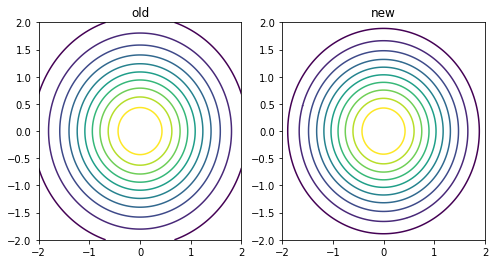

In [92]:
contour_comparision_plot_2d(x, y, pdf, [levels_pdf, levels_prob])

In [93]:
def contour_level_weight(levels_lst, pdf_lst):
    """Compute the probability that levels occur, for given sequences of levels and densities.
    
    Note this assumes a linearly spaced support!
    
    Args:
        levels_lst : sequence of levels 
            
        
    """

def plot_contour_levels_stat(levels_lst, pdf_lst, labels):
    # return that all contour levels have equal probability
    
    if (len(levels_lst) != len(pdf_lst) or len(levels_lst) != len(labels))
        raise ValueError("All arguments must be sequences of equal length.")

    # k levels cut the prob values into k+1 subsets
    n = len(levels_lst)
    fig, ax = plt.subplots(figsize=(4*n, 2), nrows=1, ncols=n)
    
    for i, (levels, pdf) in enumerate(zip(levels_lst, pdf_lst)):
        levels = levels.tolist()

        # probability weight per level
        sum_prob = np.zeros(len(levels)+1)
        for p in pdf.flatten():
            idx = np.searchsorted(levels, p, side='left')
            sum_prob[idx] += p

        #print(sum_prob)
        #print(levels+[1])
        level_labels = ['L' + str(i+1) for i in range(len(levels)+1) ]
        ax[i].bar( level_labels, sum_prob)
        ax[i].set_title(labels[i])


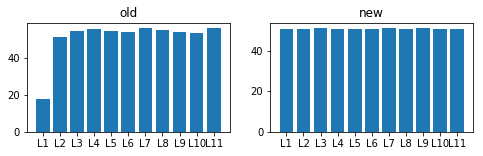

In [94]:
plot_contour_levels_stat([levels_pdf, levels_prob], [pdf, pdf], ['old', 'new'])

Now let's try with a more interesting probability density function. We will take it from Lumen. Or actually even simpler, we can just export the data directly from Lumen.

In [95]:
def reconstruct_dummy_x_y(pdf):
    """Given a sequence of density values construct x and y coordinate lists such that the the values in pdf
    could be the result of pdf(x,y). It expects that pdf is a square number.
    """
    n = np.int(np.sqrt(pdf.size))
    if not n*n == pdf.size:
        raise AssertionError("pdf must reshapable to a square matrix")
    x = np.linspace(0,1,n)
    y = np.linspace(0,1,n)
    return (x, y)

In [96]:
z = np.arange(81)
print(reconstruct_dummy_x_y(z))

(array([0.   , 0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   ]), array([0.   , 0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   ]))


### Example empirical allbus data set
This is a screenshot from lumen

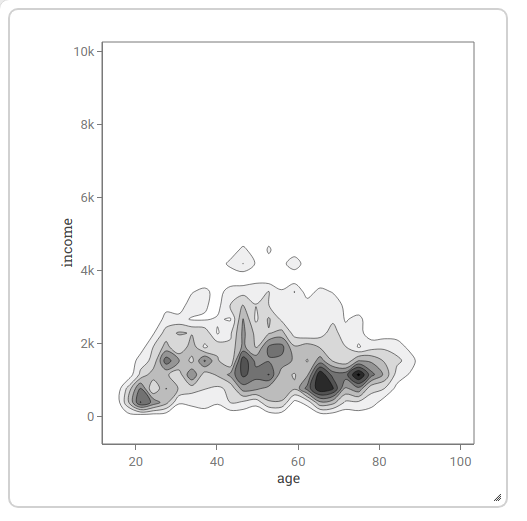

In [97]:
allbus_emp = [-758.92000,11.68000,0.00000,-758.92000,14.84000,0.00000,-758.92000,18.00000,0.00000,-758.92000,21.16000,0.00000,-758.92000,24.32000,0.00000,-758.92000,27.48000,0.00000,-758.92000,30.64000,0.00000,-758.92000,33.80000,0.00000,-758.92000,36.96000,0.00000,-758.92000,40.12000,0.00000,-758.92000,43.28000,0.00000,-758.92000,46.44000,0.00000,-758.92000,49.60000,0.00000,-758.92000,52.76000,0.00000,-758.92000,55.92000,0.00000,-758.92000,59.08000,0.00000,-758.92000,62.24000,0.00000,-758.92000,65.40000,0.00000,-758.92000,68.56000,0.00000,-758.92000,71.72000,0.00000,-758.92000,74.88000,0.00000,-758.92000,78.04000,0.00000,-758.92000,81.20000,0.00000,-758.92000,84.36000,0.00000,-758.92000,87.52000,0.00000,-758.92000,90.68000,0.00000,-758.92000,93.84000,0.00000,-758.92000,97.00000,0.00000,-758.92000,100.16000,0.00000,-758.92000,103.32000,0.00000,-378.96000,11.68000,0.00000,-378.96000,14.84000,0.00000,-378.96000,18.00000,0.00000,-378.96000,21.16000,0.00000,-378.96000,24.32000,0.00000,-378.96000,27.48000,0.00000,-378.96000,30.64000,0.00000,-378.96000,33.80000,0.00000,-378.96000,36.96000,0.00000,-378.96000,40.12000,0.00000,-378.96000,43.28000,0.00000,-378.96000,46.44000,0.00000,-378.96000,49.60000,0.00000,-378.96000,52.76000,0.00000,-378.96000,55.92000,0.00000,-378.96000,59.08000,0.00000,-378.96000,62.24000,0.00000,-378.96000,65.40000,0.00000,-378.96000,68.56000,0.00000,-378.96000,71.72000,0.00000,-378.96000,74.88000,0.00000,-378.96000,78.04000,0.00000,-378.96000,81.20000,0.00000,-378.96000,84.36000,0.00000,-378.96000,87.52000,0.00000,-378.96000,90.68000,0.00000,-378.96000,93.84000,0.00000,-378.96000,97.00000,0.00000,-378.96000,100.16000,0.00000,-378.96000,103.32000,0.00000,1.00000,11.68000,0.00000,1.00000,14.84000,0.00000,1.00000,18.00000,0.00090,1.00000,21.16000,0.00045,1.00000,24.32000,0.00045,1.00000,27.48000,0.00045,1.00000,30.64000,0.00000,1.00000,33.80000,0.00135,1.00000,36.96000,0.00000,1.00000,40.12000,0.00045,1.00000,43.28000,0.00045,1.00000,46.44000,0.00045,1.00000,49.60000,0.00000,1.00000,52.76000,0.00045,1.00000,55.92000,0.00045,1.00000,59.08000,0.00045,1.00000,62.24000,0.00000,1.00000,65.40000,0.00045,1.00000,68.56000,0.00045,1.00000,71.72000,0.00045,1.00000,74.88000,0.00090,1.00000,78.04000,0.00000,1.00000,81.20000,0.00000,1.00000,84.36000,0.00000,1.00000,87.52000,0.00000,1.00000,90.68000,0.00000,1.00000,93.84000,0.00000,1.00000,97.00000,0.00000,1.00000,100.16000,0.00000,1.00000,103.32000,0.00000,380.96000,11.68000,0.00000,380.96000,14.84000,0.00000,380.96000,18.00000,0.00538,380.96000,21.16000,0.01211,380.96000,24.32000,0.00942,380.96000,27.48000,0.00673,380.96000,30.64000,0.00224,380.96000,33.80000,0.00224,380.96000,36.96000,0.00359,380.96000,40.12000,0.00224,380.96000,43.28000,0.00404,380.96000,46.44000,0.00359,380.96000,49.60000,0.00269,380.96000,52.76000,0.00583,380.96000,55.92000,0.00583,380.96000,59.08000,0.00135,380.96000,62.24000,0.00269,380.96000,65.40000,0.00762,380.96000,68.56000,0.00673,380.96000,71.72000,0.00359,380.96000,74.88000,0.00359,380.96000,78.04000,0.00314,380.96000,81.20000,0.00090,380.96000,84.36000,0.00045,380.96000,87.52000,0.00090,380.96000,90.68000,0.00000,380.96000,93.84000,0.00000,380.96000,97.00000,0.00000,380.96000,100.16000,0.00000,380.96000,103.32000,0.00000,760.92000,11.68000,0.00000,760.92000,14.84000,0.00000,760.92000,18.00000,0.00448,760.92000,21.16000,0.01031,760.92000,24.32000,0.00404,760.92000,27.48000,0.00807,760.92000,30.64000,0.00583,760.92000,33.80000,0.00493,760.92000,36.96000,0.00404,760.92000,40.12000,0.00359,760.92000,43.28000,0.00448,760.92000,46.44000,0.00897,760.92000,49.60000,0.00852,760.92000,52.76000,0.00717,760.92000,55.92000,0.00717,760.92000,59.08000,0.00628,760.92000,62.24000,0.01076,760.92000,65.40000,0.01570,760.92000,68.56000,0.01435,760.92000,71.72000,0.00762,760.92000,74.88000,0.00942,760.92000,78.04000,0.00448,760.92000,81.20000,0.00404,760.92000,84.36000,0.00135,760.92000,87.52000,0.00045,760.92000,90.68000,0.00000,760.92000,93.84000,0.00000,760.92000,97.00000,0.00000,760.92000,100.16000,0.00000,760.92000,103.32000,0.00000,1140.88000,11.68000,0.00000,1140.88000,14.84000,0.00000,1140.88000,18.00000,0.00045,1140.88000,21.16000,0.00448,1140.88000,24.32000,0.00717,1140.88000,27.48000,0.00628,1140.88000,30.64000,0.00493,1140.88000,33.80000,0.00987,1140.88000,36.96000,0.00493,1140.88000,40.12000,0.00628,1140.88000,43.28000,0.00852,1140.88000,46.44000,0.01256,1140.88000,49.60000,0.01076,1140.88000,52.76000,0.01211,1140.88000,55.92000,0.00673,1140.88000,59.08000,0.00583,1140.88000,62.24000,0.00762,1140.88000,65.40000,0.01570,1140.88000,68.56000,0.01121,1140.88000,71.72000,0.01121,1140.88000,74.88000,0.01659,1140.88000,78.04000,0.01076,1140.88000,81.20000,0.00762,1140.88000,84.36000,0.00314,1140.88000,87.52000,0.00179,1140.88000,90.68000,0.00135,1140.88000,93.84000,0.00000,1140.88000,97.00000,0.00045,1140.88000,100.16000,0.00000,1140.88000,103.32000,0.00000,1520.84000,11.68000,0.00000,1520.84000,14.84000,0.00000,1520.84000,18.00000,0.00000,1520.84000,21.16000,0.00314,1520.84000,24.32000,0.00448,1520.84000,27.48000,0.01121,1520.84000,30.64000,0.00807,1520.84000,33.80000,0.00538,1520.84000,36.96000,0.01031,1520.84000,40.12000,0.00628,1520.84000,43.28000,0.00404,1520.84000,46.44000,0.01345,1520.84000,49.60000,0.00942,1520.84000,52.76000,0.00987,1520.84000,55.92000,0.00942,1520.84000,59.08000,0.00762,1520.84000,62.24000,0.00583,1520.84000,65.40000,0.00897,1520.84000,68.56000,0.00583,1520.84000,71.72000,0.00448,1520.84000,74.88000,0.00807,1520.84000,78.04000,0.00762,1520.84000,81.20000,0.00583,1520.84000,84.36000,0.00448,1520.84000,87.52000,0.00314,1520.84000,90.68000,0.00045,1520.84000,93.84000,0.00000,1520.84000,97.00000,0.00000,1520.84000,100.16000,0.00000,1520.84000,103.32000,0.00000,1900.80000,11.68000,0.00000,1900.80000,14.84000,0.00000,1900.80000,18.00000,0.00000,1900.80000,21.16000,0.00090,1900.80000,24.32000,0.00404,1900.80000,27.48000,0.00673,1900.80000,30.64000,0.00404,1900.80000,33.80000,0.00717,1900.80000,36.96000,0.00359,1900.80000,40.12000,0.00538,1900.80000,43.28000,0.00448,1900.80000,46.44000,0.00852,1900.80000,49.60000,0.00583,1900.80000,52.76000,0.01031,1900.80000,55.92000,0.01076,1900.80000,59.08000,0.00628,1900.80000,62.24000,0.00717,1900.80000,65.40000,0.00583,1900.80000,68.56000,0.00448,1900.80000,71.72000,0.00404,1900.80000,74.88000,0.00179,1900.80000,78.04000,0.00314,1900.80000,81.20000,0.00359,1900.80000,84.36000,0.00314,1900.80000,87.52000,0.00135,1900.80000,90.68000,0.00090,1900.80000,93.84000,0.00000,1900.80000,97.00000,0.00000,1900.80000,100.16000,0.00000,1900.80000,103.32000,0.00000,2280.76000,11.68000,0.00000,2280.76000,14.84000,0.00000,2280.76000,18.00000,0.00000,2280.76000,21.16000,0.00000,2280.76000,24.32000,0.00179,2280.76000,27.48000,0.00493,2280.76000,30.64000,0.00628,2280.76000,33.80000,0.00583,2280.76000,36.96000,0.00538,2280.76000,40.12000,0.00179,2280.76000,43.28000,0.00359,2280.76000,46.44000,0.00852,2280.76000,49.60000,0.00538,2280.76000,52.76000,0.00583,2280.76000,55.92000,0.00673,2280.76000,59.08000,0.00314,2280.76000,62.24000,0.00224,2280.76000,65.40000,0.00314,2280.76000,68.56000,0.00493,2280.76000,71.72000,0.00269,2280.76000,74.88000,0.00269,2280.76000,78.04000,0.00090,2280.76000,81.20000,0.00090,2280.76000,84.36000,0.00090,2280.76000,87.52000,0.00000,2280.76000,90.68000,0.00045,2280.76000,93.84000,0.00000,2280.76000,97.00000,0.00000,2280.76000,100.16000,0.00000,2280.76000,103.32000,0.00000,2660.72000,11.68000,0.00000,2660.72000,14.84000,0.00000,2660.72000,18.00000,0.00000,2660.72000,21.16000,0.00000,2660.72000,24.32000,0.00045,2660.72000,27.48000,0.00269,2660.72000,30.64000,0.00269,2660.72000,33.80000,0.00179,2660.72000,36.96000,0.00179,2660.72000,40.12000,0.00224,2660.72000,43.28000,0.00179,2660.72000,46.44000,0.00807,2660.72000,49.60000,0.00359,2660.72000,52.76000,0.00628,2660.72000,55.92000,0.00359,2660.72000,59.08000,0.00359,2660.72000,62.24000,0.00359,2660.72000,65.40000,0.00359,2660.72000,68.56000,0.00359,2660.72000,71.72000,0.00179,2660.72000,74.88000,0.00269,2660.72000,78.04000,0.00045,2660.72000,81.20000,0.00045,2660.72000,84.36000,0.00045,2660.72000,87.52000,0.00090,2660.72000,90.68000,0.00000,2660.72000,93.84000,0.00000,2660.72000,97.00000,0.00000,2660.72000,100.16000,0.00000,2660.72000,103.32000,0.00000,3040.68000,11.68000,0.00000,3040.68000,14.84000,0.00000,3040.68000,18.00000,0.00000,3040.68000,21.16000,0.00000,3040.68000,24.32000,0.00090,3040.68000,27.48000,0.00135,3040.68000,30.64000,0.00090,3040.68000,33.80000,0.00314,3040.68000,36.96000,0.00224,3040.68000,40.12000,0.00135,3040.68000,43.28000,0.00404,3040.68000,46.44000,0.00628,3040.68000,49.60000,0.00404,3040.68000,52.76000,0.00404,3040.68000,55.92000,0.00224,3040.68000,59.08000,0.00359,3040.68000,62.24000,0.00314,3040.68000,65.40000,0.00224,3040.68000,68.56000,0.00359,3040.68000,71.72000,0.00135,3040.68000,74.88000,0.00045,3040.68000,78.04000,0.00135,3040.68000,81.20000,0.00045,3040.68000,84.36000,0.00000,3040.68000,87.52000,0.00090,3040.68000,90.68000,0.00000,3040.68000,93.84000,0.00000,3040.68000,97.00000,0.00000,3040.68000,100.16000,0.00000,3040.68000,103.32000,0.00000,3420.64000,11.68000,0.00000,3420.64000,14.84000,0.00000,3420.64000,18.00000,0.00000,3420.64000,21.16000,0.00000,3420.64000,24.32000,0.00000,3420.64000,27.48000,0.00045,3420.64000,30.64000,0.00179,3420.64000,33.80000,0.00179,3420.64000,36.96000,0.00269,3420.64000,40.12000,0.00090,3420.64000,43.28000,0.00314,3420.64000,46.44000,0.00314,3420.64000,49.60000,0.00359,3420.64000,52.76000,0.00404,3420.64000,55.92000,0.00224,3420.64000,59.08000,0.00404,3420.64000,62.24000,0.00090,3420.64000,65.40000,0.00269,3420.64000,68.56000,0.00179,3420.64000,71.72000,0.00090,3420.64000,74.88000,0.00000,3420.64000,78.04000,0.00135,3420.64000,81.20000,0.00000,3420.64000,84.36000,0.00000,3420.64000,87.52000,0.00045,3420.64000,90.68000,0.00045,3420.64000,93.84000,0.00000,3420.64000,97.00000,0.00000,3420.64000,100.16000,0.00000,3420.64000,103.32000,0.00000,3800.60000,11.68000,0.00000,3800.60000,14.84000,0.00000,3800.60000,18.00000,0.00000,3800.60000,21.16000,0.00000,3800.60000,24.32000,0.00000,3800.60000,27.48000,0.00000,3800.60000,30.64000,0.00000,3800.60000,33.80000,0.00045,3800.60000,36.96000,0.00000,3800.60000,40.12000,0.00045,3800.60000,43.28000,0.00000,3800.60000,46.44000,0.00045,3800.60000,49.60000,0.00090,3800.60000,52.76000,0.00045,3800.60000,55.92000,0.00045,3800.60000,59.08000,0.00045,3800.60000,62.24000,0.00000,3800.60000,65.40000,0.00000,3800.60000,68.56000,0.00000,3800.60000,71.72000,0.00000,3800.60000,74.88000,0.00045,3800.60000,78.04000,0.00000,3800.60000,81.20000,0.00000,3800.60000,84.36000,0.00000,3800.60000,87.52000,0.00000,3800.60000,90.68000,0.00000,3800.60000,93.84000,0.00000,3800.60000,97.00000,0.00000,3800.60000,100.16000,0.00000,3800.60000,103.32000,0.00000,4180.56000,11.68000,0.00000,4180.56000,14.84000,0.00000,4180.56000,18.00000,0.00000,4180.56000,21.16000,0.00000,4180.56000,24.32000,0.00000,4180.56000,27.48000,0.00045,4180.56000,30.64000,0.00000,4180.56000,33.80000,0.00045,4180.56000,36.96000,0.00090,4180.56000,40.12000,0.00045,4180.56000,43.28000,0.00269,4180.56000,46.44000,0.00404,4180.56000,49.60000,0.00179,4180.56000,52.76000,0.00135,4180.56000,55.92000,0.00135,4180.56000,59.08000,0.00314,4180.56000,62.24000,0.00090,4180.56000,65.40000,0.00045,4180.56000,68.56000,0.00000,4180.56000,71.72000,0.00090,4180.56000,74.88000,0.00090,4180.56000,78.04000,0.00000,4180.56000,81.20000,0.00000,4180.56000,84.36000,0.00000,4180.56000,87.52000,0.00000,4180.56000,90.68000,0.00000,4180.56000,93.84000,0.00000,4180.56000,97.00000,0.00000,4180.56000,100.16000,0.00000,4180.56000,103.32000,0.00000,4560.52000,11.68000,0.00000,4560.52000,14.84000,0.00000,4560.52000,18.00000,0.00000,4560.52000,21.16000,0.00000,4560.52000,24.32000,0.00000,4560.52000,27.48000,0.00000,4560.52000,30.64000,0.00000,4560.52000,33.80000,0.00000,4560.52000,36.96000,0.00045,4560.52000,40.12000,0.00045,4560.52000,43.28000,0.00045,4560.52000,46.44000,0.00269,4560.52000,49.60000,0.00045,4560.52000,52.76000,0.00224,4560.52000,55.92000,0.00090,4560.52000,59.08000,0.00090,4560.52000,62.24000,0.00000,4560.52000,65.40000,0.00090,4560.52000,68.56000,0.00045,4560.52000,71.72000,0.00000,4560.52000,74.88000,0.00045,4560.52000,78.04000,0.00090,4560.52000,81.20000,0.00000,4560.52000,84.36000,0.00000,4560.52000,87.52000,0.00000,4560.52000,90.68000,0.00000,4560.52000,93.84000,0.00000,4560.52000,97.00000,0.00000,4560.52000,100.16000,0.00000,4560.52000,103.32000,0.00000,4940.48000,11.68000,0.00000,4940.48000,14.84000,0.00000,4940.48000,18.00000,0.00000,4940.48000,21.16000,0.00000,4940.48000,24.32000,0.00000,4940.48000,27.48000,0.00000,4940.48000,30.64000,0.00045,4940.48000,33.80000,0.00045,4940.48000,36.96000,0.00045,4940.48000,40.12000,0.00000,4940.48000,43.28000,0.00135,4940.48000,46.44000,0.00000,4940.48000,49.60000,0.00135,4940.48000,52.76000,0.00135,4940.48000,55.92000,0.00090,4940.48000,59.08000,0.00090,4940.48000,62.24000,0.00000,4940.48000,65.40000,0.00000,4940.48000,68.56000,0.00045,4940.48000,71.72000,0.00000,4940.48000,74.88000,0.00000,4940.48000,78.04000,0.00000,4940.48000,81.20000,0.00000,4940.48000,84.36000,0.00045,4940.48000,87.52000,0.00045,4940.48000,90.68000,0.00000,4940.48000,93.84000,0.00000,4940.48000,97.00000,0.00000,4940.48000,100.16000,0.00000,4940.48000,103.32000,0.00000,5320.44000,11.68000,0.00000,5320.44000,14.84000,0.00000,5320.44000,18.00000,0.00000,5320.44000,21.16000,0.00000,5320.44000,24.32000,0.00000,5320.44000,27.48000,0.00000,5320.44000,30.64000,0.00000,5320.44000,33.80000,0.00000,5320.44000,36.96000,0.00000,5320.44000,40.12000,0.00045,5320.44000,43.28000,0.00000,5320.44000,46.44000,0.00045,5320.44000,49.60000,0.00000,5320.44000,52.76000,0.00000,5320.44000,55.92000,0.00000,5320.44000,59.08000,0.00045,5320.44000,62.24000,0.00000,5320.44000,65.40000,0.00000,5320.44000,68.56000,0.00000,5320.44000,71.72000,0.00000,5320.44000,74.88000,0.00000,5320.44000,78.04000,0.00000,5320.44000,81.20000,0.00000,5320.44000,84.36000,0.00000,5320.44000,87.52000,0.00000,5320.44000,90.68000,0.00000,5320.44000,93.84000,0.00000,5320.44000,97.00000,0.00000,5320.44000,100.16000,0.00000,5320.44000,103.32000,0.00000,5700.40000,11.68000,0.00000,5700.40000,14.84000,0.00000,5700.40000,18.00000,0.00000,5700.40000,21.16000,0.00000,5700.40000,24.32000,0.00000,5700.40000,27.48000,0.00000,5700.40000,30.64000,0.00000,5700.40000,33.80000,0.00000,5700.40000,36.96000,0.00000,5700.40000,40.12000,0.00000,5700.40000,43.28000,0.00000,5700.40000,46.44000,0.00000,5700.40000,49.60000,0.00000,5700.40000,52.76000,0.00000,5700.40000,55.92000,0.00000,5700.40000,59.08000,0.00045,5700.40000,62.24000,0.00000,5700.40000,65.40000,0.00000,5700.40000,68.56000,0.00000,5700.40000,71.72000,0.00000,5700.40000,74.88000,0.00000,5700.40000,78.04000,0.00000,5700.40000,81.20000,0.00000,5700.40000,84.36000,0.00000,5700.40000,87.52000,0.00000,5700.40000,90.68000,0.00000,5700.40000,93.84000,0.00000,5700.40000,97.00000,0.00000,5700.40000,100.16000,0.00000,5700.40000,103.32000,0.00000,6080.36000,11.68000,0.00000,6080.36000,14.84000,0.00000,6080.36000,18.00000,0.00000,6080.36000,21.16000,0.00000,6080.36000,24.32000,0.00000,6080.36000,27.48000,0.00045,6080.36000,30.64000,0.00000,6080.36000,33.80000,0.00045,6080.36000,36.96000,0.00000,6080.36000,40.12000,0.00000,6080.36000,43.28000,0.00090,6080.36000,46.44000,0.00090,6080.36000,49.60000,0.00135,6080.36000,52.76000,0.00045,6080.36000,55.92000,0.00135,6080.36000,59.08000,0.00000,6080.36000,62.24000,0.00000,6080.36000,65.40000,0.00000,6080.36000,68.56000,0.00000,6080.36000,71.72000,0.00045,6080.36000,74.88000,0.00045,6080.36000,78.04000,0.00000,6080.36000,81.20000,0.00000,6080.36000,84.36000,0.00000,6080.36000,87.52000,0.00000,6080.36000,90.68000,0.00000,6080.36000,93.84000,0.00000,6080.36000,97.00000,0.00000,6080.36000,100.16000,0.00000,6080.36000,103.32000,0.00000,6460.32000,11.68000,0.00000,6460.32000,14.84000,0.00000,6460.32000,18.00000,0.00000,6460.32000,21.16000,0.00000,6460.32000,24.32000,0.00000,6460.32000,27.48000,0.00000,6460.32000,30.64000,0.00000,6460.32000,33.80000,0.00000,6460.32000,36.96000,0.00000,6460.32000,40.12000,0.00000,6460.32000,43.28000,0.00045,6460.32000,46.44000,0.00000,6460.32000,49.60000,0.00000,6460.32000,52.76000,0.00000,6460.32000,55.92000,0.00000,6460.32000,59.08000,0.00000,6460.32000,62.24000,0.00000,6460.32000,65.40000,0.00000,6460.32000,68.56000,0.00000,6460.32000,71.72000,0.00045,6460.32000,74.88000,0.00000,6460.32000,78.04000,0.00000,6460.32000,81.20000,0.00000,6460.32000,84.36000,0.00000,6460.32000,87.52000,0.00000,6460.32000,90.68000,0.00000,6460.32000,93.84000,0.00000,6460.32000,97.00000,0.00000,6460.32000,100.16000,0.00000,6460.32000,103.32000,0.00000,6840.28000,11.68000,0.00000,6840.28000,14.84000,0.00000,6840.28000,18.00000,0.00000,6840.28000,21.16000,0.00000,6840.28000,24.32000,0.00000,6840.28000,27.48000,0.00000,6840.28000,30.64000,0.00000,6840.28000,33.80000,0.00000,6840.28000,36.96000,0.00000,6840.28000,40.12000,0.00000,6840.28000,43.28000,0.00000,6840.28000,46.44000,0.00000,6840.28000,49.60000,0.00000,6840.28000,52.76000,0.00045,6840.28000,55.92000,0.00045,6840.28000,59.08000,0.00000,6840.28000,62.24000,0.00000,6840.28000,65.40000,0.00000,6840.28000,68.56000,0.00000,6840.28000,71.72000,0.00000,6840.28000,74.88000,0.00000,6840.28000,78.04000,0.00000,6840.28000,81.20000,0.00000,6840.28000,84.36000,0.00000,6840.28000,87.52000,0.00000,6840.28000,90.68000,0.00000,6840.28000,93.84000,0.00000,6840.28000,97.00000,0.00000,6840.28000,100.16000,0.00000,6840.28000,103.32000,0.00000,7220.24000,11.68000,0.00000,7220.24000,14.84000,0.00000,7220.24000,18.00000,0.00000,7220.24000,21.16000,0.00000,7220.24000,24.32000,0.00000,7220.24000,27.48000,0.00000,7220.24000,30.64000,0.00000,7220.24000,33.80000,0.00000,7220.24000,36.96000,0.00000,7220.24000,40.12000,0.00000,7220.24000,43.28000,0.00000,7220.24000,46.44000,0.00000,7220.24000,49.60000,0.00000,7220.24000,52.76000,0.00045,7220.24000,55.92000,0.00000,7220.24000,59.08000,0.00000,7220.24000,62.24000,0.00000,7220.24000,65.40000,0.00000,7220.24000,68.56000,0.00000,7220.24000,71.72000,0.00000,7220.24000,74.88000,0.00000,7220.24000,78.04000,0.00000,7220.24000,81.20000,0.00000,7220.24000,84.36000,0.00000,7220.24000,87.52000,0.00000,7220.24000,90.68000,0.00000,7220.24000,93.84000,0.00000,7220.24000,97.00000,0.00000,7220.24000,100.16000,0.00000,7220.24000,103.32000,0.00000,7600.20000,11.68000,0.00000,7600.20000,14.84000,0.00000,7600.20000,18.00000,0.00000,7600.20000,21.16000,0.00000,7600.20000,24.32000,0.00000,7600.20000,27.48000,0.00000,7600.20000,30.64000,0.00000,7600.20000,33.80000,0.00000,7600.20000,36.96000,0.00000,7600.20000,40.12000,0.00000,7600.20000,43.28000,0.00000,7600.20000,46.44000,0.00000,7600.20000,49.60000,0.00000,7600.20000,52.76000,0.00045,7600.20000,55.92000,0.00000,7600.20000,59.08000,0.00000,7600.20000,62.24000,0.00045,7600.20000,65.40000,0.00000,7600.20000,68.56000,0.00045,7600.20000,71.72000,0.00000,7600.20000,74.88000,0.00000,7600.20000,78.04000,0.00000,7600.20000,81.20000,0.00000,7600.20000,84.36000,0.00000,7600.20000,87.52000,0.00000,7600.20000,90.68000,0.00000,7600.20000,93.84000,0.00000,7600.20000,97.00000,0.00000,7600.20000,100.16000,0.00000,7600.20000,103.32000,0.00000,7980.16000,11.68000,0.00000,7980.16000,14.84000,0.00000,7980.16000,18.00000,0.00000,7980.16000,21.16000,0.00000,7980.16000,24.32000,0.00000,7980.16000,27.48000,0.00000,7980.16000,30.64000,0.00000,7980.16000,33.80000,0.00000,7980.16000,36.96000,0.00000,7980.16000,40.12000,0.00000,7980.16000,43.28000,0.00000,7980.16000,46.44000,0.00045,7980.16000,49.60000,0.00000,7980.16000,52.76000,0.00000,7980.16000,55.92000,0.00000,7980.16000,59.08000,0.00000,7980.16000,62.24000,0.00000,7980.16000,65.40000,0.00045,7980.16000,68.56000,0.00000,7980.16000,71.72000,0.00045,7980.16000,74.88000,0.00045,7980.16000,78.04000,0.00000,7980.16000,81.20000,0.00000,7980.16000,84.36000,0.00000,7980.16000,87.52000,0.00000,7980.16000,90.68000,0.00000,7980.16000,93.84000,0.00000,7980.16000,97.00000,0.00000,7980.16000,100.16000,0.00000,7980.16000,103.32000,0.00000,8360.12000,11.68000,0.00000,8360.12000,14.84000,0.00000,8360.12000,18.00000,0.00000,8360.12000,21.16000,0.00000,8360.12000,24.32000,0.00000,8360.12000,27.48000,0.00000,8360.12000,30.64000,0.00000,8360.12000,33.80000,0.00000,8360.12000,36.96000,0.00000,8360.12000,40.12000,0.00000,8360.12000,43.28000,0.00000,8360.12000,46.44000,0.00000,8360.12000,49.60000,0.00000,8360.12000,52.76000,0.00000,8360.12000,55.92000,0.00000,8360.12000,59.08000,0.00000,8360.12000,62.24000,0.00000,8360.12000,65.40000,0.00000,8360.12000,68.56000,0.00000,8360.12000,71.72000,0.00000,8360.12000,74.88000,0.00000,8360.12000,78.04000,0.00000,8360.12000,81.20000,0.00000,8360.12000,84.36000,0.00000,8360.12000,87.52000,0.00000,8360.12000,90.68000,0.00000,8360.12000,93.84000,0.00000,8360.12000,97.00000,0.00000,8360.12000,100.16000,0.00000,8360.12000,103.32000,0.00000,8740.08000,11.68000,0.00000,8740.08000,14.84000,0.00000,8740.08000,18.00000,0.00000,8740.08000,21.16000,0.00000,8740.08000,24.32000,0.00000,8740.08000,27.48000,0.00000,8740.08000,30.64000,0.00045,8740.08000,33.80000,0.00045,8740.08000,36.96000,0.00000,8740.08000,40.12000,0.00000,8740.08000,43.28000,0.00000,8740.08000,46.44000,0.00090,8740.08000,49.60000,0.00000,8740.08000,52.76000,0.00000,8740.08000,55.92000,0.00000,8740.08000,59.08000,0.00045,8740.08000,62.24000,0.00045,8740.08000,65.40000,0.00045,8740.08000,68.56000,0.00045,8740.08000,71.72000,0.00000,8740.08000,74.88000,0.00000,8740.08000,78.04000,0.00000,8740.08000,81.20000,0.00000,8740.08000,84.36000,0.00000,8740.08000,87.52000,0.00000,8740.08000,90.68000,0.00000,8740.08000,93.84000,0.00000,8740.08000,97.00000,0.00000,8740.08000,100.16000,0.00000,8740.08000,103.32000,0.00000,9120.04000,11.68000,0.00000,9120.04000,14.84000,0.00000,9120.04000,18.00000,0.00000,9120.04000,21.16000,0.00000,9120.04000,24.32000,0.00000,9120.04000,27.48000,0.00000,9120.04000,30.64000,0.00000,9120.04000,33.80000,0.00000,9120.04000,36.96000,0.00000,9120.04000,40.12000,0.00000,9120.04000,43.28000,0.00000,9120.04000,46.44000,0.00000,9120.04000,49.60000,0.00000,9120.04000,52.76000,0.00000,9120.04000,55.92000,0.00000,9120.04000,59.08000,0.00000,9120.04000,62.24000,0.00000,9120.04000,65.40000,0.00000,9120.04000,68.56000,0.00000,9120.04000,71.72000,0.00000,9120.04000,74.88000,0.00000,9120.04000,78.04000,0.00000,9120.04000,81.20000,0.00000,9120.04000,84.36000,0.00000,9120.04000,87.52000,0.00000,9120.04000,90.68000,0.00000,9120.04000,93.84000,0.00000,9120.04000,97.00000,0.00000,9120.04000,100.16000,0.00000,9120.04000,103.32000,0.00000,9500.00000,11.68000,0.00000,9500.00000,14.84000,0.00000,9500.00000,18.00000,0.00000,9500.00000,21.16000,0.00000,9500.00000,24.32000,0.00000,9500.00000,27.48000,0.00000,9500.00000,30.64000,0.00000,9500.00000,33.80000,0.00000,9500.00000,36.96000,0.00000,9500.00000,40.12000,0.00000,9500.00000,43.28000,0.00000,9500.00000,46.44000,0.00000,9500.00000,49.60000,0.00000,9500.00000,52.76000,0.00000,9500.00000,55.92000,0.00000,9500.00000,59.08000,0.00000,9500.00000,62.24000,0.00000,9500.00000,65.40000,0.00045,9500.00000,68.56000,0.00000,9500.00000,71.72000,0.00000,9500.00000,74.88000,0.00000,9500.00000,78.04000,0.00000,9500.00000,81.20000,0.00000,9500.00000,84.36000,0.00000,9500.00000,87.52000,0.00000,9500.00000,90.68000,0.00000,9500.00000,93.84000,0.00000,9500.00000,97.00000,0.00000,9500.00000,100.16000,0.00000,9500.00000,103.32000,0.00000,9879.96000,11.68000,0.00000,9879.96000,14.84000,0.00000,9879.96000,18.00000,0.00000,9879.96000,21.16000,0.00000,9879.96000,24.32000,0.00000,9879.96000,27.48000,0.00000,9879.96000,30.64000,0.00000,9879.96000,33.80000,0.00000,9879.96000,36.96000,0.00000,9879.96000,40.12000,0.00000,9879.96000,43.28000,0.00000,9879.96000,46.44000,0.00000,9879.96000,49.60000,0.00000,9879.96000,52.76000,0.00000,9879.96000,55.92000,0.00000,9879.96000,59.08000,0.00000,9879.96000,62.24000,0.00000,9879.96000,65.40000,0.00000,9879.96000,68.56000,0.00000,9879.96000,71.72000,0.00000,9879.96000,74.88000,0.00000,9879.96000,78.04000,0.00000,9879.96000,81.20000,0.00000,9879.96000,84.36000,0.00000,9879.96000,87.52000,0.00000,9879.96000,90.68000,0.00000,9879.96000,93.84000,0.00000,9879.96000,97.00000,0.00000,9879.96000,100.16000,0.00000,9879.96000,103.32000,0.00000,10259.92000,11.68000,0.00000,10259.92000,14.84000,0.00000,10259.92000,18.00000,0.00000,10259.92000,21.16000,0.00000,10259.92000,24.32000,0.00000,10259.92000,27.48000,0.00000,10259.92000,30.64000,0.00000,10259.92000,33.80000,0.00000,10259.92000,36.96000,0.00000,10259.92000,40.12000,0.00000,10259.92000,43.28000,0.00000,10259.92000,46.44000,0.00000,10259.92000,49.60000,0.00000,10259.92000,52.76000,0.00000,10259.92000,55.92000,0.00000,10259.92000,59.08000,0.00000,10259.92000,62.24000,0.00000,10259.92000,65.40000,0.00000,10259.92000,68.56000,0.00000,10259.92000,71.72000,0.00000,10259.92000,74.88000,0.00000,10259.92000,78.04000,0.00000,10259.92000,81.20000,0.00000,10259.92000,84.36000,0.00000,10259.92000,87.52000,0.00000,10259.92000,90.68000,0.00000,10259.92000,93.84000,0.00000,10259.92000,97.00000,0.00000,10259.92000,100.16000,0.00000,10259.92000,103.32000,0.00000]
allbus_emp = np.array(allbus_emp)
allbus_emp.shape = (900,3)
allbus_p = allbus_emp[:,2]
allbus_x, allbus_y = reconstruct_dummy_x_y(allbus_p)

In [98]:
k = 4
allbus_levels = [pdf_contour_levels(allbus_p, k), prob_contour_levels(allbus_p, k)]

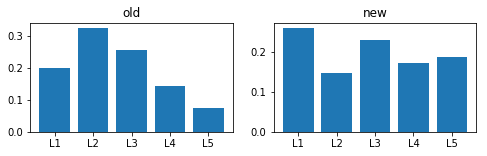

In [99]:
plot_contour_levels_stat(allbus_levels, [allbus_p, allbus_p], ['old', 'new'])

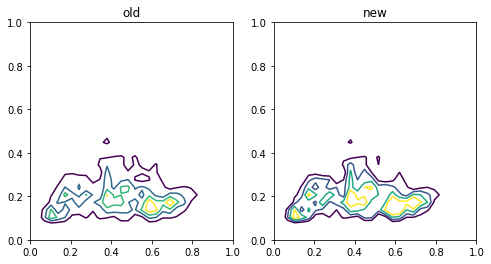

In [100]:
contour_comparision_plot_2d(allbus_x, allbus_y, allbus_p, allbus_levels)

### artificial 'bad' plots

#### 1. sum of sharp gaussian and wide gaussian


In [103]:
def plot_it(f):
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111)
    ax2.contour(f['x'], f['y'], f['pdf'])

In [104]:
from scipy.stats import multivariate_normal

def _grid_points(n):
    stepsize = 1.0/(n-1)
    x, y = np.mgrid[-1:1:stepsize, -1:1:stepsize]    
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x
    pos[:, :, 1] = y
    return pos

def gaussian_support(mu=[0.0, 0.0], sigma=[[1.0, 0], [0, 1]], n=100):
    """generate data for a multivariate gaussian"""
    pos = _grid_points(n)
    rv = multivariate_normal(mu, sigma)
    
    return {
        'x': pos[:, :, 0],
        'y': pos[:, :, 1],
        'pdf': rv.pdf(pos)
    }

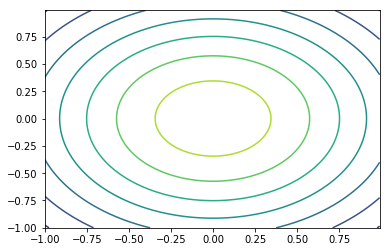

In [105]:
gm1 = gaussian_support(sigma=[[1.0, 0], [0, 1]])
plot_it(gm1)

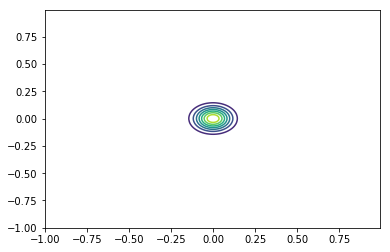

In [106]:
gm2 = gaussian_support(sigma=[[0.005, 0], [0, 0.005]])
plot_it(gm2)

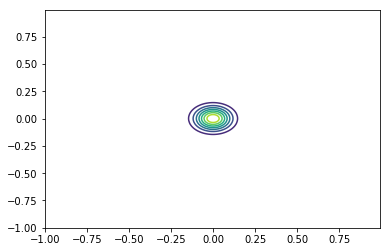

In [107]:
gm3 = {
    'x': gm1['x'],
    'y': gm1['y'],
    'pdf': gm1['pdf'] + gm2['pdf']
}
plot_it(gm3)

In [161]:
def plot_combined(x, y, p, k=10):
    """plot both, contour level stats, and the actual contour plots"""
    p = p.flatten()
        
    # generate levels
    try:
        pdf_lvls = []
        prob_lvls = []  
        prob_hori_lvls = []  
        for ki in k:
            pdf_lvls.append(pdf_contour_levels(p, ki))
            prob_lvls.append(prob_contour_levels(p, ki))
            prob_hori_lvls.append(prob_horizontal_contour_levels(p, ki))
    except TypeError:        
        pdf_lvls = [pdf_contour_levels(p, k)]
        prob_lvls = [prob_contour_levels(p, k)]
        prob_hori_lvls = [prob_horizontal_contour_levels(p, k)]
        k = [k]
        
    # plot stuff
    for i, ki in enumerate(k):        
        plot_contour_levels_stat([pdf_lvls[i], prob_lvls[i], prob_hori_lvls[i]], [p, p], 
                                 [s.format(ki) for s in ['old (k={})', 'vertical (k={})', 'horizonal (k={})']])
                                 #['old (k={})'.format(ki), 'vertical (k={})'.format(ki), 'horizonal (k={})'.format(ki)])
    for i, ki in enumerate(k):
        contour_comparision_plot_2d(x, y, p, [pdf_lvls[i], prob_lvls[i], prob_hori_lvls[i]], 
                                    [s.format(ki) for s in ['old (k={})', 'vertical (k={})', 'horizonal (k={})']])
                                    #['old (k={})'.format(ki), 'new (k={})'.format(ki)])

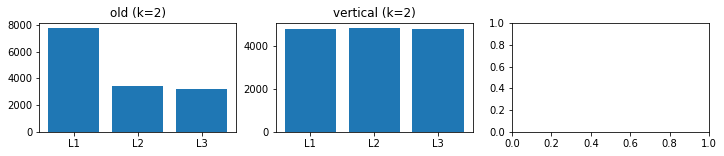

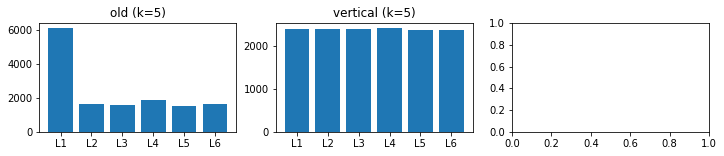

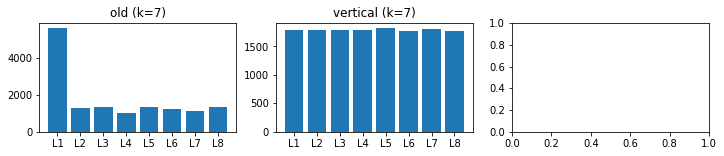

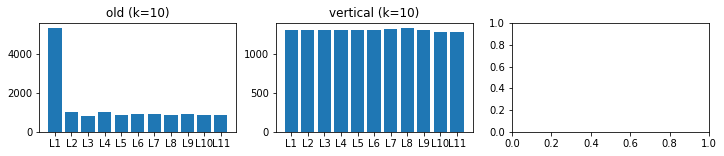

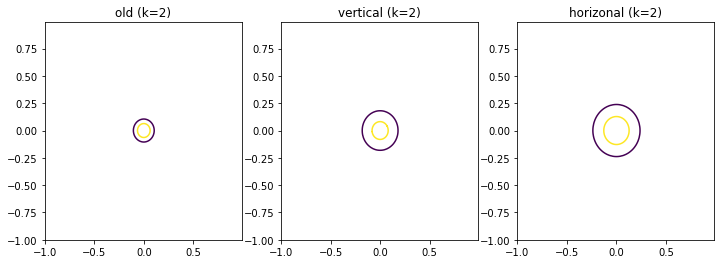

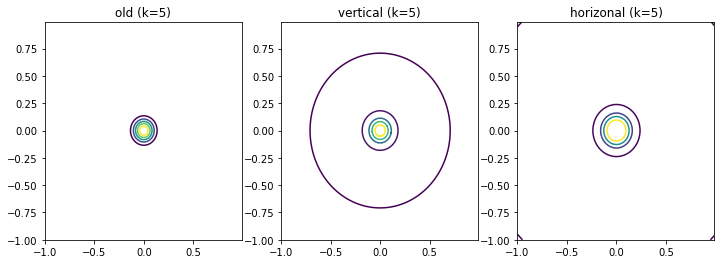

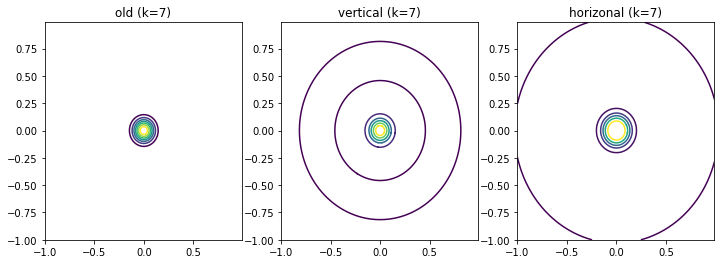

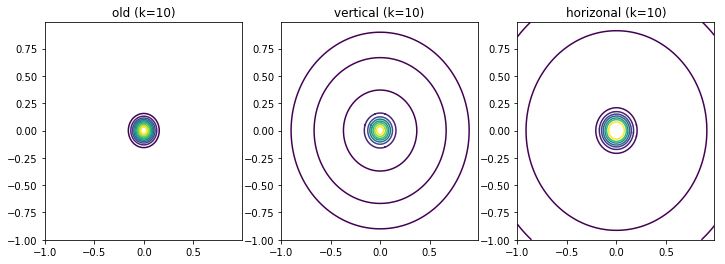

In [162]:
plot_combined(gm3['x'], gm3['y'], gm3['pdf'], k=[2,5,7,10])

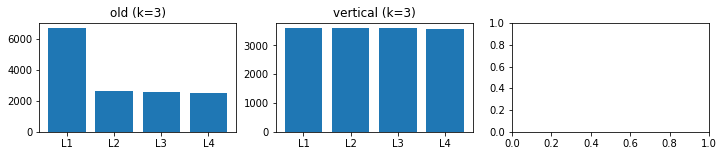

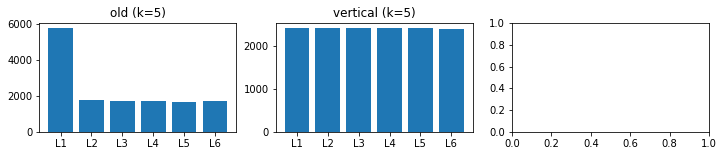

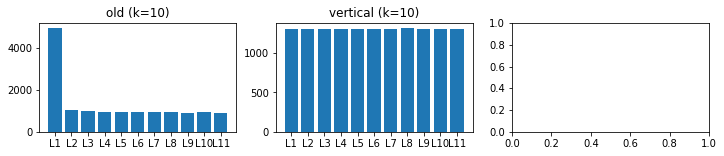

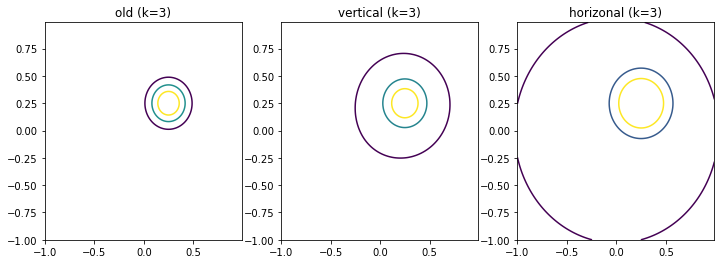

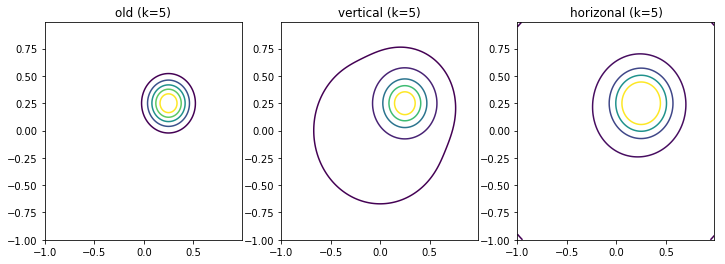

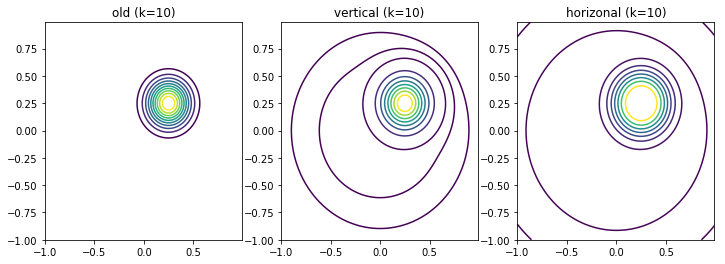

In [163]:
gm1 = gaussian_support(sigma=[[1, 0], [0, 1]])
gm2 = gaussian_support(mu=[0.25,0.25], sigma=[[0.02, 0], [0, 0.02]])
gm3p = gm1['pdf'] + gm2['pdf']
plot_combined(gm1['x'], gm1['y'], gm3p, k=[3,5,10])

#### three gaussians 

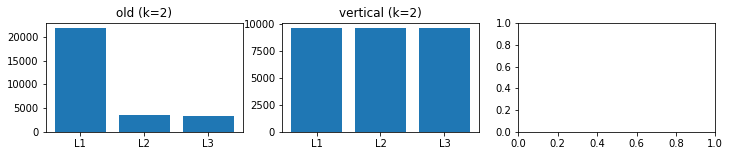

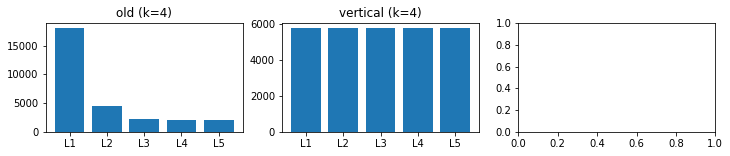

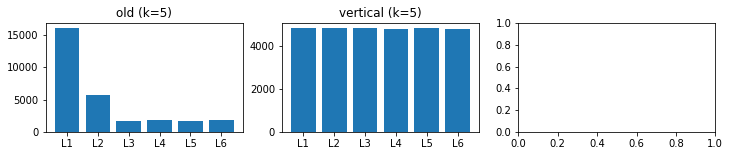

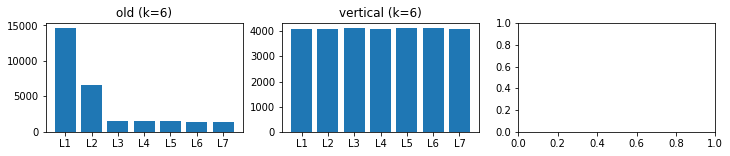

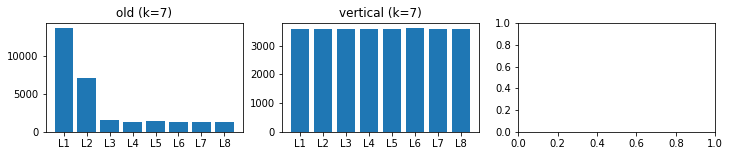

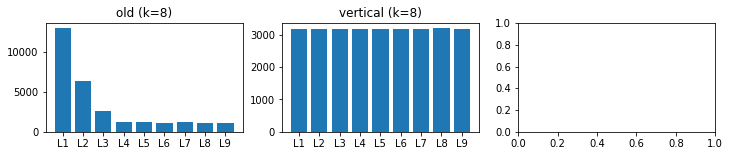

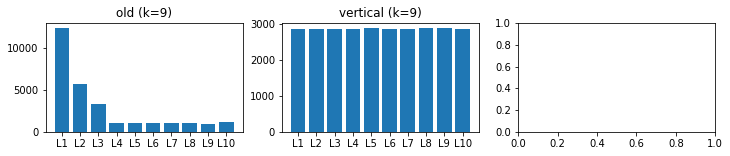

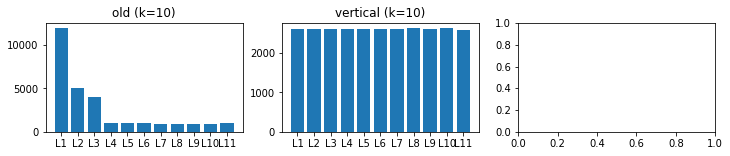

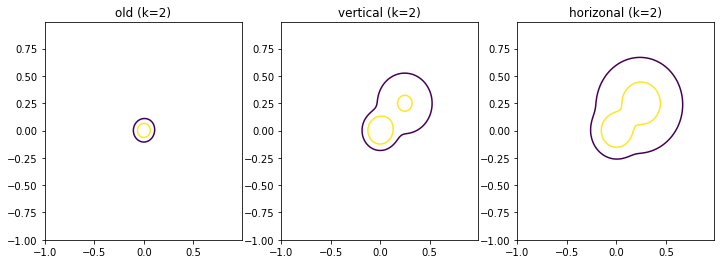

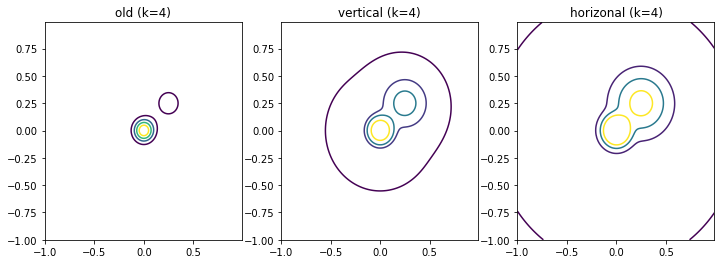

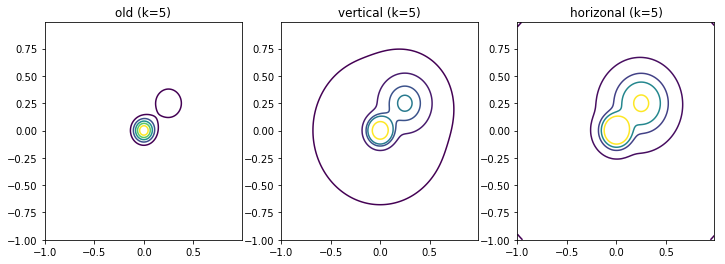

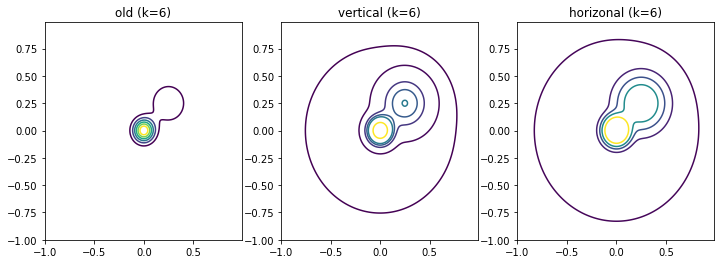

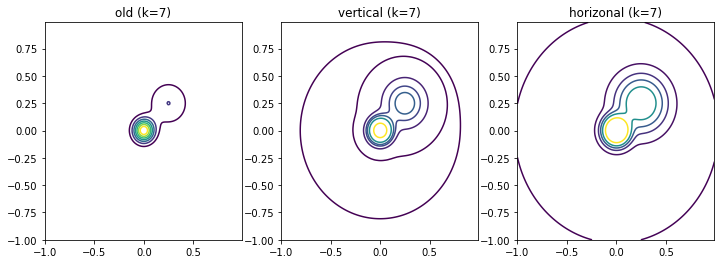

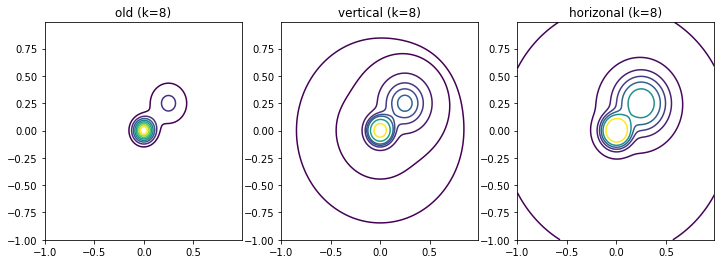

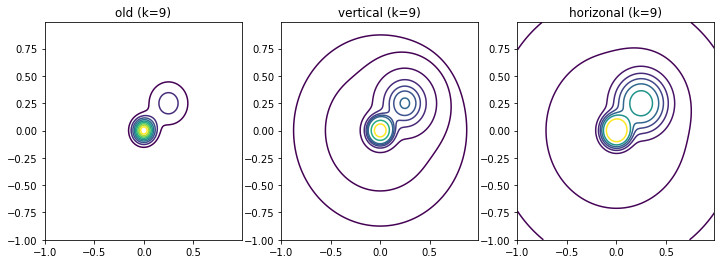

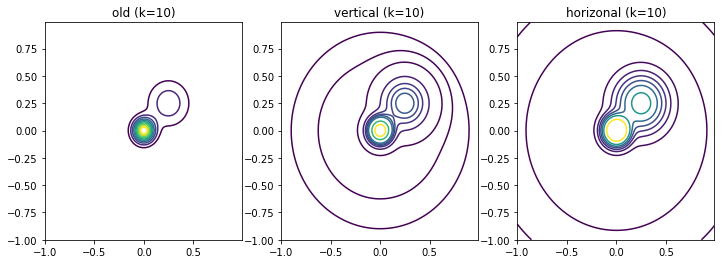

In [164]:
gm1 = gaussian_support(sigma=[[1, 0], [0, 1]])
gm2 = gaussian_support(mu=[0.25,0.25], sigma=[[0.02, 0], [0, 0.02]])
plot_combined(gm2['x'], gm2['y'], gm1['pdf'] + gm2['pdf'] + gm3['pdf'], k=[2,4,5,6,7,8,9,10])

#### again something else

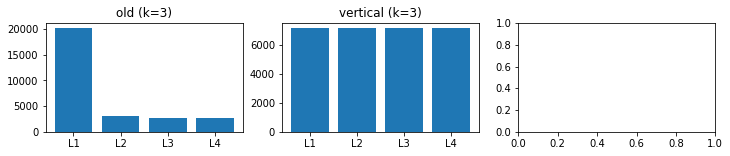

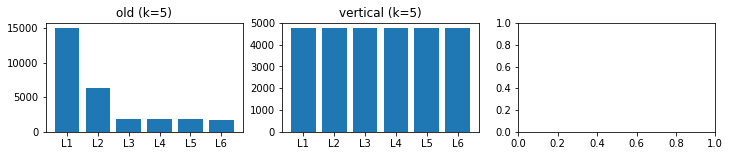

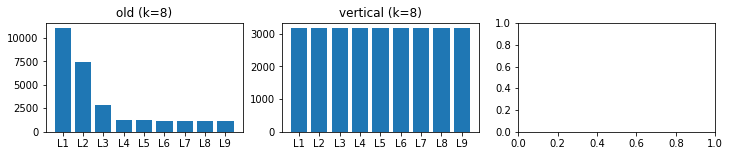

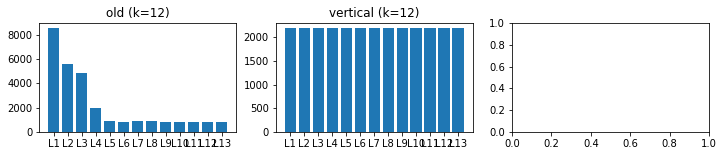

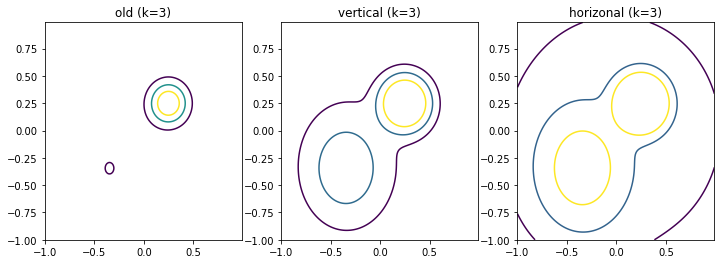

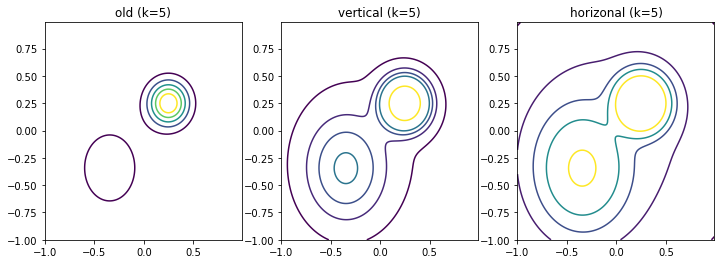

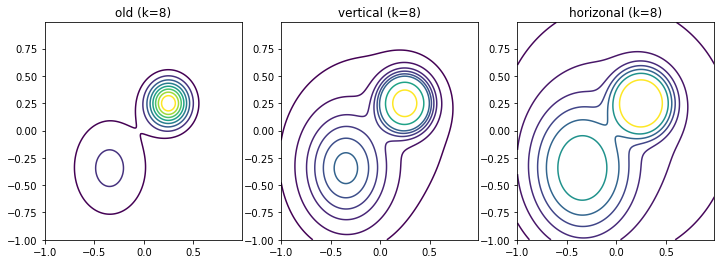

ValueError: Contour levels must be increasing

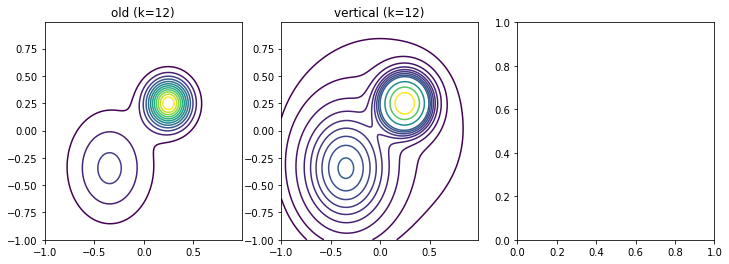

In [165]:
gm1 = gaussian_support(sigma=[[1, 0], [0, 1]])
gm2 = gaussian_support(mu=[0.25,0.25], sigma=[[0.02, 0], [0, 0.02]])
gm3 = gaussian_support(mu=[-0.35,-0.35], sigma=[[0.07, 0], [0, 0.1]])
plot_combined(gm2['x'], gm2['y'], 2*gm1['pdf'] + gm2['pdf'] + gm3['pdf'], k=[3,5,8,12])

### dirichlet distribution

yeah... that is not so easy because the distribution lives on a simplex ... 

In [185]:
from scipy.stats import dirichlet

def dirichlet_support(alpha=[0.5, 0.5], n=5):
    """generate data for a multivriate dirichlet
    
    DOES NOT WORK
    """
    pos = _grid_points(n)
    print(pos)
    rv = dirichlet(alpha)
    return {
        'x': pos[:, :, 0],
        'y': pos[:, :, 1],
        'pdf': rv.pdf(pos)
    }    

In [186]:
dirichlet.pdf([0.2], [0.1,0.2])
#gm1 = dirichlet_support(alpha=[0.1, 0.2], n=3)
#gm2 = dirichlet_support(alpha=[0,0])
#gm3 = dirichlet_support(alpha=[0.5,0.5])
#plot_combined(gm2['x'], gm2['y'], 2*gm1['pdf'] + gm2['pdf'] + gm3['pdf'], k=3)

0.3485514185821718

### kde estimator


In [170]:
from scipy.stats import gaussian_kde

def _normalize_data(data):
    """data is an array of arrays where the outer artray indexes attributes of the data."""
    for d in range(data.shape[0]):
        values = data[d]
        min_, max_ = min(values), max(values)
        data[d] = (values - min_) / (max_ - min_)
    return data    

def kde_kernel(data, kernel_bandwidth=None):
    return gaussian_kde(data, bw_method=kernel_bandwidth)

def kde_support(kernel, n=20):
    """generate data for a kernel estimate
    """        
    x = np.linspace(0, 1, n)
    y = np.linspace(0, 1, n)
    gridpoints = np.array(list(itertools.product(x, y))).transpose()
    pdf = kernel.evaluate(gridpoints)
    
    return {
        'x': x,
        'y': y,
        'pdf': pdf
    }  

### iris kde (auto bandwitdth)

In [171]:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data[:, :2].transpose()
X = _normalize_data(X)
mykernel = kde_kernel(X)

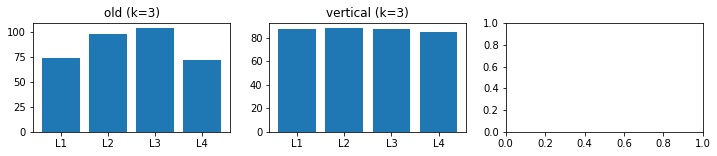

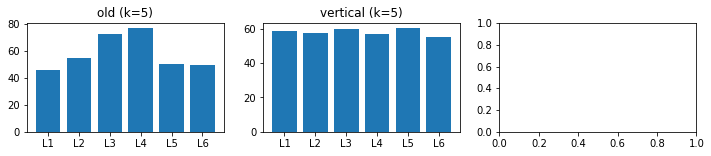

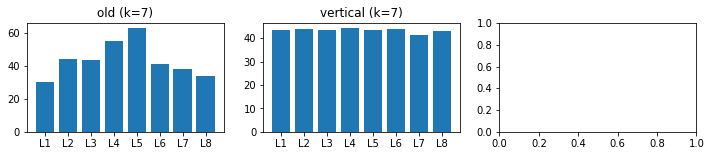

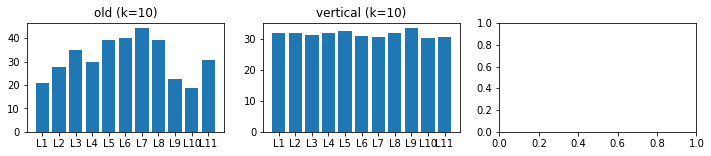

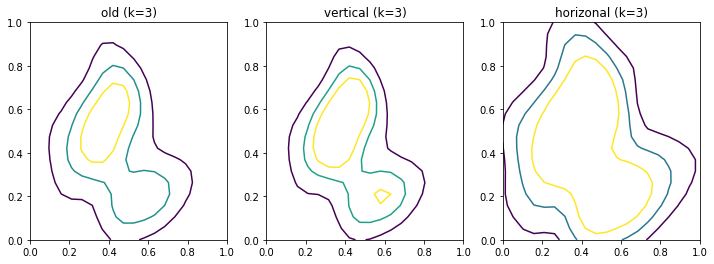

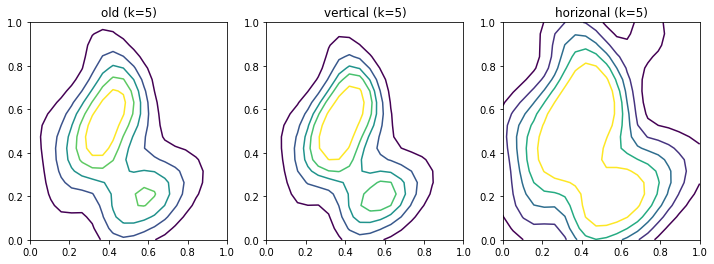

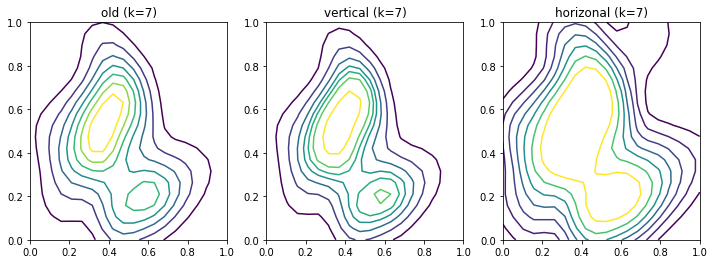

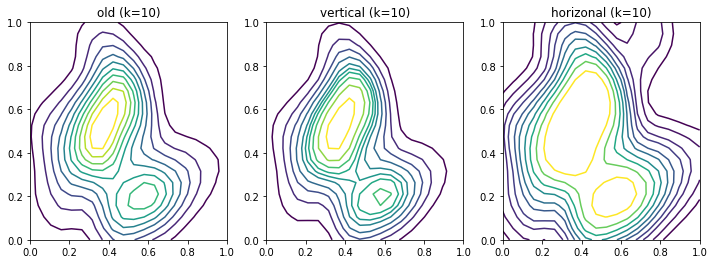

In [172]:
kde1 = kde_support(mykernel)
plot_combined(kde1['x'], kde1['y'], kde1['pdf'], k=[3,5,7,10])

### iris kde (alpha = 0.1)

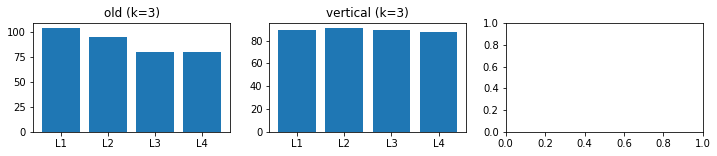

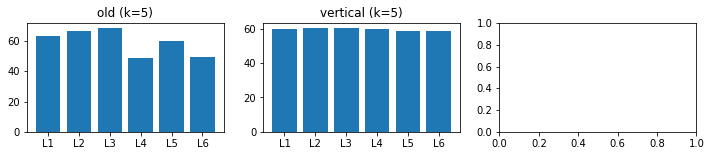

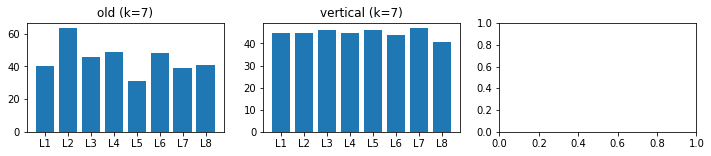

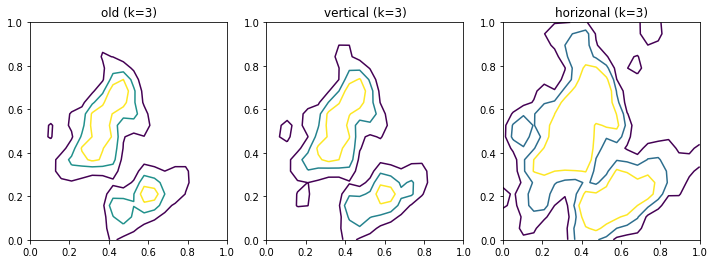

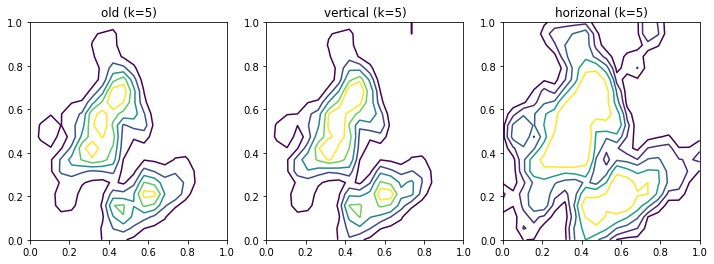

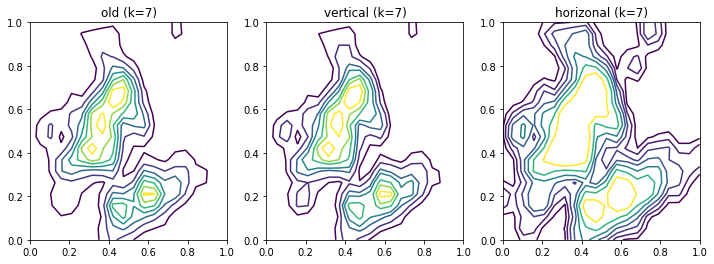

In [173]:
mykernel = kde_kernel(X, kernel_bandwidth=0.2)
kde1 = kde_support(mykernel)
plot_combined(kde1['x'], kde1['y'], kde1['pdf'], k=[3,5,7])

### another real example from lumen

this is the 'emp_titanic' data set with 2d_resolution set to 100.
As you can see you cannot see anything but the peak, even though it is obvious in the marginals that there is more structure.


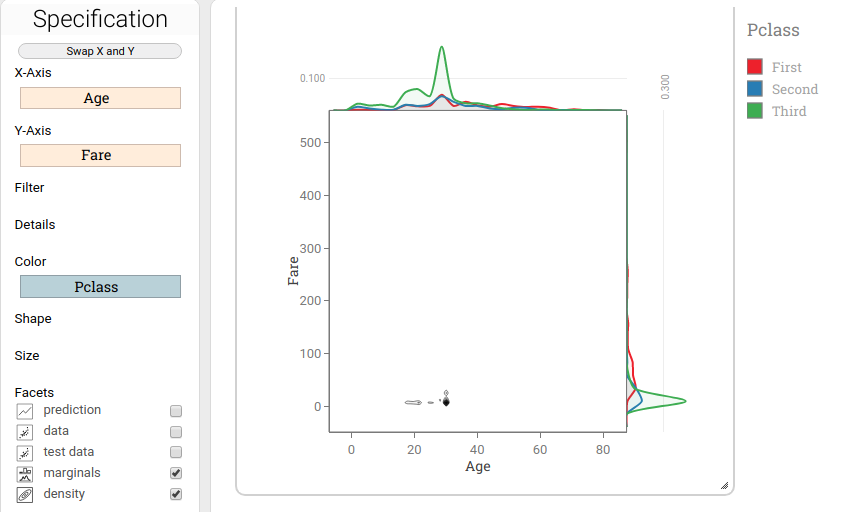

now lets draw it again with our technique

In [365]:
titanic = [-48.15894,-7.08240,0.00000,-48.15894,-6.12720,0.00000,-48.15894,-5.17200,0.00000,-48.15894,-4.21680,0.00000,-48.15894,-3.26160,0.00000,-48.15894,-2.30640,0.00000,-48.15894,-1.35120,0.00000,-48.15894,-0.39600,0.00000,-48.15894,0.55920,0.00000,-48.15894,1.51440,0.00000,-48.15894,2.46960,0.00000,-48.15894,3.42480,0.00000,-48.15894,4.38000,0.00000,-48.15894,5.33520,0.00000,-48.15894,6.29040,0.00000,-48.15894,7.24560,0.00000,-48.15894,8.20080,0.00000,-48.15894,9.15600,0.00000,-48.15894,10.11120,0.00000,-48.15894,11.06640,0.00000,-48.15894,12.02160,0.00000,-48.15894,12.97680,0.00000,-48.15894,13.93200,0.00000,-48.15894,14.88720,0.00000,-48.15894,15.84240,0.00000,-48.15894,16.79760,0.00000,-48.15894,17.75280,0.00000,-48.15894,18.70800,0.00000,-48.15894,19.66320,0.00000,-48.15894,20.61840,0.00000,-48.15894,21.57360,0.00000,-48.15894,22.52880,0.00000,-48.15894,23.48400,0.00000,-48.15894,24.43920,0.00000,-48.15894,25.39440,0.00000,-48.15894,26.34960,0.00000,-48.15894,27.30480,0.00000,-48.15894,28.26000,0.00000,-48.15894,29.21520,0.00000,-48.15894,30.17040,0.00000,-48.15894,31.12560,0.00000,-48.15894,32.08080,0.00000,-48.15894,33.03600,0.00000,-48.15894,33.99120,0.00000,-48.15894,34.94640,0.00000,-48.15894,35.90160,0.00000,-48.15894,36.85680,0.00000,-48.15894,37.81200,0.00000,-48.15894,38.76720,0.00000,-48.15894,39.72240,0.00000,-48.15894,40.67760,0.00000,-48.15894,41.63280,0.00000,-48.15894,42.58800,0.00000,-48.15894,43.54320,0.00000,-48.15894,44.49840,0.00000,-48.15894,45.45360,0.00000,-48.15894,46.40880,0.00000,-48.15894,47.36400,0.00000,-48.15894,48.31920,0.00000,-48.15894,49.27440,0.00000,-48.15894,50.22960,0.00000,-48.15894,51.18480,0.00000,-48.15894,52.14000,0.00000,-48.15894,53.09520,0.00000,-48.15894,54.05040,0.00000,-48.15894,55.00560,0.00000,-48.15894,55.96080,0.00000,-48.15894,56.91600,0.00000,-48.15894,57.87120,0.00000,-48.15894,58.82640,0.00000,-48.15894,59.78160,0.00000,-48.15894,60.73680,0.00000,-48.15894,61.69200,0.00000,-48.15894,62.64720,0.00000,-48.15894,63.60240,0.00000,-48.15894,64.55760,0.00000,-48.15894,65.51280,0.00000,-48.15894,66.46800,0.00000,-48.15894,67.42320,0.00000,-48.15894,68.37840,0.00000,-48.15894,69.33360,0.00000,-48.15894,70.28880,0.00000,-48.15894,71.24400,0.00000,-48.15894,72.19920,0.00000,-48.15894,73.15440,0.00000,-48.15894,74.10960,0.00000,-48.15894,75.06480,0.00000,-48.15894,76.02000,0.00000,-48.15894,76.97520,0.00000,-48.15894,77.93040,0.00000,-48.15894,78.88560,0.00000,-48.15894,79.84080,0.00000,-48.15894,80.79600,0.00000,-48.15894,81.75120,0.00000,-48.15894,82.70640,0.00000,-48.15894,83.66160,0.00000,-48.15894,84.61680,0.00000,-48.15894,85.57200,0.00000,-48.15894,86.52720,0.00000,-48.15894,87.48240,0.00000,-42.01099,-7.08240,0.00000,-42.01099,-6.12720,0.00000,-42.01099,-5.17200,0.00000,-42.01099,-4.21680,0.00000,-42.01099,-3.26160,0.00000,-42.01099,-2.30640,0.00000,-42.01099,-1.35120,0.00000,-42.01099,-0.39600,0.00000,-42.01099,0.55920,0.00000,-42.01099,1.51440,0.00000,-42.01099,2.46960,0.00000,-42.01099,3.42480,0.00000,-42.01099,4.38000,0.00000,-42.01099,5.33520,0.00000,-42.01099,6.29040,0.00000,-42.01099,7.24560,0.00000,-42.01099,8.20080,0.00000,-42.01099,9.15600,0.00000,-42.01099,10.11120,0.00000,-42.01099,11.06640,0.00000,-42.01099,12.02160,0.00000,-42.01099,12.97680,0.00000,-42.01099,13.93200,0.00000,-42.01099,14.88720,0.00000,-42.01099,15.84240,0.00000,-42.01099,16.79760,0.00000,-42.01099,17.75280,0.00000,-42.01099,18.70800,0.00000,-42.01099,19.66320,0.00000,-42.01099,20.61840,0.00000,-42.01099,21.57360,0.00000,-42.01099,22.52880,0.00000,-42.01099,23.48400,0.00000,-42.01099,24.43920,0.00000,-42.01099,25.39440,0.00000,-42.01099,26.34960,0.00000,-42.01099,27.30480,0.00000,-42.01099,28.26000,0.00000,-42.01099,29.21520,0.00000,-42.01099,30.17040,0.00000,-42.01099,31.12560,0.00000,-42.01099,32.08080,0.00000,-42.01099,33.03600,0.00000,-42.01099,33.99120,0.00000,-42.01099,34.94640,0.00000,-42.01099,35.90160,0.00000,-42.01099,36.85680,0.00000,-42.01099,37.81200,0.00000,-42.01099,38.76720,0.00000,-42.01099,39.72240,0.00000,-42.01099,40.67760,0.00000,-42.01099,41.63280,0.00000,-42.01099,42.58800,0.00000,-42.01099,43.54320,0.00000,-42.01099,44.49840,0.00000,-42.01099,45.45360,0.00000,-42.01099,46.40880,0.00000,-42.01099,47.36400,0.00000,-42.01099,48.31920,0.00000,-42.01099,49.27440,0.00000,-42.01099,50.22960,0.00000,-42.01099,51.18480,0.00000,-42.01099,52.14000,0.00000,-42.01099,53.09520,0.00000,-42.01099,54.05040,0.00000,-42.01099,55.00560,0.00000,-42.01099,55.96080,0.00000,-42.01099,56.91600,0.00000,-42.01099,57.87120,0.00000,-42.01099,58.82640,0.00000,-42.01099,59.78160,0.00000,-42.01099,60.73680,0.00000,-42.01099,61.69200,0.00000,-42.01099,62.64720,0.00000,-42.01099,63.60240,0.00000,-42.01099,64.55760,0.00000,-42.01099,65.51280,0.00000,-42.01099,66.46800,0.00000,-42.01099,67.42320,0.00000,-42.01099,68.37840,0.00000,-42.01099,69.33360,0.00000,-42.01099,70.28880,0.00000,-42.01099,71.24400,0.00000,-42.01099,72.19920,0.00000,-42.01099,73.15440,0.00000,-42.01099,74.10960,0.00000,-42.01099,75.06480,0.00000,-42.01099,76.02000,0.00000,-42.01099,76.97520,0.00000,-42.01099,77.93040,0.00000,-42.01099,78.88560,0.00000,-42.01099,79.84080,0.00000,-42.01099,80.79600,0.00000,-42.01099,81.75120,0.00000,-42.01099,82.70640,0.00000,-42.01099,83.66160,0.00000,-42.01099,84.61680,0.00000,-42.01099,85.57200,0.00000,-42.01099,86.52720,0.00000,-42.01099,87.48240,0.00000,-35.86304,-7.08240,0.00000,-35.86304,-6.12720,0.00000,-35.86304,-5.17200,0.00000,-35.86304,-4.21680,0.00000,-35.86304,-3.26160,0.00000,-35.86304,-2.30640,0.00000,-35.86304,-1.35120,0.00000,-35.86304,-0.39600,0.00000,-35.86304,0.55920,0.00000,-35.86304,1.51440,0.00000,-35.86304,2.46960,0.00000,-35.86304,3.42480,0.00000,-35.86304,4.38000,0.00000,-35.86304,5.33520,0.00000,-35.86304,6.29040,0.00000,-35.86304,7.24560,0.00000,-35.86304,8.20080,0.00000,-35.86304,9.15600,0.00000,-35.86304,10.11120,0.00000,-35.86304,11.06640,0.00000,-35.86304,12.02160,0.00000,-35.86304,12.97680,0.00000,-35.86304,13.93200,0.00000,-35.86304,14.88720,0.00000,-35.86304,15.84240,0.00000,-35.86304,16.79760,0.00000,-35.86304,17.75280,0.00000,-35.86304,18.70800,0.00000,-35.86304,19.66320,0.00000,-35.86304,20.61840,0.00000,-35.86304,21.57360,0.00000,-35.86304,22.52880,0.00000,-35.86304,23.48400,0.00000,-35.86304,24.43920,0.00000,-35.86304,25.39440,0.00000,-35.86304,26.34960,0.00000,-35.86304,27.30480,0.00000,-35.86304,28.26000,0.00000,-35.86304,29.21520,0.00000,-35.86304,30.17040,0.00000,-35.86304,31.12560,0.00000,-35.86304,32.08080,0.00000,-35.86304,33.03600,0.00000,-35.86304,33.99120,0.00000,-35.86304,34.94640,0.00000,-35.86304,35.90160,0.00000,-35.86304,36.85680,0.00000,-35.86304,37.81200,0.00000,-35.86304,38.76720,0.00000,-35.86304,39.72240,0.00000,-35.86304,40.67760,0.00000,-35.86304,41.63280,0.00000,-35.86304,42.58800,0.00000,-35.86304,43.54320,0.00000,-35.86304,44.49840,0.00000,-35.86304,45.45360,0.00000,-35.86304,46.40880,0.00000,-35.86304,47.36400,0.00000,-35.86304,48.31920,0.00000,-35.86304,49.27440,0.00000,-35.86304,50.22960,0.00000,-35.86304,51.18480,0.00000,-35.86304,52.14000,0.00000,-35.86304,53.09520,0.00000,-35.86304,54.05040,0.00000,-35.86304,55.00560,0.00000,-35.86304,55.96080,0.00000,-35.86304,56.91600,0.00000,-35.86304,57.87120,0.00000,-35.86304,58.82640,0.00000,-35.86304,59.78160,0.00000,-35.86304,60.73680,0.00000,-35.86304,61.69200,0.00000,-35.86304,62.64720,0.00000,-35.86304,63.60240,0.00000,-35.86304,64.55760,0.00000,-35.86304,65.51280,0.00000,-35.86304,66.46800,0.00000,-35.86304,67.42320,0.00000,-35.86304,68.37840,0.00000,-35.86304,69.33360,0.00000,-35.86304,70.28880,0.00000,-35.86304,71.24400,0.00000,-35.86304,72.19920,0.00000,-35.86304,73.15440,0.00000,-35.86304,74.10960,0.00000,-35.86304,75.06480,0.00000,-35.86304,76.02000,0.00000,-35.86304,76.97520,0.00000,-35.86304,77.93040,0.00000,-35.86304,78.88560,0.00000,-35.86304,79.84080,0.00000,-35.86304,80.79600,0.00000,-35.86304,81.75120,0.00000,-35.86304,82.70640,0.00000,-35.86304,83.66160,0.00000,-35.86304,84.61680,0.00000,-35.86304,85.57200,0.00000,-35.86304,86.52720,0.00000,-35.86304,87.48240,0.00000,-29.71509,-7.08240,0.00000,-29.71509,-6.12720,0.00000,-29.71509,-5.17200,0.00000,-29.71509,-4.21680,0.00000,-29.71509,-3.26160,0.00000,-29.71509,-2.30640,0.00000,-29.71509,-1.35120,0.00000,-29.71509,-0.39600,0.00000,-29.71509,0.55920,0.00000,-29.71509,1.51440,0.00000,-29.71509,2.46960,0.00000,-29.71509,3.42480,0.00000,-29.71509,4.38000,0.00000,-29.71509,5.33520,0.00000,-29.71509,6.29040,0.00000,-29.71509,7.24560,0.00000,-29.71509,8.20080,0.00000,-29.71509,9.15600,0.00000,-29.71509,10.11120,0.00000,-29.71509,11.06640,0.00000,-29.71509,12.02160,0.00000,-29.71509,12.97680,0.00000,-29.71509,13.93200,0.00000,-29.71509,14.88720,0.00000,-29.71509,15.84240,0.00000,-29.71509,16.79760,0.00000,-29.71509,17.75280,0.00000,-29.71509,18.70800,0.00000,-29.71509,19.66320,0.00000,-29.71509,20.61840,0.00000,-29.71509,21.57360,0.00000,-29.71509,22.52880,0.00000,-29.71509,23.48400,0.00000,-29.71509,24.43920,0.00000,-29.71509,25.39440,0.00000,-29.71509,26.34960,0.00000,-29.71509,27.30480,0.00000,-29.71509,28.26000,0.00000,-29.71509,29.21520,0.00000,-29.71509,30.17040,0.00000,-29.71509,31.12560,0.00000,-29.71509,32.08080,0.00000,-29.71509,33.03600,0.00000,-29.71509,33.99120,0.00000,-29.71509,34.94640,0.00000,-29.71509,35.90160,0.00000,-29.71509,36.85680,0.00000,-29.71509,37.81200,0.00000,-29.71509,38.76720,0.00000,-29.71509,39.72240,0.00000,-29.71509,40.67760,0.00000,-29.71509,41.63280,0.00000,-29.71509,42.58800,0.00000,-29.71509,43.54320,0.00000,-29.71509,44.49840,0.00000,-29.71509,45.45360,0.00000,-29.71509,46.40880,0.00000,-29.71509,47.36400,0.00000,-29.71509,48.31920,0.00000,-29.71509,49.27440,0.00000,-29.71509,50.22960,0.00000,-29.71509,51.18480,0.00000,-29.71509,52.14000,0.00000,-29.71509,53.09520,0.00000,-29.71509,54.05040,0.00000,-29.71509,55.00560,0.00000,-29.71509,55.96080,0.00000,-29.71509,56.91600,0.00000,-29.71509,57.87120,0.00000,-29.71509,58.82640,0.00000,-29.71509,59.78160,0.00000,-29.71509,60.73680,0.00000,-29.71509,61.69200,0.00000,-29.71509,62.64720,0.00000,-29.71509,63.60240,0.00000,-29.71509,64.55760,0.00000,-29.71509,65.51280,0.00000,-29.71509,66.46800,0.00000,-29.71509,67.42320,0.00000,-29.71509,68.37840,0.00000,-29.71509,69.33360,0.00000,-29.71509,70.28880,0.00000,-29.71509,71.24400,0.00000,-29.71509,72.19920,0.00000,-29.71509,73.15440,0.00000,-29.71509,74.10960,0.00000,-29.71509,75.06480,0.00000,-29.71509,76.02000,0.00000,-29.71509,76.97520,0.00000,-29.71509,77.93040,0.00000,-29.71509,78.88560,0.00000,-29.71509,79.84080,0.00000,-29.71509,80.79600,0.00000,-29.71509,81.75120,0.00000,-29.71509,82.70640,0.00000,-29.71509,83.66160,0.00000,-29.71509,84.61680,0.00000,-29.71509,85.57200,0.00000,-29.71509,86.52720,0.00000,-29.71509,87.48240,0.00000,-23.56714,-7.08240,0.00000,-23.56714,-6.12720,0.00000,-23.56714,-5.17200,0.00000,-23.56714,-4.21680,0.00000,-23.56714,-3.26160,0.00000,-23.56714,-2.30640,0.00000,-23.56714,-1.35120,0.00000,-23.56714,-0.39600,0.00000,-23.56714,0.55920,0.00000,-23.56714,1.51440,0.00000,-23.56714,2.46960,0.00000,-23.56714,3.42480,0.00000,-23.56714,4.38000,0.00000,-23.56714,5.33520,0.00000,-23.56714,6.29040,0.00000,-23.56714,7.24560,0.00000,-23.56714,8.20080,0.00000,-23.56714,9.15600,0.00000,-23.56714,10.11120,0.00000,-23.56714,11.06640,0.00000,-23.56714,12.02160,0.00000,-23.56714,12.97680,0.00000,-23.56714,13.93200,0.00000,-23.56714,14.88720,0.00000,-23.56714,15.84240,0.00000,-23.56714,16.79760,0.00000,-23.56714,17.75280,0.00000,-23.56714,18.70800,0.00000,-23.56714,19.66320,0.00000,-23.56714,20.61840,0.00000,-23.56714,21.57360,0.00000,-23.56714,22.52880,0.00000,-23.56714,23.48400,0.00000,-23.56714,24.43920,0.00000,-23.56714,25.39440,0.00000,-23.56714,26.34960,0.00000,-23.56714,27.30480,0.00000,-23.56714,28.26000,0.00000,-23.56714,29.21520,0.00000,-23.56714,30.17040,0.00000,-23.56714,31.12560,0.00000,-23.56714,32.08080,0.00000,-23.56714,33.03600,0.00000,-23.56714,33.99120,0.00000,-23.56714,34.94640,0.00000,-23.56714,35.90160,0.00000,-23.56714,36.85680,0.00000,-23.56714,37.81200,0.00000,-23.56714,38.76720,0.00000,-23.56714,39.72240,0.00000,-23.56714,40.67760,0.00000,-23.56714,41.63280,0.00000,-23.56714,42.58800,0.00000,-23.56714,43.54320,0.00000,-23.56714,44.49840,0.00000,-23.56714,45.45360,0.00000,-23.56714,46.40880,0.00000,-23.56714,47.36400,0.00000,-23.56714,48.31920,0.00000,-23.56714,49.27440,0.00000,-23.56714,50.22960,0.00000,-23.56714,51.18480,0.00000,-23.56714,52.14000,0.00000,-23.56714,53.09520,0.00000,-23.56714,54.05040,0.00000,-23.56714,55.00560,0.00000,-23.56714,55.96080,0.00000,-23.56714,56.91600,0.00000,-23.56714,57.87120,0.00000,-23.56714,58.82640,0.00000,-23.56714,59.78160,0.00000,-23.56714,60.73680,0.00000,-23.56714,61.69200,0.00000,-23.56714,62.64720,0.00000,-23.56714,63.60240,0.00000,-23.56714,64.55760,0.00000,-23.56714,65.51280,0.00000,-23.56714,66.46800,0.00000,-23.56714,67.42320,0.00000,-23.56714,68.37840,0.00000,-23.56714,69.33360,0.00000,-23.56714,70.28880,0.00000,-23.56714,71.24400,0.00000,-23.56714,72.19920,0.00000,-23.56714,73.15440,0.00000,-23.56714,74.10960,0.00000,-23.56714,75.06480,0.00000,-23.56714,76.02000,0.00000,-23.56714,76.97520,0.00000,-23.56714,77.93040,0.00000,-23.56714,78.88560,0.00000,-23.56714,79.84080,0.00000,-23.56714,80.79600,0.00000,-23.56714,81.75120,0.00000,-23.56714,82.70640,0.00000,-23.56714,83.66160,0.00000,-23.56714,84.61680,0.00000,-23.56714,85.57200,0.00000,-23.56714,86.52720,0.00000,-23.56714,87.48240,0.00000,-17.41919,-7.08240,0.00000,-17.41919,-6.12720,0.00000,-17.41919,-5.17200,0.00000,-17.41919,-4.21680,0.00000,-17.41919,-3.26160,0.00000,-17.41919,-2.30640,0.00000,-17.41919,-1.35120,0.00000,-17.41919,-0.39600,0.00000,-17.41919,0.55920,0.00000,-17.41919,1.51440,0.00000,-17.41919,2.46960,0.00000,-17.41919,3.42480,0.00000,-17.41919,4.38000,0.00000,-17.41919,5.33520,0.00000,-17.41919,6.29040,0.00000,-17.41919,7.24560,0.00000,-17.41919,8.20080,0.00000,-17.41919,9.15600,0.00000,-17.41919,10.11120,0.00000,-17.41919,11.06640,0.00000,-17.41919,12.02160,0.00000,-17.41919,12.97680,0.00000,-17.41919,13.93200,0.00000,-17.41919,14.88720,0.00000,-17.41919,15.84240,0.00000,-17.41919,16.79760,0.00000,-17.41919,17.75280,0.00000,-17.41919,18.70800,0.00000,-17.41919,19.66320,0.00000,-17.41919,20.61840,0.00000,-17.41919,21.57360,0.00000,-17.41919,22.52880,0.00000,-17.41919,23.48400,0.00000,-17.41919,24.43920,0.00000,-17.41919,25.39440,0.00000,-17.41919,26.34960,0.00000,-17.41919,27.30480,0.00000,-17.41919,28.26000,0.00000,-17.41919,29.21520,0.00000,-17.41919,30.17040,0.00000,-17.41919,31.12560,0.00000,-17.41919,32.08080,0.00000,-17.41919,33.03600,0.00000,-17.41919,33.99120,0.00000,-17.41919,34.94640,0.00000,-17.41919,35.90160,0.00000,-17.41919,36.85680,0.00000,-17.41919,37.81200,0.00000,-17.41919,38.76720,0.00000,-17.41919,39.72240,0.00000,-17.41919,40.67760,0.00000,-17.41919,41.63280,0.00000,-17.41919,42.58800,0.00000,-17.41919,43.54320,0.00000,-17.41919,44.49840,0.00000,-17.41919,45.45360,0.00000,-17.41919,46.40880,0.00000,-17.41919,47.36400,0.00000,-17.41919,48.31920,0.00000,-17.41919,49.27440,0.00000,-17.41919,50.22960,0.00000,-17.41919,51.18480,0.00000,-17.41919,52.14000,0.00000,-17.41919,53.09520,0.00000,-17.41919,54.05040,0.00000,-17.41919,55.00560,0.00000,-17.41919,55.96080,0.00000,-17.41919,56.91600,0.00000,-17.41919,57.87120,0.00000,-17.41919,58.82640,0.00000,-17.41919,59.78160,0.00000,-17.41919,60.73680,0.00000,-17.41919,61.69200,0.00000,-17.41919,62.64720,0.00000,-17.41919,63.60240,0.00000,-17.41919,64.55760,0.00000,-17.41919,65.51280,0.00000,-17.41919,66.46800,0.00000,-17.41919,67.42320,0.00000,-17.41919,68.37840,0.00000,-17.41919,69.33360,0.00000,-17.41919,70.28880,0.00000,-17.41919,71.24400,0.00000,-17.41919,72.19920,0.00000,-17.41919,73.15440,0.00000,-17.41919,74.10960,0.00000,-17.41919,75.06480,0.00000,-17.41919,76.02000,0.00000,-17.41919,76.97520,0.00000,-17.41919,77.93040,0.00000,-17.41919,78.88560,0.00000,-17.41919,79.84080,0.00000,-17.41919,80.79600,0.00000,-17.41919,81.75120,0.00000,-17.41919,82.70640,0.00000,-17.41919,83.66160,0.00000,-17.41919,84.61680,0.00000,-17.41919,85.57200,0.00000,-17.41919,86.52720,0.00000,-17.41919,87.48240,0.00000,-11.27124,-7.08240,0.00000,-11.27124,-6.12720,0.00000,-11.27124,-5.17200,0.00000,-11.27124,-4.21680,0.00000,-11.27124,-3.26160,0.00000,-11.27124,-2.30640,0.00000,-11.27124,-1.35120,0.00000,-11.27124,-0.39600,0.00000,-11.27124,0.55920,0.00000,-11.27124,1.51440,0.00000,-11.27124,2.46960,0.00000,-11.27124,3.42480,0.00000,-11.27124,4.38000,0.00000,-11.27124,5.33520,0.00000,-11.27124,6.29040,0.00000,-11.27124,7.24560,0.00000,-11.27124,8.20080,0.00000,-11.27124,9.15600,0.00000,-11.27124,10.11120,0.00000,-11.27124,11.06640,0.00000,-11.27124,12.02160,0.00000,-11.27124,12.97680,0.00000,-11.27124,13.93200,0.00000,-11.27124,14.88720,0.00000,-11.27124,15.84240,0.00000,-11.27124,16.79760,0.00000,-11.27124,17.75280,0.00000,-11.27124,18.70800,0.00000,-11.27124,19.66320,0.00000,-11.27124,20.61840,0.00000,-11.27124,21.57360,0.00000,-11.27124,22.52880,0.00000,-11.27124,23.48400,0.00000,-11.27124,24.43920,0.00000,-11.27124,25.39440,0.00000,-11.27124,26.34960,0.00000,-11.27124,27.30480,0.00000,-11.27124,28.26000,0.00000,-11.27124,29.21520,0.00000,-11.27124,30.17040,0.00000,-11.27124,31.12560,0.00000,-11.27124,32.08080,0.00000,-11.27124,33.03600,0.00000,-11.27124,33.99120,0.00000,-11.27124,34.94640,0.00000,-11.27124,35.90160,0.00000,-11.27124,36.85680,0.00000,-11.27124,37.81200,0.00000,-11.27124,38.76720,0.00000,-11.27124,39.72240,0.00000,-11.27124,40.67760,0.00000,-11.27124,41.63280,0.00000,-11.27124,42.58800,0.00000,-11.27124,43.54320,0.00000,-11.27124,44.49840,0.00000,-11.27124,45.45360,0.00000,-11.27124,46.40880,0.00000,-11.27124,47.36400,0.00000,-11.27124,48.31920,0.00000,-11.27124,49.27440,0.00000,-11.27124,50.22960,0.00000,-11.27124,51.18480,0.00000,-11.27124,52.14000,0.00000,-11.27124,53.09520,0.00000,-11.27124,54.05040,0.00000,-11.27124,55.00560,0.00000,-11.27124,55.96080,0.00000,-11.27124,56.91600,0.00000,-11.27124,57.87120,0.00000,-11.27124,58.82640,0.00000,-11.27124,59.78160,0.00000,-11.27124,60.73680,0.00000,-11.27124,61.69200,0.00000,-11.27124,62.64720,0.00000,-11.27124,63.60240,0.00000,-11.27124,64.55760,0.00000,-11.27124,65.51280,0.00000,-11.27124,66.46800,0.00000,-11.27124,67.42320,0.00000,-11.27124,68.37840,0.00000,-11.27124,69.33360,0.00000,-11.27124,70.28880,0.00000,-11.27124,71.24400,0.00000,-11.27124,72.19920,0.00000,-11.27124,73.15440,0.00000,-11.27124,74.10960,0.00000,-11.27124,75.06480,0.00000,-11.27124,76.02000,0.00000,-11.27124,76.97520,0.00000,-11.27124,77.93040,0.00000,-11.27124,78.88560,0.00000,-11.27124,79.84080,0.00000,-11.27124,80.79600,0.00000,-11.27124,81.75120,0.00000,-11.27124,82.70640,0.00000,-11.27124,83.66160,0.00000,-11.27124,84.61680,0.00000,-11.27124,85.57200,0.00000,-11.27124,86.52720,0.00000,-11.27124,87.48240,0.00000,-5.12329,-7.08240,0.00000,-5.12329,-6.12720,0.00000,-5.12329,-5.17200,0.00000,-5.12329,-4.21680,0.00000,-5.12329,-3.26160,0.00000,-5.12329,-2.30640,0.00000,-5.12329,-1.35120,0.00000,-5.12329,-0.39600,0.00000,-5.12329,0.55920,0.00000,-5.12329,1.51440,0.00000,-5.12329,2.46960,0.00000,-5.12329,3.42480,0.00000,-5.12329,4.38000,0.00000,-5.12329,5.33520,0.00000,-5.12329,6.29040,0.00000,-5.12329,7.24560,0.00000,-5.12329,8.20080,0.00000,-5.12329,9.15600,0.00000,-5.12329,10.11120,0.00000,-5.12329,11.06640,0.00000,-5.12329,12.02160,0.00000,-5.12329,12.97680,0.00000,-5.12329,13.93200,0.00000,-5.12329,14.88720,0.00000,-5.12329,15.84240,0.00000,-5.12329,16.79760,0.00000,-5.12329,17.75280,0.00000,-5.12329,18.70800,0.00000,-5.12329,19.66320,0.00000,-5.12329,20.61840,0.00000,-5.12329,21.57360,0.00000,-5.12329,22.52880,0.00000,-5.12329,23.48400,0.00000,-5.12329,24.43920,0.00000,-5.12329,25.39440,0.00000,-5.12329,26.34960,0.00000,-5.12329,27.30480,0.00000,-5.12329,28.26000,0.00000,-5.12329,29.21520,0.00000,-5.12329,30.17040,0.00000,-5.12329,31.12560,0.00000,-5.12329,32.08080,0.00000,-5.12329,33.03600,0.00000,-5.12329,33.99120,0.00000,-5.12329,34.94640,0.00000,-5.12329,35.90160,0.00000,-5.12329,36.85680,0.00000,-5.12329,37.81200,0.00000,-5.12329,38.76720,0.00000,-5.12329,39.72240,0.00000,-5.12329,40.67760,0.00000,-5.12329,41.63280,0.00000,-5.12329,42.58800,0.00000,-5.12329,43.54320,0.00000,-5.12329,44.49840,0.00000,-5.12329,45.45360,0.00000,-5.12329,46.40880,0.00000,-5.12329,47.36400,0.00000,-5.12329,48.31920,0.00000,-5.12329,49.27440,0.00000,-5.12329,50.22960,0.00000,-5.12329,51.18480,0.00000,-5.12329,52.14000,0.00000,-5.12329,53.09520,0.00000,-5.12329,54.05040,0.00000,-5.12329,55.00560,0.00000,-5.12329,55.96080,0.00000,-5.12329,56.91600,0.00000,-5.12329,57.87120,0.00000,-5.12329,58.82640,0.00000,-5.12329,59.78160,0.00000,-5.12329,60.73680,0.00000,-5.12329,61.69200,0.00000,-5.12329,62.64720,0.00000,-5.12329,63.60240,0.00000,-5.12329,64.55760,0.00000,-5.12329,65.51280,0.00000,-5.12329,66.46800,0.00000,-5.12329,67.42320,0.00000,-5.12329,68.37840,0.00000,-5.12329,69.33360,0.00000,-5.12329,70.28880,0.00000,-5.12329,71.24400,0.00000,-5.12329,72.19920,0.00000,-5.12329,73.15440,0.00000,-5.12329,74.10960,0.00000,-5.12329,75.06480,0.00000,-5.12329,76.02000,0.00000,-5.12329,76.97520,0.00000,-5.12329,77.93040,0.00000,-5.12329,78.88560,0.00000,-5.12329,79.84080,0.00000,-5.12329,80.79600,0.00000,-5.12329,81.75120,0.00000,-5.12329,82.70640,0.00000,-5.12329,83.66160,0.00000,-5.12329,84.61680,0.00000,-5.12329,85.57200,0.00000,-5.12329,86.52720,0.00000,-5.12329,87.48240,0.00000,1.02466,-7.08240,0.00000,1.02466,-6.12720,0.00000,1.02466,-5.17200,0.00000,1.02466,-4.21680,0.00000,1.02466,-3.26160,0.00000,1.02466,-2.30640,0.00000,1.02466,-1.35120,0.00000,1.02466,-0.39600,0.00000,1.02466,0.55920,0.00000,1.02466,1.51440,0.00000,1.02466,2.46960,0.00000,1.02466,3.42480,0.00000,1.02466,4.38000,0.00000,1.02466,5.33520,0.00000,1.02466,6.29040,0.00000,1.02466,7.24560,0.00000,1.02466,8.20080,0.00000,1.02466,9.15600,0.00000,1.02466,10.11120,0.00000,1.02466,11.06640,0.00000,1.02466,12.02160,0.00000,1.02466,12.97680,0.00000,1.02466,13.93200,0.00000,1.02466,14.88720,0.00000,1.02466,15.84240,0.00000,1.02466,16.79760,0.00000,1.02466,17.75280,0.00000,1.02466,18.70800,0.00118,1.02466,19.66320,0.00118,1.02466,20.61840,0.00000,1.02466,21.57360,0.00000,1.02466,22.52880,0.00000,1.02466,23.48400,0.00000,1.02466,24.43920,0.00000,1.02466,25.39440,0.00118,1.02466,26.34960,0.00000,1.02466,27.30480,0.00000,1.02466,28.26000,0.00000,1.02466,29.21520,0.00000,1.02466,30.17040,0.00947,1.02466,31.12560,0.00000,1.02466,32.08080,0.00000,1.02466,33.03600,0.00000,1.02466,33.99120,0.00000,1.02466,34.94640,0.00000,1.02466,35.90160,0.00118,1.02466,36.85680,0.00000,1.02466,37.81200,0.00118,1.02466,38.76720,0.00118,1.02466,39.72240,0.00118,1.02466,40.67760,0.00000,1.02466,41.63280,0.00000,1.02466,42.58800,0.00000,1.02466,43.54320,0.00000,1.02466,44.49840,0.00000,1.02466,45.45360,0.00000,1.02466,46.40880,0.00000,1.02466,47.36400,0.00000,1.02466,48.31920,0.00000,1.02466,49.27440,0.00118,1.02466,50.22960,0.00000,1.02466,51.18480,0.00000,1.02466,52.14000,0.00000,1.02466,53.09520,0.00000,1.02466,54.05040,0.00000,1.02466,55.00560,0.00000,1.02466,55.96080,0.00000,1.02466,56.91600,0.00000,1.02466,57.87120,0.00000,1.02466,58.82640,0.00000,1.02466,59.78160,0.00000,1.02466,60.73680,0.00000,1.02466,61.69200,0.00000,1.02466,62.64720,0.00000,1.02466,63.60240,0.00000,1.02466,64.55760,0.00000,1.02466,65.51280,0.00000,1.02466,66.46800,0.00000,1.02466,67.42320,0.00000,1.02466,68.37840,0.00000,1.02466,69.33360,0.00000,1.02466,70.28880,0.00000,1.02466,71.24400,0.00000,1.02466,72.19920,0.00000,1.02466,73.15440,0.00000,1.02466,74.10960,0.00000,1.02466,75.06480,0.00000,1.02466,76.02000,0.00000,1.02466,76.97520,0.00000,1.02466,77.93040,0.00000,1.02466,78.88560,0.00000,1.02466,79.84080,0.00000,1.02466,80.79600,0.00000,1.02466,81.75120,0.00000,1.02466,82.70640,0.00000,1.02466,83.66160,0.00000,1.02466,84.61680,0.00000,1.02466,85.57200,0.00000,1.02466,86.52720,0.00000,1.02466,87.48240,0.00000,7.17261,-7.08240,0.00000,7.17261,-6.12720,0.00000,7.17261,-5.17200,0.00000,7.17261,-4.21680,0.00000,7.17261,-3.26160,0.00000,7.17261,-2.30640,0.00000,7.17261,-1.35120,0.00000,7.17261,-0.39600,0.00000,7.17261,0.55920,0.00118,7.17261,1.51440,0.00000,7.17261,2.46960,0.00000,7.17261,3.42480,0.00000,7.17261,4.38000,0.00000,7.17261,5.33520,0.00000,7.17261,6.29040,0.00000,7.17261,7.24560,0.00000,7.17261,8.20080,0.00000,7.17261,9.15600,0.00000,7.17261,10.11120,0.00000,7.17261,11.06640,0.00000,7.17261,12.02160,0.00000,7.17261,12.97680,0.00118,7.17261,13.93200,0.00118,7.17261,14.88720,0.00355,7.17261,15.84240,0.00828,7.17261,16.79760,0.00828,7.17261,17.75280,0.01420,7.17261,18.70800,0.01420,7.17261,19.66320,0.01538,7.17261,20.61840,0.01775,7.17261,21.57360,0.02249,7.17261,22.52880,0.00592,7.17261,23.48400,0.00118,7.17261,24.43920,0.01065,7.17261,25.39440,0.01183,7.17261,26.34960,0.00947,7.17261,27.30480,0.00473,7.17261,28.26000,0.00947,7.17261,29.21520,0.00828,7.17261,30.17040,0.11243,7.17261,31.12560,0.00592,7.17261,32.08080,0.00947,7.17261,33.03600,0.00828,7.17261,33.99120,0.00355,7.17261,34.94640,0.00710,7.17261,35.90160,0.00237,7.17261,36.85680,0.00237,7.17261,37.81200,0.00355,7.17261,38.76720,0.00237,7.17261,39.72240,0.00355,7.17261,40.67760,0.00237,7.17261,41.63280,0.00355,7.17261,42.58800,0.00237,7.17261,43.54320,0.00355,7.17261,44.49840,0.00000,7.17261,45.45360,0.00473,7.17261,46.40880,0.00000,7.17261,47.36400,0.00237,7.17261,48.31920,0.00118,7.17261,49.27440,0.00000,7.17261,50.22960,0.00118,7.17261,51.18480,0.00237,7.17261,52.14000,0.00000,7.17261,53.09520,0.00000,7.17261,54.05040,0.00000,7.17261,55.00560,0.00000,7.17261,55.96080,0.00118,7.17261,56.91600,0.00000,7.17261,57.87120,0.00000,7.17261,58.82640,0.00118,7.17261,59.78160,0.00000,7.17261,60.73680,0.00118,7.17261,61.69200,0.00000,7.17261,62.64720,0.00118,7.17261,63.60240,0.00000,7.17261,64.55760,0.00118,7.17261,65.51280,0.00000,7.17261,66.46800,0.00000,7.17261,67.42320,0.00000,7.17261,68.37840,0.00000,7.17261,69.33360,0.00000,7.17261,70.28880,0.00118,7.17261,71.24400,0.00000,7.17261,72.19920,0.00000,7.17261,73.15440,0.00000,7.17261,74.10960,0.00118,7.17261,75.06480,0.00000,7.17261,76.02000,0.00000,7.17261,76.97520,0.00000,7.17261,77.93040,0.00000,7.17261,78.88560,0.00000,7.17261,79.84080,0.00000,7.17261,80.79600,0.00000,7.17261,81.75120,0.00000,7.17261,82.70640,0.00000,7.17261,83.66160,0.00000,7.17261,84.61680,0.00000,7.17261,85.57200,0.00000,7.17261,86.52720,0.00000,7.17261,87.48240,0.00000,13.32056,-7.08240,0.00000,13.32056,-6.12720,0.00000,13.32056,-5.17200,0.00000,13.32056,-4.21680,0.00000,13.32056,-3.26160,0.00000,13.32056,-2.30640,0.00000,13.32056,-1.35120,0.00000,13.32056,-0.39600,0.00000,13.32056,0.55920,0.00355,13.32056,1.51440,0.00000,13.32056,2.46960,0.00237,13.32056,3.42480,0.00118,13.32056,4.38000,0.00237,13.32056,5.33520,0.00118,13.32056,6.29040,0.00118,13.32056,7.24560,0.00000,13.32056,8.20080,0.00000,13.32056,9.15600,0.00237,13.32056,10.11120,0.00000,13.32056,11.06640,0.00000,13.32056,12.02160,0.00118,13.32056,12.97680,0.00000,13.32056,13.93200,0.00000,13.32056,14.88720,0.00237,13.32056,15.84240,0.00118,13.32056,16.79760,0.00355,13.32056,17.75280,0.00592,13.32056,18.70800,0.00473,13.32056,19.66320,0.00118,13.32056,20.61840,0.00355,13.32056,21.57360,0.00118,13.32056,22.52880,0.00710,13.32056,23.48400,0.00000,13.32056,24.43920,0.00710,13.32056,25.39440,0.00237,13.32056,26.34960,0.00118,13.32056,27.30480,0.00828,13.32056,28.26000,0.01065,13.32056,29.21520,0.00473,13.32056,30.17040,0.03314,13.32056,31.12560,0.00237,13.32056,32.08080,0.00592,13.32056,33.03600,0.00237,13.32056,33.99120,0.00710,13.32056,34.94640,0.00118,13.32056,35.90160,0.00592,13.32056,36.85680,0.00000,13.32056,37.81200,0.00118,13.32056,38.76720,0.00237,13.32056,39.72240,0.00355,13.32056,40.67760,0.00237,13.32056,41.63280,0.00355,13.32056,42.58800,0.00000,13.32056,43.54320,0.00118,13.32056,44.49840,0.00000,13.32056,45.45360,0.00237,13.32056,46.40880,0.00000,13.32056,47.36400,0.00237,13.32056,48.31920,0.00118,13.32056,49.27440,0.00000,13.32056,50.22960,0.00355,13.32056,51.18480,0.00118,13.32056,52.14000,0.00237,13.32056,53.09520,0.00000,13.32056,54.05040,0.00118,13.32056,55.00560,0.00118,13.32056,55.96080,0.00000,13.32056,56.91600,0.00237,13.32056,57.87120,0.00000,13.32056,58.82640,0.00118,13.32056,59.78160,0.00000,13.32056,60.73680,0.00000,13.32056,61.69200,0.00118,13.32056,62.64720,0.00000,13.32056,63.60240,0.00000,13.32056,64.55760,0.00000,13.32056,65.51280,0.00000,13.32056,66.46800,0.00118,13.32056,67.42320,0.00000,13.32056,68.37840,0.00000,13.32056,69.33360,0.00000,13.32056,70.28880,0.00118,13.32056,71.24400,0.00000,13.32056,72.19920,0.00000,13.32056,73.15440,0.00000,13.32056,74.10960,0.00000,13.32056,75.06480,0.00000,13.32056,76.02000,0.00000,13.32056,76.97520,0.00000,13.32056,77.93040,0.00000,13.32056,78.88560,0.00000,13.32056,79.84080,0.00000,13.32056,80.79600,0.00000,13.32056,81.75120,0.00000,13.32056,82.70640,0.00000,13.32056,83.66160,0.00000,13.32056,84.61680,0.00000,13.32056,85.57200,0.00000,13.32056,86.52720,0.00000,13.32056,87.48240,0.00000,19.46851,-7.08240,0.00000,19.46851,-6.12720,0.00000,19.46851,-5.17200,0.00000,19.46851,-4.21680,0.00000,19.46851,-3.26160,0.00000,19.46851,-2.30640,0.00000,19.46851,-1.35120,0.00000,19.46851,-0.39600,0.00000,19.46851,0.55920,0.00473,19.46851,1.51440,0.00000,19.46851,2.46960,0.00118,19.46851,3.42480,0.00237,19.46851,4.38000,0.00237,19.46851,5.33520,0.00000,19.46851,6.29040,0.00000,19.46851,7.24560,0.00000,19.46851,8.20080,0.00118,19.46851,9.15600,0.00118,19.46851,10.11120,0.00000,19.46851,11.06640,0.00118,19.46851,12.02160,0.00000,19.46851,12.97680,0.00118,19.46851,13.93200,0.00000,19.46851,14.88720,0.00000,19.46851,15.84240,0.00237,19.46851,16.79760,0.00000,19.46851,17.75280,0.00355,19.46851,18.70800,0.00000,19.46851,19.66320,0.00000,19.46851,20.61840,0.00000,19.46851,21.57360,0.00000,19.46851,22.52880,0.00000,19.46851,23.48400,0.00000,19.46851,24.43920,0.00355,19.46851,25.39440,0.00118,19.46851,26.34960,0.00237,19.46851,27.30480,0.00118,19.46851,28.26000,0.00000,19.46851,29.21520,0.00237,19.46851,30.17040,0.00710,19.46851,31.12560,0.00237,19.46851,32.08080,0.00000,19.46851,33.03600,0.00118,19.46851,33.99120,0.00237,19.46851,34.94640,0.00237,19.46851,35.90160,0.00118,19.46851,36.85680,0.00000,19.46851,37.81200,0.00000,19.46851,38.76720,0.00000,19.46851,39.72240,0.00000,19.46851,40.67760,0.00237,19.46851,41.63280,0.00000,19.46851,42.58800,0.00000,19.46851,43.54320,0.00000,19.46851,44.49840,0.00000,19.46851,45.45360,0.00000,19.46851,46.40880,0.00000,19.46851,47.36400,0.00000,19.46851,48.31920,0.00000,19.46851,49.27440,0.00000,19.46851,50.22960,0.00000,19.46851,51.18480,0.00000,19.46851,52.14000,0.00000,19.46851,53.09520,0.00000,19.46851,54.05040,0.00000,19.46851,55.00560,0.00000,19.46851,55.96080,0.00000,19.46851,56.91600,0.00000,19.46851,57.87120,0.00000,19.46851,58.82640,0.00000,19.46851,59.78160,0.00000,19.46851,60.73680,0.00000,19.46851,61.69200,0.00000,19.46851,62.64720,0.00000,19.46851,63.60240,0.00000,19.46851,64.55760,0.00000,19.46851,65.51280,0.00000,19.46851,66.46800,0.00000,19.46851,67.42320,0.00000,19.46851,68.37840,0.00000,19.46851,69.33360,0.00000,19.46851,70.28880,0.00000,19.46851,71.24400,0.00000,19.46851,72.19920,0.00000,19.46851,73.15440,0.00000,19.46851,74.10960,0.00000,19.46851,75.06480,0.00000,19.46851,76.02000,0.00000,19.46851,76.97520,0.00000,19.46851,77.93040,0.00000,19.46851,78.88560,0.00000,19.46851,79.84080,0.00000,19.46851,80.79600,0.00000,19.46851,81.75120,0.00000,19.46851,82.70640,0.00000,19.46851,83.66160,0.00000,19.46851,84.61680,0.00000,19.46851,85.57200,0.00000,19.46851,86.52720,0.00000,19.46851,87.48240,0.00000,25.61646,-7.08240,0.00000,25.61646,-6.12720,0.00000,25.61646,-5.17200,0.00000,25.61646,-4.21680,0.00000,25.61646,-3.26160,0.00000,25.61646,-2.30640,0.00000,25.61646,-1.35120,0.00000,25.61646,-0.39600,0.00000,25.61646,0.55920,0.00000,25.61646,1.51440,0.00000,25.61646,2.46960,0.00355,25.61646,3.42480,0.00118,25.61646,4.38000,0.00237,25.61646,5.33520,0.00118,25.61646,6.29040,0.00000,25.61646,7.24560,0.00118,25.61646,8.20080,0.00118,25.61646,9.15600,0.00118,25.61646,10.11120,0.00237,25.61646,11.06640,0.00000,25.61646,12.02160,0.00000,25.61646,12.97680,0.00000,25.61646,13.93200,0.00000,25.61646,14.88720,0.00000,25.61646,15.84240,0.00000,25.61646,16.79760,0.00000,25.61646,17.75280,0.00118,25.61646,18.70800,0.00355,25.61646,19.66320,0.00000,25.61646,20.61840,0.00000,25.61646,21.57360,0.00000,25.61646,22.52880,0.00000,25.61646,23.48400,0.00000,25.61646,24.43920,0.00355,25.61646,25.39440,0.00237,25.61646,26.34960,0.00118,25.61646,27.30480,0.00118,25.61646,28.26000,0.00355,25.61646,29.21520,0.00355,25.61646,30.17040,0.02249,25.61646,31.12560,0.00237,25.61646,32.08080,0.00118,25.61646,33.03600,0.00237,25.61646,33.99120,0.00355,25.61646,34.94640,0.00355,25.61646,35.90160,0.00592,25.61646,36.85680,0.00237,25.61646,37.81200,0.00000,25.61646,38.76720,0.00237,25.61646,39.72240,0.00000,25.61646,40.67760,0.00000,25.61646,41.63280,0.00355,25.61646,42.58800,0.00118,25.61646,43.54320,0.00355,25.61646,44.49840,0.00000,25.61646,45.45360,0.00592,25.61646,46.40880,0.00000,25.61646,47.36400,0.00118,25.61646,48.31920,0.00237,25.61646,49.27440,0.00118,25.61646,50.22960,0.00118,25.61646,51.18480,0.00118,25.61646,52.14000,0.00000,25.61646,53.09520,0.00000,25.61646,54.05040,0.00355,25.61646,55.00560,0.00000,25.61646,55.96080,0.00118,25.61646,56.91600,0.00000,25.61646,57.87120,0.00118,25.61646,58.82640,0.00000,25.61646,59.78160,0.00118,25.61646,60.73680,0.00000,25.61646,61.69200,0.00237,25.61646,62.64720,0.00000,25.61646,63.60240,0.00118,25.61646,64.55760,0.00118,25.61646,65.51280,0.00000,25.61646,66.46800,0.00000,25.61646,67.42320,0.00000,25.61646,68.37840,0.00000,25.61646,69.33360,0.00000,25.61646,70.28880,0.00000,25.61646,71.24400,0.00000,25.61646,72.19920,0.00000,25.61646,73.15440,0.00000,25.61646,74.10960,0.00000,25.61646,75.06480,0.00000,25.61646,76.02000,0.00000,25.61646,76.97520,0.00000,25.61646,77.93040,0.00000,25.61646,78.88560,0.00000,25.61646,79.84080,0.00000,25.61646,80.79600,0.00000,25.61646,81.75120,0.00000,25.61646,82.70640,0.00000,25.61646,83.66160,0.00000,25.61646,84.61680,0.00000,25.61646,85.57200,0.00000,25.61646,86.52720,0.00000,25.61646,87.48240,0.00000,31.76441,-7.08240,0.00000,31.76441,-6.12720,0.00000,31.76441,-5.17200,0.00000,31.76441,-4.21680,0.00000,31.76441,-3.26160,0.00000,31.76441,-2.30640,0.00000,31.76441,-1.35120,0.00000,31.76441,-0.39600,0.00000,31.76441,0.55920,0.00118,31.76441,1.51440,0.00000,31.76441,2.46960,0.00237,31.76441,3.42480,0.00118,31.76441,4.38000,0.00237,31.76441,5.33520,0.00118,31.76441,6.29040,0.00237,31.76441,7.24560,0.00118,31.76441,8.20080,0.00118,31.76441,9.15600,0.00355,31.76441,10.11120,0.00000,31.76441,11.06640,0.00118,31.76441,12.02160,0.00000,31.76441,12.97680,0.00000,31.76441,13.93200,0.00118,31.76441,14.88720,0.00000,31.76441,15.84240,0.00118,31.76441,16.79760,0.00000,31.76441,17.75280,0.00000,31.76441,18.70800,0.00118,31.76441,19.66320,0.00000,31.76441,20.61840,0.00118,31.76441,21.57360,0.00118,31.76441,22.52880,0.00000,31.76441,23.48400,0.00000,31.76441,24.43920,0.00000,31.76441,25.39440,0.00118,31.76441,26.34960,0.00118,31.76441,27.30480,0.00118,31.76441,28.26000,0.00118,31.76441,29.21520,0.00118,31.76441,30.17040,0.00828,31.76441,31.12560,0.00000,31.76441,32.08080,0.00237,31.76441,33.03600,0.00000,31.76441,33.99120,0.00118,31.76441,34.94640,0.00000,31.76441,35.90160,0.00000,31.76441,36.85680,0.00118,31.76441,37.81200,0.00118,31.76441,38.76720,0.00355,31.76441,39.72240,0.00118,31.76441,40.67760,0.00000,31.76441,41.63280,0.00000,31.76441,42.58800,0.00000,31.76441,43.54320,0.00000,31.76441,44.49840,0.00000,31.76441,45.45360,0.00000,31.76441,46.40880,0.00000,31.76441,47.36400,0.00118,31.76441,48.31920,0.00118,31.76441,49.27440,0.00000,31.76441,50.22960,0.00118,31.76441,51.18480,0.00000,31.76441,52.14000,0.00118,31.76441,53.09520,0.00000,31.76441,54.05040,0.00000,31.76441,55.00560,0.00118,31.76441,55.96080,0.00118,31.76441,56.91600,0.00000,31.76441,57.87120,0.00118,31.76441,58.82640,0.00000,31.76441,59.78160,0.00000,31.76441,60.73680,0.00237,31.76441,61.69200,0.00000,31.76441,62.64720,0.00000,31.76441,63.60240,0.00000,31.76441,64.55760,0.00000,31.76441,65.51280,0.00000,31.76441,66.46800,0.00000,31.76441,67.42320,0.00000,31.76441,68.37840,0.00000,31.76441,69.33360,0.00000,31.76441,70.28880,0.00000,31.76441,71.24400,0.00118,31.76441,72.19920,0.00000,31.76441,73.15440,0.00000,31.76441,74.10960,0.00000,31.76441,75.06480,0.00000,31.76441,76.02000,0.00000,31.76441,76.97520,0.00000,31.76441,77.93040,0.00000,31.76441,78.88560,0.00000,31.76441,79.84080,0.00118,31.76441,80.79600,0.00000,31.76441,81.75120,0.00000,31.76441,82.70640,0.00000,31.76441,83.66160,0.00000,31.76441,84.61680,0.00000,31.76441,85.57200,0.00000,31.76441,86.52720,0.00000,31.76441,87.48240,0.00000,37.91236,-7.08240,0.00000,37.91236,-6.12720,0.00000,37.91236,-5.17200,0.00000,37.91236,-4.21680,0.00000,37.91236,-3.26160,0.00000,37.91236,-2.30640,0.00000,37.91236,-1.35120,0.00000,37.91236,-0.39600,0.00000,37.91236,0.55920,0.00355,37.91236,1.51440,0.00000,37.91236,2.46960,0.00118,37.91236,3.42480,0.00000,37.91236,4.38000,0.00118,37.91236,5.33520,0.00000,37.91236,6.29040,0.00000,37.91236,7.24560,0.00118,37.91236,8.20080,0.00118,37.91236,9.15600,0.00000,37.91236,10.11120,0.00000,37.91236,11.06640,0.00000,37.91236,12.02160,0.00000,37.91236,12.97680,0.00000,37.91236,13.93200,0.00118,37.91236,14.88720,0.00000,37.91236,15.84240,0.00237,37.91236,16.79760,0.00000,37.91236,17.75280,0.00000,37.91236,18.70800,0.00118,37.91236,19.66320,0.00000,37.91236,20.61840,0.00000,37.91236,21.57360,0.00000,37.91236,22.52880,0.00000,37.91236,23.48400,0.00000,37.91236,24.43920,0.00000,37.91236,25.39440,0.00000,37.91236,26.34960,0.00000,37.91236,27.30480,0.00000,37.91236,28.26000,0.00000,37.91236,29.21520,0.00000,37.91236,30.17040,0.00355,37.91236,31.12560,0.00000,37.91236,32.08080,0.00000,37.91236,33.03600,0.00000,37.91236,33.99120,0.00000,37.91236,34.94640,0.00000,37.91236,35.90160,0.00000,37.91236,36.85680,0.00000,37.91236,37.81200,0.00000,37.91236,38.76720,0.00000,37.91236,39.72240,0.00118,37.91236,40.67760,0.00118,37.91236,41.63280,0.00000,37.91236,42.58800,0.00000,37.91236,43.54320,0.00000,37.91236,44.49840,0.00000,37.91236,45.45360,0.00118,37.91236,46.40880,0.00000,37.91236,47.36400,0.00118,37.91236,48.31920,0.00118,37.91236,49.27440,0.00000,37.91236,50.22960,0.00000,37.91236,51.18480,0.00000,37.91236,52.14000,0.00000,37.91236,53.09520,0.00000,37.91236,54.05040,0.00000,37.91236,55.00560,0.00000,37.91236,55.96080,0.00118,37.91236,56.91600,0.00000,37.91236,57.87120,0.00000,37.91236,58.82640,0.00000,37.91236,59.78160,0.00118,37.91236,60.73680,0.00000,37.91236,61.69200,0.00000,37.91236,62.64720,0.00000,37.91236,63.60240,0.00000,37.91236,64.55760,0.00000,37.91236,65.51280,0.00000,37.91236,66.46800,0.00000,37.91236,67.42320,0.00000,37.91236,68.37840,0.00000,37.91236,69.33360,0.00000,37.91236,70.28880,0.00000,37.91236,71.24400,0.00000,37.91236,72.19920,0.00000,37.91236,73.15440,0.00000,37.91236,74.10960,0.00000,37.91236,75.06480,0.00000,37.91236,76.02000,0.00000,37.91236,76.97520,0.00000,37.91236,77.93040,0.00000,37.91236,78.88560,0.00000,37.91236,79.84080,0.00000,37.91236,80.79600,0.00000,37.91236,81.75120,0.00000,37.91236,82.70640,0.00000,37.91236,83.66160,0.00000,37.91236,84.61680,0.00000,37.91236,85.57200,0.00000,37.91236,86.52720,0.00000,37.91236,87.48240,0.00000,44.06031,-7.08240,0.00000,44.06031,-6.12720,0.00000,44.06031,-5.17200,0.00000,44.06031,-4.21680,0.00000,44.06031,-3.26160,0.00000,44.06031,-2.30640,0.00000,44.06031,-1.35120,0.00000,44.06031,-0.39600,0.00000,44.06031,0.55920,0.00118,44.06031,1.51440,0.00000,44.06031,2.46960,0.00000,44.06031,3.42480,0.00118,44.06031,4.38000,0.00000,44.06031,5.33520,0.00000,44.06031,6.29040,0.00000,44.06031,7.24560,0.00000,44.06031,8.20080,0.00000,44.06031,9.15600,0.00118,44.06031,10.11120,0.00000,44.06031,11.06640,0.00118,44.06031,12.02160,0.00000,44.06031,12.97680,0.00000,44.06031,13.93200,0.00118,44.06031,14.88720,0.00000,44.06031,15.84240,0.00000,44.06031,16.79760,0.00000,44.06031,17.75280,0.00000,44.06031,18.70800,0.00000,44.06031,19.66320,0.00000,44.06031,20.61840,0.00000,44.06031,21.57360,0.00118,44.06031,22.52880,0.00000,44.06031,23.48400,0.00000,44.06031,24.43920,0.00000,44.06031,25.39440,0.00118,44.06031,26.34960,0.00000,44.06031,27.30480,0.00000,44.06031,28.26000,0.00118,44.06031,29.21520,0.00000,44.06031,30.17040,0.00000,44.06031,31.12560,0.00000,44.06031,32.08080,0.00000,44.06031,33.03600,0.00000,44.06031,33.99120,0.00000,44.06031,34.94640,0.00000,44.06031,35.90160,0.00000,44.06031,36.85680,0.00000,44.06031,37.81200,0.00000,44.06031,38.76720,0.00000,44.06031,39.72240,0.00000,44.06031,40.67760,0.00000,44.06031,41.63280,0.00000,44.06031,42.58800,0.00118,44.06031,43.54320,0.00000,44.06031,44.49840,0.00000,44.06031,45.45360,0.00000,44.06031,46.40880,0.00000,44.06031,47.36400,0.00000,44.06031,48.31920,0.00000,44.06031,49.27440,0.00000,44.06031,50.22960,0.00000,44.06031,51.18480,0.00000,44.06031,52.14000,0.00000,44.06031,53.09520,0.00000,44.06031,54.05040,0.00000,44.06031,55.00560,0.00000,44.06031,55.96080,0.00000,44.06031,56.91600,0.00000,44.06031,57.87120,0.00000,44.06031,58.82640,0.00000,44.06031,59.78160,0.00000,44.06031,60.73680,0.00000,44.06031,61.69200,0.00000,44.06031,62.64720,0.00000,44.06031,63.60240,0.00000,44.06031,64.55760,0.00000,44.06031,65.51280,0.00000,44.06031,66.46800,0.00000,44.06031,67.42320,0.00000,44.06031,68.37840,0.00000,44.06031,69.33360,0.00000,44.06031,70.28880,0.00000,44.06031,71.24400,0.00000,44.06031,72.19920,0.00000,44.06031,73.15440,0.00000,44.06031,74.10960,0.00000,44.06031,75.06480,0.00000,44.06031,76.02000,0.00000,44.06031,76.97520,0.00000,44.06031,77.93040,0.00000,44.06031,78.88560,0.00000,44.06031,79.84080,0.00000,44.06031,80.79600,0.00000,44.06031,81.75120,0.00000,44.06031,82.70640,0.00000,44.06031,83.66160,0.00000,44.06031,84.61680,0.00000,44.06031,85.57200,0.00000,44.06031,86.52720,0.00000,44.06031,87.48240,0.00000,50.20826,-7.08240,0.00000,50.20826,-6.12720,0.00000,50.20826,-5.17200,0.00000,50.20826,-4.21680,0.00000,50.20826,-3.26160,0.00000,50.20826,-2.30640,0.00000,50.20826,-1.35120,0.00000,50.20826,-0.39600,0.00000,50.20826,0.55920,0.00000,50.20826,1.51440,0.00000,50.20826,2.46960,0.00000,50.20826,3.42480,0.00000,50.20826,4.38000,0.00000,50.20826,5.33520,0.00000,50.20826,6.29040,0.00000,50.20826,7.24560,0.00000,50.20826,8.20080,0.00000,50.20826,9.15600,0.00000,50.20826,10.11120,0.00000,50.20826,11.06640,0.00000,50.20826,12.02160,0.00000,50.20826,12.97680,0.00000,50.20826,13.93200,0.00000,50.20826,14.88720,0.00000,50.20826,15.84240,0.00000,50.20826,16.79760,0.00000,50.20826,17.75280,0.00000,50.20826,18.70800,0.00118,50.20826,19.66320,0.00000,50.20826,20.61840,0.00000,50.20826,21.57360,0.00118,50.20826,22.52880,0.00000,50.20826,23.48400,0.00000,50.20826,24.43920,0.00118,50.20826,25.39440,0.00000,50.20826,26.34960,0.00000,50.20826,27.30480,0.00118,50.20826,28.26000,0.00000,50.20826,29.21520,0.00000,50.20826,30.17040,0.00473,50.20826,31.12560,0.00237,50.20826,32.08080,0.00000,50.20826,33.03600,0.00118,50.20826,33.99120,0.00000,50.20826,34.94640,0.00237,50.20826,35.90160,0.00000,50.20826,36.85680,0.00118,50.20826,37.81200,0.00000,50.20826,38.76720,0.00000,50.20826,39.72240,0.00000,50.20826,40.67760,0.00000,50.20826,41.63280,0.00237,50.20826,42.58800,0.00000,50.20826,43.54320,0.00000,50.20826,44.49840,0.00000,50.20826,45.45360,0.00000,50.20826,46.40880,0.00000,50.20826,47.36400,0.00237,50.20826,48.31920,0.00118,50.20826,49.27440,0.00000,50.20826,50.22960,0.00000,50.20826,51.18480,0.00000,50.20826,52.14000,0.00000,50.20826,53.09520,0.00118,50.20826,54.05040,0.00118,50.20826,55.00560,0.00000,50.20826,55.96080,0.00000,50.20826,56.91600,0.00000,50.20826,57.87120,0.00000,50.20826,58.82640,0.00000,50.20826,59.78160,0.00000,50.20826,60.73680,0.00000,50.20826,61.69200,0.00000,50.20826,62.64720,0.00000,50.20826,63.60240,0.00000,50.20826,64.55760,0.00000,50.20826,65.51280,0.00000,50.20826,66.46800,0.00000,50.20826,67.42320,0.00000,50.20826,68.37840,0.00000,50.20826,69.33360,0.00000,50.20826,70.28880,0.00000,50.20826,71.24400,0.00118,50.20826,72.19920,0.00000,50.20826,73.15440,0.00000,50.20826,74.10960,0.00000,50.20826,75.06480,0.00000,50.20826,76.02000,0.00000,50.20826,76.97520,0.00000,50.20826,77.93040,0.00000,50.20826,78.88560,0.00000,50.20826,79.84080,0.00000,50.20826,80.79600,0.00000,50.20826,81.75120,0.00000,50.20826,82.70640,0.00000,50.20826,83.66160,0.00000,50.20826,84.61680,0.00000,50.20826,85.57200,0.00000,50.20826,86.52720,0.00000,50.20826,87.48240,0.00000,56.35621,-7.08240,0.00000,56.35621,-6.12720,0.00000,56.35621,-5.17200,0.00000,56.35621,-4.21680,0.00000,56.35621,-3.26160,0.00000,56.35621,-2.30640,0.00000,56.35621,-1.35120,0.00000,56.35621,-0.39600,0.00000,56.35621,0.55920,0.00000,56.35621,1.51440,0.00000,56.35621,2.46960,0.00000,56.35621,3.42480,0.00000,56.35621,4.38000,0.00000,56.35621,5.33520,0.00000,56.35621,6.29040,0.00000,56.35621,7.24560,0.00000,56.35621,8.20080,0.00000,56.35621,9.15600,0.00000,56.35621,10.11120,0.00000,56.35621,11.06640,0.00000,56.35621,12.02160,0.00000,56.35621,12.97680,0.00000,56.35621,13.93200,0.00000,56.35621,14.88720,0.00000,56.35621,15.84240,0.00118,56.35621,16.79760,0.00118,56.35621,17.75280,0.00000,56.35621,18.70800,0.00000,56.35621,19.66320,0.00000,56.35621,20.61840,0.00000,56.35621,21.57360,0.00118,56.35621,22.52880,0.00000,56.35621,23.48400,0.00000,56.35621,24.43920,0.00000,56.35621,25.39440,0.00118,56.35621,26.34960,0.00118,56.35621,27.30480,0.00000,56.35621,28.26000,0.00118,56.35621,29.21520,0.00000,56.35621,30.17040,0.00473,56.35621,31.12560,0.00118,56.35621,32.08080,0.00237,56.35621,33.03600,0.00000,56.35621,33.99120,0.00000,56.35621,34.94640,0.00000,56.35621,35.90160,0.00000,56.35621,36.85680,0.00000,56.35621,37.81200,0.00000,56.35621,38.76720,0.00118,56.35621,39.72240,0.00000,56.35621,40.67760,0.00000,56.35621,41.63280,0.00000,56.35621,42.58800,0.00000,56.35621,43.54320,0.00118,56.35621,44.49840,0.00000,56.35621,45.45360,0.00000,56.35621,46.40880,0.00000,56.35621,47.36400,0.00000,56.35621,48.31920,0.00000,56.35621,49.27440,0.00118,56.35621,50.22960,0.00118,56.35621,51.18480,0.00000,56.35621,52.14000,0.00000,56.35621,53.09520,0.00000,56.35621,54.05040,0.00118,56.35621,55.00560,0.00000,56.35621,55.96080,0.00000,56.35621,56.91600,0.00000,56.35621,57.87120,0.00000,56.35621,58.82640,0.00000,56.35621,59.78160,0.00000,56.35621,60.73680,0.00000,56.35621,61.69200,0.00000,56.35621,62.64720,0.00000,56.35621,63.60240,0.00000,56.35621,64.55760,0.00000,56.35621,65.51280,0.00000,56.35621,66.46800,0.00000,56.35621,67.42320,0.00000,56.35621,68.37840,0.00000,56.35621,69.33360,0.00000,56.35621,70.28880,0.00000,56.35621,71.24400,0.00000,56.35621,72.19920,0.00000,56.35621,73.15440,0.00000,56.35621,74.10960,0.00000,56.35621,75.06480,0.00000,56.35621,76.02000,0.00000,56.35621,76.97520,0.00000,56.35621,77.93040,0.00000,56.35621,78.88560,0.00000,56.35621,79.84080,0.00000,56.35621,80.79600,0.00000,56.35621,81.75120,0.00000,56.35621,82.70640,0.00000,56.35621,83.66160,0.00000,56.35621,84.61680,0.00000,56.35621,85.57200,0.00000,56.35621,86.52720,0.00000,56.35621,87.48240,0.00000,62.50416,-7.08240,0.00000,62.50416,-6.12720,0.00000,62.50416,-5.17200,0.00000,62.50416,-4.21680,0.00000,62.50416,-3.26160,0.00000,62.50416,-2.30640,0.00000,62.50416,-1.35120,0.00000,62.50416,-0.39600,0.00000,62.50416,0.55920,0.00000,62.50416,1.51440,0.00000,62.50416,2.46960,0.00000,62.50416,3.42480,0.00000,62.50416,4.38000,0.00000,62.50416,5.33520,0.00000,62.50416,6.29040,0.00000,62.50416,7.24560,0.00000,62.50416,8.20080,0.00000,62.50416,9.15600,0.00000,62.50416,10.11120,0.00000,62.50416,11.06640,0.00000,62.50416,12.02160,0.00000,62.50416,12.97680,0.00000,62.50416,13.93200,0.00000,62.50416,14.88720,0.00000,62.50416,15.84240,0.00000,62.50416,16.79760,0.00000,62.50416,17.75280,0.00000,62.50416,18.70800,0.00000,62.50416,19.66320,0.00000,62.50416,20.61840,0.00000,62.50416,21.57360,0.00000,62.50416,22.52880,0.00118,62.50416,23.48400,0.00000,62.50416,24.43920,0.00118,62.50416,25.39440,0.00000,62.50416,26.34960,0.00000,62.50416,27.30480,0.00000,62.50416,28.26000,0.00000,62.50416,29.21520,0.00000,62.50416,30.17040,0.00000,62.50416,31.12560,0.00000,62.50416,32.08080,0.00000,62.50416,33.03600,0.00000,62.50416,33.99120,0.00000,62.50416,34.94640,0.00000,62.50416,35.90160,0.00000,62.50416,36.85680,0.00000,62.50416,37.81200,0.00000,62.50416,38.76720,0.00000,62.50416,39.72240,0.00000,62.50416,40.67760,0.00000,62.50416,41.63280,0.00000,62.50416,42.58800,0.00000,62.50416,43.54320,0.00000,62.50416,44.49840,0.00000,62.50416,45.45360,0.00000,62.50416,46.40880,0.00118,62.50416,47.36400,0.00000,62.50416,48.31920,0.00118,62.50416,49.27440,0.00000,62.50416,50.22960,0.00000,62.50416,51.18480,0.00118,62.50416,52.14000,0.00000,62.50416,53.09520,0.00000,62.50416,54.05040,0.00000,62.50416,55.00560,0.00000,62.50416,55.96080,0.00000,62.50416,56.91600,0.00000,62.50416,57.87120,0.00000,62.50416,58.82640,0.00000,62.50416,59.78160,0.00000,62.50416,60.73680,0.00000,62.50416,61.69200,0.00000,62.50416,62.64720,0.00000,62.50416,63.60240,0.00000,62.50416,64.55760,0.00118,62.50416,65.51280,0.00000,62.50416,66.46800,0.00000,62.50416,67.42320,0.00000,62.50416,68.37840,0.00000,62.50416,69.33360,0.00000,62.50416,70.28880,0.00000,62.50416,71.24400,0.00000,62.50416,72.19920,0.00000,62.50416,73.15440,0.00000,62.50416,74.10960,0.00000,62.50416,75.06480,0.00000,62.50416,76.02000,0.00000,62.50416,76.97520,0.00000,62.50416,77.93040,0.00000,62.50416,78.88560,0.00000,62.50416,79.84080,0.00000,62.50416,80.79600,0.00000,62.50416,81.75120,0.00000,62.50416,82.70640,0.00000,62.50416,83.66160,0.00000,62.50416,84.61680,0.00000,62.50416,85.57200,0.00000,62.50416,86.52720,0.00000,62.50416,87.48240,0.00000,68.65211,-7.08240,0.00000,68.65211,-6.12720,0.00000,68.65211,-5.17200,0.00000,68.65211,-4.21680,0.00000,68.65211,-3.26160,0.00000,68.65211,-2.30640,0.00000,68.65211,-1.35120,0.00000,68.65211,-0.39600,0.00000,68.65211,0.55920,0.00000,68.65211,1.51440,0.00000,68.65211,2.46960,0.00000,68.65211,3.42480,0.00000,68.65211,4.38000,0.00000,68.65211,5.33520,0.00000,68.65211,6.29040,0.00000,68.65211,7.24560,0.00000,68.65211,8.20080,0.00000,68.65211,9.15600,0.00000,68.65211,10.11120,0.00000,68.65211,11.06640,0.00000,68.65211,12.02160,0.00000,68.65211,12.97680,0.00000,68.65211,13.93200,0.00000,68.65211,14.88720,0.00000,68.65211,15.84240,0.00000,68.65211,16.79760,0.00000,68.65211,17.75280,0.00000,68.65211,18.70800,0.00000,68.65211,19.66320,0.00000,68.65211,20.61840,0.00000,68.65211,21.57360,0.00118,68.65211,22.52880,0.00000,68.65211,23.48400,0.00000,68.65211,24.43920,0.00237,68.65211,25.39440,0.00000,68.65211,26.34960,0.00000,68.65211,27.30480,0.00000,68.65211,28.26000,0.00000,68.65211,29.21520,0.00118,68.65211,30.17040,0.00828,68.65211,31.12560,0.00000,68.65211,32.08080,0.00000,68.65211,33.03600,0.00000,68.65211,33.99120,0.00000,68.65211,34.94640,0.00000,68.65211,35.90160,0.00118,68.65211,36.85680,0.00000,68.65211,37.81200,0.00118,68.65211,38.76720,0.00000,68.65211,39.72240,0.00000,68.65211,40.67760,0.00000,68.65211,41.63280,0.00000,68.65211,42.58800,0.00000,68.65211,43.54320,0.00000,68.65211,44.49840,0.00000,68.65211,45.45360,0.00000,68.65211,46.40880,0.00000,68.65211,47.36400,0.00000,68.65211,48.31920,0.00000,68.65211,49.27440,0.00000,68.65211,50.22960,0.00000,68.65211,51.18480,0.00000,68.65211,52.14000,0.00000,68.65211,53.09520,0.00000,68.65211,54.05040,0.00000,68.65211,55.00560,0.00000,68.65211,55.96080,0.00000,68.65211,56.91600,0.00000,68.65211,57.87120,0.00000,68.65211,58.82640,0.00000,68.65211,59.78160,0.00000,68.65211,60.73680,0.00000,68.65211,61.69200,0.00000,68.65211,62.64720,0.00000,68.65211,63.60240,0.00000,68.65211,64.55760,0.00000,68.65211,65.51280,0.00000,68.65211,66.46800,0.00000,68.65211,67.42320,0.00000,68.65211,68.37840,0.00000,68.65211,69.33360,0.00000,68.65211,70.28880,0.00118,68.65211,71.24400,0.00000,68.65211,72.19920,0.00000,68.65211,73.15440,0.00000,68.65211,74.10960,0.00000,68.65211,75.06480,0.00000,68.65211,76.02000,0.00000,68.65211,76.97520,0.00000,68.65211,77.93040,0.00000,68.65211,78.88560,0.00000,68.65211,79.84080,0.00000,68.65211,80.79600,0.00000,68.65211,81.75120,0.00000,68.65211,82.70640,0.00000,68.65211,83.66160,0.00000,68.65211,84.61680,0.00000,68.65211,85.57200,0.00000,68.65211,86.52720,0.00000,68.65211,87.48240,0.00000,74.80006,-7.08240,0.00000,74.80006,-6.12720,0.00000,74.80006,-5.17200,0.00000,74.80006,-4.21680,0.00000,74.80006,-3.26160,0.00000,74.80006,-2.30640,0.00000,74.80006,-1.35120,0.00000,74.80006,-0.39600,0.00000,74.80006,0.55920,0.00000,74.80006,1.51440,0.00000,74.80006,2.46960,0.00000,74.80006,3.42480,0.00000,74.80006,4.38000,0.00000,74.80006,5.33520,0.00000,74.80006,6.29040,0.00000,74.80006,7.24560,0.00000,74.80006,8.20080,0.00000,74.80006,9.15600,0.00000,74.80006,10.11120,0.00000,74.80006,11.06640,0.00000,74.80006,12.02160,0.00000,74.80006,12.97680,0.00000,74.80006,13.93200,0.00000,74.80006,14.88720,0.00000,74.80006,15.84240,0.00000,74.80006,16.79760,0.00000,74.80006,17.75280,0.00118,74.80006,18.70800,0.00000,74.80006,19.66320,0.00000,74.80006,20.61840,0.00355,74.80006,21.57360,0.00000,74.80006,22.52880,0.00000,74.80006,23.48400,0.00000,74.80006,24.43920,0.00118,74.80006,25.39440,0.00000,74.80006,26.34960,0.00000,74.80006,27.30480,0.00118,74.80006,28.26000,0.00000,74.80006,29.21520,0.00000,74.80006,30.17040,0.00000,74.80006,31.12560,0.00000,74.80006,32.08080,0.00237,74.80006,33.03600,0.00000,74.80006,33.99120,0.00000,74.80006,34.94640,0.00000,74.80006,35.90160,0.00000,74.80006,36.85680,0.00000,74.80006,37.81200,0.00000,74.80006,38.76720,0.00000,74.80006,39.72240,0.00000,74.80006,40.67760,0.00000,74.80006,41.63280,0.00000,74.80006,42.58800,0.00000,74.80006,43.54320,0.00000,74.80006,44.49840,0.00000,74.80006,45.45360,0.00000,74.80006,46.40880,0.00000,74.80006,47.36400,0.00000,74.80006,48.31920,0.00118,74.80006,49.27440,0.00118,74.80006,50.22960,0.00000,74.80006,51.18480,0.00000,74.80006,52.14000,0.00000,74.80006,53.09520,0.00000,74.80006,54.05040,0.00118,74.80006,55.00560,0.00000,74.80006,55.96080,0.00000,74.80006,56.91600,0.00000,74.80006,57.87120,0.00000,74.80006,58.82640,0.00000,74.80006,59.78160,0.00118,74.80006,60.73680,0.00000,74.80006,61.69200,0.00000,74.80006,62.64720,0.00000,74.80006,63.60240,0.00000,74.80006,64.55760,0.00000,74.80006,65.51280,0.00000,74.80006,66.46800,0.00000,74.80006,67.42320,0.00000,74.80006,68.37840,0.00000,74.80006,69.33360,0.00000,74.80006,70.28880,0.00000,74.80006,71.24400,0.00000,74.80006,72.19920,0.00000,74.80006,73.15440,0.00000,74.80006,74.10960,0.00000,74.80006,75.06480,0.00000,74.80006,76.02000,0.00000,74.80006,76.97520,0.00000,74.80006,77.93040,0.00000,74.80006,78.88560,0.00000,74.80006,79.84080,0.00000,74.80006,80.79600,0.00000,74.80006,81.75120,0.00000,74.80006,82.70640,0.00000,74.80006,83.66160,0.00000,74.80006,84.61680,0.00000,74.80006,85.57200,0.00000,74.80006,86.52720,0.00000,74.80006,87.48240,0.00000,80.94801,-7.08240,0.00000,80.94801,-6.12720,0.00000,80.94801,-5.17200,0.00000,80.94801,-4.21680,0.00000,80.94801,-3.26160,0.00000,80.94801,-2.30640,0.00000,80.94801,-1.35120,0.00000,80.94801,-0.39600,0.00000,80.94801,0.55920,0.00000,80.94801,1.51440,0.00000,80.94801,2.46960,0.00000,80.94801,3.42480,0.00000,80.94801,4.38000,0.00118,80.94801,5.33520,0.00000,80.94801,6.29040,0.00000,80.94801,7.24560,0.00000,80.94801,8.20080,0.00000,80.94801,9.15600,0.00000,80.94801,10.11120,0.00000,80.94801,11.06640,0.00000,80.94801,12.02160,0.00000,80.94801,12.97680,0.00000,80.94801,13.93200,0.00000,80.94801,14.88720,0.00000,80.94801,15.84240,0.00000,80.94801,16.79760,0.00000,80.94801,17.75280,0.00000,80.94801,18.70800,0.00000,80.94801,19.66320,0.00000,80.94801,20.61840,0.00118,80.94801,21.57360,0.00000,80.94801,22.52880,0.00000,80.94801,23.48400,0.00000,80.94801,24.43920,0.00237,80.94801,25.39440,0.00000,80.94801,26.34960,0.00118,80.94801,27.30480,0.00000,80.94801,28.26000,0.00118,80.94801,29.21520,0.00000,80.94801,30.17040,0.00237,80.94801,31.12560,0.00000,80.94801,32.08080,0.00000,80.94801,33.03600,0.00000,80.94801,33.99120,0.00000,80.94801,34.94640,0.00118,80.94801,35.90160,0.00118,80.94801,36.85680,0.00000,80.94801,37.81200,0.00000,80.94801,38.76720,0.00237,80.94801,39.72240,0.00000,80.94801,40.67760,0.00000,80.94801,41.63280,0.00000,80.94801,42.58800,0.00000,80.94801,43.54320,0.00000,80.94801,44.49840,0.00000,80.94801,45.45360,0.00118,80.94801,46.40880,0.00118,80.94801,47.36400,0.00000,80.94801,48.31920,0.00000,80.94801,49.27440,0.00000,80.94801,50.22960,0.00000,80.94801,51.18480,0.00118,80.94801,52.14000,0.00237,80.94801,53.09520,0.00000,80.94801,54.05040,0.00118,80.94801,55.00560,0.00000,80.94801,55.96080,0.00118,80.94801,56.91600,0.00000,80.94801,57.87120,0.00000,80.94801,58.82640,0.00000,80.94801,59.78160,0.00118,80.94801,60.73680,0.00000,80.94801,61.69200,0.00000,80.94801,62.64720,0.00118,80.94801,63.60240,0.00000,80.94801,64.55760,0.00000,80.94801,65.51280,0.00000,80.94801,66.46800,0.00000,80.94801,67.42320,0.00000,80.94801,68.37840,0.00000,80.94801,69.33360,0.00000,80.94801,70.28880,0.00000,80.94801,71.24400,0.00000,80.94801,72.19920,0.00000,80.94801,73.15440,0.00000,80.94801,74.10960,0.00000,80.94801,75.06480,0.00000,80.94801,76.02000,0.00000,80.94801,76.97520,0.00000,80.94801,77.93040,0.00000,80.94801,78.88560,0.00000,80.94801,79.84080,0.00000,80.94801,80.79600,0.00000,80.94801,81.75120,0.00000,80.94801,82.70640,0.00000,80.94801,83.66160,0.00000,80.94801,84.61680,0.00000,80.94801,85.57200,0.00000,80.94801,86.52720,0.00000,80.94801,87.48240,0.00000,87.09596,-7.08240,0.00000,87.09596,-6.12720,0.00000,87.09596,-5.17200,0.00000,87.09596,-4.21680,0.00000,87.09596,-3.26160,0.00000,87.09596,-2.30640,0.00000,87.09596,-1.35120,0.00000,87.09596,-0.39600,0.00000,87.09596,0.55920,0.00000,87.09596,1.51440,0.00000,87.09596,2.46960,0.00000,87.09596,3.42480,0.00000,87.09596,4.38000,0.00000,87.09596,5.33520,0.00000,87.09596,6.29040,0.00000,87.09596,7.24560,0.00000,87.09596,8.20080,0.00000,87.09596,9.15600,0.00000,87.09596,10.11120,0.00000,87.09596,11.06640,0.00000,87.09596,12.02160,0.00000,87.09596,12.97680,0.00000,87.09596,13.93200,0.00000,87.09596,14.88720,0.00000,87.09596,15.84240,0.00118,87.09596,16.79760,0.00000,87.09596,17.75280,0.00000,87.09596,18.70800,0.00000,87.09596,19.66320,0.00000,87.09596,20.61840,0.00000,87.09596,21.57360,0.00000,87.09596,22.52880,0.00000,87.09596,23.48400,0.00000,87.09596,24.43920,0.00000,87.09596,25.39440,0.00000,87.09596,26.34960,0.00000,87.09596,27.30480,0.00000,87.09596,28.26000,0.00000,87.09596,29.21520,0.00000,87.09596,30.17040,0.00237,87.09596,31.12560,0.00000,87.09596,32.08080,0.00000,87.09596,33.03600,0.00237,87.09596,33.99120,0.00000,87.09596,34.94640,0.00118,87.09596,35.90160,0.00000,87.09596,36.85680,0.00000,87.09596,37.81200,0.00118,87.09596,38.76720,0.00000,87.09596,39.72240,0.00000,87.09596,40.67760,0.00000,87.09596,41.63280,0.00000,87.09596,42.58800,0.00000,87.09596,43.54320,0.00118,87.09596,44.49840,0.00000,87.09596,45.45360,0.00000,87.09596,46.40880,0.00000,87.09596,47.36400,0.00000,87.09596,48.31920,0.00000,87.09596,49.27440,0.00118,87.09596,50.22960,0.00000,87.09596,51.18480,0.00000,87.09596,52.14000,0.00000,87.09596,53.09520,0.00000,87.09596,54.05040,0.00000,87.09596,55.00560,0.00000,87.09596,55.96080,0.00000,87.09596,56.91600,0.00000,87.09596,57.87120,0.00000,87.09596,58.82640,0.00000,87.09596,59.78160,0.00000,87.09596,60.73680,0.00000,87.09596,61.69200,0.00000,87.09596,62.64720,0.00000,87.09596,63.60240,0.00000,87.09596,64.55760,0.00000,87.09596,65.51280,0.00000,87.09596,66.46800,0.00000,87.09596,67.42320,0.00000,87.09596,68.37840,0.00000,87.09596,69.33360,0.00000,87.09596,70.28880,0.00000,87.09596,71.24400,0.00000,87.09596,72.19920,0.00000,87.09596,73.15440,0.00000,87.09596,74.10960,0.00000,87.09596,75.06480,0.00000,87.09596,76.02000,0.00000,87.09596,76.97520,0.00000,87.09596,77.93040,0.00000,87.09596,78.88560,0.00000,87.09596,79.84080,0.00000,87.09596,80.79600,0.00000,87.09596,81.75120,0.00000,87.09596,82.70640,0.00000,87.09596,83.66160,0.00000,87.09596,84.61680,0.00000,87.09596,85.57200,0.00000,87.09596,86.52720,0.00000,87.09596,87.48240,0.00000,93.24391,-7.08240,0.00000,93.24391,-6.12720,0.00000,93.24391,-5.17200,0.00000,93.24391,-4.21680,0.00000,93.24391,-3.26160,0.00000,93.24391,-2.30640,0.00000,93.24391,-1.35120,0.00000,93.24391,-0.39600,0.00000,93.24391,0.55920,0.00000,93.24391,1.51440,0.00000,93.24391,2.46960,0.00000,93.24391,3.42480,0.00000,93.24391,4.38000,0.00000,93.24391,5.33520,0.00000,93.24391,6.29040,0.00000,93.24391,7.24560,0.00000,93.24391,8.20080,0.00000,93.24391,9.15600,0.00000,93.24391,10.11120,0.00000,93.24391,11.06640,0.00000,93.24391,12.02160,0.00000,93.24391,12.97680,0.00000,93.24391,13.93200,0.00000,93.24391,14.88720,0.00000,93.24391,15.84240,0.00000,93.24391,16.79760,0.00000,93.24391,17.75280,0.00000,93.24391,18.70800,0.00118,93.24391,19.66320,0.00000,93.24391,20.61840,0.00000,93.24391,21.57360,0.00000,93.24391,22.52880,0.00000,93.24391,23.48400,0.00000,93.24391,24.43920,0.00000,93.24391,25.39440,0.00118,93.24391,26.34960,0.00000,93.24391,27.30480,0.00000,93.24391,28.26000,0.00000,93.24391,29.21520,0.00000,93.24391,30.17040,0.00118,93.24391,31.12560,0.00000,93.24391,32.08080,0.00000,93.24391,33.03600,0.00000,93.24391,33.99120,0.00000,93.24391,34.94640,0.00000,93.24391,35.90160,0.00000,93.24391,36.85680,0.00000,93.24391,37.81200,0.00000,93.24391,38.76720,0.00000,93.24391,39.72240,0.00000,93.24391,40.67760,0.00000,93.24391,41.63280,0.00000,93.24391,42.58800,0.00000,93.24391,43.54320,0.00000,93.24391,44.49840,0.00000,93.24391,45.45360,0.00000,93.24391,46.40880,0.00000,93.24391,47.36400,0.00000,93.24391,48.31920,0.00000,93.24391,49.27440,0.00000,93.24391,50.22960,0.00000,93.24391,51.18480,0.00000,93.24391,52.14000,0.00118,93.24391,53.09520,0.00000,93.24391,54.05040,0.00000,93.24391,55.00560,0.00000,93.24391,55.96080,0.00000,93.24391,56.91600,0.00000,93.24391,57.87120,0.00000,93.24391,58.82640,0.00000,93.24391,59.78160,0.00000,93.24391,60.73680,0.00000,93.24391,61.69200,0.00000,93.24391,62.64720,0.00000,93.24391,63.60240,0.00000,93.24391,64.55760,0.00000,93.24391,65.51280,0.00000,93.24391,66.46800,0.00000,93.24391,67.42320,0.00000,93.24391,68.37840,0.00000,93.24391,69.33360,0.00000,93.24391,70.28880,0.00000,93.24391,71.24400,0.00000,93.24391,72.19920,0.00000,93.24391,73.15440,0.00000,93.24391,74.10960,0.00000,93.24391,75.06480,0.00000,93.24391,76.02000,0.00000,93.24391,76.97520,0.00000,93.24391,77.93040,0.00000,93.24391,78.88560,0.00000,93.24391,79.84080,0.00000,93.24391,80.79600,0.00000,93.24391,81.75120,0.00000,93.24391,82.70640,0.00000,93.24391,83.66160,0.00000,93.24391,84.61680,0.00000,93.24391,85.57200,0.00000,93.24391,86.52720,0.00000,93.24391,87.48240,0.00000,99.39186,-7.08240,0.00000,99.39186,-6.12720,0.00000,99.39186,-5.17200,0.00000,99.39186,-4.21680,0.00000,99.39186,-3.26160,0.00000,99.39186,-2.30640,0.00000,99.39186,-1.35120,0.00000,99.39186,-0.39600,0.00000,99.39186,0.55920,0.00000,99.39186,1.51440,0.00000,99.39186,2.46960,0.00000,99.39186,3.42480,0.00000,99.39186,4.38000,0.00000,99.39186,5.33520,0.00000,99.39186,6.29040,0.00000,99.39186,7.24560,0.00000,99.39186,8.20080,0.00000,99.39186,9.15600,0.00000,99.39186,10.11120,0.00000,99.39186,11.06640,0.00000,99.39186,12.02160,0.00000,99.39186,12.97680,0.00000,99.39186,13.93200,0.00000,99.39186,14.88720,0.00000,99.39186,15.84240,0.00000,99.39186,16.79760,0.00000,99.39186,17.75280,0.00000,99.39186,18.70800,0.00000,99.39186,19.66320,0.00000,99.39186,20.61840,0.00000,99.39186,21.57360,0.00000,99.39186,22.52880,0.00000,99.39186,23.48400,0.00000,99.39186,24.43920,0.00000,99.39186,25.39440,0.00000,99.39186,26.34960,0.00000,99.39186,27.30480,0.00000,99.39186,28.26000,0.00000,99.39186,29.21520,0.00000,99.39186,30.17040,0.00000,99.39186,31.12560,0.00000,99.39186,32.08080,0.00000,99.39186,33.03600,0.00000,99.39186,33.99120,0.00000,99.39186,34.94640,0.00000,99.39186,35.90160,0.00000,99.39186,36.85680,0.00000,99.39186,37.81200,0.00000,99.39186,38.76720,0.00000,99.39186,39.72240,0.00000,99.39186,40.67760,0.00000,99.39186,41.63280,0.00000,99.39186,42.58800,0.00000,99.39186,43.54320,0.00000,99.39186,44.49840,0.00000,99.39186,45.45360,0.00000,99.39186,46.40880,0.00000,99.39186,47.36400,0.00000,99.39186,48.31920,0.00000,99.39186,49.27440,0.00000,99.39186,50.22960,0.00000,99.39186,51.18480,0.00000,99.39186,52.14000,0.00000,99.39186,53.09520,0.00000,99.39186,54.05040,0.00000,99.39186,55.00560,0.00000,99.39186,55.96080,0.00000,99.39186,56.91600,0.00000,99.39186,57.87120,0.00000,99.39186,58.82640,0.00000,99.39186,59.78160,0.00000,99.39186,60.73680,0.00000,99.39186,61.69200,0.00000,99.39186,62.64720,0.00000,99.39186,63.60240,0.00000,99.39186,64.55760,0.00000,99.39186,65.51280,0.00000,99.39186,66.46800,0.00000,99.39186,67.42320,0.00000,99.39186,68.37840,0.00000,99.39186,69.33360,0.00000,99.39186,70.28880,0.00000,99.39186,71.24400,0.00000,99.39186,72.19920,0.00000,99.39186,73.15440,0.00000,99.39186,74.10960,0.00000,99.39186,75.06480,0.00000,99.39186,76.02000,0.00000,99.39186,76.97520,0.00000,99.39186,77.93040,0.00000,99.39186,78.88560,0.00000,99.39186,79.84080,0.00000,99.39186,80.79600,0.00000,99.39186,81.75120,0.00000,99.39186,82.70640,0.00000,99.39186,83.66160,0.00000,99.39186,84.61680,0.00000,99.39186,85.57200,0.00000,99.39186,86.52720,0.00000,99.39186,87.48240,0.00000,105.53982,-7.08240,0.00000,105.53982,-6.12720,0.00000,105.53982,-5.17200,0.00000,105.53982,-4.21680,0.00000,105.53982,-3.26160,0.00000,105.53982,-2.30640,0.00000,105.53982,-1.35120,0.00000,105.53982,-0.39600,0.00000,105.53982,0.55920,0.00000,105.53982,1.51440,0.00000,105.53982,2.46960,0.00000,105.53982,3.42480,0.00000,105.53982,4.38000,0.00000,105.53982,5.33520,0.00000,105.53982,6.29040,0.00000,105.53982,7.24560,0.00000,105.53982,8.20080,0.00000,105.53982,9.15600,0.00000,105.53982,10.11120,0.00000,105.53982,11.06640,0.00000,105.53982,12.02160,0.00000,105.53982,12.97680,0.00000,105.53982,13.93200,0.00000,105.53982,14.88720,0.00000,105.53982,15.84240,0.00000,105.53982,16.79760,0.00000,105.53982,17.75280,0.00000,105.53982,18.70800,0.00000,105.53982,19.66320,0.00000,105.53982,20.61840,0.00000,105.53982,21.57360,0.00000,105.53982,22.52880,0.00000,105.53982,23.48400,0.00000,105.53982,24.43920,0.00000,105.53982,25.39440,0.00000,105.53982,26.34960,0.00000,105.53982,27.30480,0.00000,105.53982,28.26000,0.00000,105.53982,29.21520,0.00000,105.53982,30.17040,0.00000,105.53982,31.12560,0.00000,105.53982,32.08080,0.00000,105.53982,33.03600,0.00000,105.53982,33.99120,0.00000,105.53982,34.94640,0.00000,105.53982,35.90160,0.00000,105.53982,36.85680,0.00000,105.53982,37.81200,0.00000,105.53982,38.76720,0.00000,105.53982,39.72240,0.00000,105.53982,40.67760,0.00000,105.53982,41.63280,0.00000,105.53982,42.58800,0.00000,105.53982,43.54320,0.00000,105.53982,44.49840,0.00000,105.53982,45.45360,0.00000,105.53982,46.40880,0.00000,105.53982,47.36400,0.00000,105.53982,48.31920,0.00000,105.53982,49.27440,0.00000,105.53982,50.22960,0.00000,105.53982,51.18480,0.00000,105.53982,52.14000,0.00000,105.53982,53.09520,0.00000,105.53982,54.05040,0.00000,105.53982,55.00560,0.00000,105.53982,55.96080,0.00000,105.53982,56.91600,0.00000,105.53982,57.87120,0.00000,105.53982,58.82640,0.00000,105.53982,59.78160,0.00000,105.53982,60.73680,0.00000,105.53982,61.69200,0.00000,105.53982,62.64720,0.00000,105.53982,63.60240,0.00000,105.53982,64.55760,0.00000,105.53982,65.51280,0.00000,105.53982,66.46800,0.00000,105.53982,67.42320,0.00000,105.53982,68.37840,0.00000,105.53982,69.33360,0.00000,105.53982,70.28880,0.00000,105.53982,71.24400,0.00000,105.53982,72.19920,0.00000,105.53982,73.15440,0.00000,105.53982,74.10960,0.00000,105.53982,75.06480,0.00000,105.53982,76.02000,0.00000,105.53982,76.97520,0.00000,105.53982,77.93040,0.00000,105.53982,78.88560,0.00000,105.53982,79.84080,0.00000,105.53982,80.79600,0.00000,105.53982,81.75120,0.00000,105.53982,82.70640,0.00000,105.53982,83.66160,0.00000,105.53982,84.61680,0.00000,105.53982,85.57200,0.00000,105.53982,86.52720,0.00000,105.53982,87.48240,0.00000,111.68777,-7.08240,0.00000,111.68777,-6.12720,0.00000,111.68777,-5.17200,0.00000,111.68777,-4.21680,0.00000,111.68777,-3.26160,0.00000,111.68777,-2.30640,0.00000,111.68777,-1.35120,0.00000,111.68777,-0.39600,0.00000,111.68777,0.55920,0.00000,111.68777,1.51440,0.00000,111.68777,2.46960,0.00000,111.68777,3.42480,0.00000,111.68777,4.38000,0.00000,111.68777,5.33520,0.00000,111.68777,6.29040,0.00000,111.68777,7.24560,0.00000,111.68777,8.20080,0.00000,111.68777,9.15600,0.00000,111.68777,10.11120,0.00000,111.68777,11.06640,0.00000,111.68777,12.02160,0.00000,111.68777,12.97680,0.00000,111.68777,13.93200,0.00000,111.68777,14.88720,0.00000,111.68777,15.84240,0.00000,111.68777,16.79760,0.00237,111.68777,17.75280,0.00118,111.68777,18.70800,0.00000,111.68777,19.66320,0.00000,111.68777,20.61840,0.00000,111.68777,21.57360,0.00000,111.68777,22.52880,0.00118,111.68777,23.48400,0.00000,111.68777,24.43920,0.00000,111.68777,25.39440,0.00000,111.68777,26.34960,0.00000,111.68777,27.30480,0.00000,111.68777,28.26000,0.00000,111.68777,29.21520,0.00000,111.68777,30.17040,0.00118,111.68777,31.12560,0.00118,111.68777,32.08080,0.00000,111.68777,33.03600,0.00000,111.68777,33.99120,0.00000,111.68777,34.94640,0.00000,111.68777,35.90160,0.00000,111.68777,36.85680,0.00000,111.68777,37.81200,0.00000,111.68777,38.76720,0.00000,111.68777,39.72240,0.00000,111.68777,40.67760,0.00000,111.68777,41.63280,0.00000,111.68777,42.58800,0.00000,111.68777,43.54320,0.00000,111.68777,44.49840,0.00000,111.68777,45.45360,0.00000,111.68777,46.40880,0.00000,111.68777,47.36400,0.00000,111.68777,48.31920,0.00000,111.68777,49.27440,0.00118,111.68777,50.22960,0.00000,111.68777,51.18480,0.00000,111.68777,52.14000,0.00000,111.68777,53.09520,0.00000,111.68777,54.05040,0.00000,111.68777,55.00560,0.00000,111.68777,55.96080,0.00000,111.68777,56.91600,0.00000,111.68777,57.87120,0.00118,111.68777,58.82640,0.00000,111.68777,59.78160,0.00000,111.68777,60.73680,0.00000,111.68777,61.69200,0.00000,111.68777,62.64720,0.00000,111.68777,63.60240,0.00000,111.68777,64.55760,0.00000,111.68777,65.51280,0.00000,111.68777,66.46800,0.00000,111.68777,67.42320,0.00000,111.68777,68.37840,0.00000,111.68777,69.33360,0.00000,111.68777,70.28880,0.00000,111.68777,71.24400,0.00000,111.68777,72.19920,0.00000,111.68777,73.15440,0.00000,111.68777,74.10960,0.00000,111.68777,75.06480,0.00000,111.68777,76.02000,0.00000,111.68777,76.97520,0.00000,111.68777,77.93040,0.00000,111.68777,78.88560,0.00000,111.68777,79.84080,0.00000,111.68777,80.79600,0.00000,111.68777,81.75120,0.00000,111.68777,82.70640,0.00000,111.68777,83.66160,0.00000,111.68777,84.61680,0.00000,111.68777,85.57200,0.00000,111.68777,86.52720,0.00000,111.68777,87.48240,0.00000,117.83572,-7.08240,0.00000,117.83572,-6.12720,0.00000,117.83572,-5.17200,0.00000,117.83572,-4.21680,0.00000,117.83572,-3.26160,0.00000,117.83572,-2.30640,0.00000,117.83572,-1.35120,0.00000,117.83572,-0.39600,0.00000,117.83572,0.55920,0.00000,117.83572,1.51440,0.00000,117.83572,2.46960,0.00000,117.83572,3.42480,0.00000,117.83572,4.38000,0.00000,117.83572,5.33520,0.00000,117.83572,6.29040,0.00000,117.83572,7.24560,0.00000,117.83572,8.20080,0.00000,117.83572,9.15600,0.00000,117.83572,10.11120,0.00000,117.83572,11.06640,0.00118,117.83572,12.02160,0.00000,117.83572,12.97680,0.00000,117.83572,13.93200,0.00000,117.83572,14.88720,0.00000,117.83572,15.84240,0.00000,117.83572,16.79760,0.00000,117.83572,17.75280,0.00000,117.83572,18.70800,0.00000,117.83572,19.66320,0.00000,117.83572,20.61840,0.00000,117.83572,21.57360,0.00000,117.83572,22.52880,0.00000,117.83572,23.48400,0.00000,117.83572,24.43920,0.00000,117.83572,25.39440,0.00000,117.83572,26.34960,0.00000,117.83572,27.30480,0.00000,117.83572,28.26000,0.00000,117.83572,29.21520,0.00000,117.83572,30.17040,0.00000,117.83572,31.12560,0.00000,117.83572,32.08080,0.00000,117.83572,33.03600,0.00000,117.83572,33.99120,0.00000,117.83572,34.94640,0.00000,117.83572,35.90160,0.00237,117.83572,36.85680,0.00000,117.83572,37.81200,0.00000,117.83572,38.76720,0.00000,117.83572,39.72240,0.00000,117.83572,40.67760,0.00000,117.83572,41.63280,0.00000,117.83572,42.58800,0.00000,117.83572,43.54320,0.00000,117.83572,44.49840,0.00000,117.83572,45.45360,0.00000,117.83572,46.40880,0.00000,117.83572,47.36400,0.00000,117.83572,48.31920,0.00000,117.83572,49.27440,0.00000,117.83572,50.22960,0.00000,117.83572,51.18480,0.00000,117.83572,52.14000,0.00000,117.83572,53.09520,0.00000,117.83572,54.05040,0.00000,117.83572,55.00560,0.00000,117.83572,55.96080,0.00000,117.83572,56.91600,0.00000,117.83572,57.87120,0.00000,117.83572,58.82640,0.00000,117.83572,59.78160,0.00000,117.83572,60.73680,0.00000,117.83572,61.69200,0.00000,117.83572,62.64720,0.00000,117.83572,63.60240,0.00000,117.83572,64.55760,0.00000,117.83572,65.51280,0.00000,117.83572,66.46800,0.00000,117.83572,67.42320,0.00000,117.83572,68.37840,0.00000,117.83572,69.33360,0.00000,117.83572,70.28880,0.00000,117.83572,71.24400,0.00000,117.83572,72.19920,0.00000,117.83572,73.15440,0.00000,117.83572,74.10960,0.00000,117.83572,75.06480,0.00000,117.83572,76.02000,0.00000,117.83572,76.97520,0.00000,117.83572,77.93040,0.00000,117.83572,78.88560,0.00000,117.83572,79.84080,0.00000,117.83572,80.79600,0.00000,117.83572,81.75120,0.00000,117.83572,82.70640,0.00000,117.83572,83.66160,0.00000,117.83572,84.61680,0.00000,117.83572,85.57200,0.00000,117.83572,86.52720,0.00000,117.83572,87.48240,0.00000,123.98367,-7.08240,0.00000,123.98367,-6.12720,0.00000,123.98367,-5.17200,0.00000,123.98367,-4.21680,0.00000,123.98367,-3.26160,0.00000,123.98367,-2.30640,0.00000,123.98367,-1.35120,0.00000,123.98367,-0.39600,0.00000,123.98367,0.55920,0.00000,123.98367,1.51440,0.00000,123.98367,2.46960,0.00000,123.98367,3.42480,0.00000,123.98367,4.38000,0.00000,123.98367,5.33520,0.00000,123.98367,6.29040,0.00000,123.98367,7.24560,0.00000,123.98367,8.20080,0.00000,123.98367,9.15600,0.00000,123.98367,10.11120,0.00000,123.98367,11.06640,0.00000,123.98367,12.02160,0.00000,123.98367,12.97680,0.00000,123.98367,13.93200,0.00000,123.98367,14.88720,0.00000,123.98367,15.84240,0.00000,123.98367,16.79760,0.00000,123.98367,17.75280,0.00000,123.98367,18.70800,0.00000,123.98367,19.66320,0.00000,123.98367,20.61840,0.00000,123.98367,21.57360,0.00000,123.98367,22.52880,0.00000,123.98367,23.48400,0.00000,123.98367,24.43920,0.00000,123.98367,25.39440,0.00000,123.98367,26.34960,0.00000,123.98367,27.30480,0.00000,123.98367,28.26000,0.00000,123.98367,29.21520,0.00000,123.98367,30.17040,0.00000,123.98367,31.12560,0.00000,123.98367,32.08080,0.00000,123.98367,33.03600,0.00000,123.98367,33.99120,0.00000,123.98367,34.94640,0.00000,123.98367,35.90160,0.00000,123.98367,36.85680,0.00000,123.98367,37.81200,0.00000,123.98367,38.76720,0.00000,123.98367,39.72240,0.00000,123.98367,40.67760,0.00000,123.98367,41.63280,0.00000,123.98367,42.58800,0.00000,123.98367,43.54320,0.00000,123.98367,44.49840,0.00000,123.98367,45.45360,0.00000,123.98367,46.40880,0.00000,123.98367,47.36400,0.00000,123.98367,48.31920,0.00000,123.98367,49.27440,0.00000,123.98367,50.22960,0.00000,123.98367,51.18480,0.00000,123.98367,52.14000,0.00000,123.98367,53.09520,0.00000,123.98367,54.05040,0.00000,123.98367,55.00560,0.00000,123.98367,55.96080,0.00000,123.98367,56.91600,0.00000,123.98367,57.87120,0.00000,123.98367,58.82640,0.00000,123.98367,59.78160,0.00000,123.98367,60.73680,0.00000,123.98367,61.69200,0.00000,123.98367,62.64720,0.00000,123.98367,63.60240,0.00000,123.98367,64.55760,0.00000,123.98367,65.51280,0.00000,123.98367,66.46800,0.00000,123.98367,67.42320,0.00000,123.98367,68.37840,0.00000,123.98367,69.33360,0.00000,123.98367,70.28880,0.00000,123.98367,71.24400,0.00000,123.98367,72.19920,0.00000,123.98367,73.15440,0.00000,123.98367,74.10960,0.00000,123.98367,75.06480,0.00000,123.98367,76.02000,0.00000,123.98367,76.97520,0.00000,123.98367,77.93040,0.00000,123.98367,78.88560,0.00000,123.98367,79.84080,0.00000,123.98367,80.79600,0.00000,123.98367,81.75120,0.00000,123.98367,82.70640,0.00000,123.98367,83.66160,0.00000,123.98367,84.61680,0.00000,123.98367,85.57200,0.00000,123.98367,86.52720,0.00000,123.98367,87.48240,0.00000,130.13162,-7.08240,0.00000,130.13162,-6.12720,0.00000,130.13162,-5.17200,0.00000,130.13162,-4.21680,0.00000,130.13162,-3.26160,0.00000,130.13162,-2.30640,0.00000,130.13162,-1.35120,0.00000,130.13162,-0.39600,0.00000,130.13162,0.55920,0.00000,130.13162,1.51440,0.00000,130.13162,2.46960,0.00000,130.13162,3.42480,0.00000,130.13162,4.38000,0.00000,130.13162,5.33520,0.00000,130.13162,6.29040,0.00000,130.13162,7.24560,0.00000,130.13162,8.20080,0.00000,130.13162,9.15600,0.00000,130.13162,10.11120,0.00000,130.13162,11.06640,0.00000,130.13162,12.02160,0.00000,130.13162,12.97680,0.00000,130.13162,13.93200,0.00000,130.13162,14.88720,0.00000,130.13162,15.84240,0.00000,130.13162,16.79760,0.00000,130.13162,17.75280,0.00000,130.13162,18.70800,0.00000,130.13162,19.66320,0.00000,130.13162,20.61840,0.00000,130.13162,21.57360,0.00000,130.13162,22.52880,0.00000,130.13162,23.48400,0.00000,130.13162,24.43920,0.00000,130.13162,25.39440,0.00000,130.13162,26.34960,0.00000,130.13162,27.30480,0.00000,130.13162,28.26000,0.00000,130.13162,29.21520,0.00000,130.13162,30.17040,0.00000,130.13162,31.12560,0.00000,130.13162,32.08080,0.00000,130.13162,33.03600,0.00000,130.13162,33.99120,0.00000,130.13162,34.94640,0.00000,130.13162,35.90160,0.00000,130.13162,36.85680,0.00000,130.13162,37.81200,0.00000,130.13162,38.76720,0.00000,130.13162,39.72240,0.00000,130.13162,40.67760,0.00000,130.13162,41.63280,0.00000,130.13162,42.58800,0.00000,130.13162,43.54320,0.00000,130.13162,44.49840,0.00000,130.13162,45.45360,0.00000,130.13162,46.40880,0.00000,130.13162,47.36400,0.00000,130.13162,48.31920,0.00000,130.13162,49.27440,0.00000,130.13162,50.22960,0.00000,130.13162,51.18480,0.00000,130.13162,52.14000,0.00000,130.13162,53.09520,0.00000,130.13162,54.05040,0.00000,130.13162,55.00560,0.00000,130.13162,55.96080,0.00000,130.13162,56.91600,0.00000,130.13162,57.87120,0.00000,130.13162,58.82640,0.00000,130.13162,59.78160,0.00000,130.13162,60.73680,0.00000,130.13162,61.69200,0.00000,130.13162,62.64720,0.00000,130.13162,63.60240,0.00000,130.13162,64.55760,0.00000,130.13162,65.51280,0.00000,130.13162,66.46800,0.00000,130.13162,67.42320,0.00000,130.13162,68.37840,0.00000,130.13162,69.33360,0.00000,130.13162,70.28880,0.00000,130.13162,71.24400,0.00000,130.13162,72.19920,0.00000,130.13162,73.15440,0.00000,130.13162,74.10960,0.00000,130.13162,75.06480,0.00000,130.13162,76.02000,0.00000,130.13162,76.97520,0.00000,130.13162,77.93040,0.00000,130.13162,78.88560,0.00000,130.13162,79.84080,0.00000,130.13162,80.79600,0.00000,130.13162,81.75120,0.00000,130.13162,82.70640,0.00000,130.13162,83.66160,0.00000,130.13162,84.61680,0.00000,130.13162,85.57200,0.00000,130.13162,86.52720,0.00000,130.13162,87.48240,0.00000,136.27957,-7.08240,0.00000,136.27957,-6.12720,0.00000,136.27957,-5.17200,0.00000,136.27957,-4.21680,0.00000,136.27957,-3.26160,0.00000,136.27957,-2.30640,0.00000,136.27957,-1.35120,0.00000,136.27957,-0.39600,0.00000,136.27957,0.55920,0.00000,136.27957,1.51440,0.00000,136.27957,2.46960,0.00000,136.27957,3.42480,0.00000,136.27957,4.38000,0.00000,136.27957,5.33520,0.00000,136.27957,6.29040,0.00000,136.27957,7.24560,0.00000,136.27957,8.20080,0.00000,136.27957,9.15600,0.00000,136.27957,10.11120,0.00000,136.27957,11.06640,0.00000,136.27957,12.02160,0.00000,136.27957,12.97680,0.00000,136.27957,13.93200,0.00000,136.27957,14.88720,0.00000,136.27957,15.84240,0.00000,136.27957,16.79760,0.00000,136.27957,17.75280,0.00000,136.27957,18.70800,0.00000,136.27957,19.66320,0.00000,136.27957,20.61840,0.00000,136.27957,21.57360,0.00118,136.27957,22.52880,0.00000,136.27957,23.48400,0.00000,136.27957,24.43920,0.00000,136.27957,25.39440,0.00000,136.27957,26.34960,0.00000,136.27957,27.30480,0.00000,136.27957,28.26000,0.00000,136.27957,29.21520,0.00000,136.27957,30.17040,0.00118,136.27957,31.12560,0.00000,136.27957,32.08080,0.00000,136.27957,33.03600,0.00000,136.27957,33.99120,0.00000,136.27957,34.94640,0.00118,136.27957,35.90160,0.00118,136.27957,36.85680,0.00000,136.27957,37.81200,0.00000,136.27957,38.76720,0.00000,136.27957,39.72240,0.00118,136.27957,40.67760,0.00118,136.27957,41.63280,0.00000,136.27957,42.58800,0.00000,136.27957,43.54320,0.00000,136.27957,44.49840,0.00000,136.27957,45.45360,0.00000,136.27957,46.40880,0.00000,136.27957,47.36400,0.00000,136.27957,48.31920,0.00000,136.27957,49.27440,0.00000,136.27957,50.22960,0.00118,136.27957,51.18480,0.00000,136.27957,52.14000,0.00000,136.27957,53.09520,0.00000,136.27957,54.05040,0.00000,136.27957,55.00560,0.00000,136.27957,55.96080,0.00000,136.27957,56.91600,0.00000,136.27957,57.87120,0.00000,136.27957,58.82640,0.00000,136.27957,59.78160,0.00000,136.27957,60.73680,0.00000,136.27957,61.69200,0.00000,136.27957,62.64720,0.00000,136.27957,63.60240,0.00000,136.27957,64.55760,0.00000,136.27957,65.51280,0.00000,136.27957,66.46800,0.00000,136.27957,67.42320,0.00000,136.27957,68.37840,0.00000,136.27957,69.33360,0.00000,136.27957,70.28880,0.00000,136.27957,71.24400,0.00000,136.27957,72.19920,0.00000,136.27957,73.15440,0.00000,136.27957,74.10960,0.00000,136.27957,75.06480,0.00000,136.27957,76.02000,0.00000,136.27957,76.97520,0.00000,136.27957,77.93040,0.00000,136.27957,78.88560,0.00000,136.27957,79.84080,0.00000,136.27957,80.79600,0.00000,136.27957,81.75120,0.00000,136.27957,82.70640,0.00000,136.27957,83.66160,0.00000,136.27957,84.61680,0.00000,136.27957,85.57200,0.00000,136.27957,86.52720,0.00000,136.27957,87.48240,0.00000,142.42752,-7.08240,0.00000,142.42752,-6.12720,0.00000,142.42752,-5.17200,0.00000,142.42752,-4.21680,0.00000,142.42752,-3.26160,0.00000,142.42752,-2.30640,0.00000,142.42752,-1.35120,0.00000,142.42752,-0.39600,0.00000,142.42752,0.55920,0.00000,142.42752,1.51440,0.00000,142.42752,2.46960,0.00000,142.42752,3.42480,0.00000,142.42752,4.38000,0.00000,142.42752,5.33520,0.00000,142.42752,6.29040,0.00000,142.42752,7.24560,0.00000,142.42752,8.20080,0.00000,142.42752,9.15600,0.00000,142.42752,10.11120,0.00000,142.42752,11.06640,0.00000,142.42752,12.02160,0.00000,142.42752,12.97680,0.00000,142.42752,13.93200,0.00000,142.42752,14.88720,0.00000,142.42752,15.84240,0.00000,142.42752,16.79760,0.00000,142.42752,17.75280,0.00000,142.42752,18.70800,0.00000,142.42752,19.66320,0.00000,142.42752,20.61840,0.00000,142.42752,21.57360,0.00000,142.42752,22.52880,0.00000,142.42752,23.48400,0.00000,142.42752,24.43920,0.00000,142.42752,25.39440,0.00000,142.42752,26.34960,0.00000,142.42752,27.30480,0.00000,142.42752,28.26000,0.00000,142.42752,29.21520,0.00000,142.42752,30.17040,0.00000,142.42752,31.12560,0.00000,142.42752,32.08080,0.00000,142.42752,33.03600,0.00000,142.42752,33.99120,0.00000,142.42752,34.94640,0.00000,142.42752,35.90160,0.00000,142.42752,36.85680,0.00000,142.42752,37.81200,0.00000,142.42752,38.76720,0.00000,142.42752,39.72240,0.00000,142.42752,40.67760,0.00000,142.42752,41.63280,0.00000,142.42752,42.58800,0.00000,142.42752,43.54320,0.00000,142.42752,44.49840,0.00000,142.42752,45.45360,0.00000,142.42752,46.40880,0.00000,142.42752,47.36400,0.00000,142.42752,48.31920,0.00000,142.42752,49.27440,0.00000,142.42752,50.22960,0.00000,142.42752,51.18480,0.00000,142.42752,52.14000,0.00000,142.42752,53.09520,0.00000,142.42752,54.05040,0.00000,142.42752,55.00560,0.00000,142.42752,55.96080,0.00000,142.42752,56.91600,0.00000,142.42752,57.87120,0.00000,142.42752,58.82640,0.00000,142.42752,59.78160,0.00000,142.42752,60.73680,0.00000,142.42752,61.69200,0.00000,142.42752,62.64720,0.00000,142.42752,63.60240,0.00000,142.42752,64.55760,0.00000,142.42752,65.51280,0.00000,142.42752,66.46800,0.00000,142.42752,67.42320,0.00000,142.42752,68.37840,0.00000,142.42752,69.33360,0.00000,142.42752,70.28880,0.00000,142.42752,71.24400,0.00000,142.42752,72.19920,0.00000,142.42752,73.15440,0.00000,142.42752,74.10960,0.00000,142.42752,75.06480,0.00000,142.42752,76.02000,0.00000,142.42752,76.97520,0.00000,142.42752,77.93040,0.00000,142.42752,78.88560,0.00000,142.42752,79.84080,0.00000,142.42752,80.79600,0.00000,142.42752,81.75120,0.00000,142.42752,82.70640,0.00000,142.42752,83.66160,0.00000,142.42752,84.61680,0.00000,142.42752,85.57200,0.00000,142.42752,86.52720,0.00000,142.42752,87.48240,0.00000,148.57547,-7.08240,0.00000,148.57547,-6.12720,0.00000,148.57547,-5.17200,0.00000,148.57547,-4.21680,0.00000,148.57547,-3.26160,0.00000,148.57547,-2.30640,0.00000,148.57547,-1.35120,0.00000,148.57547,-0.39600,0.00000,148.57547,0.55920,0.00118,148.57547,1.51440,0.00000,148.57547,2.46960,0.00118,148.57547,3.42480,0.00000,148.57547,4.38000,0.00000,148.57547,5.33520,0.00000,148.57547,6.29040,0.00000,148.57547,7.24560,0.00000,148.57547,8.20080,0.00000,148.57547,9.15600,0.00000,148.57547,10.11120,0.00000,148.57547,11.06640,0.00000,148.57547,12.02160,0.00000,148.57547,12.97680,0.00000,148.57547,13.93200,0.00000,148.57547,14.88720,0.00000,148.57547,15.84240,0.00000,148.57547,16.79760,0.00000,148.57547,17.75280,0.00000,148.57547,18.70800,0.00000,148.57547,19.66320,0.00000,148.57547,20.61840,0.00000,148.57547,21.57360,0.00118,148.57547,22.52880,0.00000,148.57547,23.48400,0.00000,148.57547,24.43920,0.00000,148.57547,25.39440,0.00118,148.57547,26.34960,0.00000,148.57547,27.30480,0.00000,148.57547,28.26000,0.00000,148.57547,29.21520,0.00000,148.57547,30.17040,0.00118,148.57547,31.12560,0.00000,148.57547,32.08080,0.00000,148.57547,33.03600,0.00000,148.57547,33.99120,0.00000,148.57547,34.94640,0.00000,148.57547,35.90160,0.00000,148.57547,36.85680,0.00000,148.57547,37.81200,0.00000,148.57547,38.76720,0.00000,148.57547,39.72240,0.00000,148.57547,40.67760,0.00000,148.57547,41.63280,0.00000,148.57547,42.58800,0.00000,148.57547,43.54320,0.00000,148.57547,44.49840,0.00000,148.57547,45.45360,0.00000,148.57547,46.40880,0.00000,148.57547,47.36400,0.00000,148.57547,48.31920,0.00000,148.57547,49.27440,0.00000,148.57547,50.22960,0.00000,148.57547,51.18480,0.00000,148.57547,52.14000,0.00000,148.57547,53.09520,0.00000,148.57547,54.05040,0.00000,148.57547,55.00560,0.00000,148.57547,55.96080,0.00000,148.57547,56.91600,0.00000,148.57547,57.87120,0.00118,148.57547,58.82640,0.00000,148.57547,59.78160,0.00000,148.57547,60.73680,0.00000,148.57547,61.69200,0.00000,148.57547,62.64720,0.00000,148.57547,63.60240,0.00000,148.57547,64.55760,0.00000,148.57547,65.51280,0.00000,148.57547,66.46800,0.00000,148.57547,67.42320,0.00000,148.57547,68.37840,0.00000,148.57547,69.33360,0.00000,148.57547,70.28880,0.00000,148.57547,71.24400,0.00000,148.57547,72.19920,0.00000,148.57547,73.15440,0.00000,148.57547,74.10960,0.00000,148.57547,75.06480,0.00000,148.57547,76.02000,0.00000,148.57547,76.97520,0.00000,148.57547,77.93040,0.00000,148.57547,78.88560,0.00000,148.57547,79.84080,0.00000,148.57547,80.79600,0.00000,148.57547,81.75120,0.00000,148.57547,82.70640,0.00000,148.57547,83.66160,0.00000,148.57547,84.61680,0.00000,148.57547,85.57200,0.00000,148.57547,86.52720,0.00000,148.57547,87.48240,0.00000,154.72342,-7.08240,0.00000,154.72342,-6.12720,0.00000,154.72342,-5.17200,0.00000,154.72342,-4.21680,0.00000,154.72342,-3.26160,0.00000,154.72342,-2.30640,0.00000,154.72342,-1.35120,0.00000,154.72342,-0.39600,0.00000,154.72342,0.55920,0.00000,154.72342,1.51440,0.00000,154.72342,2.46960,0.00000,154.72342,3.42480,0.00000,154.72342,4.38000,0.00000,154.72342,5.33520,0.00000,154.72342,6.29040,0.00000,154.72342,7.24560,0.00000,154.72342,8.20080,0.00000,154.72342,9.15600,0.00000,154.72342,10.11120,0.00000,154.72342,11.06640,0.00000,154.72342,12.02160,0.00000,154.72342,12.97680,0.00000,154.72342,13.93200,0.00000,154.72342,14.88720,0.00000,154.72342,15.84240,0.00000,154.72342,16.79760,0.00000,154.72342,17.75280,0.00000,154.72342,18.70800,0.00000,154.72342,19.66320,0.00000,154.72342,20.61840,0.00000,154.72342,21.57360,0.00000,154.72342,22.52880,0.00000,154.72342,23.48400,0.00000,154.72342,24.43920,0.00000,154.72342,25.39440,0.00000,154.72342,26.34960,0.00000,154.72342,27.30480,0.00000,154.72342,28.26000,0.00000,154.72342,29.21520,0.00000,154.72342,30.17040,0.00000,154.72342,31.12560,0.00000,154.72342,32.08080,0.00000,154.72342,33.03600,0.00000,154.72342,33.99120,0.00000,154.72342,34.94640,0.00000,154.72342,35.90160,0.00000,154.72342,36.85680,0.00000,154.72342,37.81200,0.00118,154.72342,38.76720,0.00000,154.72342,39.72240,0.00118,154.72342,40.67760,0.00000,154.72342,41.63280,0.00000,154.72342,42.58800,0.00000,154.72342,43.54320,0.00000,154.72342,44.49840,0.00000,154.72342,45.45360,0.00000,154.72342,46.40880,0.00000,154.72342,47.36400,0.00000,154.72342,48.31920,0.00000,154.72342,49.27440,0.00000,154.72342,50.22960,0.00000,154.72342,51.18480,0.00000,154.72342,52.14000,0.00000,154.72342,53.09520,0.00000,154.72342,54.05040,0.00000,154.72342,55.00560,0.00000,154.72342,55.96080,0.00000,154.72342,56.91600,0.00000,154.72342,57.87120,0.00118,154.72342,58.82640,0.00000,154.72342,59.78160,0.00000,154.72342,60.73680,0.00000,154.72342,61.69200,0.00000,154.72342,62.64720,0.00000,154.72342,63.60240,0.00000,154.72342,64.55760,0.00000,154.72342,65.51280,0.00000,154.72342,66.46800,0.00000,154.72342,67.42320,0.00000,154.72342,68.37840,0.00000,154.72342,69.33360,0.00000,154.72342,70.28880,0.00000,154.72342,71.24400,0.00000,154.72342,72.19920,0.00000,154.72342,73.15440,0.00000,154.72342,74.10960,0.00000,154.72342,75.06480,0.00000,154.72342,76.02000,0.00000,154.72342,76.97520,0.00000,154.72342,77.93040,0.00000,154.72342,78.88560,0.00000,154.72342,79.84080,0.00000,154.72342,80.79600,0.00000,154.72342,81.75120,0.00000,154.72342,82.70640,0.00000,154.72342,83.66160,0.00000,154.72342,84.61680,0.00000,154.72342,85.57200,0.00000,154.72342,86.52720,0.00000,154.72342,87.48240,0.00000,160.87137,-7.08240,0.00000,160.87137,-6.12720,0.00000,160.87137,-5.17200,0.00000,160.87137,-4.21680,0.00000,160.87137,-3.26160,0.00000,160.87137,-2.30640,0.00000,160.87137,-1.35120,0.00000,160.87137,-0.39600,0.00000,160.87137,0.55920,0.00000,160.87137,1.51440,0.00000,160.87137,2.46960,0.00000,160.87137,3.42480,0.00000,160.87137,4.38000,0.00000,160.87137,5.33520,0.00000,160.87137,6.29040,0.00000,160.87137,7.24560,0.00000,160.87137,8.20080,0.00000,160.87137,9.15600,0.00000,160.87137,10.11120,0.00000,160.87137,11.06640,0.00000,160.87137,12.02160,0.00000,160.87137,12.97680,0.00000,160.87137,13.93200,0.00000,160.87137,14.88720,0.00000,160.87137,15.84240,0.00000,160.87137,16.79760,0.00000,160.87137,17.75280,0.00000,160.87137,18.70800,0.00000,160.87137,19.66320,0.00000,160.87137,20.61840,0.00000,160.87137,21.57360,0.00000,160.87137,22.52880,0.00000,160.87137,23.48400,0.00000,160.87137,24.43920,0.00000,160.87137,25.39440,0.00000,160.87137,26.34960,0.00000,160.87137,27.30480,0.00000,160.87137,28.26000,0.00000,160.87137,29.21520,0.00000,160.87137,30.17040,0.00000,160.87137,31.12560,0.00000,160.87137,32.08080,0.00000,160.87137,33.03600,0.00000,160.87137,33.99120,0.00000,160.87137,34.94640,0.00000,160.87137,35.90160,0.00000,160.87137,36.85680,0.00000,160.87137,37.81200,0.00000,160.87137,38.76720,0.00000,160.87137,39.72240,0.00000,160.87137,40.67760,0.00000,160.87137,41.63280,0.00000,160.87137,42.58800,0.00000,160.87137,43.54320,0.00000,160.87137,44.49840,0.00000,160.87137,45.45360,0.00000,160.87137,46.40880,0.00000,160.87137,47.36400,0.00000,160.87137,48.31920,0.00000,160.87137,49.27440,0.00000,160.87137,50.22960,0.00000,160.87137,51.18480,0.00000,160.87137,52.14000,0.00000,160.87137,53.09520,0.00000,160.87137,54.05040,0.00000,160.87137,55.00560,0.00000,160.87137,55.96080,0.00000,160.87137,56.91600,0.00000,160.87137,57.87120,0.00000,160.87137,58.82640,0.00000,160.87137,59.78160,0.00000,160.87137,60.73680,0.00000,160.87137,61.69200,0.00000,160.87137,62.64720,0.00000,160.87137,63.60240,0.00000,160.87137,64.55760,0.00000,160.87137,65.51280,0.00000,160.87137,66.46800,0.00000,160.87137,67.42320,0.00000,160.87137,68.37840,0.00000,160.87137,69.33360,0.00000,160.87137,70.28880,0.00000,160.87137,71.24400,0.00000,160.87137,72.19920,0.00000,160.87137,73.15440,0.00000,160.87137,74.10960,0.00000,160.87137,75.06480,0.00000,160.87137,76.02000,0.00000,160.87137,76.97520,0.00000,160.87137,77.93040,0.00000,160.87137,78.88560,0.00000,160.87137,79.84080,0.00000,160.87137,80.79600,0.00000,160.87137,81.75120,0.00000,160.87137,82.70640,0.00000,160.87137,83.66160,0.00000,160.87137,84.61680,0.00000,160.87137,85.57200,0.00000,160.87137,86.52720,0.00000,160.87137,87.48240,0.00000,167.01932,-7.08240,0.00000,167.01932,-6.12720,0.00000,167.01932,-5.17200,0.00000,167.01932,-4.21680,0.00000,167.01932,-3.26160,0.00000,167.01932,-2.30640,0.00000,167.01932,-1.35120,0.00000,167.01932,-0.39600,0.00000,167.01932,0.55920,0.00000,167.01932,1.51440,0.00000,167.01932,2.46960,0.00000,167.01932,3.42480,0.00000,167.01932,4.38000,0.00000,167.01932,5.33520,0.00000,167.01932,6.29040,0.00000,167.01932,7.24560,0.00000,167.01932,8.20080,0.00000,167.01932,9.15600,0.00000,167.01932,10.11120,0.00000,167.01932,11.06640,0.00000,167.01932,12.02160,0.00000,167.01932,12.97680,0.00000,167.01932,13.93200,0.00000,167.01932,14.88720,0.00000,167.01932,15.84240,0.00000,167.01932,16.79760,0.00000,167.01932,17.75280,0.00000,167.01932,18.70800,0.00000,167.01932,19.66320,0.00000,167.01932,20.61840,0.00000,167.01932,21.57360,0.00000,167.01932,22.52880,0.00000,167.01932,23.48400,0.00000,167.01932,24.43920,0.00000,167.01932,25.39440,0.00000,167.01932,26.34960,0.00000,167.01932,27.30480,0.00000,167.01932,28.26000,0.00000,167.01932,29.21520,0.00000,167.01932,30.17040,0.00000,167.01932,31.12560,0.00118,167.01932,32.08080,0.00000,167.01932,33.03600,0.00000,167.01932,33.99120,0.00000,167.01932,34.94640,0.00000,167.01932,35.90160,0.00000,167.01932,36.85680,0.00000,167.01932,37.81200,0.00000,167.01932,38.76720,0.00000,167.01932,39.72240,0.00000,167.01932,40.67760,0.00000,167.01932,41.63280,0.00000,167.01932,42.58800,0.00000,167.01932,43.54320,0.00000,167.01932,44.49840,0.00000,167.01932,45.45360,0.00118,167.01932,46.40880,0.00000,167.01932,47.36400,0.00000,167.01932,48.31920,0.00000,167.01932,49.27440,0.00000,167.01932,50.22960,0.00000,167.01932,51.18480,0.00000,167.01932,52.14000,0.00000,167.01932,53.09520,0.00000,167.01932,54.05040,0.00000,167.01932,55.00560,0.00000,167.01932,55.96080,0.00000,167.01932,56.91600,0.00000,167.01932,57.87120,0.00000,167.01932,58.82640,0.00000,167.01932,59.78160,0.00000,167.01932,60.73680,0.00000,167.01932,61.69200,0.00000,167.01932,62.64720,0.00000,167.01932,63.60240,0.00000,167.01932,64.55760,0.00000,167.01932,65.51280,0.00000,167.01932,66.46800,0.00000,167.01932,67.42320,0.00000,167.01932,68.37840,0.00000,167.01932,69.33360,0.00000,167.01932,70.28880,0.00000,167.01932,71.24400,0.00000,167.01932,72.19920,0.00000,167.01932,73.15440,0.00000,167.01932,74.10960,0.00000,167.01932,75.06480,0.00000,167.01932,76.02000,0.00000,167.01932,76.97520,0.00000,167.01932,77.93040,0.00000,167.01932,78.88560,0.00000,167.01932,79.84080,0.00000,167.01932,80.79600,0.00000,167.01932,81.75120,0.00000,167.01932,82.70640,0.00000,167.01932,83.66160,0.00000,167.01932,84.61680,0.00000,167.01932,85.57200,0.00000,167.01932,86.52720,0.00000,167.01932,87.48240,0.00000,173.16727,-7.08240,0.00000,173.16727,-6.12720,0.00000,173.16727,-5.17200,0.00000,173.16727,-4.21680,0.00000,173.16727,-3.26160,0.00000,173.16727,-2.30640,0.00000,173.16727,-1.35120,0.00000,173.16727,-0.39600,0.00000,173.16727,0.55920,0.00000,173.16727,1.51440,0.00000,173.16727,2.46960,0.00000,173.16727,3.42480,0.00000,173.16727,4.38000,0.00000,173.16727,5.33520,0.00000,173.16727,6.29040,0.00000,173.16727,7.24560,0.00000,173.16727,8.20080,0.00000,173.16727,9.15600,0.00000,173.16727,10.11120,0.00000,173.16727,11.06640,0.00000,173.16727,12.02160,0.00000,173.16727,12.97680,0.00000,173.16727,13.93200,0.00000,173.16727,14.88720,0.00000,173.16727,15.84240,0.00000,173.16727,16.79760,0.00000,173.16727,17.75280,0.00000,173.16727,18.70800,0.00000,173.16727,19.66320,0.00000,173.16727,20.61840,0.00000,173.16727,21.57360,0.00000,173.16727,22.52880,0.00000,173.16727,23.48400,0.00000,173.16727,24.43920,0.00000,173.16727,25.39440,0.00000,173.16727,26.34960,0.00000,173.16727,27.30480,0.00000,173.16727,28.26000,0.00000,173.16727,29.21520,0.00000,173.16727,30.17040,0.00000,173.16727,31.12560,0.00000,173.16727,32.08080,0.00000,173.16727,33.03600,0.00000,173.16727,33.99120,0.00000,173.16727,34.94640,0.00000,173.16727,35.90160,0.00000,173.16727,36.85680,0.00000,173.16727,37.81200,0.00000,173.16727,38.76720,0.00000,173.16727,39.72240,0.00000,173.16727,40.67760,0.00000,173.16727,41.63280,0.00000,173.16727,42.58800,0.00000,173.16727,43.54320,0.00000,173.16727,44.49840,0.00000,173.16727,45.45360,0.00000,173.16727,46.40880,0.00000,173.16727,47.36400,0.00000,173.16727,48.31920,0.00000,173.16727,49.27440,0.00000,173.16727,50.22960,0.00000,173.16727,51.18480,0.00000,173.16727,52.14000,0.00000,173.16727,53.09520,0.00000,173.16727,54.05040,0.00000,173.16727,55.00560,0.00000,173.16727,55.96080,0.00000,173.16727,56.91600,0.00000,173.16727,57.87120,0.00000,173.16727,58.82640,0.00000,173.16727,59.78160,0.00000,173.16727,60.73680,0.00000,173.16727,61.69200,0.00000,173.16727,62.64720,0.00000,173.16727,63.60240,0.00000,173.16727,64.55760,0.00000,173.16727,65.51280,0.00000,173.16727,66.46800,0.00000,173.16727,67.42320,0.00000,173.16727,68.37840,0.00000,173.16727,69.33360,0.00000,173.16727,70.28880,0.00000,173.16727,71.24400,0.00000,173.16727,72.19920,0.00000,173.16727,73.15440,0.00000,173.16727,74.10960,0.00000,173.16727,75.06480,0.00000,173.16727,76.02000,0.00000,173.16727,76.97520,0.00000,173.16727,77.93040,0.00000,173.16727,78.88560,0.00000,173.16727,79.84080,0.00000,173.16727,80.79600,0.00000,173.16727,81.75120,0.00000,173.16727,82.70640,0.00000,173.16727,83.66160,0.00000,173.16727,84.61680,0.00000,173.16727,85.57200,0.00000,173.16727,86.52720,0.00000,173.16727,87.48240,0.00000,179.31522,-7.08240,0.00000,179.31522,-6.12720,0.00000,179.31522,-5.17200,0.00000,179.31522,-4.21680,0.00000,179.31522,-3.26160,0.00000,179.31522,-2.30640,0.00000,179.31522,-1.35120,0.00000,179.31522,-0.39600,0.00000,179.31522,0.55920,0.00000,179.31522,1.51440,0.00000,179.31522,2.46960,0.00000,179.31522,3.42480,0.00000,179.31522,4.38000,0.00000,179.31522,5.33520,0.00000,179.31522,6.29040,0.00000,179.31522,7.24560,0.00000,179.31522,8.20080,0.00000,179.31522,9.15600,0.00000,179.31522,10.11120,0.00000,179.31522,11.06640,0.00000,179.31522,12.02160,0.00000,179.31522,12.97680,0.00000,179.31522,13.93200,0.00000,179.31522,14.88720,0.00000,179.31522,15.84240,0.00000,179.31522,16.79760,0.00000,179.31522,17.75280,0.00000,179.31522,18.70800,0.00000,179.31522,19.66320,0.00000,179.31522,20.61840,0.00000,179.31522,21.57360,0.00000,179.31522,22.52880,0.00000,179.31522,23.48400,0.00000,179.31522,24.43920,0.00000,179.31522,25.39440,0.00000,179.31522,26.34960,0.00000,179.31522,27.30480,0.00000,179.31522,28.26000,0.00000,179.31522,29.21520,0.00000,179.31522,30.17040,0.00000,179.31522,31.12560,0.00000,179.31522,32.08080,0.00000,179.31522,33.03600,0.00000,179.31522,33.99120,0.00000,179.31522,34.94640,0.00000,179.31522,35.90160,0.00000,179.31522,36.85680,0.00000,179.31522,37.81200,0.00000,179.31522,38.76720,0.00000,179.31522,39.72240,0.00000,179.31522,40.67760,0.00000,179.31522,41.63280,0.00000,179.31522,42.58800,0.00000,179.31522,43.54320,0.00000,179.31522,44.49840,0.00000,179.31522,45.45360,0.00000,179.31522,46.40880,0.00000,179.31522,47.36400,0.00000,179.31522,48.31920,0.00000,179.31522,49.27440,0.00000,179.31522,50.22960,0.00000,179.31522,51.18480,0.00000,179.31522,52.14000,0.00000,179.31522,53.09520,0.00000,179.31522,54.05040,0.00000,179.31522,55.00560,0.00000,179.31522,55.96080,0.00000,179.31522,56.91600,0.00000,179.31522,57.87120,0.00000,179.31522,58.82640,0.00000,179.31522,59.78160,0.00000,179.31522,60.73680,0.00000,179.31522,61.69200,0.00000,179.31522,62.64720,0.00000,179.31522,63.60240,0.00000,179.31522,64.55760,0.00000,179.31522,65.51280,0.00000,179.31522,66.46800,0.00000,179.31522,67.42320,0.00000,179.31522,68.37840,0.00000,179.31522,69.33360,0.00000,179.31522,70.28880,0.00000,179.31522,71.24400,0.00000,179.31522,72.19920,0.00000,179.31522,73.15440,0.00000,179.31522,74.10960,0.00000,179.31522,75.06480,0.00000,179.31522,76.02000,0.00000,179.31522,76.97520,0.00000,179.31522,77.93040,0.00000,179.31522,78.88560,0.00000,179.31522,79.84080,0.00000,179.31522,80.79600,0.00000,179.31522,81.75120,0.00000,179.31522,82.70640,0.00000,179.31522,83.66160,0.00000,179.31522,84.61680,0.00000,179.31522,85.57200,0.00000,179.31522,86.52720,0.00000,179.31522,87.48240,0.00000,185.46317,-7.08240,0.00000,185.46317,-6.12720,0.00000,185.46317,-5.17200,0.00000,185.46317,-4.21680,0.00000,185.46317,-3.26160,0.00000,185.46317,-2.30640,0.00000,185.46317,-1.35120,0.00000,185.46317,-0.39600,0.00000,185.46317,0.55920,0.00000,185.46317,1.51440,0.00000,185.46317,2.46960,0.00000,185.46317,3.42480,0.00000,185.46317,4.38000,0.00000,185.46317,5.33520,0.00000,185.46317,6.29040,0.00000,185.46317,7.24560,0.00000,185.46317,8.20080,0.00000,185.46317,9.15600,0.00000,185.46317,10.11120,0.00000,185.46317,11.06640,0.00000,185.46317,12.02160,0.00000,185.46317,12.97680,0.00000,185.46317,13.93200,0.00000,185.46317,14.88720,0.00000,185.46317,15.84240,0.00000,185.46317,16.79760,0.00000,185.46317,17.75280,0.00000,185.46317,18.70800,0.00000,185.46317,19.66320,0.00000,185.46317,20.61840,0.00000,185.46317,21.57360,0.00000,185.46317,22.52880,0.00000,185.46317,23.48400,0.00000,185.46317,24.43920,0.00000,185.46317,25.39440,0.00000,185.46317,26.34960,0.00000,185.46317,27.30480,0.00000,185.46317,28.26000,0.00000,185.46317,29.21520,0.00000,185.46317,30.17040,0.00000,185.46317,31.12560,0.00000,185.46317,32.08080,0.00000,185.46317,33.03600,0.00000,185.46317,33.99120,0.00000,185.46317,34.94640,0.00000,185.46317,35.90160,0.00000,185.46317,36.85680,0.00000,185.46317,37.81200,0.00000,185.46317,38.76720,0.00000,185.46317,39.72240,0.00000,185.46317,40.67760,0.00000,185.46317,41.63280,0.00000,185.46317,42.58800,0.00000,185.46317,43.54320,0.00000,185.46317,44.49840,0.00000,185.46317,45.45360,0.00000,185.46317,46.40880,0.00000,185.46317,47.36400,0.00000,185.46317,48.31920,0.00000,185.46317,49.27440,0.00000,185.46317,50.22960,0.00000,185.46317,51.18480,0.00000,185.46317,52.14000,0.00000,185.46317,53.09520,0.00000,185.46317,54.05040,0.00000,185.46317,55.00560,0.00000,185.46317,55.96080,0.00000,185.46317,56.91600,0.00000,185.46317,57.87120,0.00000,185.46317,58.82640,0.00000,185.46317,59.78160,0.00000,185.46317,60.73680,0.00000,185.46317,61.69200,0.00000,185.46317,62.64720,0.00000,185.46317,63.60240,0.00000,185.46317,64.55760,0.00000,185.46317,65.51280,0.00000,185.46317,66.46800,0.00000,185.46317,67.42320,0.00000,185.46317,68.37840,0.00000,185.46317,69.33360,0.00000,185.46317,70.28880,0.00000,185.46317,71.24400,0.00000,185.46317,72.19920,0.00000,185.46317,73.15440,0.00000,185.46317,74.10960,0.00000,185.46317,75.06480,0.00000,185.46317,76.02000,0.00000,185.46317,76.97520,0.00000,185.46317,77.93040,0.00000,185.46317,78.88560,0.00000,185.46317,79.84080,0.00000,185.46317,80.79600,0.00000,185.46317,81.75120,0.00000,185.46317,82.70640,0.00000,185.46317,83.66160,0.00000,185.46317,84.61680,0.00000,185.46317,85.57200,0.00000,185.46317,86.52720,0.00000,185.46317,87.48240,0.00000,191.61112,-7.08240,0.00000,191.61112,-6.12720,0.00000,191.61112,-5.17200,0.00000,191.61112,-4.21680,0.00000,191.61112,-3.26160,0.00000,191.61112,-2.30640,0.00000,191.61112,-1.35120,0.00000,191.61112,-0.39600,0.00000,191.61112,0.55920,0.00000,191.61112,1.51440,0.00000,191.61112,2.46960,0.00000,191.61112,3.42480,0.00000,191.61112,4.38000,0.00000,191.61112,5.33520,0.00000,191.61112,6.29040,0.00000,191.61112,7.24560,0.00000,191.61112,8.20080,0.00000,191.61112,9.15600,0.00000,191.61112,10.11120,0.00000,191.61112,11.06640,0.00000,191.61112,12.02160,0.00000,191.61112,12.97680,0.00000,191.61112,13.93200,0.00000,191.61112,14.88720,0.00000,191.61112,15.84240,0.00000,191.61112,16.79760,0.00000,191.61112,17.75280,0.00000,191.61112,18.70800,0.00000,191.61112,19.66320,0.00000,191.61112,20.61840,0.00000,191.61112,21.57360,0.00000,191.61112,22.52880,0.00000,191.61112,23.48400,0.00000,191.61112,24.43920,0.00000,191.61112,25.39440,0.00000,191.61112,26.34960,0.00000,191.61112,27.30480,0.00000,191.61112,28.26000,0.00000,191.61112,29.21520,0.00000,191.61112,30.17040,0.00000,191.61112,31.12560,0.00000,191.61112,32.08080,0.00000,191.61112,33.03600,0.00000,191.61112,33.99120,0.00000,191.61112,34.94640,0.00000,191.61112,35.90160,0.00000,191.61112,36.85680,0.00000,191.61112,37.81200,0.00000,191.61112,38.76720,0.00000,191.61112,39.72240,0.00000,191.61112,40.67760,0.00000,191.61112,41.63280,0.00000,191.61112,42.58800,0.00000,191.61112,43.54320,0.00000,191.61112,44.49840,0.00000,191.61112,45.45360,0.00000,191.61112,46.40880,0.00000,191.61112,47.36400,0.00000,191.61112,48.31920,0.00000,191.61112,49.27440,0.00000,191.61112,50.22960,0.00000,191.61112,51.18480,0.00000,191.61112,52.14000,0.00000,191.61112,53.09520,0.00000,191.61112,54.05040,0.00000,191.61112,55.00560,0.00000,191.61112,55.96080,0.00000,191.61112,56.91600,0.00000,191.61112,57.87120,0.00000,191.61112,58.82640,0.00000,191.61112,59.78160,0.00000,191.61112,60.73680,0.00000,191.61112,61.69200,0.00000,191.61112,62.64720,0.00000,191.61112,63.60240,0.00000,191.61112,64.55760,0.00000,191.61112,65.51280,0.00000,191.61112,66.46800,0.00000,191.61112,67.42320,0.00000,191.61112,68.37840,0.00000,191.61112,69.33360,0.00000,191.61112,70.28880,0.00000,191.61112,71.24400,0.00000,191.61112,72.19920,0.00000,191.61112,73.15440,0.00000,191.61112,74.10960,0.00000,191.61112,75.06480,0.00000,191.61112,76.02000,0.00000,191.61112,76.97520,0.00000,191.61112,77.93040,0.00000,191.61112,78.88560,0.00000,191.61112,79.84080,0.00000,191.61112,80.79600,0.00000,191.61112,81.75120,0.00000,191.61112,82.70640,0.00000,191.61112,83.66160,0.00000,191.61112,84.61680,0.00000,191.61112,85.57200,0.00000,191.61112,86.52720,0.00000,191.61112,87.48240,0.00000,197.75907,-7.08240,0.00000,197.75907,-6.12720,0.00000,197.75907,-5.17200,0.00000,197.75907,-4.21680,0.00000,197.75907,-3.26160,0.00000,197.75907,-2.30640,0.00000,197.75907,-1.35120,0.00000,197.75907,-0.39600,0.00000,197.75907,0.55920,0.00000,197.75907,1.51440,0.00000,197.75907,2.46960,0.00000,197.75907,3.42480,0.00000,197.75907,4.38000,0.00000,197.75907,5.33520,0.00000,197.75907,6.29040,0.00000,197.75907,7.24560,0.00000,197.75907,8.20080,0.00000,197.75907,9.15600,0.00000,197.75907,10.11120,0.00000,197.75907,11.06640,0.00000,197.75907,12.02160,0.00000,197.75907,12.97680,0.00000,197.75907,13.93200,0.00000,197.75907,14.88720,0.00000,197.75907,15.84240,0.00000,197.75907,16.79760,0.00000,197.75907,17.75280,0.00000,197.75907,18.70800,0.00000,197.75907,19.66320,0.00000,197.75907,20.61840,0.00000,197.75907,21.57360,0.00000,197.75907,22.52880,0.00000,197.75907,23.48400,0.00000,197.75907,24.43920,0.00000,197.75907,25.39440,0.00000,197.75907,26.34960,0.00000,197.75907,27.30480,0.00000,197.75907,28.26000,0.00000,197.75907,29.21520,0.00000,197.75907,30.17040,0.00000,197.75907,31.12560,0.00000,197.75907,32.08080,0.00000,197.75907,33.03600,0.00000,197.75907,33.99120,0.00000,197.75907,34.94640,0.00000,197.75907,35.90160,0.00000,197.75907,36.85680,0.00000,197.75907,37.81200,0.00000,197.75907,38.76720,0.00000,197.75907,39.72240,0.00000,197.75907,40.67760,0.00000,197.75907,41.63280,0.00000,197.75907,42.58800,0.00000,197.75907,43.54320,0.00000,197.75907,44.49840,0.00000,197.75907,45.45360,0.00000,197.75907,46.40880,0.00000,197.75907,47.36400,0.00000,197.75907,48.31920,0.00000,197.75907,49.27440,0.00000,197.75907,50.22960,0.00000,197.75907,51.18480,0.00000,197.75907,52.14000,0.00000,197.75907,53.09520,0.00000,197.75907,54.05040,0.00000,197.75907,55.00560,0.00000,197.75907,55.96080,0.00000,197.75907,56.91600,0.00000,197.75907,57.87120,0.00000,197.75907,58.82640,0.00000,197.75907,59.78160,0.00000,197.75907,60.73680,0.00000,197.75907,61.69200,0.00000,197.75907,62.64720,0.00000,197.75907,63.60240,0.00000,197.75907,64.55760,0.00000,197.75907,65.51280,0.00000,197.75907,66.46800,0.00000,197.75907,67.42320,0.00000,197.75907,68.37840,0.00000,197.75907,69.33360,0.00000,197.75907,70.28880,0.00000,197.75907,71.24400,0.00000,197.75907,72.19920,0.00000,197.75907,73.15440,0.00000,197.75907,74.10960,0.00000,197.75907,75.06480,0.00000,197.75907,76.02000,0.00000,197.75907,76.97520,0.00000,197.75907,77.93040,0.00000,197.75907,78.88560,0.00000,197.75907,79.84080,0.00000,197.75907,80.79600,0.00000,197.75907,81.75120,0.00000,197.75907,82.70640,0.00000,197.75907,83.66160,0.00000,197.75907,84.61680,0.00000,197.75907,85.57200,0.00000,197.75907,86.52720,0.00000,197.75907,87.48240,0.00000,203.90702,-7.08240,0.00000,203.90702,-6.12720,0.00000,203.90702,-5.17200,0.00000,203.90702,-4.21680,0.00000,203.90702,-3.26160,0.00000,203.90702,-2.30640,0.00000,203.90702,-1.35120,0.00000,203.90702,-0.39600,0.00000,203.90702,0.55920,0.00000,203.90702,1.51440,0.00000,203.90702,2.46960,0.00000,203.90702,3.42480,0.00000,203.90702,4.38000,0.00000,203.90702,5.33520,0.00000,203.90702,6.29040,0.00000,203.90702,7.24560,0.00000,203.90702,8.20080,0.00000,203.90702,9.15600,0.00000,203.90702,10.11120,0.00000,203.90702,11.06640,0.00000,203.90702,12.02160,0.00000,203.90702,12.97680,0.00000,203.90702,13.93200,0.00000,203.90702,14.88720,0.00000,203.90702,15.84240,0.00000,203.90702,16.79760,0.00000,203.90702,17.75280,0.00000,203.90702,18.70800,0.00000,203.90702,19.66320,0.00000,203.90702,20.61840,0.00000,203.90702,21.57360,0.00000,203.90702,22.52880,0.00000,203.90702,23.48400,0.00000,203.90702,24.43920,0.00000,203.90702,25.39440,0.00000,203.90702,26.34960,0.00000,203.90702,27.30480,0.00000,203.90702,28.26000,0.00000,203.90702,29.21520,0.00000,203.90702,30.17040,0.00000,203.90702,31.12560,0.00000,203.90702,32.08080,0.00000,203.90702,33.03600,0.00000,203.90702,33.99120,0.00000,203.90702,34.94640,0.00000,203.90702,35.90160,0.00000,203.90702,36.85680,0.00000,203.90702,37.81200,0.00000,203.90702,38.76720,0.00000,203.90702,39.72240,0.00000,203.90702,40.67760,0.00000,203.90702,41.63280,0.00000,203.90702,42.58800,0.00000,203.90702,43.54320,0.00000,203.90702,44.49840,0.00000,203.90702,45.45360,0.00000,203.90702,46.40880,0.00000,203.90702,47.36400,0.00000,203.90702,48.31920,0.00000,203.90702,49.27440,0.00000,203.90702,50.22960,0.00000,203.90702,51.18480,0.00000,203.90702,52.14000,0.00000,203.90702,53.09520,0.00000,203.90702,54.05040,0.00000,203.90702,55.00560,0.00000,203.90702,55.96080,0.00000,203.90702,56.91600,0.00000,203.90702,57.87120,0.00000,203.90702,58.82640,0.00000,203.90702,59.78160,0.00000,203.90702,60.73680,0.00000,203.90702,61.69200,0.00000,203.90702,62.64720,0.00000,203.90702,63.60240,0.00000,203.90702,64.55760,0.00000,203.90702,65.51280,0.00000,203.90702,66.46800,0.00000,203.90702,67.42320,0.00000,203.90702,68.37840,0.00000,203.90702,69.33360,0.00000,203.90702,70.28880,0.00000,203.90702,71.24400,0.00000,203.90702,72.19920,0.00000,203.90702,73.15440,0.00000,203.90702,74.10960,0.00000,203.90702,75.06480,0.00000,203.90702,76.02000,0.00000,203.90702,76.97520,0.00000,203.90702,77.93040,0.00000,203.90702,78.88560,0.00000,203.90702,79.84080,0.00000,203.90702,80.79600,0.00000,203.90702,81.75120,0.00000,203.90702,82.70640,0.00000,203.90702,83.66160,0.00000,203.90702,84.61680,0.00000,203.90702,85.57200,0.00000,203.90702,86.52720,0.00000,203.90702,87.48240,0.00000,210.05497,-7.08240,0.00000,210.05497,-6.12720,0.00000,210.05497,-5.17200,0.00000,210.05497,-4.21680,0.00000,210.05497,-3.26160,0.00000,210.05497,-2.30640,0.00000,210.05497,-1.35120,0.00000,210.05497,-0.39600,0.00000,210.05497,0.55920,0.00000,210.05497,1.51440,0.00000,210.05497,2.46960,0.00000,210.05497,3.42480,0.00000,210.05497,4.38000,0.00000,210.05497,5.33520,0.00000,210.05497,6.29040,0.00000,210.05497,7.24560,0.00000,210.05497,8.20080,0.00000,210.05497,9.15600,0.00000,210.05497,10.11120,0.00000,210.05497,11.06640,0.00000,210.05497,12.02160,0.00000,210.05497,12.97680,0.00000,210.05497,13.93200,0.00000,210.05497,14.88720,0.00118,210.05497,15.84240,0.00000,210.05497,16.79760,0.00000,210.05497,17.75280,0.00000,210.05497,18.70800,0.00000,210.05497,19.66320,0.00000,210.05497,20.61840,0.00000,210.05497,21.57360,0.00000,210.05497,22.52880,0.00000,210.05497,23.48400,0.00000,210.05497,24.43920,0.00000,210.05497,25.39440,0.00000,210.05497,26.34960,0.00000,210.05497,27.30480,0.00118,210.05497,28.26000,0.00000,210.05497,29.21520,0.00118,210.05497,30.17040,0.00000,210.05497,31.12560,0.00000,210.05497,32.08080,0.00000,210.05497,33.03600,0.00000,210.05497,33.99120,0.00000,210.05497,34.94640,0.00000,210.05497,35.90160,0.00000,210.05497,36.85680,0.00000,210.05497,37.81200,0.00000,210.05497,38.76720,0.00000,210.05497,39.72240,0.00000,210.05497,40.67760,0.00000,210.05497,41.63280,0.00000,210.05497,42.58800,0.00118,210.05497,43.54320,0.00000,210.05497,44.49840,0.00000,210.05497,45.45360,0.00000,210.05497,46.40880,0.00000,210.05497,47.36400,0.00000,210.05497,48.31920,0.00000,210.05497,49.27440,0.00000,210.05497,50.22960,0.00000,210.05497,51.18480,0.00000,210.05497,52.14000,0.00000,210.05497,53.09520,0.00000,210.05497,54.05040,0.00000,210.05497,55.00560,0.00000,210.05497,55.96080,0.00000,210.05497,56.91600,0.00000,210.05497,57.87120,0.00000,210.05497,58.82640,0.00000,210.05497,59.78160,0.00000,210.05497,60.73680,0.00000,210.05497,61.69200,0.00000,210.05497,62.64720,0.00000,210.05497,63.60240,0.00000,210.05497,64.55760,0.00000,210.05497,65.51280,0.00000,210.05497,66.46800,0.00000,210.05497,67.42320,0.00000,210.05497,68.37840,0.00000,210.05497,69.33360,0.00000,210.05497,70.28880,0.00000,210.05497,71.24400,0.00000,210.05497,72.19920,0.00000,210.05497,73.15440,0.00000,210.05497,74.10960,0.00000,210.05497,75.06480,0.00000,210.05497,76.02000,0.00000,210.05497,76.97520,0.00000,210.05497,77.93040,0.00000,210.05497,78.88560,0.00000,210.05497,79.84080,0.00000,210.05497,80.79600,0.00000,210.05497,81.75120,0.00000,210.05497,82.70640,0.00000,210.05497,83.66160,0.00000,210.05497,84.61680,0.00000,210.05497,85.57200,0.00000,210.05497,86.52720,0.00000,210.05497,87.48240,0.00000,216.20292,-7.08240,0.00000,216.20292,-6.12720,0.00000,216.20292,-5.17200,0.00000,216.20292,-4.21680,0.00000,216.20292,-3.26160,0.00000,216.20292,-2.30640,0.00000,216.20292,-1.35120,0.00000,216.20292,-0.39600,0.00000,216.20292,0.55920,0.00000,216.20292,1.51440,0.00000,216.20292,2.46960,0.00000,216.20292,3.42480,0.00000,216.20292,4.38000,0.00000,216.20292,5.33520,0.00000,216.20292,6.29040,0.00000,216.20292,7.24560,0.00000,216.20292,8.20080,0.00000,216.20292,9.15600,0.00000,216.20292,10.11120,0.00000,216.20292,11.06640,0.00000,216.20292,12.02160,0.00000,216.20292,12.97680,0.00000,216.20292,13.93200,0.00000,216.20292,14.88720,0.00000,216.20292,15.84240,0.00000,216.20292,16.79760,0.00000,216.20292,17.75280,0.00000,216.20292,18.70800,0.00000,216.20292,19.66320,0.00000,216.20292,20.61840,0.00000,216.20292,21.57360,0.00000,216.20292,22.52880,0.00000,216.20292,23.48400,0.00000,216.20292,24.43920,0.00000,216.20292,25.39440,0.00000,216.20292,26.34960,0.00000,216.20292,27.30480,0.00000,216.20292,28.26000,0.00000,216.20292,29.21520,0.00000,216.20292,30.17040,0.00000,216.20292,31.12560,0.00000,216.20292,32.08080,0.00000,216.20292,33.03600,0.00000,216.20292,33.99120,0.00000,216.20292,34.94640,0.00000,216.20292,35.90160,0.00000,216.20292,36.85680,0.00000,216.20292,37.81200,0.00000,216.20292,38.76720,0.00000,216.20292,39.72240,0.00000,216.20292,40.67760,0.00000,216.20292,41.63280,0.00000,216.20292,42.58800,0.00000,216.20292,43.54320,0.00000,216.20292,44.49840,0.00000,216.20292,45.45360,0.00000,216.20292,46.40880,0.00000,216.20292,47.36400,0.00000,216.20292,48.31920,0.00000,216.20292,49.27440,0.00000,216.20292,50.22960,0.00000,216.20292,51.18480,0.00000,216.20292,52.14000,0.00000,216.20292,53.09520,0.00000,216.20292,54.05040,0.00000,216.20292,55.00560,0.00000,216.20292,55.96080,0.00000,216.20292,56.91600,0.00000,216.20292,57.87120,0.00000,216.20292,58.82640,0.00000,216.20292,59.78160,0.00000,216.20292,60.73680,0.00000,216.20292,61.69200,0.00000,216.20292,62.64720,0.00000,216.20292,63.60240,0.00000,216.20292,64.55760,0.00000,216.20292,65.51280,0.00000,216.20292,66.46800,0.00000,216.20292,67.42320,0.00000,216.20292,68.37840,0.00000,216.20292,69.33360,0.00000,216.20292,70.28880,0.00000,216.20292,71.24400,0.00000,216.20292,72.19920,0.00000,216.20292,73.15440,0.00000,216.20292,74.10960,0.00000,216.20292,75.06480,0.00000,216.20292,76.02000,0.00000,216.20292,76.97520,0.00000,216.20292,77.93040,0.00000,216.20292,78.88560,0.00000,216.20292,79.84080,0.00000,216.20292,80.79600,0.00000,216.20292,81.75120,0.00000,216.20292,82.70640,0.00000,216.20292,83.66160,0.00000,216.20292,84.61680,0.00000,216.20292,85.57200,0.00000,216.20292,86.52720,0.00000,216.20292,87.48240,0.00000,222.35087,-7.08240,0.00000,222.35087,-6.12720,0.00000,222.35087,-5.17200,0.00000,222.35087,-4.21680,0.00000,222.35087,-3.26160,0.00000,222.35087,-2.30640,0.00000,222.35087,-1.35120,0.00000,222.35087,-0.39600,0.00000,222.35087,0.55920,0.00000,222.35087,1.51440,0.00000,222.35087,2.46960,0.00000,222.35087,3.42480,0.00000,222.35087,4.38000,0.00000,222.35087,5.33520,0.00000,222.35087,6.29040,0.00000,222.35087,7.24560,0.00000,222.35087,8.20080,0.00000,222.35087,9.15600,0.00000,222.35087,10.11120,0.00000,222.35087,11.06640,0.00000,222.35087,12.02160,0.00000,222.35087,12.97680,0.00000,222.35087,13.93200,0.00000,222.35087,14.88720,0.00000,222.35087,15.84240,0.00000,222.35087,16.79760,0.00000,222.35087,17.75280,0.00000,222.35087,18.70800,0.00000,222.35087,19.66320,0.00000,222.35087,20.61840,0.00000,222.35087,21.57360,0.00000,222.35087,22.52880,0.00000,222.35087,23.48400,0.00000,222.35087,24.43920,0.00000,222.35087,25.39440,0.00000,222.35087,26.34960,0.00000,222.35087,27.30480,0.00000,222.35087,28.26000,0.00000,222.35087,29.21520,0.00000,222.35087,30.17040,0.00118,222.35087,31.12560,0.00000,222.35087,32.08080,0.00000,222.35087,33.03600,0.00000,222.35087,33.99120,0.00000,222.35087,34.94640,0.00000,222.35087,35.90160,0.00000,222.35087,36.85680,0.00000,222.35087,37.81200,0.00000,222.35087,38.76720,0.00000,222.35087,39.72240,0.00000,222.35087,40.67760,0.00000,222.35087,41.63280,0.00000,222.35087,42.58800,0.00000,222.35087,43.54320,0.00000,222.35087,44.49840,0.00000,222.35087,45.45360,0.00000,222.35087,46.40880,0.00000,222.35087,47.36400,0.00000,222.35087,48.31920,0.00000,222.35087,49.27440,0.00000,222.35087,50.22960,0.00000,222.35087,51.18480,0.00000,222.35087,52.14000,0.00000,222.35087,53.09520,0.00000,222.35087,54.05040,0.00000,222.35087,55.00560,0.00000,222.35087,55.96080,0.00000,222.35087,56.91600,0.00000,222.35087,57.87120,0.00000,222.35087,58.82640,0.00000,222.35087,59.78160,0.00000,222.35087,60.73680,0.00000,222.35087,61.69200,0.00000,222.35087,62.64720,0.00000,222.35087,63.60240,0.00000,222.35087,64.55760,0.00000,222.35087,65.51280,0.00000,222.35087,66.46800,0.00000,222.35087,67.42320,0.00000,222.35087,68.37840,0.00000,222.35087,69.33360,0.00000,222.35087,70.28880,0.00000,222.35087,71.24400,0.00000,222.35087,72.19920,0.00000,222.35087,73.15440,0.00000,222.35087,74.10960,0.00000,222.35087,75.06480,0.00000,222.35087,76.02000,0.00000,222.35087,76.97520,0.00000,222.35087,77.93040,0.00000,222.35087,78.88560,0.00000,222.35087,79.84080,0.00000,222.35087,80.79600,0.00000,222.35087,81.75120,0.00000,222.35087,82.70640,0.00000,222.35087,83.66160,0.00000,222.35087,84.61680,0.00000,222.35087,85.57200,0.00000,222.35087,86.52720,0.00000,222.35087,87.48240,0.00000,228.49882,-7.08240,0.00000,228.49882,-6.12720,0.00000,228.49882,-5.17200,0.00000,228.49882,-4.21680,0.00000,228.49882,-3.26160,0.00000,228.49882,-2.30640,0.00000,228.49882,-1.35120,0.00000,228.49882,-0.39600,0.00000,228.49882,0.55920,0.00000,228.49882,1.51440,0.00000,228.49882,2.46960,0.00000,228.49882,3.42480,0.00000,228.49882,4.38000,0.00000,228.49882,5.33520,0.00000,228.49882,6.29040,0.00000,228.49882,7.24560,0.00000,228.49882,8.20080,0.00000,228.49882,9.15600,0.00000,228.49882,10.11120,0.00000,228.49882,11.06640,0.00000,228.49882,12.02160,0.00000,228.49882,12.97680,0.00000,228.49882,13.93200,0.00000,228.49882,14.88720,0.00000,228.49882,15.84240,0.00000,228.49882,16.79760,0.00000,228.49882,17.75280,0.00118,228.49882,18.70800,0.00000,228.49882,19.66320,0.00000,228.49882,20.61840,0.00000,228.49882,21.57360,0.00000,228.49882,22.52880,0.00000,228.49882,23.48400,0.00000,228.49882,24.43920,0.00000,228.49882,25.39440,0.00000,228.49882,26.34960,0.00000,228.49882,27.30480,0.00000,228.49882,28.26000,0.00000,228.49882,29.21520,0.00000,228.49882,30.17040,0.00118,228.49882,31.12560,0.00000,228.49882,32.08080,0.00000,228.49882,33.03600,0.00000,228.49882,33.99120,0.00000,228.49882,34.94640,0.00000,228.49882,35.90160,0.00000,228.49882,36.85680,0.00000,228.49882,37.81200,0.00118,228.49882,38.76720,0.00000,228.49882,39.72240,0.00000,228.49882,40.67760,0.00000,228.49882,41.63280,0.00118,228.49882,42.58800,0.00000,228.49882,43.54320,0.00000,228.49882,44.49840,0.00000,228.49882,45.45360,0.00000,228.49882,46.40880,0.00000,228.49882,47.36400,0.00000,228.49882,48.31920,0.00000,228.49882,49.27440,0.00000,228.49882,50.22960,0.00000,228.49882,51.18480,0.00000,228.49882,52.14000,0.00000,228.49882,53.09520,0.00000,228.49882,54.05040,0.00000,228.49882,55.00560,0.00000,228.49882,55.96080,0.00000,228.49882,56.91600,0.00000,228.49882,57.87120,0.00000,228.49882,58.82640,0.00000,228.49882,59.78160,0.00000,228.49882,60.73680,0.00000,228.49882,61.69200,0.00000,228.49882,62.64720,0.00000,228.49882,63.60240,0.00000,228.49882,64.55760,0.00000,228.49882,65.51280,0.00000,228.49882,66.46800,0.00000,228.49882,67.42320,0.00000,228.49882,68.37840,0.00000,228.49882,69.33360,0.00000,228.49882,70.28880,0.00000,228.49882,71.24400,0.00000,228.49882,72.19920,0.00000,228.49882,73.15440,0.00000,228.49882,74.10960,0.00000,228.49882,75.06480,0.00000,228.49882,76.02000,0.00000,228.49882,76.97520,0.00000,228.49882,77.93040,0.00000,228.49882,78.88560,0.00000,228.49882,79.84080,0.00000,228.49882,80.79600,0.00000,228.49882,81.75120,0.00000,228.49882,82.70640,0.00000,228.49882,83.66160,0.00000,228.49882,84.61680,0.00000,228.49882,85.57200,0.00000,228.49882,86.52720,0.00000,228.49882,87.48240,0.00000,234.64677,-7.08240,0.00000,234.64677,-6.12720,0.00000,234.64677,-5.17200,0.00000,234.64677,-4.21680,0.00000,234.64677,-3.26160,0.00000,234.64677,-2.30640,0.00000,234.64677,-1.35120,0.00000,234.64677,-0.39600,0.00000,234.64677,0.55920,0.00000,234.64677,1.51440,0.00000,234.64677,2.46960,0.00000,234.64677,3.42480,0.00000,234.64677,4.38000,0.00000,234.64677,5.33520,0.00000,234.64677,6.29040,0.00000,234.64677,7.24560,0.00000,234.64677,8.20080,0.00000,234.64677,9.15600,0.00000,234.64677,10.11120,0.00000,234.64677,11.06640,0.00000,234.64677,12.02160,0.00000,234.64677,12.97680,0.00000,234.64677,13.93200,0.00000,234.64677,14.88720,0.00000,234.64677,15.84240,0.00000,234.64677,16.79760,0.00000,234.64677,17.75280,0.00000,234.64677,18.70800,0.00000,234.64677,19.66320,0.00000,234.64677,20.61840,0.00000,234.64677,21.57360,0.00000,234.64677,22.52880,0.00000,234.64677,23.48400,0.00000,234.64677,24.43920,0.00000,234.64677,25.39440,0.00000,234.64677,26.34960,0.00000,234.64677,27.30480,0.00000,234.64677,28.26000,0.00000,234.64677,29.21520,0.00000,234.64677,30.17040,0.00000,234.64677,31.12560,0.00000,234.64677,32.08080,0.00000,234.64677,33.03600,0.00000,234.64677,33.99120,0.00000,234.64677,34.94640,0.00000,234.64677,35.90160,0.00000,234.64677,36.85680,0.00000,234.64677,37.81200,0.00000,234.64677,38.76720,0.00000,234.64677,39.72240,0.00000,234.64677,40.67760,0.00000,234.64677,41.63280,0.00000,234.64677,42.58800,0.00000,234.64677,43.54320,0.00000,234.64677,44.49840,0.00000,234.64677,45.45360,0.00000,234.64677,46.40880,0.00000,234.64677,47.36400,0.00000,234.64677,48.31920,0.00000,234.64677,49.27440,0.00000,234.64677,50.22960,0.00000,234.64677,51.18480,0.00000,234.64677,52.14000,0.00000,234.64677,53.09520,0.00000,234.64677,54.05040,0.00000,234.64677,55.00560,0.00000,234.64677,55.96080,0.00000,234.64677,56.91600,0.00000,234.64677,57.87120,0.00000,234.64677,58.82640,0.00000,234.64677,59.78160,0.00000,234.64677,60.73680,0.00000,234.64677,61.69200,0.00000,234.64677,62.64720,0.00000,234.64677,63.60240,0.00000,234.64677,64.55760,0.00000,234.64677,65.51280,0.00000,234.64677,66.46800,0.00000,234.64677,67.42320,0.00000,234.64677,68.37840,0.00000,234.64677,69.33360,0.00000,234.64677,70.28880,0.00000,234.64677,71.24400,0.00000,234.64677,72.19920,0.00000,234.64677,73.15440,0.00000,234.64677,74.10960,0.00000,234.64677,75.06480,0.00000,234.64677,76.02000,0.00000,234.64677,76.97520,0.00000,234.64677,77.93040,0.00000,234.64677,78.88560,0.00000,234.64677,79.84080,0.00000,234.64677,80.79600,0.00000,234.64677,81.75120,0.00000,234.64677,82.70640,0.00000,234.64677,83.66160,0.00000,234.64677,84.61680,0.00000,234.64677,85.57200,0.00000,234.64677,86.52720,0.00000,234.64677,87.48240,0.00000,240.79472,-7.08240,0.00000,240.79472,-6.12720,0.00000,240.79472,-5.17200,0.00000,240.79472,-4.21680,0.00000,240.79472,-3.26160,0.00000,240.79472,-2.30640,0.00000,240.79472,-1.35120,0.00000,240.79472,-0.39600,0.00000,240.79472,0.55920,0.00000,240.79472,1.51440,0.00000,240.79472,2.46960,0.00000,240.79472,3.42480,0.00000,240.79472,4.38000,0.00000,240.79472,5.33520,0.00000,240.79472,6.29040,0.00000,240.79472,7.24560,0.00000,240.79472,8.20080,0.00000,240.79472,9.15600,0.00000,240.79472,10.11120,0.00000,240.79472,11.06640,0.00000,240.79472,12.02160,0.00000,240.79472,12.97680,0.00000,240.79472,13.93200,0.00000,240.79472,14.88720,0.00000,240.79472,15.84240,0.00000,240.79472,16.79760,0.00000,240.79472,17.75280,0.00000,240.79472,18.70800,0.00000,240.79472,19.66320,0.00000,240.79472,20.61840,0.00000,240.79472,21.57360,0.00000,240.79472,22.52880,0.00000,240.79472,23.48400,0.00000,240.79472,24.43920,0.00000,240.79472,25.39440,0.00000,240.79472,26.34960,0.00000,240.79472,27.30480,0.00000,240.79472,28.26000,0.00000,240.79472,29.21520,0.00000,240.79472,30.17040,0.00000,240.79472,31.12560,0.00000,240.79472,32.08080,0.00000,240.79472,33.03600,0.00000,240.79472,33.99120,0.00000,240.79472,34.94640,0.00000,240.79472,35.90160,0.00000,240.79472,36.85680,0.00000,240.79472,37.81200,0.00000,240.79472,38.76720,0.00000,240.79472,39.72240,0.00000,240.79472,40.67760,0.00000,240.79472,41.63280,0.00000,240.79472,42.58800,0.00000,240.79472,43.54320,0.00000,240.79472,44.49840,0.00000,240.79472,45.45360,0.00000,240.79472,46.40880,0.00000,240.79472,47.36400,0.00000,240.79472,48.31920,0.00000,240.79472,49.27440,0.00000,240.79472,50.22960,0.00000,240.79472,51.18480,0.00000,240.79472,52.14000,0.00000,240.79472,53.09520,0.00000,240.79472,54.05040,0.00000,240.79472,55.00560,0.00000,240.79472,55.96080,0.00000,240.79472,56.91600,0.00000,240.79472,57.87120,0.00000,240.79472,58.82640,0.00000,240.79472,59.78160,0.00000,240.79472,60.73680,0.00000,240.79472,61.69200,0.00000,240.79472,62.64720,0.00000,240.79472,63.60240,0.00000,240.79472,64.55760,0.00000,240.79472,65.51280,0.00000,240.79472,66.46800,0.00000,240.79472,67.42320,0.00000,240.79472,68.37840,0.00000,240.79472,69.33360,0.00000,240.79472,70.28880,0.00000,240.79472,71.24400,0.00000,240.79472,72.19920,0.00000,240.79472,73.15440,0.00000,240.79472,74.10960,0.00000,240.79472,75.06480,0.00000,240.79472,76.02000,0.00000,240.79472,76.97520,0.00000,240.79472,77.93040,0.00000,240.79472,78.88560,0.00000,240.79472,79.84080,0.00000,240.79472,80.79600,0.00000,240.79472,81.75120,0.00000,240.79472,82.70640,0.00000,240.79472,83.66160,0.00000,240.79472,84.61680,0.00000,240.79472,85.57200,0.00000,240.79472,86.52720,0.00000,240.79472,87.48240,0.00000,246.94267,-7.08240,0.00000,246.94267,-6.12720,0.00000,246.94267,-5.17200,0.00000,246.94267,-4.21680,0.00000,246.94267,-3.26160,0.00000,246.94267,-2.30640,0.00000,246.94267,-1.35120,0.00000,246.94267,-0.39600,0.00000,246.94267,0.55920,0.00000,246.94267,1.51440,0.00000,246.94267,2.46960,0.00000,246.94267,3.42480,0.00000,246.94267,4.38000,0.00000,246.94267,5.33520,0.00000,246.94267,6.29040,0.00000,246.94267,7.24560,0.00000,246.94267,8.20080,0.00000,246.94267,9.15600,0.00000,246.94267,10.11120,0.00000,246.94267,11.06640,0.00000,246.94267,12.02160,0.00000,246.94267,12.97680,0.00000,246.94267,13.93200,0.00000,246.94267,14.88720,0.00000,246.94267,15.84240,0.00000,246.94267,16.79760,0.00000,246.94267,17.75280,0.00000,246.94267,18.70800,0.00000,246.94267,19.66320,0.00000,246.94267,20.61840,0.00000,246.94267,21.57360,0.00000,246.94267,22.52880,0.00000,246.94267,23.48400,0.00000,246.94267,24.43920,0.00118,246.94267,25.39440,0.00000,246.94267,26.34960,0.00000,246.94267,27.30480,0.00000,246.94267,28.26000,0.00000,246.94267,29.21520,0.00000,246.94267,30.17040,0.00000,246.94267,31.12560,0.00000,246.94267,32.08080,0.00000,246.94267,33.03600,0.00000,246.94267,33.99120,0.00000,246.94267,34.94640,0.00000,246.94267,35.90160,0.00000,246.94267,36.85680,0.00000,246.94267,37.81200,0.00000,246.94267,38.76720,0.00000,246.94267,39.72240,0.00000,246.94267,40.67760,0.00000,246.94267,41.63280,0.00000,246.94267,42.58800,0.00000,246.94267,43.54320,0.00000,246.94267,44.49840,0.00000,246.94267,45.45360,0.00000,246.94267,46.40880,0.00000,246.94267,47.36400,0.00000,246.94267,48.31920,0.00000,246.94267,49.27440,0.00000,246.94267,50.22960,0.00118,246.94267,51.18480,0.00000,246.94267,52.14000,0.00000,246.94267,53.09520,0.00000,246.94267,54.05040,0.00000,246.94267,55.00560,0.00000,246.94267,55.96080,0.00000,246.94267,56.91600,0.00000,246.94267,57.87120,0.00000,246.94267,58.82640,0.00000,246.94267,59.78160,0.00000,246.94267,60.73680,0.00000,246.94267,61.69200,0.00000,246.94267,62.64720,0.00000,246.94267,63.60240,0.00000,246.94267,64.55760,0.00000,246.94267,65.51280,0.00000,246.94267,66.46800,0.00000,246.94267,67.42320,0.00000,246.94267,68.37840,0.00000,246.94267,69.33360,0.00000,246.94267,70.28880,0.00000,246.94267,71.24400,0.00000,246.94267,72.19920,0.00000,246.94267,73.15440,0.00000,246.94267,74.10960,0.00000,246.94267,75.06480,0.00000,246.94267,76.02000,0.00000,246.94267,76.97520,0.00000,246.94267,77.93040,0.00000,246.94267,78.88560,0.00000,246.94267,79.84080,0.00000,246.94267,80.79600,0.00000,246.94267,81.75120,0.00000,246.94267,82.70640,0.00000,246.94267,83.66160,0.00000,246.94267,84.61680,0.00000,246.94267,85.57200,0.00000,246.94267,86.52720,0.00000,246.94267,87.48240,0.00000,253.09062,-7.08240,0.00000,253.09062,-6.12720,0.00000,253.09062,-5.17200,0.00000,253.09062,-4.21680,0.00000,253.09062,-3.26160,0.00000,253.09062,-2.30640,0.00000,253.09062,-1.35120,0.00000,253.09062,-0.39600,0.00000,253.09062,0.55920,0.00000,253.09062,1.51440,0.00000,253.09062,2.46960,0.00000,253.09062,3.42480,0.00000,253.09062,4.38000,0.00000,253.09062,5.33520,0.00000,253.09062,6.29040,0.00000,253.09062,7.24560,0.00000,253.09062,8.20080,0.00000,253.09062,9.15600,0.00000,253.09062,10.11120,0.00000,253.09062,11.06640,0.00000,253.09062,12.02160,0.00000,253.09062,12.97680,0.00000,253.09062,13.93200,0.00000,253.09062,14.88720,0.00000,253.09062,15.84240,0.00000,253.09062,16.79760,0.00000,253.09062,17.75280,0.00000,253.09062,18.70800,0.00000,253.09062,19.66320,0.00000,253.09062,20.61840,0.00000,253.09062,21.57360,0.00000,253.09062,22.52880,0.00000,253.09062,23.48400,0.00000,253.09062,24.43920,0.00000,253.09062,25.39440,0.00000,253.09062,26.34960,0.00000,253.09062,27.30480,0.00000,253.09062,28.26000,0.00000,253.09062,29.21520,0.00000,253.09062,30.17040,0.00000,253.09062,31.12560,0.00000,253.09062,32.08080,0.00000,253.09062,33.03600,0.00000,253.09062,33.99120,0.00000,253.09062,34.94640,0.00000,253.09062,35.90160,0.00000,253.09062,36.85680,0.00000,253.09062,37.81200,0.00000,253.09062,38.76720,0.00000,253.09062,39.72240,0.00000,253.09062,40.67760,0.00000,253.09062,41.63280,0.00000,253.09062,42.58800,0.00000,253.09062,43.54320,0.00000,253.09062,44.49840,0.00000,253.09062,45.45360,0.00000,253.09062,46.40880,0.00000,253.09062,47.36400,0.00000,253.09062,48.31920,0.00000,253.09062,49.27440,0.00000,253.09062,50.22960,0.00000,253.09062,51.18480,0.00000,253.09062,52.14000,0.00000,253.09062,53.09520,0.00000,253.09062,54.05040,0.00000,253.09062,55.00560,0.00000,253.09062,55.96080,0.00000,253.09062,56.91600,0.00000,253.09062,57.87120,0.00000,253.09062,58.82640,0.00000,253.09062,59.78160,0.00000,253.09062,60.73680,0.00000,253.09062,61.69200,0.00000,253.09062,62.64720,0.00000,253.09062,63.60240,0.00000,253.09062,64.55760,0.00000,253.09062,65.51280,0.00000,253.09062,66.46800,0.00000,253.09062,67.42320,0.00000,253.09062,68.37840,0.00000,253.09062,69.33360,0.00000,253.09062,70.28880,0.00000,253.09062,71.24400,0.00000,253.09062,72.19920,0.00000,253.09062,73.15440,0.00000,253.09062,74.10960,0.00000,253.09062,75.06480,0.00000,253.09062,76.02000,0.00000,253.09062,76.97520,0.00000,253.09062,77.93040,0.00000,253.09062,78.88560,0.00000,253.09062,79.84080,0.00000,253.09062,80.79600,0.00000,253.09062,81.75120,0.00000,253.09062,82.70640,0.00000,253.09062,83.66160,0.00000,253.09062,84.61680,0.00000,253.09062,85.57200,0.00000,253.09062,86.52720,0.00000,253.09062,87.48240,0.00000,259.23858,-7.08240,0.00000,259.23858,-6.12720,0.00000,259.23858,-5.17200,0.00000,259.23858,-4.21680,0.00000,259.23858,-3.26160,0.00000,259.23858,-2.30640,0.00000,259.23858,-1.35120,0.00000,259.23858,-0.39600,0.00000,259.23858,0.55920,0.00000,259.23858,1.51440,0.00000,259.23858,2.46960,0.00000,259.23858,3.42480,0.00000,259.23858,4.38000,0.00000,259.23858,5.33520,0.00000,259.23858,6.29040,0.00000,259.23858,7.24560,0.00000,259.23858,8.20080,0.00000,259.23858,9.15600,0.00000,259.23858,10.11120,0.00000,259.23858,11.06640,0.00000,259.23858,12.02160,0.00000,259.23858,12.97680,0.00000,259.23858,13.93200,0.00000,259.23858,14.88720,0.00000,259.23858,15.84240,0.00000,259.23858,16.79760,0.00000,259.23858,17.75280,0.00000,259.23858,18.70800,0.00000,259.23858,19.66320,0.00000,259.23858,20.61840,0.00000,259.23858,21.57360,0.00000,259.23858,22.52880,0.00000,259.23858,23.48400,0.00000,259.23858,24.43920,0.00000,259.23858,25.39440,0.00000,259.23858,26.34960,0.00000,259.23858,27.30480,0.00000,259.23858,28.26000,0.00000,259.23858,29.21520,0.00000,259.23858,30.17040,0.00000,259.23858,31.12560,0.00000,259.23858,32.08080,0.00000,259.23858,33.03600,0.00000,259.23858,33.99120,0.00000,259.23858,34.94640,0.00000,259.23858,35.90160,0.00000,259.23858,36.85680,0.00000,259.23858,37.81200,0.00000,259.23858,38.76720,0.00000,259.23858,39.72240,0.00000,259.23858,40.67760,0.00000,259.23858,41.63280,0.00000,259.23858,42.58800,0.00000,259.23858,43.54320,0.00000,259.23858,44.49840,0.00000,259.23858,45.45360,0.00000,259.23858,46.40880,0.00000,259.23858,47.36400,0.00000,259.23858,48.31920,0.00000,259.23858,49.27440,0.00000,259.23858,50.22960,0.00000,259.23858,51.18480,0.00000,259.23858,52.14000,0.00000,259.23858,53.09520,0.00000,259.23858,54.05040,0.00000,259.23858,55.00560,0.00000,259.23858,55.96080,0.00000,259.23858,56.91600,0.00000,259.23858,57.87120,0.00000,259.23858,58.82640,0.00000,259.23858,59.78160,0.00000,259.23858,60.73680,0.00000,259.23858,61.69200,0.00000,259.23858,62.64720,0.00000,259.23858,63.60240,0.00000,259.23858,64.55760,0.00000,259.23858,65.51280,0.00000,259.23858,66.46800,0.00000,259.23858,67.42320,0.00000,259.23858,68.37840,0.00000,259.23858,69.33360,0.00000,259.23858,70.28880,0.00000,259.23858,71.24400,0.00000,259.23858,72.19920,0.00000,259.23858,73.15440,0.00000,259.23858,74.10960,0.00000,259.23858,75.06480,0.00000,259.23858,76.02000,0.00000,259.23858,76.97520,0.00000,259.23858,77.93040,0.00000,259.23858,78.88560,0.00000,259.23858,79.84080,0.00000,259.23858,80.79600,0.00000,259.23858,81.75120,0.00000,259.23858,82.70640,0.00000,259.23858,83.66160,0.00000,259.23858,84.61680,0.00000,259.23858,85.57200,0.00000,259.23858,86.52720,0.00000,259.23858,87.48240,0.00000,265.38653,-7.08240,0.00000,265.38653,-6.12720,0.00000,265.38653,-5.17200,0.00000,265.38653,-4.21680,0.00000,265.38653,-3.26160,0.00000,265.38653,-2.30640,0.00000,265.38653,-1.35120,0.00000,265.38653,-0.39600,0.00000,265.38653,0.55920,0.00000,265.38653,1.51440,0.00000,265.38653,2.46960,0.00000,265.38653,3.42480,0.00000,265.38653,4.38000,0.00000,265.38653,5.33520,0.00000,265.38653,6.29040,0.00000,265.38653,7.24560,0.00000,265.38653,8.20080,0.00000,265.38653,9.15600,0.00000,265.38653,10.11120,0.00000,265.38653,11.06640,0.00000,265.38653,12.02160,0.00000,265.38653,12.97680,0.00000,265.38653,13.93200,0.00000,265.38653,14.88720,0.00000,265.38653,15.84240,0.00000,265.38653,16.79760,0.00000,265.38653,17.75280,0.00118,265.38653,18.70800,0.00118,265.38653,19.66320,0.00000,265.38653,20.61840,0.00118,265.38653,21.57360,0.00000,265.38653,22.52880,0.00118,265.38653,23.48400,0.00000,265.38653,24.43920,0.00118,265.38653,25.39440,0.00000,265.38653,26.34960,0.00000,265.38653,27.30480,0.00000,265.38653,28.26000,0.00000,265.38653,29.21520,0.00000,265.38653,30.17040,0.00000,265.38653,31.12560,0.00000,265.38653,32.08080,0.00000,265.38653,33.03600,0.00000,265.38653,33.99120,0.00000,265.38653,34.94640,0.00000,265.38653,35.90160,0.00000,265.38653,36.85680,0.00000,265.38653,37.81200,0.00000,265.38653,38.76720,0.00000,265.38653,39.72240,0.00000,265.38653,40.67760,0.00000,265.38653,41.63280,0.00000,265.38653,42.58800,0.00000,265.38653,43.54320,0.00000,265.38653,44.49840,0.00000,265.38653,45.45360,0.00000,265.38653,46.40880,0.00000,265.38653,47.36400,0.00000,265.38653,48.31920,0.00000,265.38653,49.27440,0.00000,265.38653,50.22960,0.00000,265.38653,51.18480,0.00000,265.38653,52.14000,0.00000,265.38653,53.09520,0.00000,265.38653,54.05040,0.00000,265.38653,55.00560,0.00000,265.38653,55.96080,0.00000,265.38653,56.91600,0.00000,265.38653,57.87120,0.00000,265.38653,58.82640,0.00000,265.38653,59.78160,0.00000,265.38653,60.73680,0.00000,265.38653,61.69200,0.00000,265.38653,62.64720,0.00000,265.38653,63.60240,0.00118,265.38653,64.55760,0.00000,265.38653,65.51280,0.00000,265.38653,66.46800,0.00000,265.38653,67.42320,0.00000,265.38653,68.37840,0.00000,265.38653,69.33360,0.00000,265.38653,70.28880,0.00000,265.38653,71.24400,0.00000,265.38653,72.19920,0.00000,265.38653,73.15440,0.00000,265.38653,74.10960,0.00000,265.38653,75.06480,0.00000,265.38653,76.02000,0.00000,265.38653,76.97520,0.00000,265.38653,77.93040,0.00000,265.38653,78.88560,0.00000,265.38653,79.84080,0.00000,265.38653,80.79600,0.00000,265.38653,81.75120,0.00000,265.38653,82.70640,0.00000,265.38653,83.66160,0.00000,265.38653,84.61680,0.00000,265.38653,85.57200,0.00000,265.38653,86.52720,0.00000,265.38653,87.48240,0.00000,271.53448,-7.08240,0.00000,271.53448,-6.12720,0.00000,271.53448,-5.17200,0.00000,271.53448,-4.21680,0.00000,271.53448,-3.26160,0.00000,271.53448,-2.30640,0.00000,271.53448,-1.35120,0.00000,271.53448,-0.39600,0.00000,271.53448,0.55920,0.00000,271.53448,1.51440,0.00000,271.53448,2.46960,0.00000,271.53448,3.42480,0.00000,271.53448,4.38000,0.00000,271.53448,5.33520,0.00000,271.53448,6.29040,0.00000,271.53448,7.24560,0.00000,271.53448,8.20080,0.00000,271.53448,9.15600,0.00000,271.53448,10.11120,0.00000,271.53448,11.06640,0.00000,271.53448,12.02160,0.00000,271.53448,12.97680,0.00000,271.53448,13.93200,0.00000,271.53448,14.88720,0.00000,271.53448,15.84240,0.00000,271.53448,16.79760,0.00000,271.53448,17.75280,0.00000,271.53448,18.70800,0.00000,271.53448,19.66320,0.00000,271.53448,20.61840,0.00000,271.53448,21.57360,0.00000,271.53448,22.52880,0.00000,271.53448,23.48400,0.00000,271.53448,24.43920,0.00000,271.53448,25.39440,0.00000,271.53448,26.34960,0.00000,271.53448,27.30480,0.00000,271.53448,28.26000,0.00000,271.53448,29.21520,0.00000,271.53448,30.17040,0.00000,271.53448,31.12560,0.00000,271.53448,32.08080,0.00000,271.53448,33.03600,0.00000,271.53448,33.99120,0.00000,271.53448,34.94640,0.00000,271.53448,35.90160,0.00000,271.53448,36.85680,0.00000,271.53448,37.81200,0.00000,271.53448,38.76720,0.00000,271.53448,39.72240,0.00000,271.53448,40.67760,0.00000,271.53448,41.63280,0.00000,271.53448,42.58800,0.00000,271.53448,43.54320,0.00000,271.53448,44.49840,0.00000,271.53448,45.45360,0.00000,271.53448,46.40880,0.00000,271.53448,47.36400,0.00000,271.53448,48.31920,0.00000,271.53448,49.27440,0.00000,271.53448,50.22960,0.00000,271.53448,51.18480,0.00000,271.53448,52.14000,0.00000,271.53448,53.09520,0.00000,271.53448,54.05040,0.00000,271.53448,55.00560,0.00000,271.53448,55.96080,0.00000,271.53448,56.91600,0.00000,271.53448,57.87120,0.00000,271.53448,58.82640,0.00000,271.53448,59.78160,0.00000,271.53448,60.73680,0.00000,271.53448,61.69200,0.00000,271.53448,62.64720,0.00000,271.53448,63.60240,0.00000,271.53448,64.55760,0.00000,271.53448,65.51280,0.00000,271.53448,66.46800,0.00000,271.53448,67.42320,0.00000,271.53448,68.37840,0.00000,271.53448,69.33360,0.00000,271.53448,70.28880,0.00000,271.53448,71.24400,0.00000,271.53448,72.19920,0.00000,271.53448,73.15440,0.00000,271.53448,74.10960,0.00000,271.53448,75.06480,0.00000,271.53448,76.02000,0.00000,271.53448,76.97520,0.00000,271.53448,77.93040,0.00000,271.53448,78.88560,0.00000,271.53448,79.84080,0.00000,271.53448,80.79600,0.00000,271.53448,81.75120,0.00000,271.53448,82.70640,0.00000,271.53448,83.66160,0.00000,271.53448,84.61680,0.00000,271.53448,85.57200,0.00000,271.53448,86.52720,0.00000,271.53448,87.48240,0.00000,277.68243,-7.08240,0.00000,277.68243,-6.12720,0.00000,277.68243,-5.17200,0.00000,277.68243,-4.21680,0.00000,277.68243,-3.26160,0.00000,277.68243,-2.30640,0.00000,277.68243,-1.35120,0.00000,277.68243,-0.39600,0.00000,277.68243,0.55920,0.00000,277.68243,1.51440,0.00000,277.68243,2.46960,0.00000,277.68243,3.42480,0.00000,277.68243,4.38000,0.00000,277.68243,5.33520,0.00000,277.68243,6.29040,0.00000,277.68243,7.24560,0.00000,277.68243,8.20080,0.00000,277.68243,9.15600,0.00000,277.68243,10.11120,0.00000,277.68243,11.06640,0.00000,277.68243,12.02160,0.00000,277.68243,12.97680,0.00000,277.68243,13.93200,0.00000,277.68243,14.88720,0.00000,277.68243,15.84240,0.00000,277.68243,16.79760,0.00000,277.68243,17.75280,0.00000,277.68243,18.70800,0.00000,277.68243,19.66320,0.00000,277.68243,20.61840,0.00000,277.68243,21.57360,0.00000,277.68243,22.52880,0.00000,277.68243,23.48400,0.00000,277.68243,24.43920,0.00000,277.68243,25.39440,0.00000,277.68243,26.34960,0.00000,277.68243,27.30480,0.00000,277.68243,28.26000,0.00000,277.68243,29.21520,0.00000,277.68243,30.17040,0.00000,277.68243,31.12560,0.00000,277.68243,32.08080,0.00000,277.68243,33.03600,0.00000,277.68243,33.99120,0.00000,277.68243,34.94640,0.00000,277.68243,35.90160,0.00000,277.68243,36.85680,0.00000,277.68243,37.81200,0.00000,277.68243,38.76720,0.00000,277.68243,39.72240,0.00000,277.68243,40.67760,0.00000,277.68243,41.63280,0.00000,277.68243,42.58800,0.00000,277.68243,43.54320,0.00000,277.68243,44.49840,0.00000,277.68243,45.45360,0.00000,277.68243,46.40880,0.00000,277.68243,47.36400,0.00000,277.68243,48.31920,0.00000,277.68243,49.27440,0.00000,277.68243,50.22960,0.00000,277.68243,51.18480,0.00000,277.68243,52.14000,0.00000,277.68243,53.09520,0.00000,277.68243,54.05040,0.00000,277.68243,55.00560,0.00000,277.68243,55.96080,0.00000,277.68243,56.91600,0.00000,277.68243,57.87120,0.00000,277.68243,58.82640,0.00000,277.68243,59.78160,0.00000,277.68243,60.73680,0.00000,277.68243,61.69200,0.00000,277.68243,62.64720,0.00000,277.68243,63.60240,0.00000,277.68243,64.55760,0.00000,277.68243,65.51280,0.00000,277.68243,66.46800,0.00000,277.68243,67.42320,0.00000,277.68243,68.37840,0.00000,277.68243,69.33360,0.00000,277.68243,70.28880,0.00000,277.68243,71.24400,0.00000,277.68243,72.19920,0.00000,277.68243,73.15440,0.00000,277.68243,74.10960,0.00000,277.68243,75.06480,0.00000,277.68243,76.02000,0.00000,277.68243,76.97520,0.00000,277.68243,77.93040,0.00000,277.68243,78.88560,0.00000,277.68243,79.84080,0.00000,277.68243,80.79600,0.00000,277.68243,81.75120,0.00000,277.68243,82.70640,0.00000,277.68243,83.66160,0.00000,277.68243,84.61680,0.00000,277.68243,85.57200,0.00000,277.68243,86.52720,0.00000,277.68243,87.48240,0.00000,283.83038,-7.08240,0.00000,283.83038,-6.12720,0.00000,283.83038,-5.17200,0.00000,283.83038,-4.21680,0.00000,283.83038,-3.26160,0.00000,283.83038,-2.30640,0.00000,283.83038,-1.35120,0.00000,283.83038,-0.39600,0.00000,283.83038,0.55920,0.00000,283.83038,1.51440,0.00000,283.83038,2.46960,0.00000,283.83038,3.42480,0.00000,283.83038,4.38000,0.00000,283.83038,5.33520,0.00000,283.83038,6.29040,0.00000,283.83038,7.24560,0.00000,283.83038,8.20080,0.00000,283.83038,9.15600,0.00000,283.83038,10.11120,0.00000,283.83038,11.06640,0.00000,283.83038,12.02160,0.00000,283.83038,12.97680,0.00000,283.83038,13.93200,0.00000,283.83038,14.88720,0.00000,283.83038,15.84240,0.00000,283.83038,16.79760,0.00000,283.83038,17.75280,0.00000,283.83038,18.70800,0.00000,283.83038,19.66320,0.00000,283.83038,20.61840,0.00000,283.83038,21.57360,0.00000,283.83038,22.52880,0.00000,283.83038,23.48400,0.00000,283.83038,24.43920,0.00000,283.83038,25.39440,0.00000,283.83038,26.34960,0.00000,283.83038,27.30480,0.00000,283.83038,28.26000,0.00000,283.83038,29.21520,0.00000,283.83038,30.17040,0.00000,283.83038,31.12560,0.00000,283.83038,32.08080,0.00000,283.83038,33.03600,0.00000,283.83038,33.99120,0.00000,283.83038,34.94640,0.00000,283.83038,35.90160,0.00000,283.83038,36.85680,0.00000,283.83038,37.81200,0.00000,283.83038,38.76720,0.00000,283.83038,39.72240,0.00000,283.83038,40.67760,0.00000,283.83038,41.63280,0.00000,283.83038,42.58800,0.00000,283.83038,43.54320,0.00000,283.83038,44.49840,0.00000,283.83038,45.45360,0.00000,283.83038,46.40880,0.00000,283.83038,47.36400,0.00000,283.83038,48.31920,0.00000,283.83038,49.27440,0.00000,283.83038,50.22960,0.00000,283.83038,51.18480,0.00000,283.83038,52.14000,0.00000,283.83038,53.09520,0.00000,283.83038,54.05040,0.00000,283.83038,55.00560,0.00000,283.83038,55.96080,0.00000,283.83038,56.91600,0.00000,283.83038,57.87120,0.00000,283.83038,58.82640,0.00000,283.83038,59.78160,0.00000,283.83038,60.73680,0.00000,283.83038,61.69200,0.00000,283.83038,62.64720,0.00000,283.83038,63.60240,0.00000,283.83038,64.55760,0.00000,283.83038,65.51280,0.00000,283.83038,66.46800,0.00000,283.83038,67.42320,0.00000,283.83038,68.37840,0.00000,283.83038,69.33360,0.00000,283.83038,70.28880,0.00000,283.83038,71.24400,0.00000,283.83038,72.19920,0.00000,283.83038,73.15440,0.00000,283.83038,74.10960,0.00000,283.83038,75.06480,0.00000,283.83038,76.02000,0.00000,283.83038,76.97520,0.00000,283.83038,77.93040,0.00000,283.83038,78.88560,0.00000,283.83038,79.84080,0.00000,283.83038,80.79600,0.00000,283.83038,81.75120,0.00000,283.83038,82.70640,0.00000,283.83038,83.66160,0.00000,283.83038,84.61680,0.00000,283.83038,85.57200,0.00000,283.83038,86.52720,0.00000,283.83038,87.48240,0.00000,289.97833,-7.08240,0.00000,289.97833,-6.12720,0.00000,289.97833,-5.17200,0.00000,289.97833,-4.21680,0.00000,289.97833,-3.26160,0.00000,289.97833,-2.30640,0.00000,289.97833,-1.35120,0.00000,289.97833,-0.39600,0.00000,289.97833,0.55920,0.00000,289.97833,1.51440,0.00000,289.97833,2.46960,0.00000,289.97833,3.42480,0.00000,289.97833,4.38000,0.00000,289.97833,5.33520,0.00000,289.97833,6.29040,0.00000,289.97833,7.24560,0.00000,289.97833,8.20080,0.00000,289.97833,9.15600,0.00000,289.97833,10.11120,0.00000,289.97833,11.06640,0.00000,289.97833,12.02160,0.00000,289.97833,12.97680,0.00000,289.97833,13.93200,0.00000,289.97833,14.88720,0.00000,289.97833,15.84240,0.00000,289.97833,16.79760,0.00000,289.97833,17.75280,0.00000,289.97833,18.70800,0.00000,289.97833,19.66320,0.00000,289.97833,20.61840,0.00000,289.97833,21.57360,0.00000,289.97833,22.52880,0.00000,289.97833,23.48400,0.00000,289.97833,24.43920,0.00000,289.97833,25.39440,0.00000,289.97833,26.34960,0.00000,289.97833,27.30480,0.00000,289.97833,28.26000,0.00000,289.97833,29.21520,0.00000,289.97833,30.17040,0.00000,289.97833,31.12560,0.00000,289.97833,32.08080,0.00000,289.97833,33.03600,0.00000,289.97833,33.99120,0.00000,289.97833,34.94640,0.00000,289.97833,35.90160,0.00000,289.97833,36.85680,0.00000,289.97833,37.81200,0.00000,289.97833,38.76720,0.00000,289.97833,39.72240,0.00000,289.97833,40.67760,0.00000,289.97833,41.63280,0.00000,289.97833,42.58800,0.00000,289.97833,43.54320,0.00000,289.97833,44.49840,0.00000,289.97833,45.45360,0.00000,289.97833,46.40880,0.00000,289.97833,47.36400,0.00000,289.97833,48.31920,0.00000,289.97833,49.27440,0.00000,289.97833,50.22960,0.00000,289.97833,51.18480,0.00000,289.97833,52.14000,0.00000,289.97833,53.09520,0.00000,289.97833,54.05040,0.00000,289.97833,55.00560,0.00000,289.97833,55.96080,0.00000,289.97833,56.91600,0.00000,289.97833,57.87120,0.00000,289.97833,58.82640,0.00000,289.97833,59.78160,0.00000,289.97833,60.73680,0.00000,289.97833,61.69200,0.00000,289.97833,62.64720,0.00000,289.97833,63.60240,0.00000,289.97833,64.55760,0.00000,289.97833,65.51280,0.00000,289.97833,66.46800,0.00000,289.97833,67.42320,0.00000,289.97833,68.37840,0.00000,289.97833,69.33360,0.00000,289.97833,70.28880,0.00000,289.97833,71.24400,0.00000,289.97833,72.19920,0.00000,289.97833,73.15440,0.00000,289.97833,74.10960,0.00000,289.97833,75.06480,0.00000,289.97833,76.02000,0.00000,289.97833,76.97520,0.00000,289.97833,77.93040,0.00000,289.97833,78.88560,0.00000,289.97833,79.84080,0.00000,289.97833,80.79600,0.00000,289.97833,81.75120,0.00000,289.97833,82.70640,0.00000,289.97833,83.66160,0.00000,289.97833,84.61680,0.00000,289.97833,85.57200,0.00000,289.97833,86.52720,0.00000,289.97833,87.48240,0.00000,296.12628,-7.08240,0.00000,296.12628,-6.12720,0.00000,296.12628,-5.17200,0.00000,296.12628,-4.21680,0.00000,296.12628,-3.26160,0.00000,296.12628,-2.30640,0.00000,296.12628,-1.35120,0.00000,296.12628,-0.39600,0.00000,296.12628,0.55920,0.00000,296.12628,1.51440,0.00000,296.12628,2.46960,0.00000,296.12628,3.42480,0.00000,296.12628,4.38000,0.00000,296.12628,5.33520,0.00000,296.12628,6.29040,0.00000,296.12628,7.24560,0.00000,296.12628,8.20080,0.00000,296.12628,9.15600,0.00000,296.12628,10.11120,0.00000,296.12628,11.06640,0.00000,296.12628,12.02160,0.00000,296.12628,12.97680,0.00000,296.12628,13.93200,0.00000,296.12628,14.88720,0.00000,296.12628,15.84240,0.00000,296.12628,16.79760,0.00000,296.12628,17.75280,0.00000,296.12628,18.70800,0.00000,296.12628,19.66320,0.00000,296.12628,20.61840,0.00000,296.12628,21.57360,0.00000,296.12628,22.52880,0.00000,296.12628,23.48400,0.00000,296.12628,24.43920,0.00000,296.12628,25.39440,0.00000,296.12628,26.34960,0.00000,296.12628,27.30480,0.00000,296.12628,28.26000,0.00000,296.12628,29.21520,0.00000,296.12628,30.17040,0.00000,296.12628,31.12560,0.00000,296.12628,32.08080,0.00000,296.12628,33.03600,0.00000,296.12628,33.99120,0.00000,296.12628,34.94640,0.00000,296.12628,35.90160,0.00000,296.12628,36.85680,0.00000,296.12628,37.81200,0.00000,296.12628,38.76720,0.00000,296.12628,39.72240,0.00000,296.12628,40.67760,0.00000,296.12628,41.63280,0.00000,296.12628,42.58800,0.00000,296.12628,43.54320,0.00000,296.12628,44.49840,0.00000,296.12628,45.45360,0.00000,296.12628,46.40880,0.00000,296.12628,47.36400,0.00000,296.12628,48.31920,0.00000,296.12628,49.27440,0.00000,296.12628,50.22960,0.00000,296.12628,51.18480,0.00000,296.12628,52.14000,0.00000,296.12628,53.09520,0.00000,296.12628,54.05040,0.00000,296.12628,55.00560,0.00000,296.12628,55.96080,0.00000,296.12628,56.91600,0.00000,296.12628,57.87120,0.00000,296.12628,58.82640,0.00000,296.12628,59.78160,0.00000,296.12628,60.73680,0.00000,296.12628,61.69200,0.00000,296.12628,62.64720,0.00000,296.12628,63.60240,0.00000,296.12628,64.55760,0.00000,296.12628,65.51280,0.00000,296.12628,66.46800,0.00000,296.12628,67.42320,0.00000,296.12628,68.37840,0.00000,296.12628,69.33360,0.00000,296.12628,70.28880,0.00000,296.12628,71.24400,0.00000,296.12628,72.19920,0.00000,296.12628,73.15440,0.00000,296.12628,74.10960,0.00000,296.12628,75.06480,0.00000,296.12628,76.02000,0.00000,296.12628,76.97520,0.00000,296.12628,77.93040,0.00000,296.12628,78.88560,0.00000,296.12628,79.84080,0.00000,296.12628,80.79600,0.00000,296.12628,81.75120,0.00000,296.12628,82.70640,0.00000,296.12628,83.66160,0.00000,296.12628,84.61680,0.00000,296.12628,85.57200,0.00000,296.12628,86.52720,0.00000,296.12628,87.48240,0.00000,302.27423,-7.08240,0.00000,302.27423,-6.12720,0.00000,302.27423,-5.17200,0.00000,302.27423,-4.21680,0.00000,302.27423,-3.26160,0.00000,302.27423,-2.30640,0.00000,302.27423,-1.35120,0.00000,302.27423,-0.39600,0.00000,302.27423,0.55920,0.00000,302.27423,1.51440,0.00000,302.27423,2.46960,0.00000,302.27423,3.42480,0.00000,302.27423,4.38000,0.00000,302.27423,5.33520,0.00000,302.27423,6.29040,0.00000,302.27423,7.24560,0.00000,302.27423,8.20080,0.00000,302.27423,9.15600,0.00000,302.27423,10.11120,0.00000,302.27423,11.06640,0.00000,302.27423,12.02160,0.00000,302.27423,12.97680,0.00000,302.27423,13.93200,0.00000,302.27423,14.88720,0.00000,302.27423,15.84240,0.00000,302.27423,16.79760,0.00000,302.27423,17.75280,0.00000,302.27423,18.70800,0.00000,302.27423,19.66320,0.00000,302.27423,20.61840,0.00000,302.27423,21.57360,0.00000,302.27423,22.52880,0.00000,302.27423,23.48400,0.00000,302.27423,24.43920,0.00000,302.27423,25.39440,0.00000,302.27423,26.34960,0.00000,302.27423,27.30480,0.00000,302.27423,28.26000,0.00000,302.27423,29.21520,0.00000,302.27423,30.17040,0.00000,302.27423,31.12560,0.00000,302.27423,32.08080,0.00000,302.27423,33.03600,0.00000,302.27423,33.99120,0.00000,302.27423,34.94640,0.00000,302.27423,35.90160,0.00000,302.27423,36.85680,0.00000,302.27423,37.81200,0.00000,302.27423,38.76720,0.00000,302.27423,39.72240,0.00000,302.27423,40.67760,0.00000,302.27423,41.63280,0.00000,302.27423,42.58800,0.00000,302.27423,43.54320,0.00000,302.27423,44.49840,0.00000,302.27423,45.45360,0.00000,302.27423,46.40880,0.00000,302.27423,47.36400,0.00000,302.27423,48.31920,0.00000,302.27423,49.27440,0.00000,302.27423,50.22960,0.00000,302.27423,51.18480,0.00000,302.27423,52.14000,0.00000,302.27423,53.09520,0.00000,302.27423,54.05040,0.00000,302.27423,55.00560,0.00000,302.27423,55.96080,0.00000,302.27423,56.91600,0.00000,302.27423,57.87120,0.00000,302.27423,58.82640,0.00000,302.27423,59.78160,0.00000,302.27423,60.73680,0.00000,302.27423,61.69200,0.00000,302.27423,62.64720,0.00000,302.27423,63.60240,0.00000,302.27423,64.55760,0.00000,302.27423,65.51280,0.00000,302.27423,66.46800,0.00000,302.27423,67.42320,0.00000,302.27423,68.37840,0.00000,302.27423,69.33360,0.00000,302.27423,70.28880,0.00000,302.27423,71.24400,0.00000,302.27423,72.19920,0.00000,302.27423,73.15440,0.00000,302.27423,74.10960,0.00000,302.27423,75.06480,0.00000,302.27423,76.02000,0.00000,302.27423,76.97520,0.00000,302.27423,77.93040,0.00000,302.27423,78.88560,0.00000,302.27423,79.84080,0.00000,302.27423,80.79600,0.00000,302.27423,81.75120,0.00000,302.27423,82.70640,0.00000,302.27423,83.66160,0.00000,302.27423,84.61680,0.00000,302.27423,85.57200,0.00000,302.27423,86.52720,0.00000,302.27423,87.48240,0.00000,308.42218,-7.08240,0.00000,308.42218,-6.12720,0.00000,308.42218,-5.17200,0.00000,308.42218,-4.21680,0.00000,308.42218,-3.26160,0.00000,308.42218,-2.30640,0.00000,308.42218,-1.35120,0.00000,308.42218,-0.39600,0.00000,308.42218,0.55920,0.00000,308.42218,1.51440,0.00000,308.42218,2.46960,0.00000,308.42218,3.42480,0.00000,308.42218,4.38000,0.00000,308.42218,5.33520,0.00000,308.42218,6.29040,0.00000,308.42218,7.24560,0.00000,308.42218,8.20080,0.00000,308.42218,9.15600,0.00000,308.42218,10.11120,0.00000,308.42218,11.06640,0.00000,308.42218,12.02160,0.00000,308.42218,12.97680,0.00000,308.42218,13.93200,0.00000,308.42218,14.88720,0.00000,308.42218,15.84240,0.00000,308.42218,16.79760,0.00000,308.42218,17.75280,0.00000,308.42218,18.70800,0.00000,308.42218,19.66320,0.00000,308.42218,20.61840,0.00000,308.42218,21.57360,0.00000,308.42218,22.52880,0.00000,308.42218,23.48400,0.00000,308.42218,24.43920,0.00000,308.42218,25.39440,0.00000,308.42218,26.34960,0.00000,308.42218,27.30480,0.00000,308.42218,28.26000,0.00000,308.42218,29.21520,0.00000,308.42218,30.17040,0.00000,308.42218,31.12560,0.00000,308.42218,32.08080,0.00000,308.42218,33.03600,0.00000,308.42218,33.99120,0.00000,308.42218,34.94640,0.00000,308.42218,35.90160,0.00000,308.42218,36.85680,0.00000,308.42218,37.81200,0.00000,308.42218,38.76720,0.00000,308.42218,39.72240,0.00000,308.42218,40.67760,0.00000,308.42218,41.63280,0.00000,308.42218,42.58800,0.00000,308.42218,43.54320,0.00000,308.42218,44.49840,0.00000,308.42218,45.45360,0.00000,308.42218,46.40880,0.00000,308.42218,47.36400,0.00000,308.42218,48.31920,0.00000,308.42218,49.27440,0.00000,308.42218,50.22960,0.00000,308.42218,51.18480,0.00000,308.42218,52.14000,0.00000,308.42218,53.09520,0.00000,308.42218,54.05040,0.00000,308.42218,55.00560,0.00000,308.42218,55.96080,0.00000,308.42218,56.91600,0.00000,308.42218,57.87120,0.00000,308.42218,58.82640,0.00000,308.42218,59.78160,0.00000,308.42218,60.73680,0.00000,308.42218,61.69200,0.00000,308.42218,62.64720,0.00000,308.42218,63.60240,0.00000,308.42218,64.55760,0.00000,308.42218,65.51280,0.00000,308.42218,66.46800,0.00000,308.42218,67.42320,0.00000,308.42218,68.37840,0.00000,308.42218,69.33360,0.00000,308.42218,70.28880,0.00000,308.42218,71.24400,0.00000,308.42218,72.19920,0.00000,308.42218,73.15440,0.00000,308.42218,74.10960,0.00000,308.42218,75.06480,0.00000,308.42218,76.02000,0.00000,308.42218,76.97520,0.00000,308.42218,77.93040,0.00000,308.42218,78.88560,0.00000,308.42218,79.84080,0.00000,308.42218,80.79600,0.00000,308.42218,81.75120,0.00000,308.42218,82.70640,0.00000,308.42218,83.66160,0.00000,308.42218,84.61680,0.00000,308.42218,85.57200,0.00000,308.42218,86.52720,0.00000,308.42218,87.48240,0.00000,314.57013,-7.08240,0.00000,314.57013,-6.12720,0.00000,314.57013,-5.17200,0.00000,314.57013,-4.21680,0.00000,314.57013,-3.26160,0.00000,314.57013,-2.30640,0.00000,314.57013,-1.35120,0.00000,314.57013,-0.39600,0.00000,314.57013,0.55920,0.00000,314.57013,1.51440,0.00000,314.57013,2.46960,0.00000,314.57013,3.42480,0.00000,314.57013,4.38000,0.00000,314.57013,5.33520,0.00000,314.57013,6.29040,0.00000,314.57013,7.24560,0.00000,314.57013,8.20080,0.00000,314.57013,9.15600,0.00000,314.57013,10.11120,0.00000,314.57013,11.06640,0.00000,314.57013,12.02160,0.00000,314.57013,12.97680,0.00000,314.57013,13.93200,0.00000,314.57013,14.88720,0.00000,314.57013,15.84240,0.00000,314.57013,16.79760,0.00000,314.57013,17.75280,0.00000,314.57013,18.70800,0.00000,314.57013,19.66320,0.00000,314.57013,20.61840,0.00000,314.57013,21.57360,0.00000,314.57013,22.52880,0.00000,314.57013,23.48400,0.00000,314.57013,24.43920,0.00000,314.57013,25.39440,0.00000,314.57013,26.34960,0.00000,314.57013,27.30480,0.00000,314.57013,28.26000,0.00000,314.57013,29.21520,0.00000,314.57013,30.17040,0.00000,314.57013,31.12560,0.00000,314.57013,32.08080,0.00000,314.57013,33.03600,0.00000,314.57013,33.99120,0.00000,314.57013,34.94640,0.00000,314.57013,35.90160,0.00000,314.57013,36.85680,0.00000,314.57013,37.81200,0.00000,314.57013,38.76720,0.00000,314.57013,39.72240,0.00000,314.57013,40.67760,0.00000,314.57013,41.63280,0.00000,314.57013,42.58800,0.00000,314.57013,43.54320,0.00000,314.57013,44.49840,0.00000,314.57013,45.45360,0.00000,314.57013,46.40880,0.00000,314.57013,47.36400,0.00000,314.57013,48.31920,0.00000,314.57013,49.27440,0.00000,314.57013,50.22960,0.00000,314.57013,51.18480,0.00000,314.57013,52.14000,0.00000,314.57013,53.09520,0.00000,314.57013,54.05040,0.00000,314.57013,55.00560,0.00000,314.57013,55.96080,0.00000,314.57013,56.91600,0.00000,314.57013,57.87120,0.00000,314.57013,58.82640,0.00000,314.57013,59.78160,0.00000,314.57013,60.73680,0.00000,314.57013,61.69200,0.00000,314.57013,62.64720,0.00000,314.57013,63.60240,0.00000,314.57013,64.55760,0.00000,314.57013,65.51280,0.00000,314.57013,66.46800,0.00000,314.57013,67.42320,0.00000,314.57013,68.37840,0.00000,314.57013,69.33360,0.00000,314.57013,70.28880,0.00000,314.57013,71.24400,0.00000,314.57013,72.19920,0.00000,314.57013,73.15440,0.00000,314.57013,74.10960,0.00000,314.57013,75.06480,0.00000,314.57013,76.02000,0.00000,314.57013,76.97520,0.00000,314.57013,77.93040,0.00000,314.57013,78.88560,0.00000,314.57013,79.84080,0.00000,314.57013,80.79600,0.00000,314.57013,81.75120,0.00000,314.57013,82.70640,0.00000,314.57013,83.66160,0.00000,314.57013,84.61680,0.00000,314.57013,85.57200,0.00000,314.57013,86.52720,0.00000,314.57013,87.48240,0.00000,320.71808,-7.08240,0.00000,320.71808,-6.12720,0.00000,320.71808,-5.17200,0.00000,320.71808,-4.21680,0.00000,320.71808,-3.26160,0.00000,320.71808,-2.30640,0.00000,320.71808,-1.35120,0.00000,320.71808,-0.39600,0.00000,320.71808,0.55920,0.00000,320.71808,1.51440,0.00000,320.71808,2.46960,0.00000,320.71808,3.42480,0.00000,320.71808,4.38000,0.00000,320.71808,5.33520,0.00000,320.71808,6.29040,0.00000,320.71808,7.24560,0.00000,320.71808,8.20080,0.00000,320.71808,9.15600,0.00000,320.71808,10.11120,0.00000,320.71808,11.06640,0.00000,320.71808,12.02160,0.00000,320.71808,12.97680,0.00000,320.71808,13.93200,0.00000,320.71808,14.88720,0.00000,320.71808,15.84240,0.00000,320.71808,16.79760,0.00000,320.71808,17.75280,0.00000,320.71808,18.70800,0.00000,320.71808,19.66320,0.00000,320.71808,20.61840,0.00000,320.71808,21.57360,0.00000,320.71808,22.52880,0.00000,320.71808,23.48400,0.00000,320.71808,24.43920,0.00000,320.71808,25.39440,0.00000,320.71808,26.34960,0.00000,320.71808,27.30480,0.00000,320.71808,28.26000,0.00000,320.71808,29.21520,0.00000,320.71808,30.17040,0.00000,320.71808,31.12560,0.00000,320.71808,32.08080,0.00000,320.71808,33.03600,0.00000,320.71808,33.99120,0.00000,320.71808,34.94640,0.00000,320.71808,35.90160,0.00000,320.71808,36.85680,0.00000,320.71808,37.81200,0.00000,320.71808,38.76720,0.00000,320.71808,39.72240,0.00000,320.71808,40.67760,0.00000,320.71808,41.63280,0.00000,320.71808,42.58800,0.00000,320.71808,43.54320,0.00000,320.71808,44.49840,0.00000,320.71808,45.45360,0.00000,320.71808,46.40880,0.00000,320.71808,47.36400,0.00000,320.71808,48.31920,0.00000,320.71808,49.27440,0.00000,320.71808,50.22960,0.00000,320.71808,51.18480,0.00000,320.71808,52.14000,0.00000,320.71808,53.09520,0.00000,320.71808,54.05040,0.00000,320.71808,55.00560,0.00000,320.71808,55.96080,0.00000,320.71808,56.91600,0.00000,320.71808,57.87120,0.00000,320.71808,58.82640,0.00000,320.71808,59.78160,0.00000,320.71808,60.73680,0.00000,320.71808,61.69200,0.00000,320.71808,62.64720,0.00000,320.71808,63.60240,0.00000,320.71808,64.55760,0.00000,320.71808,65.51280,0.00000,320.71808,66.46800,0.00000,320.71808,67.42320,0.00000,320.71808,68.37840,0.00000,320.71808,69.33360,0.00000,320.71808,70.28880,0.00000,320.71808,71.24400,0.00000,320.71808,72.19920,0.00000,320.71808,73.15440,0.00000,320.71808,74.10960,0.00000,320.71808,75.06480,0.00000,320.71808,76.02000,0.00000,320.71808,76.97520,0.00000,320.71808,77.93040,0.00000,320.71808,78.88560,0.00000,320.71808,79.84080,0.00000,320.71808,80.79600,0.00000,320.71808,81.75120,0.00000,320.71808,82.70640,0.00000,320.71808,83.66160,0.00000,320.71808,84.61680,0.00000,320.71808,85.57200,0.00000,320.71808,86.52720,0.00000,320.71808,87.48240,0.00000,326.86603,-7.08240,0.00000,326.86603,-6.12720,0.00000,326.86603,-5.17200,0.00000,326.86603,-4.21680,0.00000,326.86603,-3.26160,0.00000,326.86603,-2.30640,0.00000,326.86603,-1.35120,0.00000,326.86603,-0.39600,0.00000,326.86603,0.55920,0.00000,326.86603,1.51440,0.00000,326.86603,2.46960,0.00000,326.86603,3.42480,0.00000,326.86603,4.38000,0.00000,326.86603,5.33520,0.00000,326.86603,6.29040,0.00000,326.86603,7.24560,0.00000,326.86603,8.20080,0.00000,326.86603,9.15600,0.00000,326.86603,10.11120,0.00000,326.86603,11.06640,0.00000,326.86603,12.02160,0.00000,326.86603,12.97680,0.00000,326.86603,13.93200,0.00000,326.86603,14.88720,0.00000,326.86603,15.84240,0.00000,326.86603,16.79760,0.00000,326.86603,17.75280,0.00000,326.86603,18.70800,0.00000,326.86603,19.66320,0.00000,326.86603,20.61840,0.00000,326.86603,21.57360,0.00000,326.86603,22.52880,0.00000,326.86603,23.48400,0.00000,326.86603,24.43920,0.00000,326.86603,25.39440,0.00000,326.86603,26.34960,0.00000,326.86603,27.30480,0.00000,326.86603,28.26000,0.00000,326.86603,29.21520,0.00000,326.86603,30.17040,0.00000,326.86603,31.12560,0.00000,326.86603,32.08080,0.00000,326.86603,33.03600,0.00000,326.86603,33.99120,0.00000,326.86603,34.94640,0.00000,326.86603,35.90160,0.00000,326.86603,36.85680,0.00000,326.86603,37.81200,0.00000,326.86603,38.76720,0.00000,326.86603,39.72240,0.00000,326.86603,40.67760,0.00000,326.86603,41.63280,0.00000,326.86603,42.58800,0.00000,326.86603,43.54320,0.00000,326.86603,44.49840,0.00000,326.86603,45.45360,0.00000,326.86603,46.40880,0.00000,326.86603,47.36400,0.00000,326.86603,48.31920,0.00000,326.86603,49.27440,0.00000,326.86603,50.22960,0.00000,326.86603,51.18480,0.00000,326.86603,52.14000,0.00000,326.86603,53.09520,0.00000,326.86603,54.05040,0.00000,326.86603,55.00560,0.00000,326.86603,55.96080,0.00000,326.86603,56.91600,0.00000,326.86603,57.87120,0.00000,326.86603,58.82640,0.00000,326.86603,59.78160,0.00000,326.86603,60.73680,0.00000,326.86603,61.69200,0.00000,326.86603,62.64720,0.00000,326.86603,63.60240,0.00000,326.86603,64.55760,0.00000,326.86603,65.51280,0.00000,326.86603,66.46800,0.00000,326.86603,67.42320,0.00000,326.86603,68.37840,0.00000,326.86603,69.33360,0.00000,326.86603,70.28880,0.00000,326.86603,71.24400,0.00000,326.86603,72.19920,0.00000,326.86603,73.15440,0.00000,326.86603,74.10960,0.00000,326.86603,75.06480,0.00000,326.86603,76.02000,0.00000,326.86603,76.97520,0.00000,326.86603,77.93040,0.00000,326.86603,78.88560,0.00000,326.86603,79.84080,0.00000,326.86603,80.79600,0.00000,326.86603,81.75120,0.00000,326.86603,82.70640,0.00000,326.86603,83.66160,0.00000,326.86603,84.61680,0.00000,326.86603,85.57200,0.00000,326.86603,86.52720,0.00000,326.86603,87.48240,0.00000,333.01398,-7.08240,0.00000,333.01398,-6.12720,0.00000,333.01398,-5.17200,0.00000,333.01398,-4.21680,0.00000,333.01398,-3.26160,0.00000,333.01398,-2.30640,0.00000,333.01398,-1.35120,0.00000,333.01398,-0.39600,0.00000,333.01398,0.55920,0.00000,333.01398,1.51440,0.00000,333.01398,2.46960,0.00000,333.01398,3.42480,0.00000,333.01398,4.38000,0.00000,333.01398,5.33520,0.00000,333.01398,6.29040,0.00000,333.01398,7.24560,0.00000,333.01398,8.20080,0.00000,333.01398,9.15600,0.00000,333.01398,10.11120,0.00000,333.01398,11.06640,0.00000,333.01398,12.02160,0.00000,333.01398,12.97680,0.00000,333.01398,13.93200,0.00000,333.01398,14.88720,0.00000,333.01398,15.84240,0.00000,333.01398,16.79760,0.00000,333.01398,17.75280,0.00000,333.01398,18.70800,0.00000,333.01398,19.66320,0.00000,333.01398,20.61840,0.00000,333.01398,21.57360,0.00000,333.01398,22.52880,0.00000,333.01398,23.48400,0.00000,333.01398,24.43920,0.00000,333.01398,25.39440,0.00000,333.01398,26.34960,0.00000,333.01398,27.30480,0.00000,333.01398,28.26000,0.00000,333.01398,29.21520,0.00000,333.01398,30.17040,0.00000,333.01398,31.12560,0.00000,333.01398,32.08080,0.00000,333.01398,33.03600,0.00000,333.01398,33.99120,0.00000,333.01398,34.94640,0.00000,333.01398,35.90160,0.00000,333.01398,36.85680,0.00000,333.01398,37.81200,0.00000,333.01398,38.76720,0.00000,333.01398,39.72240,0.00000,333.01398,40.67760,0.00000,333.01398,41.63280,0.00000,333.01398,42.58800,0.00000,333.01398,43.54320,0.00000,333.01398,44.49840,0.00000,333.01398,45.45360,0.00000,333.01398,46.40880,0.00000,333.01398,47.36400,0.00000,333.01398,48.31920,0.00000,333.01398,49.27440,0.00000,333.01398,50.22960,0.00000,333.01398,51.18480,0.00000,333.01398,52.14000,0.00000,333.01398,53.09520,0.00000,333.01398,54.05040,0.00000,333.01398,55.00560,0.00000,333.01398,55.96080,0.00000,333.01398,56.91600,0.00000,333.01398,57.87120,0.00000,333.01398,58.82640,0.00000,333.01398,59.78160,0.00000,333.01398,60.73680,0.00000,333.01398,61.69200,0.00000,333.01398,62.64720,0.00000,333.01398,63.60240,0.00000,333.01398,64.55760,0.00000,333.01398,65.51280,0.00000,333.01398,66.46800,0.00000,333.01398,67.42320,0.00000,333.01398,68.37840,0.00000,333.01398,69.33360,0.00000,333.01398,70.28880,0.00000,333.01398,71.24400,0.00000,333.01398,72.19920,0.00000,333.01398,73.15440,0.00000,333.01398,74.10960,0.00000,333.01398,75.06480,0.00000,333.01398,76.02000,0.00000,333.01398,76.97520,0.00000,333.01398,77.93040,0.00000,333.01398,78.88560,0.00000,333.01398,79.84080,0.00000,333.01398,80.79600,0.00000,333.01398,81.75120,0.00000,333.01398,82.70640,0.00000,333.01398,83.66160,0.00000,333.01398,84.61680,0.00000,333.01398,85.57200,0.00000,333.01398,86.52720,0.00000,333.01398,87.48240,0.00000,339.16193,-7.08240,0.00000,339.16193,-6.12720,0.00000,339.16193,-5.17200,0.00000,339.16193,-4.21680,0.00000,339.16193,-3.26160,0.00000,339.16193,-2.30640,0.00000,339.16193,-1.35120,0.00000,339.16193,-0.39600,0.00000,339.16193,0.55920,0.00000,339.16193,1.51440,0.00000,339.16193,2.46960,0.00000,339.16193,3.42480,0.00000,339.16193,4.38000,0.00000,339.16193,5.33520,0.00000,339.16193,6.29040,0.00000,339.16193,7.24560,0.00000,339.16193,8.20080,0.00000,339.16193,9.15600,0.00000,339.16193,10.11120,0.00000,339.16193,11.06640,0.00000,339.16193,12.02160,0.00000,339.16193,12.97680,0.00000,339.16193,13.93200,0.00000,339.16193,14.88720,0.00000,339.16193,15.84240,0.00000,339.16193,16.79760,0.00000,339.16193,17.75280,0.00000,339.16193,18.70800,0.00000,339.16193,19.66320,0.00000,339.16193,20.61840,0.00000,339.16193,21.57360,0.00000,339.16193,22.52880,0.00000,339.16193,23.48400,0.00000,339.16193,24.43920,0.00000,339.16193,25.39440,0.00000,339.16193,26.34960,0.00000,339.16193,27.30480,0.00000,339.16193,28.26000,0.00000,339.16193,29.21520,0.00000,339.16193,30.17040,0.00000,339.16193,31.12560,0.00000,339.16193,32.08080,0.00000,339.16193,33.03600,0.00000,339.16193,33.99120,0.00000,339.16193,34.94640,0.00000,339.16193,35.90160,0.00000,339.16193,36.85680,0.00000,339.16193,37.81200,0.00000,339.16193,38.76720,0.00000,339.16193,39.72240,0.00000,339.16193,40.67760,0.00000,339.16193,41.63280,0.00000,339.16193,42.58800,0.00000,339.16193,43.54320,0.00000,339.16193,44.49840,0.00000,339.16193,45.45360,0.00000,339.16193,46.40880,0.00000,339.16193,47.36400,0.00000,339.16193,48.31920,0.00000,339.16193,49.27440,0.00000,339.16193,50.22960,0.00000,339.16193,51.18480,0.00000,339.16193,52.14000,0.00000,339.16193,53.09520,0.00000,339.16193,54.05040,0.00000,339.16193,55.00560,0.00000,339.16193,55.96080,0.00000,339.16193,56.91600,0.00000,339.16193,57.87120,0.00000,339.16193,58.82640,0.00000,339.16193,59.78160,0.00000,339.16193,60.73680,0.00000,339.16193,61.69200,0.00000,339.16193,62.64720,0.00000,339.16193,63.60240,0.00000,339.16193,64.55760,0.00000,339.16193,65.51280,0.00000,339.16193,66.46800,0.00000,339.16193,67.42320,0.00000,339.16193,68.37840,0.00000,339.16193,69.33360,0.00000,339.16193,70.28880,0.00000,339.16193,71.24400,0.00000,339.16193,72.19920,0.00000,339.16193,73.15440,0.00000,339.16193,74.10960,0.00000,339.16193,75.06480,0.00000,339.16193,76.02000,0.00000,339.16193,76.97520,0.00000,339.16193,77.93040,0.00000,339.16193,78.88560,0.00000,339.16193,79.84080,0.00000,339.16193,80.79600,0.00000,339.16193,81.75120,0.00000,339.16193,82.70640,0.00000,339.16193,83.66160,0.00000,339.16193,84.61680,0.00000,339.16193,85.57200,0.00000,339.16193,86.52720,0.00000,339.16193,87.48240,0.00000,345.30988,-7.08240,0.00000,345.30988,-6.12720,0.00000,345.30988,-5.17200,0.00000,345.30988,-4.21680,0.00000,345.30988,-3.26160,0.00000,345.30988,-2.30640,0.00000,345.30988,-1.35120,0.00000,345.30988,-0.39600,0.00000,345.30988,0.55920,0.00000,345.30988,1.51440,0.00000,345.30988,2.46960,0.00000,345.30988,3.42480,0.00000,345.30988,4.38000,0.00000,345.30988,5.33520,0.00000,345.30988,6.29040,0.00000,345.30988,7.24560,0.00000,345.30988,8.20080,0.00000,345.30988,9.15600,0.00000,345.30988,10.11120,0.00000,345.30988,11.06640,0.00000,345.30988,12.02160,0.00000,345.30988,12.97680,0.00000,345.30988,13.93200,0.00000,345.30988,14.88720,0.00000,345.30988,15.84240,0.00000,345.30988,16.79760,0.00000,345.30988,17.75280,0.00000,345.30988,18.70800,0.00000,345.30988,19.66320,0.00000,345.30988,20.61840,0.00000,345.30988,21.57360,0.00000,345.30988,22.52880,0.00000,345.30988,23.48400,0.00000,345.30988,24.43920,0.00000,345.30988,25.39440,0.00000,345.30988,26.34960,0.00000,345.30988,27.30480,0.00000,345.30988,28.26000,0.00000,345.30988,29.21520,0.00000,345.30988,30.17040,0.00000,345.30988,31.12560,0.00000,345.30988,32.08080,0.00000,345.30988,33.03600,0.00000,345.30988,33.99120,0.00000,345.30988,34.94640,0.00000,345.30988,35.90160,0.00000,345.30988,36.85680,0.00000,345.30988,37.81200,0.00000,345.30988,38.76720,0.00000,345.30988,39.72240,0.00000,345.30988,40.67760,0.00000,345.30988,41.63280,0.00000,345.30988,42.58800,0.00000,345.30988,43.54320,0.00000,345.30988,44.49840,0.00000,345.30988,45.45360,0.00000,345.30988,46.40880,0.00000,345.30988,47.36400,0.00000,345.30988,48.31920,0.00000,345.30988,49.27440,0.00000,345.30988,50.22960,0.00000,345.30988,51.18480,0.00000,345.30988,52.14000,0.00000,345.30988,53.09520,0.00000,345.30988,54.05040,0.00000,345.30988,55.00560,0.00000,345.30988,55.96080,0.00000,345.30988,56.91600,0.00000,345.30988,57.87120,0.00000,345.30988,58.82640,0.00000,345.30988,59.78160,0.00000,345.30988,60.73680,0.00000,345.30988,61.69200,0.00000,345.30988,62.64720,0.00000,345.30988,63.60240,0.00000,345.30988,64.55760,0.00000,345.30988,65.51280,0.00000,345.30988,66.46800,0.00000,345.30988,67.42320,0.00000,345.30988,68.37840,0.00000,345.30988,69.33360,0.00000,345.30988,70.28880,0.00000,345.30988,71.24400,0.00000,345.30988,72.19920,0.00000,345.30988,73.15440,0.00000,345.30988,74.10960,0.00000,345.30988,75.06480,0.00000,345.30988,76.02000,0.00000,345.30988,76.97520,0.00000,345.30988,77.93040,0.00000,345.30988,78.88560,0.00000,345.30988,79.84080,0.00000,345.30988,80.79600,0.00000,345.30988,81.75120,0.00000,345.30988,82.70640,0.00000,345.30988,83.66160,0.00000,345.30988,84.61680,0.00000,345.30988,85.57200,0.00000,345.30988,86.52720,0.00000,345.30988,87.48240,0.00000,351.45783,-7.08240,0.00000,351.45783,-6.12720,0.00000,351.45783,-5.17200,0.00000,351.45783,-4.21680,0.00000,351.45783,-3.26160,0.00000,351.45783,-2.30640,0.00000,351.45783,-1.35120,0.00000,351.45783,-0.39600,0.00000,351.45783,0.55920,0.00000,351.45783,1.51440,0.00000,351.45783,2.46960,0.00000,351.45783,3.42480,0.00000,351.45783,4.38000,0.00000,351.45783,5.33520,0.00000,351.45783,6.29040,0.00000,351.45783,7.24560,0.00000,351.45783,8.20080,0.00000,351.45783,9.15600,0.00000,351.45783,10.11120,0.00000,351.45783,11.06640,0.00000,351.45783,12.02160,0.00000,351.45783,12.97680,0.00000,351.45783,13.93200,0.00000,351.45783,14.88720,0.00000,351.45783,15.84240,0.00000,351.45783,16.79760,0.00000,351.45783,17.75280,0.00000,351.45783,18.70800,0.00000,351.45783,19.66320,0.00000,351.45783,20.61840,0.00000,351.45783,21.57360,0.00000,351.45783,22.52880,0.00000,351.45783,23.48400,0.00000,351.45783,24.43920,0.00000,351.45783,25.39440,0.00000,351.45783,26.34960,0.00000,351.45783,27.30480,0.00000,351.45783,28.26000,0.00000,351.45783,29.21520,0.00000,351.45783,30.17040,0.00000,351.45783,31.12560,0.00000,351.45783,32.08080,0.00000,351.45783,33.03600,0.00000,351.45783,33.99120,0.00000,351.45783,34.94640,0.00000,351.45783,35.90160,0.00000,351.45783,36.85680,0.00000,351.45783,37.81200,0.00000,351.45783,38.76720,0.00000,351.45783,39.72240,0.00000,351.45783,40.67760,0.00000,351.45783,41.63280,0.00000,351.45783,42.58800,0.00000,351.45783,43.54320,0.00000,351.45783,44.49840,0.00000,351.45783,45.45360,0.00000,351.45783,46.40880,0.00000,351.45783,47.36400,0.00000,351.45783,48.31920,0.00000,351.45783,49.27440,0.00000,351.45783,50.22960,0.00000,351.45783,51.18480,0.00000,351.45783,52.14000,0.00000,351.45783,53.09520,0.00000,351.45783,54.05040,0.00000,351.45783,55.00560,0.00000,351.45783,55.96080,0.00000,351.45783,56.91600,0.00000,351.45783,57.87120,0.00000,351.45783,58.82640,0.00000,351.45783,59.78160,0.00000,351.45783,60.73680,0.00000,351.45783,61.69200,0.00000,351.45783,62.64720,0.00000,351.45783,63.60240,0.00000,351.45783,64.55760,0.00000,351.45783,65.51280,0.00000,351.45783,66.46800,0.00000,351.45783,67.42320,0.00000,351.45783,68.37840,0.00000,351.45783,69.33360,0.00000,351.45783,70.28880,0.00000,351.45783,71.24400,0.00000,351.45783,72.19920,0.00000,351.45783,73.15440,0.00000,351.45783,74.10960,0.00000,351.45783,75.06480,0.00000,351.45783,76.02000,0.00000,351.45783,76.97520,0.00000,351.45783,77.93040,0.00000,351.45783,78.88560,0.00000,351.45783,79.84080,0.00000,351.45783,80.79600,0.00000,351.45783,81.75120,0.00000,351.45783,82.70640,0.00000,351.45783,83.66160,0.00000,351.45783,84.61680,0.00000,351.45783,85.57200,0.00000,351.45783,86.52720,0.00000,351.45783,87.48240,0.00000,357.60578,-7.08240,0.00000,357.60578,-6.12720,0.00000,357.60578,-5.17200,0.00000,357.60578,-4.21680,0.00000,357.60578,-3.26160,0.00000,357.60578,-2.30640,0.00000,357.60578,-1.35120,0.00000,357.60578,-0.39600,0.00000,357.60578,0.55920,0.00000,357.60578,1.51440,0.00000,357.60578,2.46960,0.00000,357.60578,3.42480,0.00000,357.60578,4.38000,0.00000,357.60578,5.33520,0.00000,357.60578,6.29040,0.00000,357.60578,7.24560,0.00000,357.60578,8.20080,0.00000,357.60578,9.15600,0.00000,357.60578,10.11120,0.00000,357.60578,11.06640,0.00000,357.60578,12.02160,0.00000,357.60578,12.97680,0.00000,357.60578,13.93200,0.00000,357.60578,14.88720,0.00000,357.60578,15.84240,0.00000,357.60578,16.79760,0.00000,357.60578,17.75280,0.00000,357.60578,18.70800,0.00000,357.60578,19.66320,0.00000,357.60578,20.61840,0.00000,357.60578,21.57360,0.00000,357.60578,22.52880,0.00000,357.60578,23.48400,0.00000,357.60578,24.43920,0.00000,357.60578,25.39440,0.00000,357.60578,26.34960,0.00000,357.60578,27.30480,0.00000,357.60578,28.26000,0.00000,357.60578,29.21520,0.00000,357.60578,30.17040,0.00000,357.60578,31.12560,0.00000,357.60578,32.08080,0.00000,357.60578,33.03600,0.00000,357.60578,33.99120,0.00000,357.60578,34.94640,0.00000,357.60578,35.90160,0.00000,357.60578,36.85680,0.00000,357.60578,37.81200,0.00000,357.60578,38.76720,0.00000,357.60578,39.72240,0.00000,357.60578,40.67760,0.00000,357.60578,41.63280,0.00000,357.60578,42.58800,0.00000,357.60578,43.54320,0.00000,357.60578,44.49840,0.00000,357.60578,45.45360,0.00000,357.60578,46.40880,0.00000,357.60578,47.36400,0.00000,357.60578,48.31920,0.00000,357.60578,49.27440,0.00000,357.60578,50.22960,0.00000,357.60578,51.18480,0.00000,357.60578,52.14000,0.00000,357.60578,53.09520,0.00000,357.60578,54.05040,0.00000,357.60578,55.00560,0.00000,357.60578,55.96080,0.00000,357.60578,56.91600,0.00000,357.60578,57.87120,0.00000,357.60578,58.82640,0.00000,357.60578,59.78160,0.00000,357.60578,60.73680,0.00000,357.60578,61.69200,0.00000,357.60578,62.64720,0.00000,357.60578,63.60240,0.00000,357.60578,64.55760,0.00000,357.60578,65.51280,0.00000,357.60578,66.46800,0.00000,357.60578,67.42320,0.00000,357.60578,68.37840,0.00000,357.60578,69.33360,0.00000,357.60578,70.28880,0.00000,357.60578,71.24400,0.00000,357.60578,72.19920,0.00000,357.60578,73.15440,0.00000,357.60578,74.10960,0.00000,357.60578,75.06480,0.00000,357.60578,76.02000,0.00000,357.60578,76.97520,0.00000,357.60578,77.93040,0.00000,357.60578,78.88560,0.00000,357.60578,79.84080,0.00000,357.60578,80.79600,0.00000,357.60578,81.75120,0.00000,357.60578,82.70640,0.00000,357.60578,83.66160,0.00000,357.60578,84.61680,0.00000,357.60578,85.57200,0.00000,357.60578,86.52720,0.00000,357.60578,87.48240,0.00000,363.75373,-7.08240,0.00000,363.75373,-6.12720,0.00000,363.75373,-5.17200,0.00000,363.75373,-4.21680,0.00000,363.75373,-3.26160,0.00000,363.75373,-2.30640,0.00000,363.75373,-1.35120,0.00000,363.75373,-0.39600,0.00000,363.75373,0.55920,0.00000,363.75373,1.51440,0.00000,363.75373,2.46960,0.00000,363.75373,3.42480,0.00000,363.75373,4.38000,0.00000,363.75373,5.33520,0.00000,363.75373,6.29040,0.00000,363.75373,7.24560,0.00000,363.75373,8.20080,0.00000,363.75373,9.15600,0.00000,363.75373,10.11120,0.00000,363.75373,11.06640,0.00000,363.75373,12.02160,0.00000,363.75373,12.97680,0.00000,363.75373,13.93200,0.00000,363.75373,14.88720,0.00000,363.75373,15.84240,0.00000,363.75373,16.79760,0.00000,363.75373,17.75280,0.00000,363.75373,18.70800,0.00000,363.75373,19.66320,0.00000,363.75373,20.61840,0.00000,363.75373,21.57360,0.00000,363.75373,22.52880,0.00000,363.75373,23.48400,0.00000,363.75373,24.43920,0.00000,363.75373,25.39440,0.00000,363.75373,26.34960,0.00000,363.75373,27.30480,0.00000,363.75373,28.26000,0.00000,363.75373,29.21520,0.00000,363.75373,30.17040,0.00000,363.75373,31.12560,0.00000,363.75373,32.08080,0.00000,363.75373,33.03600,0.00000,363.75373,33.99120,0.00000,363.75373,34.94640,0.00000,363.75373,35.90160,0.00000,363.75373,36.85680,0.00000,363.75373,37.81200,0.00000,363.75373,38.76720,0.00000,363.75373,39.72240,0.00000,363.75373,40.67760,0.00000,363.75373,41.63280,0.00000,363.75373,42.58800,0.00000,363.75373,43.54320,0.00000,363.75373,44.49840,0.00000,363.75373,45.45360,0.00000,363.75373,46.40880,0.00000,363.75373,47.36400,0.00000,363.75373,48.31920,0.00000,363.75373,49.27440,0.00000,363.75373,50.22960,0.00000,363.75373,51.18480,0.00000,363.75373,52.14000,0.00000,363.75373,53.09520,0.00000,363.75373,54.05040,0.00000,363.75373,55.00560,0.00000,363.75373,55.96080,0.00000,363.75373,56.91600,0.00000,363.75373,57.87120,0.00000,363.75373,58.82640,0.00000,363.75373,59.78160,0.00000,363.75373,60.73680,0.00000,363.75373,61.69200,0.00000,363.75373,62.64720,0.00000,363.75373,63.60240,0.00000,363.75373,64.55760,0.00000,363.75373,65.51280,0.00000,363.75373,66.46800,0.00000,363.75373,67.42320,0.00000,363.75373,68.37840,0.00000,363.75373,69.33360,0.00000,363.75373,70.28880,0.00000,363.75373,71.24400,0.00000,363.75373,72.19920,0.00000,363.75373,73.15440,0.00000,363.75373,74.10960,0.00000,363.75373,75.06480,0.00000,363.75373,76.02000,0.00000,363.75373,76.97520,0.00000,363.75373,77.93040,0.00000,363.75373,78.88560,0.00000,363.75373,79.84080,0.00000,363.75373,80.79600,0.00000,363.75373,81.75120,0.00000,363.75373,82.70640,0.00000,363.75373,83.66160,0.00000,363.75373,84.61680,0.00000,363.75373,85.57200,0.00000,363.75373,86.52720,0.00000,363.75373,87.48240,0.00000,369.90168,-7.08240,0.00000,369.90168,-6.12720,0.00000,369.90168,-5.17200,0.00000,369.90168,-4.21680,0.00000,369.90168,-3.26160,0.00000,369.90168,-2.30640,0.00000,369.90168,-1.35120,0.00000,369.90168,-0.39600,0.00000,369.90168,0.55920,0.00000,369.90168,1.51440,0.00000,369.90168,2.46960,0.00000,369.90168,3.42480,0.00000,369.90168,4.38000,0.00000,369.90168,5.33520,0.00000,369.90168,6.29040,0.00000,369.90168,7.24560,0.00000,369.90168,8.20080,0.00000,369.90168,9.15600,0.00000,369.90168,10.11120,0.00000,369.90168,11.06640,0.00000,369.90168,12.02160,0.00000,369.90168,12.97680,0.00000,369.90168,13.93200,0.00000,369.90168,14.88720,0.00000,369.90168,15.84240,0.00000,369.90168,16.79760,0.00000,369.90168,17.75280,0.00000,369.90168,18.70800,0.00000,369.90168,19.66320,0.00000,369.90168,20.61840,0.00000,369.90168,21.57360,0.00000,369.90168,22.52880,0.00000,369.90168,23.48400,0.00000,369.90168,24.43920,0.00000,369.90168,25.39440,0.00000,369.90168,26.34960,0.00000,369.90168,27.30480,0.00000,369.90168,28.26000,0.00000,369.90168,29.21520,0.00000,369.90168,30.17040,0.00000,369.90168,31.12560,0.00000,369.90168,32.08080,0.00000,369.90168,33.03600,0.00000,369.90168,33.99120,0.00000,369.90168,34.94640,0.00000,369.90168,35.90160,0.00000,369.90168,36.85680,0.00000,369.90168,37.81200,0.00000,369.90168,38.76720,0.00000,369.90168,39.72240,0.00000,369.90168,40.67760,0.00000,369.90168,41.63280,0.00000,369.90168,42.58800,0.00000,369.90168,43.54320,0.00000,369.90168,44.49840,0.00000,369.90168,45.45360,0.00000,369.90168,46.40880,0.00000,369.90168,47.36400,0.00000,369.90168,48.31920,0.00000,369.90168,49.27440,0.00000,369.90168,50.22960,0.00000,369.90168,51.18480,0.00000,369.90168,52.14000,0.00000,369.90168,53.09520,0.00000,369.90168,54.05040,0.00000,369.90168,55.00560,0.00000,369.90168,55.96080,0.00000,369.90168,56.91600,0.00000,369.90168,57.87120,0.00000,369.90168,58.82640,0.00000,369.90168,59.78160,0.00000,369.90168,60.73680,0.00000,369.90168,61.69200,0.00000,369.90168,62.64720,0.00000,369.90168,63.60240,0.00000,369.90168,64.55760,0.00000,369.90168,65.51280,0.00000,369.90168,66.46800,0.00000,369.90168,67.42320,0.00000,369.90168,68.37840,0.00000,369.90168,69.33360,0.00000,369.90168,70.28880,0.00000,369.90168,71.24400,0.00000,369.90168,72.19920,0.00000,369.90168,73.15440,0.00000,369.90168,74.10960,0.00000,369.90168,75.06480,0.00000,369.90168,76.02000,0.00000,369.90168,76.97520,0.00000,369.90168,77.93040,0.00000,369.90168,78.88560,0.00000,369.90168,79.84080,0.00000,369.90168,80.79600,0.00000,369.90168,81.75120,0.00000,369.90168,82.70640,0.00000,369.90168,83.66160,0.00000,369.90168,84.61680,0.00000,369.90168,85.57200,0.00000,369.90168,86.52720,0.00000,369.90168,87.48240,0.00000,376.04963,-7.08240,0.00000,376.04963,-6.12720,0.00000,376.04963,-5.17200,0.00000,376.04963,-4.21680,0.00000,376.04963,-3.26160,0.00000,376.04963,-2.30640,0.00000,376.04963,-1.35120,0.00000,376.04963,-0.39600,0.00000,376.04963,0.55920,0.00000,376.04963,1.51440,0.00000,376.04963,2.46960,0.00000,376.04963,3.42480,0.00000,376.04963,4.38000,0.00000,376.04963,5.33520,0.00000,376.04963,6.29040,0.00000,376.04963,7.24560,0.00000,376.04963,8.20080,0.00000,376.04963,9.15600,0.00000,376.04963,10.11120,0.00000,376.04963,11.06640,0.00000,376.04963,12.02160,0.00000,376.04963,12.97680,0.00000,376.04963,13.93200,0.00000,376.04963,14.88720,0.00000,376.04963,15.84240,0.00000,376.04963,16.79760,0.00000,376.04963,17.75280,0.00000,376.04963,18.70800,0.00000,376.04963,19.66320,0.00000,376.04963,20.61840,0.00000,376.04963,21.57360,0.00000,376.04963,22.52880,0.00000,376.04963,23.48400,0.00000,376.04963,24.43920,0.00000,376.04963,25.39440,0.00000,376.04963,26.34960,0.00000,376.04963,27.30480,0.00000,376.04963,28.26000,0.00000,376.04963,29.21520,0.00000,376.04963,30.17040,0.00000,376.04963,31.12560,0.00000,376.04963,32.08080,0.00000,376.04963,33.03600,0.00000,376.04963,33.99120,0.00000,376.04963,34.94640,0.00000,376.04963,35.90160,0.00000,376.04963,36.85680,0.00000,376.04963,37.81200,0.00000,376.04963,38.76720,0.00000,376.04963,39.72240,0.00000,376.04963,40.67760,0.00000,376.04963,41.63280,0.00000,376.04963,42.58800,0.00000,376.04963,43.54320,0.00000,376.04963,44.49840,0.00000,376.04963,45.45360,0.00000,376.04963,46.40880,0.00000,376.04963,47.36400,0.00000,376.04963,48.31920,0.00000,376.04963,49.27440,0.00000,376.04963,50.22960,0.00000,376.04963,51.18480,0.00000,376.04963,52.14000,0.00000,376.04963,53.09520,0.00000,376.04963,54.05040,0.00000,376.04963,55.00560,0.00000,376.04963,55.96080,0.00000,376.04963,56.91600,0.00000,376.04963,57.87120,0.00000,376.04963,58.82640,0.00000,376.04963,59.78160,0.00000,376.04963,60.73680,0.00000,376.04963,61.69200,0.00000,376.04963,62.64720,0.00000,376.04963,63.60240,0.00000,376.04963,64.55760,0.00000,376.04963,65.51280,0.00000,376.04963,66.46800,0.00000,376.04963,67.42320,0.00000,376.04963,68.37840,0.00000,376.04963,69.33360,0.00000,376.04963,70.28880,0.00000,376.04963,71.24400,0.00000,376.04963,72.19920,0.00000,376.04963,73.15440,0.00000,376.04963,74.10960,0.00000,376.04963,75.06480,0.00000,376.04963,76.02000,0.00000,376.04963,76.97520,0.00000,376.04963,77.93040,0.00000,376.04963,78.88560,0.00000,376.04963,79.84080,0.00000,376.04963,80.79600,0.00000,376.04963,81.75120,0.00000,376.04963,82.70640,0.00000,376.04963,83.66160,0.00000,376.04963,84.61680,0.00000,376.04963,85.57200,0.00000,376.04963,86.52720,0.00000,376.04963,87.48240,0.00000,382.19758,-7.08240,0.00000,382.19758,-6.12720,0.00000,382.19758,-5.17200,0.00000,382.19758,-4.21680,0.00000,382.19758,-3.26160,0.00000,382.19758,-2.30640,0.00000,382.19758,-1.35120,0.00000,382.19758,-0.39600,0.00000,382.19758,0.55920,0.00000,382.19758,1.51440,0.00000,382.19758,2.46960,0.00000,382.19758,3.42480,0.00000,382.19758,4.38000,0.00000,382.19758,5.33520,0.00000,382.19758,6.29040,0.00000,382.19758,7.24560,0.00000,382.19758,8.20080,0.00000,382.19758,9.15600,0.00000,382.19758,10.11120,0.00000,382.19758,11.06640,0.00000,382.19758,12.02160,0.00000,382.19758,12.97680,0.00000,382.19758,13.93200,0.00000,382.19758,14.88720,0.00000,382.19758,15.84240,0.00000,382.19758,16.79760,0.00000,382.19758,17.75280,0.00000,382.19758,18.70800,0.00000,382.19758,19.66320,0.00000,382.19758,20.61840,0.00000,382.19758,21.57360,0.00000,382.19758,22.52880,0.00000,382.19758,23.48400,0.00000,382.19758,24.43920,0.00000,382.19758,25.39440,0.00000,382.19758,26.34960,0.00000,382.19758,27.30480,0.00000,382.19758,28.26000,0.00000,382.19758,29.21520,0.00000,382.19758,30.17040,0.00000,382.19758,31.12560,0.00000,382.19758,32.08080,0.00000,382.19758,33.03600,0.00000,382.19758,33.99120,0.00000,382.19758,34.94640,0.00000,382.19758,35.90160,0.00000,382.19758,36.85680,0.00000,382.19758,37.81200,0.00000,382.19758,38.76720,0.00000,382.19758,39.72240,0.00000,382.19758,40.67760,0.00000,382.19758,41.63280,0.00000,382.19758,42.58800,0.00000,382.19758,43.54320,0.00000,382.19758,44.49840,0.00000,382.19758,45.45360,0.00000,382.19758,46.40880,0.00000,382.19758,47.36400,0.00000,382.19758,48.31920,0.00000,382.19758,49.27440,0.00000,382.19758,50.22960,0.00000,382.19758,51.18480,0.00000,382.19758,52.14000,0.00000,382.19758,53.09520,0.00000,382.19758,54.05040,0.00000,382.19758,55.00560,0.00000,382.19758,55.96080,0.00000,382.19758,56.91600,0.00000,382.19758,57.87120,0.00000,382.19758,58.82640,0.00000,382.19758,59.78160,0.00000,382.19758,60.73680,0.00000,382.19758,61.69200,0.00000,382.19758,62.64720,0.00000,382.19758,63.60240,0.00000,382.19758,64.55760,0.00000,382.19758,65.51280,0.00000,382.19758,66.46800,0.00000,382.19758,67.42320,0.00000,382.19758,68.37840,0.00000,382.19758,69.33360,0.00000,382.19758,70.28880,0.00000,382.19758,71.24400,0.00000,382.19758,72.19920,0.00000,382.19758,73.15440,0.00000,382.19758,74.10960,0.00000,382.19758,75.06480,0.00000,382.19758,76.02000,0.00000,382.19758,76.97520,0.00000,382.19758,77.93040,0.00000,382.19758,78.88560,0.00000,382.19758,79.84080,0.00000,382.19758,80.79600,0.00000,382.19758,81.75120,0.00000,382.19758,82.70640,0.00000,382.19758,83.66160,0.00000,382.19758,84.61680,0.00000,382.19758,85.57200,0.00000,382.19758,86.52720,0.00000,382.19758,87.48240,0.00000,388.34553,-7.08240,0.00000,388.34553,-6.12720,0.00000,388.34553,-5.17200,0.00000,388.34553,-4.21680,0.00000,388.34553,-3.26160,0.00000,388.34553,-2.30640,0.00000,388.34553,-1.35120,0.00000,388.34553,-0.39600,0.00000,388.34553,0.55920,0.00000,388.34553,1.51440,0.00000,388.34553,2.46960,0.00000,388.34553,3.42480,0.00000,388.34553,4.38000,0.00000,388.34553,5.33520,0.00000,388.34553,6.29040,0.00000,388.34553,7.24560,0.00000,388.34553,8.20080,0.00000,388.34553,9.15600,0.00000,388.34553,10.11120,0.00000,388.34553,11.06640,0.00000,388.34553,12.02160,0.00000,388.34553,12.97680,0.00000,388.34553,13.93200,0.00000,388.34553,14.88720,0.00000,388.34553,15.84240,0.00000,388.34553,16.79760,0.00000,388.34553,17.75280,0.00000,388.34553,18.70800,0.00000,388.34553,19.66320,0.00000,388.34553,20.61840,0.00000,388.34553,21.57360,0.00000,388.34553,22.52880,0.00000,388.34553,23.48400,0.00000,388.34553,24.43920,0.00000,388.34553,25.39440,0.00000,388.34553,26.34960,0.00000,388.34553,27.30480,0.00000,388.34553,28.26000,0.00000,388.34553,29.21520,0.00000,388.34553,30.17040,0.00000,388.34553,31.12560,0.00000,388.34553,32.08080,0.00000,388.34553,33.03600,0.00000,388.34553,33.99120,0.00000,388.34553,34.94640,0.00000,388.34553,35.90160,0.00000,388.34553,36.85680,0.00000,388.34553,37.81200,0.00000,388.34553,38.76720,0.00000,388.34553,39.72240,0.00000,388.34553,40.67760,0.00000,388.34553,41.63280,0.00000,388.34553,42.58800,0.00000,388.34553,43.54320,0.00000,388.34553,44.49840,0.00000,388.34553,45.45360,0.00000,388.34553,46.40880,0.00000,388.34553,47.36400,0.00000,388.34553,48.31920,0.00000,388.34553,49.27440,0.00000,388.34553,50.22960,0.00000,388.34553,51.18480,0.00000,388.34553,52.14000,0.00000,388.34553,53.09520,0.00000,388.34553,54.05040,0.00000,388.34553,55.00560,0.00000,388.34553,55.96080,0.00000,388.34553,56.91600,0.00000,388.34553,57.87120,0.00000,388.34553,58.82640,0.00000,388.34553,59.78160,0.00000,388.34553,60.73680,0.00000,388.34553,61.69200,0.00000,388.34553,62.64720,0.00000,388.34553,63.60240,0.00000,388.34553,64.55760,0.00000,388.34553,65.51280,0.00000,388.34553,66.46800,0.00000,388.34553,67.42320,0.00000,388.34553,68.37840,0.00000,388.34553,69.33360,0.00000,388.34553,70.28880,0.00000,388.34553,71.24400,0.00000,388.34553,72.19920,0.00000,388.34553,73.15440,0.00000,388.34553,74.10960,0.00000,388.34553,75.06480,0.00000,388.34553,76.02000,0.00000,388.34553,76.97520,0.00000,388.34553,77.93040,0.00000,388.34553,78.88560,0.00000,388.34553,79.84080,0.00000,388.34553,80.79600,0.00000,388.34553,81.75120,0.00000,388.34553,82.70640,0.00000,388.34553,83.66160,0.00000,388.34553,84.61680,0.00000,388.34553,85.57200,0.00000,388.34553,86.52720,0.00000,388.34553,87.48240,0.00000,394.49348,-7.08240,0.00000,394.49348,-6.12720,0.00000,394.49348,-5.17200,0.00000,394.49348,-4.21680,0.00000,394.49348,-3.26160,0.00000,394.49348,-2.30640,0.00000,394.49348,-1.35120,0.00000,394.49348,-0.39600,0.00000,394.49348,0.55920,0.00000,394.49348,1.51440,0.00000,394.49348,2.46960,0.00000,394.49348,3.42480,0.00000,394.49348,4.38000,0.00000,394.49348,5.33520,0.00000,394.49348,6.29040,0.00000,394.49348,7.24560,0.00000,394.49348,8.20080,0.00000,394.49348,9.15600,0.00000,394.49348,10.11120,0.00000,394.49348,11.06640,0.00000,394.49348,12.02160,0.00000,394.49348,12.97680,0.00000,394.49348,13.93200,0.00000,394.49348,14.88720,0.00000,394.49348,15.84240,0.00000,394.49348,16.79760,0.00000,394.49348,17.75280,0.00000,394.49348,18.70800,0.00000,394.49348,19.66320,0.00000,394.49348,20.61840,0.00000,394.49348,21.57360,0.00000,394.49348,22.52880,0.00000,394.49348,23.48400,0.00000,394.49348,24.43920,0.00000,394.49348,25.39440,0.00000,394.49348,26.34960,0.00000,394.49348,27.30480,0.00000,394.49348,28.26000,0.00000,394.49348,29.21520,0.00000,394.49348,30.17040,0.00000,394.49348,31.12560,0.00000,394.49348,32.08080,0.00000,394.49348,33.03600,0.00000,394.49348,33.99120,0.00000,394.49348,34.94640,0.00000,394.49348,35.90160,0.00000,394.49348,36.85680,0.00000,394.49348,37.81200,0.00000,394.49348,38.76720,0.00000,394.49348,39.72240,0.00000,394.49348,40.67760,0.00000,394.49348,41.63280,0.00000,394.49348,42.58800,0.00000,394.49348,43.54320,0.00000,394.49348,44.49840,0.00000,394.49348,45.45360,0.00000,394.49348,46.40880,0.00000,394.49348,47.36400,0.00000,394.49348,48.31920,0.00000,394.49348,49.27440,0.00000,394.49348,50.22960,0.00000,394.49348,51.18480,0.00000,394.49348,52.14000,0.00000,394.49348,53.09520,0.00000,394.49348,54.05040,0.00000,394.49348,55.00560,0.00000,394.49348,55.96080,0.00000,394.49348,56.91600,0.00000,394.49348,57.87120,0.00000,394.49348,58.82640,0.00000,394.49348,59.78160,0.00000,394.49348,60.73680,0.00000,394.49348,61.69200,0.00000,394.49348,62.64720,0.00000,394.49348,63.60240,0.00000,394.49348,64.55760,0.00000,394.49348,65.51280,0.00000,394.49348,66.46800,0.00000,394.49348,67.42320,0.00000,394.49348,68.37840,0.00000,394.49348,69.33360,0.00000,394.49348,70.28880,0.00000,394.49348,71.24400,0.00000,394.49348,72.19920,0.00000,394.49348,73.15440,0.00000,394.49348,74.10960,0.00000,394.49348,75.06480,0.00000,394.49348,76.02000,0.00000,394.49348,76.97520,0.00000,394.49348,77.93040,0.00000,394.49348,78.88560,0.00000,394.49348,79.84080,0.00000,394.49348,80.79600,0.00000,394.49348,81.75120,0.00000,394.49348,82.70640,0.00000,394.49348,83.66160,0.00000,394.49348,84.61680,0.00000,394.49348,85.57200,0.00000,394.49348,86.52720,0.00000,394.49348,87.48240,0.00000,400.64143,-7.08240,0.00000,400.64143,-6.12720,0.00000,400.64143,-5.17200,0.00000,400.64143,-4.21680,0.00000,400.64143,-3.26160,0.00000,400.64143,-2.30640,0.00000,400.64143,-1.35120,0.00000,400.64143,-0.39600,0.00000,400.64143,0.55920,0.00000,400.64143,1.51440,0.00000,400.64143,2.46960,0.00000,400.64143,3.42480,0.00000,400.64143,4.38000,0.00000,400.64143,5.33520,0.00000,400.64143,6.29040,0.00000,400.64143,7.24560,0.00000,400.64143,8.20080,0.00000,400.64143,9.15600,0.00000,400.64143,10.11120,0.00000,400.64143,11.06640,0.00000,400.64143,12.02160,0.00000,400.64143,12.97680,0.00000,400.64143,13.93200,0.00000,400.64143,14.88720,0.00000,400.64143,15.84240,0.00000,400.64143,16.79760,0.00000,400.64143,17.75280,0.00000,400.64143,18.70800,0.00000,400.64143,19.66320,0.00000,400.64143,20.61840,0.00000,400.64143,21.57360,0.00000,400.64143,22.52880,0.00000,400.64143,23.48400,0.00000,400.64143,24.43920,0.00000,400.64143,25.39440,0.00000,400.64143,26.34960,0.00000,400.64143,27.30480,0.00000,400.64143,28.26000,0.00000,400.64143,29.21520,0.00000,400.64143,30.17040,0.00000,400.64143,31.12560,0.00000,400.64143,32.08080,0.00000,400.64143,33.03600,0.00000,400.64143,33.99120,0.00000,400.64143,34.94640,0.00000,400.64143,35.90160,0.00000,400.64143,36.85680,0.00000,400.64143,37.81200,0.00000,400.64143,38.76720,0.00000,400.64143,39.72240,0.00000,400.64143,40.67760,0.00000,400.64143,41.63280,0.00000,400.64143,42.58800,0.00000,400.64143,43.54320,0.00000,400.64143,44.49840,0.00000,400.64143,45.45360,0.00000,400.64143,46.40880,0.00000,400.64143,47.36400,0.00000,400.64143,48.31920,0.00000,400.64143,49.27440,0.00000,400.64143,50.22960,0.00000,400.64143,51.18480,0.00000,400.64143,52.14000,0.00000,400.64143,53.09520,0.00000,400.64143,54.05040,0.00000,400.64143,55.00560,0.00000,400.64143,55.96080,0.00000,400.64143,56.91600,0.00000,400.64143,57.87120,0.00000,400.64143,58.82640,0.00000,400.64143,59.78160,0.00000,400.64143,60.73680,0.00000,400.64143,61.69200,0.00000,400.64143,62.64720,0.00000,400.64143,63.60240,0.00000,400.64143,64.55760,0.00000,400.64143,65.51280,0.00000,400.64143,66.46800,0.00000,400.64143,67.42320,0.00000,400.64143,68.37840,0.00000,400.64143,69.33360,0.00000,400.64143,70.28880,0.00000,400.64143,71.24400,0.00000,400.64143,72.19920,0.00000,400.64143,73.15440,0.00000,400.64143,74.10960,0.00000,400.64143,75.06480,0.00000,400.64143,76.02000,0.00000,400.64143,76.97520,0.00000,400.64143,77.93040,0.00000,400.64143,78.88560,0.00000,400.64143,79.84080,0.00000,400.64143,80.79600,0.00000,400.64143,81.75120,0.00000,400.64143,82.70640,0.00000,400.64143,83.66160,0.00000,400.64143,84.61680,0.00000,400.64143,85.57200,0.00000,400.64143,86.52720,0.00000,400.64143,87.48240,0.00000,406.78938,-7.08240,0.00000,406.78938,-6.12720,0.00000,406.78938,-5.17200,0.00000,406.78938,-4.21680,0.00000,406.78938,-3.26160,0.00000,406.78938,-2.30640,0.00000,406.78938,-1.35120,0.00000,406.78938,-0.39600,0.00000,406.78938,0.55920,0.00000,406.78938,1.51440,0.00000,406.78938,2.46960,0.00000,406.78938,3.42480,0.00000,406.78938,4.38000,0.00000,406.78938,5.33520,0.00000,406.78938,6.29040,0.00000,406.78938,7.24560,0.00000,406.78938,8.20080,0.00000,406.78938,9.15600,0.00000,406.78938,10.11120,0.00000,406.78938,11.06640,0.00000,406.78938,12.02160,0.00000,406.78938,12.97680,0.00000,406.78938,13.93200,0.00000,406.78938,14.88720,0.00000,406.78938,15.84240,0.00000,406.78938,16.79760,0.00000,406.78938,17.75280,0.00000,406.78938,18.70800,0.00000,406.78938,19.66320,0.00000,406.78938,20.61840,0.00000,406.78938,21.57360,0.00000,406.78938,22.52880,0.00000,406.78938,23.48400,0.00000,406.78938,24.43920,0.00000,406.78938,25.39440,0.00000,406.78938,26.34960,0.00000,406.78938,27.30480,0.00000,406.78938,28.26000,0.00000,406.78938,29.21520,0.00000,406.78938,30.17040,0.00000,406.78938,31.12560,0.00000,406.78938,32.08080,0.00000,406.78938,33.03600,0.00000,406.78938,33.99120,0.00000,406.78938,34.94640,0.00000,406.78938,35.90160,0.00000,406.78938,36.85680,0.00000,406.78938,37.81200,0.00000,406.78938,38.76720,0.00000,406.78938,39.72240,0.00000,406.78938,40.67760,0.00000,406.78938,41.63280,0.00000,406.78938,42.58800,0.00000,406.78938,43.54320,0.00000,406.78938,44.49840,0.00000,406.78938,45.45360,0.00000,406.78938,46.40880,0.00000,406.78938,47.36400,0.00000,406.78938,48.31920,0.00000,406.78938,49.27440,0.00000,406.78938,50.22960,0.00000,406.78938,51.18480,0.00000,406.78938,52.14000,0.00000,406.78938,53.09520,0.00000,406.78938,54.05040,0.00000,406.78938,55.00560,0.00000,406.78938,55.96080,0.00000,406.78938,56.91600,0.00000,406.78938,57.87120,0.00000,406.78938,58.82640,0.00000,406.78938,59.78160,0.00000,406.78938,60.73680,0.00000,406.78938,61.69200,0.00000,406.78938,62.64720,0.00000,406.78938,63.60240,0.00000,406.78938,64.55760,0.00000,406.78938,65.51280,0.00000,406.78938,66.46800,0.00000,406.78938,67.42320,0.00000,406.78938,68.37840,0.00000,406.78938,69.33360,0.00000,406.78938,70.28880,0.00000,406.78938,71.24400,0.00000,406.78938,72.19920,0.00000,406.78938,73.15440,0.00000,406.78938,74.10960,0.00000,406.78938,75.06480,0.00000,406.78938,76.02000,0.00000,406.78938,76.97520,0.00000,406.78938,77.93040,0.00000,406.78938,78.88560,0.00000,406.78938,79.84080,0.00000,406.78938,80.79600,0.00000,406.78938,81.75120,0.00000,406.78938,82.70640,0.00000,406.78938,83.66160,0.00000,406.78938,84.61680,0.00000,406.78938,85.57200,0.00000,406.78938,86.52720,0.00000,406.78938,87.48240,0.00000,412.93734,-7.08240,0.00000,412.93734,-6.12720,0.00000,412.93734,-5.17200,0.00000,412.93734,-4.21680,0.00000,412.93734,-3.26160,0.00000,412.93734,-2.30640,0.00000,412.93734,-1.35120,0.00000,412.93734,-0.39600,0.00000,412.93734,0.55920,0.00000,412.93734,1.51440,0.00000,412.93734,2.46960,0.00000,412.93734,3.42480,0.00000,412.93734,4.38000,0.00000,412.93734,5.33520,0.00000,412.93734,6.29040,0.00000,412.93734,7.24560,0.00000,412.93734,8.20080,0.00000,412.93734,9.15600,0.00000,412.93734,10.11120,0.00000,412.93734,11.06640,0.00000,412.93734,12.02160,0.00000,412.93734,12.97680,0.00000,412.93734,13.93200,0.00000,412.93734,14.88720,0.00000,412.93734,15.84240,0.00000,412.93734,16.79760,0.00000,412.93734,17.75280,0.00000,412.93734,18.70800,0.00000,412.93734,19.66320,0.00000,412.93734,20.61840,0.00000,412.93734,21.57360,0.00000,412.93734,22.52880,0.00000,412.93734,23.48400,0.00000,412.93734,24.43920,0.00000,412.93734,25.39440,0.00000,412.93734,26.34960,0.00000,412.93734,27.30480,0.00000,412.93734,28.26000,0.00000,412.93734,29.21520,0.00000,412.93734,30.17040,0.00000,412.93734,31.12560,0.00000,412.93734,32.08080,0.00000,412.93734,33.03600,0.00000,412.93734,33.99120,0.00000,412.93734,34.94640,0.00000,412.93734,35.90160,0.00000,412.93734,36.85680,0.00000,412.93734,37.81200,0.00000,412.93734,38.76720,0.00000,412.93734,39.72240,0.00000,412.93734,40.67760,0.00000,412.93734,41.63280,0.00000,412.93734,42.58800,0.00000,412.93734,43.54320,0.00000,412.93734,44.49840,0.00000,412.93734,45.45360,0.00000,412.93734,46.40880,0.00000,412.93734,47.36400,0.00000,412.93734,48.31920,0.00000,412.93734,49.27440,0.00000,412.93734,50.22960,0.00000,412.93734,51.18480,0.00000,412.93734,52.14000,0.00000,412.93734,53.09520,0.00000,412.93734,54.05040,0.00000,412.93734,55.00560,0.00000,412.93734,55.96080,0.00000,412.93734,56.91600,0.00000,412.93734,57.87120,0.00000,412.93734,58.82640,0.00000,412.93734,59.78160,0.00000,412.93734,60.73680,0.00000,412.93734,61.69200,0.00000,412.93734,62.64720,0.00000,412.93734,63.60240,0.00000,412.93734,64.55760,0.00000,412.93734,65.51280,0.00000,412.93734,66.46800,0.00000,412.93734,67.42320,0.00000,412.93734,68.37840,0.00000,412.93734,69.33360,0.00000,412.93734,70.28880,0.00000,412.93734,71.24400,0.00000,412.93734,72.19920,0.00000,412.93734,73.15440,0.00000,412.93734,74.10960,0.00000,412.93734,75.06480,0.00000,412.93734,76.02000,0.00000,412.93734,76.97520,0.00000,412.93734,77.93040,0.00000,412.93734,78.88560,0.00000,412.93734,79.84080,0.00000,412.93734,80.79600,0.00000,412.93734,81.75120,0.00000,412.93734,82.70640,0.00000,412.93734,83.66160,0.00000,412.93734,84.61680,0.00000,412.93734,85.57200,0.00000,412.93734,86.52720,0.00000,412.93734,87.48240,0.00000,419.08529,-7.08240,0.00000,419.08529,-6.12720,0.00000,419.08529,-5.17200,0.00000,419.08529,-4.21680,0.00000,419.08529,-3.26160,0.00000,419.08529,-2.30640,0.00000,419.08529,-1.35120,0.00000,419.08529,-0.39600,0.00000,419.08529,0.55920,0.00000,419.08529,1.51440,0.00000,419.08529,2.46960,0.00000,419.08529,3.42480,0.00000,419.08529,4.38000,0.00000,419.08529,5.33520,0.00000,419.08529,6.29040,0.00000,419.08529,7.24560,0.00000,419.08529,8.20080,0.00000,419.08529,9.15600,0.00000,419.08529,10.11120,0.00000,419.08529,11.06640,0.00000,419.08529,12.02160,0.00000,419.08529,12.97680,0.00000,419.08529,13.93200,0.00000,419.08529,14.88720,0.00000,419.08529,15.84240,0.00000,419.08529,16.79760,0.00000,419.08529,17.75280,0.00000,419.08529,18.70800,0.00000,419.08529,19.66320,0.00000,419.08529,20.61840,0.00000,419.08529,21.57360,0.00000,419.08529,22.52880,0.00000,419.08529,23.48400,0.00000,419.08529,24.43920,0.00000,419.08529,25.39440,0.00000,419.08529,26.34960,0.00000,419.08529,27.30480,0.00000,419.08529,28.26000,0.00000,419.08529,29.21520,0.00000,419.08529,30.17040,0.00000,419.08529,31.12560,0.00000,419.08529,32.08080,0.00000,419.08529,33.03600,0.00000,419.08529,33.99120,0.00000,419.08529,34.94640,0.00000,419.08529,35.90160,0.00000,419.08529,36.85680,0.00000,419.08529,37.81200,0.00000,419.08529,38.76720,0.00000,419.08529,39.72240,0.00000,419.08529,40.67760,0.00000,419.08529,41.63280,0.00000,419.08529,42.58800,0.00000,419.08529,43.54320,0.00000,419.08529,44.49840,0.00000,419.08529,45.45360,0.00000,419.08529,46.40880,0.00000,419.08529,47.36400,0.00000,419.08529,48.31920,0.00000,419.08529,49.27440,0.00000,419.08529,50.22960,0.00000,419.08529,51.18480,0.00000,419.08529,52.14000,0.00000,419.08529,53.09520,0.00000,419.08529,54.05040,0.00000,419.08529,55.00560,0.00000,419.08529,55.96080,0.00000,419.08529,56.91600,0.00000,419.08529,57.87120,0.00000,419.08529,58.82640,0.00000,419.08529,59.78160,0.00000,419.08529,60.73680,0.00000,419.08529,61.69200,0.00000,419.08529,62.64720,0.00000,419.08529,63.60240,0.00000,419.08529,64.55760,0.00000,419.08529,65.51280,0.00000,419.08529,66.46800,0.00000,419.08529,67.42320,0.00000,419.08529,68.37840,0.00000,419.08529,69.33360,0.00000,419.08529,70.28880,0.00000,419.08529,71.24400,0.00000,419.08529,72.19920,0.00000,419.08529,73.15440,0.00000,419.08529,74.10960,0.00000,419.08529,75.06480,0.00000,419.08529,76.02000,0.00000,419.08529,76.97520,0.00000,419.08529,77.93040,0.00000,419.08529,78.88560,0.00000,419.08529,79.84080,0.00000,419.08529,80.79600,0.00000,419.08529,81.75120,0.00000,419.08529,82.70640,0.00000,419.08529,83.66160,0.00000,419.08529,84.61680,0.00000,419.08529,85.57200,0.00000,419.08529,86.52720,0.00000,419.08529,87.48240,0.00000,425.23324,-7.08240,0.00000,425.23324,-6.12720,0.00000,425.23324,-5.17200,0.00000,425.23324,-4.21680,0.00000,425.23324,-3.26160,0.00000,425.23324,-2.30640,0.00000,425.23324,-1.35120,0.00000,425.23324,-0.39600,0.00000,425.23324,0.55920,0.00000,425.23324,1.51440,0.00000,425.23324,2.46960,0.00000,425.23324,3.42480,0.00000,425.23324,4.38000,0.00000,425.23324,5.33520,0.00000,425.23324,6.29040,0.00000,425.23324,7.24560,0.00000,425.23324,8.20080,0.00000,425.23324,9.15600,0.00000,425.23324,10.11120,0.00000,425.23324,11.06640,0.00000,425.23324,12.02160,0.00000,425.23324,12.97680,0.00000,425.23324,13.93200,0.00000,425.23324,14.88720,0.00000,425.23324,15.84240,0.00000,425.23324,16.79760,0.00000,425.23324,17.75280,0.00000,425.23324,18.70800,0.00000,425.23324,19.66320,0.00000,425.23324,20.61840,0.00000,425.23324,21.57360,0.00000,425.23324,22.52880,0.00000,425.23324,23.48400,0.00000,425.23324,24.43920,0.00000,425.23324,25.39440,0.00000,425.23324,26.34960,0.00000,425.23324,27.30480,0.00000,425.23324,28.26000,0.00000,425.23324,29.21520,0.00000,425.23324,30.17040,0.00000,425.23324,31.12560,0.00000,425.23324,32.08080,0.00000,425.23324,33.03600,0.00000,425.23324,33.99120,0.00000,425.23324,34.94640,0.00000,425.23324,35.90160,0.00000,425.23324,36.85680,0.00000,425.23324,37.81200,0.00000,425.23324,38.76720,0.00000,425.23324,39.72240,0.00000,425.23324,40.67760,0.00000,425.23324,41.63280,0.00000,425.23324,42.58800,0.00000,425.23324,43.54320,0.00000,425.23324,44.49840,0.00000,425.23324,45.45360,0.00000,425.23324,46.40880,0.00000,425.23324,47.36400,0.00000,425.23324,48.31920,0.00000,425.23324,49.27440,0.00000,425.23324,50.22960,0.00000,425.23324,51.18480,0.00000,425.23324,52.14000,0.00000,425.23324,53.09520,0.00000,425.23324,54.05040,0.00000,425.23324,55.00560,0.00000,425.23324,55.96080,0.00000,425.23324,56.91600,0.00000,425.23324,57.87120,0.00000,425.23324,58.82640,0.00000,425.23324,59.78160,0.00000,425.23324,60.73680,0.00000,425.23324,61.69200,0.00000,425.23324,62.64720,0.00000,425.23324,63.60240,0.00000,425.23324,64.55760,0.00000,425.23324,65.51280,0.00000,425.23324,66.46800,0.00000,425.23324,67.42320,0.00000,425.23324,68.37840,0.00000,425.23324,69.33360,0.00000,425.23324,70.28880,0.00000,425.23324,71.24400,0.00000,425.23324,72.19920,0.00000,425.23324,73.15440,0.00000,425.23324,74.10960,0.00000,425.23324,75.06480,0.00000,425.23324,76.02000,0.00000,425.23324,76.97520,0.00000,425.23324,77.93040,0.00000,425.23324,78.88560,0.00000,425.23324,79.84080,0.00000,425.23324,80.79600,0.00000,425.23324,81.75120,0.00000,425.23324,82.70640,0.00000,425.23324,83.66160,0.00000,425.23324,84.61680,0.00000,425.23324,85.57200,0.00000,425.23324,86.52720,0.00000,425.23324,87.48240,0.00000,431.38119,-7.08240,0.00000,431.38119,-6.12720,0.00000,431.38119,-5.17200,0.00000,431.38119,-4.21680,0.00000,431.38119,-3.26160,0.00000,431.38119,-2.30640,0.00000,431.38119,-1.35120,0.00000,431.38119,-0.39600,0.00000,431.38119,0.55920,0.00000,431.38119,1.51440,0.00000,431.38119,2.46960,0.00000,431.38119,3.42480,0.00000,431.38119,4.38000,0.00000,431.38119,5.33520,0.00000,431.38119,6.29040,0.00000,431.38119,7.24560,0.00000,431.38119,8.20080,0.00000,431.38119,9.15600,0.00000,431.38119,10.11120,0.00000,431.38119,11.06640,0.00000,431.38119,12.02160,0.00000,431.38119,12.97680,0.00000,431.38119,13.93200,0.00000,431.38119,14.88720,0.00000,431.38119,15.84240,0.00000,431.38119,16.79760,0.00000,431.38119,17.75280,0.00000,431.38119,18.70800,0.00000,431.38119,19.66320,0.00000,431.38119,20.61840,0.00000,431.38119,21.57360,0.00000,431.38119,22.52880,0.00000,431.38119,23.48400,0.00000,431.38119,24.43920,0.00000,431.38119,25.39440,0.00000,431.38119,26.34960,0.00000,431.38119,27.30480,0.00000,431.38119,28.26000,0.00000,431.38119,29.21520,0.00000,431.38119,30.17040,0.00000,431.38119,31.12560,0.00000,431.38119,32.08080,0.00000,431.38119,33.03600,0.00000,431.38119,33.99120,0.00000,431.38119,34.94640,0.00000,431.38119,35.90160,0.00000,431.38119,36.85680,0.00000,431.38119,37.81200,0.00000,431.38119,38.76720,0.00000,431.38119,39.72240,0.00000,431.38119,40.67760,0.00000,431.38119,41.63280,0.00000,431.38119,42.58800,0.00000,431.38119,43.54320,0.00000,431.38119,44.49840,0.00000,431.38119,45.45360,0.00000,431.38119,46.40880,0.00000,431.38119,47.36400,0.00000,431.38119,48.31920,0.00000,431.38119,49.27440,0.00000,431.38119,50.22960,0.00000,431.38119,51.18480,0.00000,431.38119,52.14000,0.00000,431.38119,53.09520,0.00000,431.38119,54.05040,0.00000,431.38119,55.00560,0.00000,431.38119,55.96080,0.00000,431.38119,56.91600,0.00000,431.38119,57.87120,0.00000,431.38119,58.82640,0.00000,431.38119,59.78160,0.00000,431.38119,60.73680,0.00000,431.38119,61.69200,0.00000,431.38119,62.64720,0.00000,431.38119,63.60240,0.00000,431.38119,64.55760,0.00000,431.38119,65.51280,0.00000,431.38119,66.46800,0.00000,431.38119,67.42320,0.00000,431.38119,68.37840,0.00000,431.38119,69.33360,0.00000,431.38119,70.28880,0.00000,431.38119,71.24400,0.00000,431.38119,72.19920,0.00000,431.38119,73.15440,0.00000,431.38119,74.10960,0.00000,431.38119,75.06480,0.00000,431.38119,76.02000,0.00000,431.38119,76.97520,0.00000,431.38119,77.93040,0.00000,431.38119,78.88560,0.00000,431.38119,79.84080,0.00000,431.38119,80.79600,0.00000,431.38119,81.75120,0.00000,431.38119,82.70640,0.00000,431.38119,83.66160,0.00000,431.38119,84.61680,0.00000,431.38119,85.57200,0.00000,431.38119,86.52720,0.00000,431.38119,87.48240,0.00000,437.52914,-7.08240,0.00000,437.52914,-6.12720,0.00000,437.52914,-5.17200,0.00000,437.52914,-4.21680,0.00000,437.52914,-3.26160,0.00000,437.52914,-2.30640,0.00000,437.52914,-1.35120,0.00000,437.52914,-0.39600,0.00000,437.52914,0.55920,0.00000,437.52914,1.51440,0.00000,437.52914,2.46960,0.00000,437.52914,3.42480,0.00000,437.52914,4.38000,0.00000,437.52914,5.33520,0.00000,437.52914,6.29040,0.00000,437.52914,7.24560,0.00000,437.52914,8.20080,0.00000,437.52914,9.15600,0.00000,437.52914,10.11120,0.00000,437.52914,11.06640,0.00000,437.52914,12.02160,0.00000,437.52914,12.97680,0.00000,437.52914,13.93200,0.00000,437.52914,14.88720,0.00000,437.52914,15.84240,0.00000,437.52914,16.79760,0.00000,437.52914,17.75280,0.00000,437.52914,18.70800,0.00000,437.52914,19.66320,0.00000,437.52914,20.61840,0.00000,437.52914,21.57360,0.00000,437.52914,22.52880,0.00000,437.52914,23.48400,0.00000,437.52914,24.43920,0.00000,437.52914,25.39440,0.00000,437.52914,26.34960,0.00000,437.52914,27.30480,0.00000,437.52914,28.26000,0.00000,437.52914,29.21520,0.00000,437.52914,30.17040,0.00000,437.52914,31.12560,0.00000,437.52914,32.08080,0.00000,437.52914,33.03600,0.00000,437.52914,33.99120,0.00000,437.52914,34.94640,0.00000,437.52914,35.90160,0.00000,437.52914,36.85680,0.00000,437.52914,37.81200,0.00000,437.52914,38.76720,0.00000,437.52914,39.72240,0.00000,437.52914,40.67760,0.00000,437.52914,41.63280,0.00000,437.52914,42.58800,0.00000,437.52914,43.54320,0.00000,437.52914,44.49840,0.00000,437.52914,45.45360,0.00000,437.52914,46.40880,0.00000,437.52914,47.36400,0.00000,437.52914,48.31920,0.00000,437.52914,49.27440,0.00000,437.52914,50.22960,0.00000,437.52914,51.18480,0.00000,437.52914,52.14000,0.00000,437.52914,53.09520,0.00000,437.52914,54.05040,0.00000,437.52914,55.00560,0.00000,437.52914,55.96080,0.00000,437.52914,56.91600,0.00000,437.52914,57.87120,0.00000,437.52914,58.82640,0.00000,437.52914,59.78160,0.00000,437.52914,60.73680,0.00000,437.52914,61.69200,0.00000,437.52914,62.64720,0.00000,437.52914,63.60240,0.00000,437.52914,64.55760,0.00000,437.52914,65.51280,0.00000,437.52914,66.46800,0.00000,437.52914,67.42320,0.00000,437.52914,68.37840,0.00000,437.52914,69.33360,0.00000,437.52914,70.28880,0.00000,437.52914,71.24400,0.00000,437.52914,72.19920,0.00000,437.52914,73.15440,0.00000,437.52914,74.10960,0.00000,437.52914,75.06480,0.00000,437.52914,76.02000,0.00000,437.52914,76.97520,0.00000,437.52914,77.93040,0.00000,437.52914,78.88560,0.00000,437.52914,79.84080,0.00000,437.52914,80.79600,0.00000,437.52914,81.75120,0.00000,437.52914,82.70640,0.00000,437.52914,83.66160,0.00000,437.52914,84.61680,0.00000,437.52914,85.57200,0.00000,437.52914,86.52720,0.00000,437.52914,87.48240,0.00000,443.67709,-7.08240,0.00000,443.67709,-6.12720,0.00000,443.67709,-5.17200,0.00000,443.67709,-4.21680,0.00000,443.67709,-3.26160,0.00000,443.67709,-2.30640,0.00000,443.67709,-1.35120,0.00000,443.67709,-0.39600,0.00000,443.67709,0.55920,0.00000,443.67709,1.51440,0.00000,443.67709,2.46960,0.00000,443.67709,3.42480,0.00000,443.67709,4.38000,0.00000,443.67709,5.33520,0.00000,443.67709,6.29040,0.00000,443.67709,7.24560,0.00000,443.67709,8.20080,0.00000,443.67709,9.15600,0.00000,443.67709,10.11120,0.00000,443.67709,11.06640,0.00000,443.67709,12.02160,0.00000,443.67709,12.97680,0.00000,443.67709,13.93200,0.00000,443.67709,14.88720,0.00000,443.67709,15.84240,0.00000,443.67709,16.79760,0.00000,443.67709,17.75280,0.00000,443.67709,18.70800,0.00000,443.67709,19.66320,0.00000,443.67709,20.61840,0.00000,443.67709,21.57360,0.00000,443.67709,22.52880,0.00000,443.67709,23.48400,0.00000,443.67709,24.43920,0.00000,443.67709,25.39440,0.00000,443.67709,26.34960,0.00000,443.67709,27.30480,0.00000,443.67709,28.26000,0.00000,443.67709,29.21520,0.00000,443.67709,30.17040,0.00000,443.67709,31.12560,0.00000,443.67709,32.08080,0.00000,443.67709,33.03600,0.00000,443.67709,33.99120,0.00000,443.67709,34.94640,0.00000,443.67709,35.90160,0.00000,443.67709,36.85680,0.00000,443.67709,37.81200,0.00000,443.67709,38.76720,0.00000,443.67709,39.72240,0.00000,443.67709,40.67760,0.00000,443.67709,41.63280,0.00000,443.67709,42.58800,0.00000,443.67709,43.54320,0.00000,443.67709,44.49840,0.00000,443.67709,45.45360,0.00000,443.67709,46.40880,0.00000,443.67709,47.36400,0.00000,443.67709,48.31920,0.00000,443.67709,49.27440,0.00000,443.67709,50.22960,0.00000,443.67709,51.18480,0.00000,443.67709,52.14000,0.00000,443.67709,53.09520,0.00000,443.67709,54.05040,0.00000,443.67709,55.00560,0.00000,443.67709,55.96080,0.00000,443.67709,56.91600,0.00000,443.67709,57.87120,0.00000,443.67709,58.82640,0.00000,443.67709,59.78160,0.00000,443.67709,60.73680,0.00000,443.67709,61.69200,0.00000,443.67709,62.64720,0.00000,443.67709,63.60240,0.00000,443.67709,64.55760,0.00000,443.67709,65.51280,0.00000,443.67709,66.46800,0.00000,443.67709,67.42320,0.00000,443.67709,68.37840,0.00000,443.67709,69.33360,0.00000,443.67709,70.28880,0.00000,443.67709,71.24400,0.00000,443.67709,72.19920,0.00000,443.67709,73.15440,0.00000,443.67709,74.10960,0.00000,443.67709,75.06480,0.00000,443.67709,76.02000,0.00000,443.67709,76.97520,0.00000,443.67709,77.93040,0.00000,443.67709,78.88560,0.00000,443.67709,79.84080,0.00000,443.67709,80.79600,0.00000,443.67709,81.75120,0.00000,443.67709,82.70640,0.00000,443.67709,83.66160,0.00000,443.67709,84.61680,0.00000,443.67709,85.57200,0.00000,443.67709,86.52720,0.00000,443.67709,87.48240,0.00000,449.82504,-7.08240,0.00000,449.82504,-6.12720,0.00000,449.82504,-5.17200,0.00000,449.82504,-4.21680,0.00000,449.82504,-3.26160,0.00000,449.82504,-2.30640,0.00000,449.82504,-1.35120,0.00000,449.82504,-0.39600,0.00000,449.82504,0.55920,0.00000,449.82504,1.51440,0.00000,449.82504,2.46960,0.00000,449.82504,3.42480,0.00000,449.82504,4.38000,0.00000,449.82504,5.33520,0.00000,449.82504,6.29040,0.00000,449.82504,7.24560,0.00000,449.82504,8.20080,0.00000,449.82504,9.15600,0.00000,449.82504,10.11120,0.00000,449.82504,11.06640,0.00000,449.82504,12.02160,0.00000,449.82504,12.97680,0.00000,449.82504,13.93200,0.00000,449.82504,14.88720,0.00000,449.82504,15.84240,0.00000,449.82504,16.79760,0.00000,449.82504,17.75280,0.00000,449.82504,18.70800,0.00000,449.82504,19.66320,0.00000,449.82504,20.61840,0.00000,449.82504,21.57360,0.00000,449.82504,22.52880,0.00000,449.82504,23.48400,0.00000,449.82504,24.43920,0.00000,449.82504,25.39440,0.00000,449.82504,26.34960,0.00000,449.82504,27.30480,0.00000,449.82504,28.26000,0.00000,449.82504,29.21520,0.00000,449.82504,30.17040,0.00000,449.82504,31.12560,0.00000,449.82504,32.08080,0.00000,449.82504,33.03600,0.00000,449.82504,33.99120,0.00000,449.82504,34.94640,0.00000,449.82504,35.90160,0.00000,449.82504,36.85680,0.00000,449.82504,37.81200,0.00000,449.82504,38.76720,0.00000,449.82504,39.72240,0.00000,449.82504,40.67760,0.00000,449.82504,41.63280,0.00000,449.82504,42.58800,0.00000,449.82504,43.54320,0.00000,449.82504,44.49840,0.00000,449.82504,45.45360,0.00000,449.82504,46.40880,0.00000,449.82504,47.36400,0.00000,449.82504,48.31920,0.00000,449.82504,49.27440,0.00000,449.82504,50.22960,0.00000,449.82504,51.18480,0.00000,449.82504,52.14000,0.00000,449.82504,53.09520,0.00000,449.82504,54.05040,0.00000,449.82504,55.00560,0.00000,449.82504,55.96080,0.00000,449.82504,56.91600,0.00000,449.82504,57.87120,0.00000,449.82504,58.82640,0.00000,449.82504,59.78160,0.00000,449.82504,60.73680,0.00000,449.82504,61.69200,0.00000,449.82504,62.64720,0.00000,449.82504,63.60240,0.00000,449.82504,64.55760,0.00000,449.82504,65.51280,0.00000,449.82504,66.46800,0.00000,449.82504,67.42320,0.00000,449.82504,68.37840,0.00000,449.82504,69.33360,0.00000,449.82504,70.28880,0.00000,449.82504,71.24400,0.00000,449.82504,72.19920,0.00000,449.82504,73.15440,0.00000,449.82504,74.10960,0.00000,449.82504,75.06480,0.00000,449.82504,76.02000,0.00000,449.82504,76.97520,0.00000,449.82504,77.93040,0.00000,449.82504,78.88560,0.00000,449.82504,79.84080,0.00000,449.82504,80.79600,0.00000,449.82504,81.75120,0.00000,449.82504,82.70640,0.00000,449.82504,83.66160,0.00000,449.82504,84.61680,0.00000,449.82504,85.57200,0.00000,449.82504,86.52720,0.00000,449.82504,87.48240,0.00000,455.97299,-7.08240,0.00000,455.97299,-6.12720,0.00000,455.97299,-5.17200,0.00000,455.97299,-4.21680,0.00000,455.97299,-3.26160,0.00000,455.97299,-2.30640,0.00000,455.97299,-1.35120,0.00000,455.97299,-0.39600,0.00000,455.97299,0.55920,0.00000,455.97299,1.51440,0.00000,455.97299,2.46960,0.00000,455.97299,3.42480,0.00000,455.97299,4.38000,0.00000,455.97299,5.33520,0.00000,455.97299,6.29040,0.00000,455.97299,7.24560,0.00000,455.97299,8.20080,0.00000,455.97299,9.15600,0.00000,455.97299,10.11120,0.00000,455.97299,11.06640,0.00000,455.97299,12.02160,0.00000,455.97299,12.97680,0.00000,455.97299,13.93200,0.00000,455.97299,14.88720,0.00000,455.97299,15.84240,0.00000,455.97299,16.79760,0.00000,455.97299,17.75280,0.00000,455.97299,18.70800,0.00000,455.97299,19.66320,0.00000,455.97299,20.61840,0.00000,455.97299,21.57360,0.00000,455.97299,22.52880,0.00000,455.97299,23.48400,0.00000,455.97299,24.43920,0.00000,455.97299,25.39440,0.00000,455.97299,26.34960,0.00000,455.97299,27.30480,0.00000,455.97299,28.26000,0.00000,455.97299,29.21520,0.00000,455.97299,30.17040,0.00000,455.97299,31.12560,0.00000,455.97299,32.08080,0.00000,455.97299,33.03600,0.00000,455.97299,33.99120,0.00000,455.97299,34.94640,0.00000,455.97299,35.90160,0.00000,455.97299,36.85680,0.00000,455.97299,37.81200,0.00000,455.97299,38.76720,0.00000,455.97299,39.72240,0.00000,455.97299,40.67760,0.00000,455.97299,41.63280,0.00000,455.97299,42.58800,0.00000,455.97299,43.54320,0.00000,455.97299,44.49840,0.00000,455.97299,45.45360,0.00000,455.97299,46.40880,0.00000,455.97299,47.36400,0.00000,455.97299,48.31920,0.00000,455.97299,49.27440,0.00000,455.97299,50.22960,0.00000,455.97299,51.18480,0.00000,455.97299,52.14000,0.00000,455.97299,53.09520,0.00000,455.97299,54.05040,0.00000,455.97299,55.00560,0.00000,455.97299,55.96080,0.00000,455.97299,56.91600,0.00000,455.97299,57.87120,0.00000,455.97299,58.82640,0.00000,455.97299,59.78160,0.00000,455.97299,60.73680,0.00000,455.97299,61.69200,0.00000,455.97299,62.64720,0.00000,455.97299,63.60240,0.00000,455.97299,64.55760,0.00000,455.97299,65.51280,0.00000,455.97299,66.46800,0.00000,455.97299,67.42320,0.00000,455.97299,68.37840,0.00000,455.97299,69.33360,0.00000,455.97299,70.28880,0.00000,455.97299,71.24400,0.00000,455.97299,72.19920,0.00000,455.97299,73.15440,0.00000,455.97299,74.10960,0.00000,455.97299,75.06480,0.00000,455.97299,76.02000,0.00000,455.97299,76.97520,0.00000,455.97299,77.93040,0.00000,455.97299,78.88560,0.00000,455.97299,79.84080,0.00000,455.97299,80.79600,0.00000,455.97299,81.75120,0.00000,455.97299,82.70640,0.00000,455.97299,83.66160,0.00000,455.97299,84.61680,0.00000,455.97299,85.57200,0.00000,455.97299,86.52720,0.00000,455.97299,87.48240,0.00000,462.12094,-7.08240,0.00000,462.12094,-6.12720,0.00000,462.12094,-5.17200,0.00000,462.12094,-4.21680,0.00000,462.12094,-3.26160,0.00000,462.12094,-2.30640,0.00000,462.12094,-1.35120,0.00000,462.12094,-0.39600,0.00000,462.12094,0.55920,0.00000,462.12094,1.51440,0.00000,462.12094,2.46960,0.00000,462.12094,3.42480,0.00000,462.12094,4.38000,0.00000,462.12094,5.33520,0.00000,462.12094,6.29040,0.00000,462.12094,7.24560,0.00000,462.12094,8.20080,0.00000,462.12094,9.15600,0.00000,462.12094,10.11120,0.00000,462.12094,11.06640,0.00000,462.12094,12.02160,0.00000,462.12094,12.97680,0.00000,462.12094,13.93200,0.00000,462.12094,14.88720,0.00000,462.12094,15.84240,0.00000,462.12094,16.79760,0.00000,462.12094,17.75280,0.00000,462.12094,18.70800,0.00000,462.12094,19.66320,0.00000,462.12094,20.61840,0.00000,462.12094,21.57360,0.00000,462.12094,22.52880,0.00000,462.12094,23.48400,0.00000,462.12094,24.43920,0.00000,462.12094,25.39440,0.00000,462.12094,26.34960,0.00000,462.12094,27.30480,0.00000,462.12094,28.26000,0.00000,462.12094,29.21520,0.00000,462.12094,30.17040,0.00000,462.12094,31.12560,0.00000,462.12094,32.08080,0.00000,462.12094,33.03600,0.00000,462.12094,33.99120,0.00000,462.12094,34.94640,0.00000,462.12094,35.90160,0.00000,462.12094,36.85680,0.00000,462.12094,37.81200,0.00000,462.12094,38.76720,0.00000,462.12094,39.72240,0.00000,462.12094,40.67760,0.00000,462.12094,41.63280,0.00000,462.12094,42.58800,0.00000,462.12094,43.54320,0.00000,462.12094,44.49840,0.00000,462.12094,45.45360,0.00000,462.12094,46.40880,0.00000,462.12094,47.36400,0.00000,462.12094,48.31920,0.00000,462.12094,49.27440,0.00000,462.12094,50.22960,0.00000,462.12094,51.18480,0.00000,462.12094,52.14000,0.00000,462.12094,53.09520,0.00000,462.12094,54.05040,0.00000,462.12094,55.00560,0.00000,462.12094,55.96080,0.00000,462.12094,56.91600,0.00000,462.12094,57.87120,0.00000,462.12094,58.82640,0.00000,462.12094,59.78160,0.00000,462.12094,60.73680,0.00000,462.12094,61.69200,0.00000,462.12094,62.64720,0.00000,462.12094,63.60240,0.00000,462.12094,64.55760,0.00000,462.12094,65.51280,0.00000,462.12094,66.46800,0.00000,462.12094,67.42320,0.00000,462.12094,68.37840,0.00000,462.12094,69.33360,0.00000,462.12094,70.28880,0.00000,462.12094,71.24400,0.00000,462.12094,72.19920,0.00000,462.12094,73.15440,0.00000,462.12094,74.10960,0.00000,462.12094,75.06480,0.00000,462.12094,76.02000,0.00000,462.12094,76.97520,0.00000,462.12094,77.93040,0.00000,462.12094,78.88560,0.00000,462.12094,79.84080,0.00000,462.12094,80.79600,0.00000,462.12094,81.75120,0.00000,462.12094,82.70640,0.00000,462.12094,83.66160,0.00000,462.12094,84.61680,0.00000,462.12094,85.57200,0.00000,462.12094,86.52720,0.00000,462.12094,87.48240,0.00000,468.26889,-7.08240,0.00000,468.26889,-6.12720,0.00000,468.26889,-5.17200,0.00000,468.26889,-4.21680,0.00000,468.26889,-3.26160,0.00000,468.26889,-2.30640,0.00000,468.26889,-1.35120,0.00000,468.26889,-0.39600,0.00000,468.26889,0.55920,0.00000,468.26889,1.51440,0.00000,468.26889,2.46960,0.00000,468.26889,3.42480,0.00000,468.26889,4.38000,0.00000,468.26889,5.33520,0.00000,468.26889,6.29040,0.00000,468.26889,7.24560,0.00000,468.26889,8.20080,0.00000,468.26889,9.15600,0.00000,468.26889,10.11120,0.00000,468.26889,11.06640,0.00000,468.26889,12.02160,0.00000,468.26889,12.97680,0.00000,468.26889,13.93200,0.00000,468.26889,14.88720,0.00000,468.26889,15.84240,0.00000,468.26889,16.79760,0.00000,468.26889,17.75280,0.00000,468.26889,18.70800,0.00000,468.26889,19.66320,0.00000,468.26889,20.61840,0.00000,468.26889,21.57360,0.00000,468.26889,22.52880,0.00000,468.26889,23.48400,0.00000,468.26889,24.43920,0.00000,468.26889,25.39440,0.00000,468.26889,26.34960,0.00000,468.26889,27.30480,0.00000,468.26889,28.26000,0.00000,468.26889,29.21520,0.00000,468.26889,30.17040,0.00000,468.26889,31.12560,0.00000,468.26889,32.08080,0.00000,468.26889,33.03600,0.00000,468.26889,33.99120,0.00000,468.26889,34.94640,0.00000,468.26889,35.90160,0.00000,468.26889,36.85680,0.00000,468.26889,37.81200,0.00000,468.26889,38.76720,0.00000,468.26889,39.72240,0.00000,468.26889,40.67760,0.00000,468.26889,41.63280,0.00000,468.26889,42.58800,0.00000,468.26889,43.54320,0.00000,468.26889,44.49840,0.00000,468.26889,45.45360,0.00000,468.26889,46.40880,0.00000,468.26889,47.36400,0.00000,468.26889,48.31920,0.00000,468.26889,49.27440,0.00000,468.26889,50.22960,0.00000,468.26889,51.18480,0.00000,468.26889,52.14000,0.00000,468.26889,53.09520,0.00000,468.26889,54.05040,0.00000,468.26889,55.00560,0.00000,468.26889,55.96080,0.00000,468.26889,56.91600,0.00000,468.26889,57.87120,0.00000,468.26889,58.82640,0.00000,468.26889,59.78160,0.00000,468.26889,60.73680,0.00000,468.26889,61.69200,0.00000,468.26889,62.64720,0.00000,468.26889,63.60240,0.00000,468.26889,64.55760,0.00000,468.26889,65.51280,0.00000,468.26889,66.46800,0.00000,468.26889,67.42320,0.00000,468.26889,68.37840,0.00000,468.26889,69.33360,0.00000,468.26889,70.28880,0.00000,468.26889,71.24400,0.00000,468.26889,72.19920,0.00000,468.26889,73.15440,0.00000,468.26889,74.10960,0.00000,468.26889,75.06480,0.00000,468.26889,76.02000,0.00000,468.26889,76.97520,0.00000,468.26889,77.93040,0.00000,468.26889,78.88560,0.00000,468.26889,79.84080,0.00000,468.26889,80.79600,0.00000,468.26889,81.75120,0.00000,468.26889,82.70640,0.00000,468.26889,83.66160,0.00000,468.26889,84.61680,0.00000,468.26889,85.57200,0.00000,468.26889,86.52720,0.00000,468.26889,87.48240,0.00000,474.41684,-7.08240,0.00000,474.41684,-6.12720,0.00000,474.41684,-5.17200,0.00000,474.41684,-4.21680,0.00000,474.41684,-3.26160,0.00000,474.41684,-2.30640,0.00000,474.41684,-1.35120,0.00000,474.41684,-0.39600,0.00000,474.41684,0.55920,0.00000,474.41684,1.51440,0.00000,474.41684,2.46960,0.00000,474.41684,3.42480,0.00000,474.41684,4.38000,0.00000,474.41684,5.33520,0.00000,474.41684,6.29040,0.00000,474.41684,7.24560,0.00000,474.41684,8.20080,0.00000,474.41684,9.15600,0.00000,474.41684,10.11120,0.00000,474.41684,11.06640,0.00000,474.41684,12.02160,0.00000,474.41684,12.97680,0.00000,474.41684,13.93200,0.00000,474.41684,14.88720,0.00000,474.41684,15.84240,0.00000,474.41684,16.79760,0.00000,474.41684,17.75280,0.00000,474.41684,18.70800,0.00000,474.41684,19.66320,0.00000,474.41684,20.61840,0.00000,474.41684,21.57360,0.00000,474.41684,22.52880,0.00000,474.41684,23.48400,0.00000,474.41684,24.43920,0.00000,474.41684,25.39440,0.00000,474.41684,26.34960,0.00000,474.41684,27.30480,0.00000,474.41684,28.26000,0.00000,474.41684,29.21520,0.00000,474.41684,30.17040,0.00000,474.41684,31.12560,0.00000,474.41684,32.08080,0.00000,474.41684,33.03600,0.00000,474.41684,33.99120,0.00000,474.41684,34.94640,0.00000,474.41684,35.90160,0.00000,474.41684,36.85680,0.00000,474.41684,37.81200,0.00000,474.41684,38.76720,0.00000,474.41684,39.72240,0.00000,474.41684,40.67760,0.00000,474.41684,41.63280,0.00000,474.41684,42.58800,0.00000,474.41684,43.54320,0.00000,474.41684,44.49840,0.00000,474.41684,45.45360,0.00000,474.41684,46.40880,0.00000,474.41684,47.36400,0.00000,474.41684,48.31920,0.00000,474.41684,49.27440,0.00000,474.41684,50.22960,0.00000,474.41684,51.18480,0.00000,474.41684,52.14000,0.00000,474.41684,53.09520,0.00000,474.41684,54.05040,0.00000,474.41684,55.00560,0.00000,474.41684,55.96080,0.00000,474.41684,56.91600,0.00000,474.41684,57.87120,0.00000,474.41684,58.82640,0.00000,474.41684,59.78160,0.00000,474.41684,60.73680,0.00000,474.41684,61.69200,0.00000,474.41684,62.64720,0.00000,474.41684,63.60240,0.00000,474.41684,64.55760,0.00000,474.41684,65.51280,0.00000,474.41684,66.46800,0.00000,474.41684,67.42320,0.00000,474.41684,68.37840,0.00000,474.41684,69.33360,0.00000,474.41684,70.28880,0.00000,474.41684,71.24400,0.00000,474.41684,72.19920,0.00000,474.41684,73.15440,0.00000,474.41684,74.10960,0.00000,474.41684,75.06480,0.00000,474.41684,76.02000,0.00000,474.41684,76.97520,0.00000,474.41684,77.93040,0.00000,474.41684,78.88560,0.00000,474.41684,79.84080,0.00000,474.41684,80.79600,0.00000,474.41684,81.75120,0.00000,474.41684,82.70640,0.00000,474.41684,83.66160,0.00000,474.41684,84.61680,0.00000,474.41684,85.57200,0.00000,474.41684,86.52720,0.00000,474.41684,87.48240,0.00000,480.56479,-7.08240,0.00000,480.56479,-6.12720,0.00000,480.56479,-5.17200,0.00000,480.56479,-4.21680,0.00000,480.56479,-3.26160,0.00000,480.56479,-2.30640,0.00000,480.56479,-1.35120,0.00000,480.56479,-0.39600,0.00000,480.56479,0.55920,0.00000,480.56479,1.51440,0.00000,480.56479,2.46960,0.00000,480.56479,3.42480,0.00000,480.56479,4.38000,0.00000,480.56479,5.33520,0.00000,480.56479,6.29040,0.00000,480.56479,7.24560,0.00000,480.56479,8.20080,0.00000,480.56479,9.15600,0.00000,480.56479,10.11120,0.00000,480.56479,11.06640,0.00000,480.56479,12.02160,0.00000,480.56479,12.97680,0.00000,480.56479,13.93200,0.00000,480.56479,14.88720,0.00000,480.56479,15.84240,0.00000,480.56479,16.79760,0.00000,480.56479,17.75280,0.00000,480.56479,18.70800,0.00000,480.56479,19.66320,0.00000,480.56479,20.61840,0.00000,480.56479,21.57360,0.00000,480.56479,22.52880,0.00000,480.56479,23.48400,0.00000,480.56479,24.43920,0.00000,480.56479,25.39440,0.00000,480.56479,26.34960,0.00000,480.56479,27.30480,0.00000,480.56479,28.26000,0.00000,480.56479,29.21520,0.00000,480.56479,30.17040,0.00000,480.56479,31.12560,0.00000,480.56479,32.08080,0.00000,480.56479,33.03600,0.00000,480.56479,33.99120,0.00000,480.56479,34.94640,0.00000,480.56479,35.90160,0.00000,480.56479,36.85680,0.00000,480.56479,37.81200,0.00000,480.56479,38.76720,0.00000,480.56479,39.72240,0.00000,480.56479,40.67760,0.00000,480.56479,41.63280,0.00000,480.56479,42.58800,0.00000,480.56479,43.54320,0.00000,480.56479,44.49840,0.00000,480.56479,45.45360,0.00000,480.56479,46.40880,0.00000,480.56479,47.36400,0.00000,480.56479,48.31920,0.00000,480.56479,49.27440,0.00000,480.56479,50.22960,0.00000,480.56479,51.18480,0.00000,480.56479,52.14000,0.00000,480.56479,53.09520,0.00000,480.56479,54.05040,0.00000,480.56479,55.00560,0.00000,480.56479,55.96080,0.00000,480.56479,56.91600,0.00000,480.56479,57.87120,0.00000,480.56479,58.82640,0.00000,480.56479,59.78160,0.00000,480.56479,60.73680,0.00000,480.56479,61.69200,0.00000,480.56479,62.64720,0.00000,480.56479,63.60240,0.00000,480.56479,64.55760,0.00000,480.56479,65.51280,0.00000,480.56479,66.46800,0.00000,480.56479,67.42320,0.00000,480.56479,68.37840,0.00000,480.56479,69.33360,0.00000,480.56479,70.28880,0.00000,480.56479,71.24400,0.00000,480.56479,72.19920,0.00000,480.56479,73.15440,0.00000,480.56479,74.10960,0.00000,480.56479,75.06480,0.00000,480.56479,76.02000,0.00000,480.56479,76.97520,0.00000,480.56479,77.93040,0.00000,480.56479,78.88560,0.00000,480.56479,79.84080,0.00000,480.56479,80.79600,0.00000,480.56479,81.75120,0.00000,480.56479,82.70640,0.00000,480.56479,83.66160,0.00000,480.56479,84.61680,0.00000,480.56479,85.57200,0.00000,480.56479,86.52720,0.00000,480.56479,87.48240,0.00000,486.71274,-7.08240,0.00000,486.71274,-6.12720,0.00000,486.71274,-5.17200,0.00000,486.71274,-4.21680,0.00000,486.71274,-3.26160,0.00000,486.71274,-2.30640,0.00000,486.71274,-1.35120,0.00000,486.71274,-0.39600,0.00000,486.71274,0.55920,0.00000,486.71274,1.51440,0.00000,486.71274,2.46960,0.00000,486.71274,3.42480,0.00000,486.71274,4.38000,0.00000,486.71274,5.33520,0.00000,486.71274,6.29040,0.00000,486.71274,7.24560,0.00000,486.71274,8.20080,0.00000,486.71274,9.15600,0.00000,486.71274,10.11120,0.00000,486.71274,11.06640,0.00000,486.71274,12.02160,0.00000,486.71274,12.97680,0.00000,486.71274,13.93200,0.00000,486.71274,14.88720,0.00000,486.71274,15.84240,0.00000,486.71274,16.79760,0.00000,486.71274,17.75280,0.00000,486.71274,18.70800,0.00000,486.71274,19.66320,0.00000,486.71274,20.61840,0.00000,486.71274,21.57360,0.00000,486.71274,22.52880,0.00000,486.71274,23.48400,0.00000,486.71274,24.43920,0.00000,486.71274,25.39440,0.00000,486.71274,26.34960,0.00000,486.71274,27.30480,0.00000,486.71274,28.26000,0.00000,486.71274,29.21520,0.00000,486.71274,30.17040,0.00000,486.71274,31.12560,0.00000,486.71274,32.08080,0.00000,486.71274,33.03600,0.00000,486.71274,33.99120,0.00000,486.71274,34.94640,0.00000,486.71274,35.90160,0.00000,486.71274,36.85680,0.00000,486.71274,37.81200,0.00000,486.71274,38.76720,0.00000,486.71274,39.72240,0.00000,486.71274,40.67760,0.00000,486.71274,41.63280,0.00000,486.71274,42.58800,0.00000,486.71274,43.54320,0.00000,486.71274,44.49840,0.00000,486.71274,45.45360,0.00000,486.71274,46.40880,0.00000,486.71274,47.36400,0.00000,486.71274,48.31920,0.00000,486.71274,49.27440,0.00000,486.71274,50.22960,0.00000,486.71274,51.18480,0.00000,486.71274,52.14000,0.00000,486.71274,53.09520,0.00000,486.71274,54.05040,0.00000,486.71274,55.00560,0.00000,486.71274,55.96080,0.00000,486.71274,56.91600,0.00000,486.71274,57.87120,0.00000,486.71274,58.82640,0.00000,486.71274,59.78160,0.00000,486.71274,60.73680,0.00000,486.71274,61.69200,0.00000,486.71274,62.64720,0.00000,486.71274,63.60240,0.00000,486.71274,64.55760,0.00000,486.71274,65.51280,0.00000,486.71274,66.46800,0.00000,486.71274,67.42320,0.00000,486.71274,68.37840,0.00000,486.71274,69.33360,0.00000,486.71274,70.28880,0.00000,486.71274,71.24400,0.00000,486.71274,72.19920,0.00000,486.71274,73.15440,0.00000,486.71274,74.10960,0.00000,486.71274,75.06480,0.00000,486.71274,76.02000,0.00000,486.71274,76.97520,0.00000,486.71274,77.93040,0.00000,486.71274,78.88560,0.00000,486.71274,79.84080,0.00000,486.71274,80.79600,0.00000,486.71274,81.75120,0.00000,486.71274,82.70640,0.00000,486.71274,83.66160,0.00000,486.71274,84.61680,0.00000,486.71274,85.57200,0.00000,486.71274,86.52720,0.00000,486.71274,87.48240,0.00000,492.86069,-7.08240,0.00000,492.86069,-6.12720,0.00000,492.86069,-5.17200,0.00000,492.86069,-4.21680,0.00000,492.86069,-3.26160,0.00000,492.86069,-2.30640,0.00000,492.86069,-1.35120,0.00000,492.86069,-0.39600,0.00000,492.86069,0.55920,0.00000,492.86069,1.51440,0.00000,492.86069,2.46960,0.00000,492.86069,3.42480,0.00000,492.86069,4.38000,0.00000,492.86069,5.33520,0.00000,492.86069,6.29040,0.00000,492.86069,7.24560,0.00000,492.86069,8.20080,0.00000,492.86069,9.15600,0.00000,492.86069,10.11120,0.00000,492.86069,11.06640,0.00000,492.86069,12.02160,0.00000,492.86069,12.97680,0.00000,492.86069,13.93200,0.00000,492.86069,14.88720,0.00000,492.86069,15.84240,0.00000,492.86069,16.79760,0.00000,492.86069,17.75280,0.00000,492.86069,18.70800,0.00000,492.86069,19.66320,0.00000,492.86069,20.61840,0.00000,492.86069,21.57360,0.00000,492.86069,22.52880,0.00000,492.86069,23.48400,0.00000,492.86069,24.43920,0.00000,492.86069,25.39440,0.00000,492.86069,26.34960,0.00000,492.86069,27.30480,0.00000,492.86069,28.26000,0.00000,492.86069,29.21520,0.00000,492.86069,30.17040,0.00000,492.86069,31.12560,0.00000,492.86069,32.08080,0.00000,492.86069,33.03600,0.00000,492.86069,33.99120,0.00000,492.86069,34.94640,0.00000,492.86069,35.90160,0.00000,492.86069,36.85680,0.00000,492.86069,37.81200,0.00000,492.86069,38.76720,0.00000,492.86069,39.72240,0.00000,492.86069,40.67760,0.00000,492.86069,41.63280,0.00000,492.86069,42.58800,0.00000,492.86069,43.54320,0.00000,492.86069,44.49840,0.00000,492.86069,45.45360,0.00000,492.86069,46.40880,0.00000,492.86069,47.36400,0.00000,492.86069,48.31920,0.00000,492.86069,49.27440,0.00000,492.86069,50.22960,0.00000,492.86069,51.18480,0.00000,492.86069,52.14000,0.00000,492.86069,53.09520,0.00000,492.86069,54.05040,0.00000,492.86069,55.00560,0.00000,492.86069,55.96080,0.00000,492.86069,56.91600,0.00000,492.86069,57.87120,0.00000,492.86069,58.82640,0.00000,492.86069,59.78160,0.00000,492.86069,60.73680,0.00000,492.86069,61.69200,0.00000,492.86069,62.64720,0.00000,492.86069,63.60240,0.00000,492.86069,64.55760,0.00000,492.86069,65.51280,0.00000,492.86069,66.46800,0.00000,492.86069,67.42320,0.00000,492.86069,68.37840,0.00000,492.86069,69.33360,0.00000,492.86069,70.28880,0.00000,492.86069,71.24400,0.00000,492.86069,72.19920,0.00000,492.86069,73.15440,0.00000,492.86069,74.10960,0.00000,492.86069,75.06480,0.00000,492.86069,76.02000,0.00000,492.86069,76.97520,0.00000,492.86069,77.93040,0.00000,492.86069,78.88560,0.00000,492.86069,79.84080,0.00000,492.86069,80.79600,0.00000,492.86069,81.75120,0.00000,492.86069,82.70640,0.00000,492.86069,83.66160,0.00000,492.86069,84.61680,0.00000,492.86069,85.57200,0.00000,492.86069,86.52720,0.00000,492.86069,87.48240,0.00000,499.00864,-7.08240,0.00000,499.00864,-6.12720,0.00000,499.00864,-5.17200,0.00000,499.00864,-4.21680,0.00000,499.00864,-3.26160,0.00000,499.00864,-2.30640,0.00000,499.00864,-1.35120,0.00000,499.00864,-0.39600,0.00000,499.00864,0.55920,0.00000,499.00864,1.51440,0.00000,499.00864,2.46960,0.00000,499.00864,3.42480,0.00000,499.00864,4.38000,0.00000,499.00864,5.33520,0.00000,499.00864,6.29040,0.00000,499.00864,7.24560,0.00000,499.00864,8.20080,0.00000,499.00864,9.15600,0.00000,499.00864,10.11120,0.00000,499.00864,11.06640,0.00000,499.00864,12.02160,0.00000,499.00864,12.97680,0.00000,499.00864,13.93200,0.00000,499.00864,14.88720,0.00000,499.00864,15.84240,0.00000,499.00864,16.79760,0.00000,499.00864,17.75280,0.00000,499.00864,18.70800,0.00000,499.00864,19.66320,0.00000,499.00864,20.61840,0.00000,499.00864,21.57360,0.00000,499.00864,22.52880,0.00000,499.00864,23.48400,0.00000,499.00864,24.43920,0.00000,499.00864,25.39440,0.00000,499.00864,26.34960,0.00000,499.00864,27.30480,0.00000,499.00864,28.26000,0.00000,499.00864,29.21520,0.00000,499.00864,30.17040,0.00000,499.00864,31.12560,0.00000,499.00864,32.08080,0.00000,499.00864,33.03600,0.00000,499.00864,33.99120,0.00000,499.00864,34.94640,0.00000,499.00864,35.90160,0.00000,499.00864,36.85680,0.00000,499.00864,37.81200,0.00000,499.00864,38.76720,0.00000,499.00864,39.72240,0.00000,499.00864,40.67760,0.00000,499.00864,41.63280,0.00000,499.00864,42.58800,0.00000,499.00864,43.54320,0.00000,499.00864,44.49840,0.00000,499.00864,45.45360,0.00000,499.00864,46.40880,0.00000,499.00864,47.36400,0.00000,499.00864,48.31920,0.00000,499.00864,49.27440,0.00000,499.00864,50.22960,0.00000,499.00864,51.18480,0.00000,499.00864,52.14000,0.00000,499.00864,53.09520,0.00000,499.00864,54.05040,0.00000,499.00864,55.00560,0.00000,499.00864,55.96080,0.00000,499.00864,56.91600,0.00000,499.00864,57.87120,0.00000,499.00864,58.82640,0.00000,499.00864,59.78160,0.00000,499.00864,60.73680,0.00000,499.00864,61.69200,0.00000,499.00864,62.64720,0.00000,499.00864,63.60240,0.00000,499.00864,64.55760,0.00000,499.00864,65.51280,0.00000,499.00864,66.46800,0.00000,499.00864,67.42320,0.00000,499.00864,68.37840,0.00000,499.00864,69.33360,0.00000,499.00864,70.28880,0.00000,499.00864,71.24400,0.00000,499.00864,72.19920,0.00000,499.00864,73.15440,0.00000,499.00864,74.10960,0.00000,499.00864,75.06480,0.00000,499.00864,76.02000,0.00000,499.00864,76.97520,0.00000,499.00864,77.93040,0.00000,499.00864,78.88560,0.00000,499.00864,79.84080,0.00000,499.00864,80.79600,0.00000,499.00864,81.75120,0.00000,499.00864,82.70640,0.00000,499.00864,83.66160,0.00000,499.00864,84.61680,0.00000,499.00864,85.57200,0.00000,499.00864,86.52720,0.00000,499.00864,87.48240,0.00000,505.15659,-7.08240,0.00000,505.15659,-6.12720,0.00000,505.15659,-5.17200,0.00000,505.15659,-4.21680,0.00000,505.15659,-3.26160,0.00000,505.15659,-2.30640,0.00000,505.15659,-1.35120,0.00000,505.15659,-0.39600,0.00000,505.15659,0.55920,0.00000,505.15659,1.51440,0.00000,505.15659,2.46960,0.00000,505.15659,3.42480,0.00000,505.15659,4.38000,0.00000,505.15659,5.33520,0.00000,505.15659,6.29040,0.00000,505.15659,7.24560,0.00000,505.15659,8.20080,0.00000,505.15659,9.15600,0.00000,505.15659,10.11120,0.00000,505.15659,11.06640,0.00000,505.15659,12.02160,0.00000,505.15659,12.97680,0.00000,505.15659,13.93200,0.00000,505.15659,14.88720,0.00000,505.15659,15.84240,0.00000,505.15659,16.79760,0.00000,505.15659,17.75280,0.00000,505.15659,18.70800,0.00000,505.15659,19.66320,0.00000,505.15659,20.61840,0.00000,505.15659,21.57360,0.00000,505.15659,22.52880,0.00000,505.15659,23.48400,0.00000,505.15659,24.43920,0.00000,505.15659,25.39440,0.00000,505.15659,26.34960,0.00000,505.15659,27.30480,0.00000,505.15659,28.26000,0.00000,505.15659,29.21520,0.00000,505.15659,30.17040,0.00000,505.15659,31.12560,0.00000,505.15659,32.08080,0.00000,505.15659,33.03600,0.00000,505.15659,33.99120,0.00000,505.15659,34.94640,0.00000,505.15659,35.90160,0.00000,505.15659,36.85680,0.00000,505.15659,37.81200,0.00000,505.15659,38.76720,0.00000,505.15659,39.72240,0.00000,505.15659,40.67760,0.00000,505.15659,41.63280,0.00000,505.15659,42.58800,0.00000,505.15659,43.54320,0.00000,505.15659,44.49840,0.00000,505.15659,45.45360,0.00000,505.15659,46.40880,0.00000,505.15659,47.36400,0.00000,505.15659,48.31920,0.00000,505.15659,49.27440,0.00000,505.15659,50.22960,0.00000,505.15659,51.18480,0.00000,505.15659,52.14000,0.00000,505.15659,53.09520,0.00000,505.15659,54.05040,0.00000,505.15659,55.00560,0.00000,505.15659,55.96080,0.00000,505.15659,56.91600,0.00000,505.15659,57.87120,0.00000,505.15659,58.82640,0.00000,505.15659,59.78160,0.00000,505.15659,60.73680,0.00000,505.15659,61.69200,0.00000,505.15659,62.64720,0.00000,505.15659,63.60240,0.00000,505.15659,64.55760,0.00000,505.15659,65.51280,0.00000,505.15659,66.46800,0.00000,505.15659,67.42320,0.00000,505.15659,68.37840,0.00000,505.15659,69.33360,0.00000,505.15659,70.28880,0.00000,505.15659,71.24400,0.00000,505.15659,72.19920,0.00000,505.15659,73.15440,0.00000,505.15659,74.10960,0.00000,505.15659,75.06480,0.00000,505.15659,76.02000,0.00000,505.15659,76.97520,0.00000,505.15659,77.93040,0.00000,505.15659,78.88560,0.00000,505.15659,79.84080,0.00000,505.15659,80.79600,0.00000,505.15659,81.75120,0.00000,505.15659,82.70640,0.00000,505.15659,83.66160,0.00000,505.15659,84.61680,0.00000,505.15659,85.57200,0.00000,505.15659,86.52720,0.00000,505.15659,87.48240,0.00000,511.30454,-7.08240,0.00000,511.30454,-6.12720,0.00000,511.30454,-5.17200,0.00000,511.30454,-4.21680,0.00000,511.30454,-3.26160,0.00000,511.30454,-2.30640,0.00000,511.30454,-1.35120,0.00000,511.30454,-0.39600,0.00000,511.30454,0.55920,0.00000,511.30454,1.51440,0.00000,511.30454,2.46960,0.00000,511.30454,3.42480,0.00000,511.30454,4.38000,0.00000,511.30454,5.33520,0.00000,511.30454,6.29040,0.00000,511.30454,7.24560,0.00000,511.30454,8.20080,0.00000,511.30454,9.15600,0.00000,511.30454,10.11120,0.00000,511.30454,11.06640,0.00000,511.30454,12.02160,0.00000,511.30454,12.97680,0.00000,511.30454,13.93200,0.00000,511.30454,14.88720,0.00000,511.30454,15.84240,0.00000,511.30454,16.79760,0.00000,511.30454,17.75280,0.00000,511.30454,18.70800,0.00000,511.30454,19.66320,0.00000,511.30454,20.61840,0.00000,511.30454,21.57360,0.00000,511.30454,22.52880,0.00000,511.30454,23.48400,0.00000,511.30454,24.43920,0.00000,511.30454,25.39440,0.00000,511.30454,26.34960,0.00000,511.30454,27.30480,0.00000,511.30454,28.26000,0.00000,511.30454,29.21520,0.00000,511.30454,30.17040,0.00000,511.30454,31.12560,0.00000,511.30454,32.08080,0.00000,511.30454,33.03600,0.00000,511.30454,33.99120,0.00000,511.30454,34.94640,0.00118,511.30454,35.90160,0.00118,511.30454,36.85680,0.00000,511.30454,37.81200,0.00000,511.30454,38.76720,0.00000,511.30454,39.72240,0.00000,511.30454,40.67760,0.00000,511.30454,41.63280,0.00000,511.30454,42.58800,0.00000,511.30454,43.54320,0.00000,511.30454,44.49840,0.00000,511.30454,45.45360,0.00000,511.30454,46.40880,0.00000,511.30454,47.36400,0.00000,511.30454,48.31920,0.00000,511.30454,49.27440,0.00000,511.30454,50.22960,0.00000,511.30454,51.18480,0.00000,511.30454,52.14000,0.00000,511.30454,53.09520,0.00000,511.30454,54.05040,0.00000,511.30454,55.00560,0.00000,511.30454,55.96080,0.00000,511.30454,56.91600,0.00000,511.30454,57.87120,0.00000,511.30454,58.82640,0.00000,511.30454,59.78160,0.00000,511.30454,60.73680,0.00000,511.30454,61.69200,0.00000,511.30454,62.64720,0.00000,511.30454,63.60240,0.00000,511.30454,64.55760,0.00000,511.30454,65.51280,0.00000,511.30454,66.46800,0.00000,511.30454,67.42320,0.00000,511.30454,68.37840,0.00000,511.30454,69.33360,0.00000,511.30454,70.28880,0.00000,511.30454,71.24400,0.00000,511.30454,72.19920,0.00000,511.30454,73.15440,0.00000,511.30454,74.10960,0.00000,511.30454,75.06480,0.00000,511.30454,76.02000,0.00000,511.30454,76.97520,0.00000,511.30454,77.93040,0.00000,511.30454,78.88560,0.00000,511.30454,79.84080,0.00000,511.30454,80.79600,0.00000,511.30454,81.75120,0.00000,511.30454,82.70640,0.00000,511.30454,83.66160,0.00000,511.30454,84.61680,0.00000,511.30454,85.57200,0.00000,511.30454,86.52720,0.00000,511.30454,87.48240,0.00000,517.45249,-7.08240,0.00000,517.45249,-6.12720,0.00000,517.45249,-5.17200,0.00000,517.45249,-4.21680,0.00000,517.45249,-3.26160,0.00000,517.45249,-2.30640,0.00000,517.45249,-1.35120,0.00000,517.45249,-0.39600,0.00000,517.45249,0.55920,0.00000,517.45249,1.51440,0.00000,517.45249,2.46960,0.00000,517.45249,3.42480,0.00000,517.45249,4.38000,0.00000,517.45249,5.33520,0.00000,517.45249,6.29040,0.00000,517.45249,7.24560,0.00000,517.45249,8.20080,0.00000,517.45249,9.15600,0.00000,517.45249,10.11120,0.00000,517.45249,11.06640,0.00000,517.45249,12.02160,0.00000,517.45249,12.97680,0.00000,517.45249,13.93200,0.00000,517.45249,14.88720,0.00000,517.45249,15.84240,0.00000,517.45249,16.79760,0.00000,517.45249,17.75280,0.00000,517.45249,18.70800,0.00000,517.45249,19.66320,0.00000,517.45249,20.61840,0.00000,517.45249,21.57360,0.00000,517.45249,22.52880,0.00000,517.45249,23.48400,0.00000,517.45249,24.43920,0.00000,517.45249,25.39440,0.00000,517.45249,26.34960,0.00000,517.45249,27.30480,0.00000,517.45249,28.26000,0.00000,517.45249,29.21520,0.00000,517.45249,30.17040,0.00000,517.45249,31.12560,0.00000,517.45249,32.08080,0.00000,517.45249,33.03600,0.00000,517.45249,33.99120,0.00000,517.45249,34.94640,0.00000,517.45249,35.90160,0.00000,517.45249,36.85680,0.00000,517.45249,37.81200,0.00000,517.45249,38.76720,0.00000,517.45249,39.72240,0.00000,517.45249,40.67760,0.00000,517.45249,41.63280,0.00000,517.45249,42.58800,0.00000,517.45249,43.54320,0.00000,517.45249,44.49840,0.00000,517.45249,45.45360,0.00000,517.45249,46.40880,0.00000,517.45249,47.36400,0.00000,517.45249,48.31920,0.00000,517.45249,49.27440,0.00000,517.45249,50.22960,0.00000,517.45249,51.18480,0.00000,517.45249,52.14000,0.00000,517.45249,53.09520,0.00000,517.45249,54.05040,0.00000,517.45249,55.00560,0.00000,517.45249,55.96080,0.00000,517.45249,56.91600,0.00000,517.45249,57.87120,0.00000,517.45249,58.82640,0.00000,517.45249,59.78160,0.00000,517.45249,60.73680,0.00000,517.45249,61.69200,0.00000,517.45249,62.64720,0.00000,517.45249,63.60240,0.00000,517.45249,64.55760,0.00000,517.45249,65.51280,0.00000,517.45249,66.46800,0.00000,517.45249,67.42320,0.00000,517.45249,68.37840,0.00000,517.45249,69.33360,0.00000,517.45249,70.28880,0.00000,517.45249,71.24400,0.00000,517.45249,72.19920,0.00000,517.45249,73.15440,0.00000,517.45249,74.10960,0.00000,517.45249,75.06480,0.00000,517.45249,76.02000,0.00000,517.45249,76.97520,0.00000,517.45249,77.93040,0.00000,517.45249,78.88560,0.00000,517.45249,79.84080,0.00000,517.45249,80.79600,0.00000,517.45249,81.75120,0.00000,517.45249,82.70640,0.00000,517.45249,83.66160,0.00000,517.45249,84.61680,0.00000,517.45249,85.57200,0.00000,517.45249,86.52720,0.00000,517.45249,87.48240,0.00000,523.60044,-7.08240,0.00000,523.60044,-6.12720,0.00000,523.60044,-5.17200,0.00000,523.60044,-4.21680,0.00000,523.60044,-3.26160,0.00000,523.60044,-2.30640,0.00000,523.60044,-1.35120,0.00000,523.60044,-0.39600,0.00000,523.60044,0.55920,0.00000,523.60044,1.51440,0.00000,523.60044,2.46960,0.00000,523.60044,3.42480,0.00000,523.60044,4.38000,0.00000,523.60044,5.33520,0.00000,523.60044,6.29040,0.00000,523.60044,7.24560,0.00000,523.60044,8.20080,0.00000,523.60044,9.15600,0.00000,523.60044,10.11120,0.00000,523.60044,11.06640,0.00000,523.60044,12.02160,0.00000,523.60044,12.97680,0.00000,523.60044,13.93200,0.00000,523.60044,14.88720,0.00000,523.60044,15.84240,0.00000,523.60044,16.79760,0.00000,523.60044,17.75280,0.00000,523.60044,18.70800,0.00000,523.60044,19.66320,0.00000,523.60044,20.61840,0.00000,523.60044,21.57360,0.00000,523.60044,22.52880,0.00000,523.60044,23.48400,0.00000,523.60044,24.43920,0.00000,523.60044,25.39440,0.00000,523.60044,26.34960,0.00000,523.60044,27.30480,0.00000,523.60044,28.26000,0.00000,523.60044,29.21520,0.00000,523.60044,30.17040,0.00000,523.60044,31.12560,0.00000,523.60044,32.08080,0.00000,523.60044,33.03600,0.00000,523.60044,33.99120,0.00000,523.60044,34.94640,0.00000,523.60044,35.90160,0.00000,523.60044,36.85680,0.00000,523.60044,37.81200,0.00000,523.60044,38.76720,0.00000,523.60044,39.72240,0.00000,523.60044,40.67760,0.00000,523.60044,41.63280,0.00000,523.60044,42.58800,0.00000,523.60044,43.54320,0.00000,523.60044,44.49840,0.00000,523.60044,45.45360,0.00000,523.60044,46.40880,0.00000,523.60044,47.36400,0.00000,523.60044,48.31920,0.00000,523.60044,49.27440,0.00000,523.60044,50.22960,0.00000,523.60044,51.18480,0.00000,523.60044,52.14000,0.00000,523.60044,53.09520,0.00000,523.60044,54.05040,0.00000,523.60044,55.00560,0.00000,523.60044,55.96080,0.00000,523.60044,56.91600,0.00000,523.60044,57.87120,0.00000,523.60044,58.82640,0.00000,523.60044,59.78160,0.00000,523.60044,60.73680,0.00000,523.60044,61.69200,0.00000,523.60044,62.64720,0.00000,523.60044,63.60240,0.00000,523.60044,64.55760,0.00000,523.60044,65.51280,0.00000,523.60044,66.46800,0.00000,523.60044,67.42320,0.00000,523.60044,68.37840,0.00000,523.60044,69.33360,0.00000,523.60044,70.28880,0.00000,523.60044,71.24400,0.00000,523.60044,72.19920,0.00000,523.60044,73.15440,0.00000,523.60044,74.10960,0.00000,523.60044,75.06480,0.00000,523.60044,76.02000,0.00000,523.60044,76.97520,0.00000,523.60044,77.93040,0.00000,523.60044,78.88560,0.00000,523.60044,79.84080,0.00000,523.60044,80.79600,0.00000,523.60044,81.75120,0.00000,523.60044,82.70640,0.00000,523.60044,83.66160,0.00000,523.60044,84.61680,0.00000,523.60044,85.57200,0.00000,523.60044,86.52720,0.00000,523.60044,87.48240,0.00000,529.74839,-7.08240,0.00000,529.74839,-6.12720,0.00000,529.74839,-5.17200,0.00000,529.74839,-4.21680,0.00000,529.74839,-3.26160,0.00000,529.74839,-2.30640,0.00000,529.74839,-1.35120,0.00000,529.74839,-0.39600,0.00000,529.74839,0.55920,0.00000,529.74839,1.51440,0.00000,529.74839,2.46960,0.00000,529.74839,3.42480,0.00000,529.74839,4.38000,0.00000,529.74839,5.33520,0.00000,529.74839,6.29040,0.00000,529.74839,7.24560,0.00000,529.74839,8.20080,0.00000,529.74839,9.15600,0.00000,529.74839,10.11120,0.00000,529.74839,11.06640,0.00000,529.74839,12.02160,0.00000,529.74839,12.97680,0.00000,529.74839,13.93200,0.00000,529.74839,14.88720,0.00000,529.74839,15.84240,0.00000,529.74839,16.79760,0.00000,529.74839,17.75280,0.00000,529.74839,18.70800,0.00000,529.74839,19.66320,0.00000,529.74839,20.61840,0.00000,529.74839,21.57360,0.00000,529.74839,22.52880,0.00000,529.74839,23.48400,0.00000,529.74839,24.43920,0.00000,529.74839,25.39440,0.00000,529.74839,26.34960,0.00000,529.74839,27.30480,0.00000,529.74839,28.26000,0.00000,529.74839,29.21520,0.00000,529.74839,30.17040,0.00000,529.74839,31.12560,0.00000,529.74839,32.08080,0.00000,529.74839,33.03600,0.00000,529.74839,33.99120,0.00000,529.74839,34.94640,0.00000,529.74839,35.90160,0.00000,529.74839,36.85680,0.00000,529.74839,37.81200,0.00000,529.74839,38.76720,0.00000,529.74839,39.72240,0.00000,529.74839,40.67760,0.00000,529.74839,41.63280,0.00000,529.74839,42.58800,0.00000,529.74839,43.54320,0.00000,529.74839,44.49840,0.00000,529.74839,45.45360,0.00000,529.74839,46.40880,0.00000,529.74839,47.36400,0.00000,529.74839,48.31920,0.00000,529.74839,49.27440,0.00000,529.74839,50.22960,0.00000,529.74839,51.18480,0.00000,529.74839,52.14000,0.00000,529.74839,53.09520,0.00000,529.74839,54.05040,0.00000,529.74839,55.00560,0.00000,529.74839,55.96080,0.00000,529.74839,56.91600,0.00000,529.74839,57.87120,0.00000,529.74839,58.82640,0.00000,529.74839,59.78160,0.00000,529.74839,60.73680,0.00000,529.74839,61.69200,0.00000,529.74839,62.64720,0.00000,529.74839,63.60240,0.00000,529.74839,64.55760,0.00000,529.74839,65.51280,0.00000,529.74839,66.46800,0.00000,529.74839,67.42320,0.00000,529.74839,68.37840,0.00000,529.74839,69.33360,0.00000,529.74839,70.28880,0.00000,529.74839,71.24400,0.00000,529.74839,72.19920,0.00000,529.74839,73.15440,0.00000,529.74839,74.10960,0.00000,529.74839,75.06480,0.00000,529.74839,76.02000,0.00000,529.74839,76.97520,0.00000,529.74839,77.93040,0.00000,529.74839,78.88560,0.00000,529.74839,79.84080,0.00000,529.74839,80.79600,0.00000,529.74839,81.75120,0.00000,529.74839,82.70640,0.00000,529.74839,83.66160,0.00000,529.74839,84.61680,0.00000,529.74839,85.57200,0.00000,529.74839,86.52720,0.00000,529.74839,87.48240,0.00000,535.89634,-7.08240,0.00000,535.89634,-6.12720,0.00000,535.89634,-5.17200,0.00000,535.89634,-4.21680,0.00000,535.89634,-3.26160,0.00000,535.89634,-2.30640,0.00000,535.89634,-1.35120,0.00000,535.89634,-0.39600,0.00000,535.89634,0.55920,0.00000,535.89634,1.51440,0.00000,535.89634,2.46960,0.00000,535.89634,3.42480,0.00000,535.89634,4.38000,0.00000,535.89634,5.33520,0.00000,535.89634,6.29040,0.00000,535.89634,7.24560,0.00000,535.89634,8.20080,0.00000,535.89634,9.15600,0.00000,535.89634,10.11120,0.00000,535.89634,11.06640,0.00000,535.89634,12.02160,0.00000,535.89634,12.97680,0.00000,535.89634,13.93200,0.00000,535.89634,14.88720,0.00000,535.89634,15.84240,0.00000,535.89634,16.79760,0.00000,535.89634,17.75280,0.00000,535.89634,18.70800,0.00000,535.89634,19.66320,0.00000,535.89634,20.61840,0.00000,535.89634,21.57360,0.00000,535.89634,22.52880,0.00000,535.89634,23.48400,0.00000,535.89634,24.43920,0.00000,535.89634,25.39440,0.00000,535.89634,26.34960,0.00000,535.89634,27.30480,0.00000,535.89634,28.26000,0.00000,535.89634,29.21520,0.00000,535.89634,30.17040,0.00000,535.89634,31.12560,0.00000,535.89634,32.08080,0.00000,535.89634,33.03600,0.00000,535.89634,33.99120,0.00000,535.89634,34.94640,0.00000,535.89634,35.90160,0.00000,535.89634,36.85680,0.00000,535.89634,37.81200,0.00000,535.89634,38.76720,0.00000,535.89634,39.72240,0.00000,535.89634,40.67760,0.00000,535.89634,41.63280,0.00000,535.89634,42.58800,0.00000,535.89634,43.54320,0.00000,535.89634,44.49840,0.00000,535.89634,45.45360,0.00000,535.89634,46.40880,0.00000,535.89634,47.36400,0.00000,535.89634,48.31920,0.00000,535.89634,49.27440,0.00000,535.89634,50.22960,0.00000,535.89634,51.18480,0.00000,535.89634,52.14000,0.00000,535.89634,53.09520,0.00000,535.89634,54.05040,0.00000,535.89634,55.00560,0.00000,535.89634,55.96080,0.00000,535.89634,56.91600,0.00000,535.89634,57.87120,0.00000,535.89634,58.82640,0.00000,535.89634,59.78160,0.00000,535.89634,60.73680,0.00000,535.89634,61.69200,0.00000,535.89634,62.64720,0.00000,535.89634,63.60240,0.00000,535.89634,64.55760,0.00000,535.89634,65.51280,0.00000,535.89634,66.46800,0.00000,535.89634,67.42320,0.00000,535.89634,68.37840,0.00000,535.89634,69.33360,0.00000,535.89634,70.28880,0.00000,535.89634,71.24400,0.00000,535.89634,72.19920,0.00000,535.89634,73.15440,0.00000,535.89634,74.10960,0.00000,535.89634,75.06480,0.00000,535.89634,76.02000,0.00000,535.89634,76.97520,0.00000,535.89634,77.93040,0.00000,535.89634,78.88560,0.00000,535.89634,79.84080,0.00000,535.89634,80.79600,0.00000,535.89634,81.75120,0.00000,535.89634,82.70640,0.00000,535.89634,83.66160,0.00000,535.89634,84.61680,0.00000,535.89634,85.57200,0.00000,535.89634,86.52720,0.00000,535.89634,87.48240,0.00000,542.04429,-7.08240,0.00000,542.04429,-6.12720,0.00000,542.04429,-5.17200,0.00000,542.04429,-4.21680,0.00000,542.04429,-3.26160,0.00000,542.04429,-2.30640,0.00000,542.04429,-1.35120,0.00000,542.04429,-0.39600,0.00000,542.04429,0.55920,0.00000,542.04429,1.51440,0.00000,542.04429,2.46960,0.00000,542.04429,3.42480,0.00000,542.04429,4.38000,0.00000,542.04429,5.33520,0.00000,542.04429,6.29040,0.00000,542.04429,7.24560,0.00000,542.04429,8.20080,0.00000,542.04429,9.15600,0.00000,542.04429,10.11120,0.00000,542.04429,11.06640,0.00000,542.04429,12.02160,0.00000,542.04429,12.97680,0.00000,542.04429,13.93200,0.00000,542.04429,14.88720,0.00000,542.04429,15.84240,0.00000,542.04429,16.79760,0.00000,542.04429,17.75280,0.00000,542.04429,18.70800,0.00000,542.04429,19.66320,0.00000,542.04429,20.61840,0.00000,542.04429,21.57360,0.00000,542.04429,22.52880,0.00000,542.04429,23.48400,0.00000,542.04429,24.43920,0.00000,542.04429,25.39440,0.00000,542.04429,26.34960,0.00000,542.04429,27.30480,0.00000,542.04429,28.26000,0.00000,542.04429,29.21520,0.00000,542.04429,30.17040,0.00000,542.04429,31.12560,0.00000,542.04429,32.08080,0.00000,542.04429,33.03600,0.00000,542.04429,33.99120,0.00000,542.04429,34.94640,0.00000,542.04429,35.90160,0.00000,542.04429,36.85680,0.00000,542.04429,37.81200,0.00000,542.04429,38.76720,0.00000,542.04429,39.72240,0.00000,542.04429,40.67760,0.00000,542.04429,41.63280,0.00000,542.04429,42.58800,0.00000,542.04429,43.54320,0.00000,542.04429,44.49840,0.00000,542.04429,45.45360,0.00000,542.04429,46.40880,0.00000,542.04429,47.36400,0.00000,542.04429,48.31920,0.00000,542.04429,49.27440,0.00000,542.04429,50.22960,0.00000,542.04429,51.18480,0.00000,542.04429,52.14000,0.00000,542.04429,53.09520,0.00000,542.04429,54.05040,0.00000,542.04429,55.00560,0.00000,542.04429,55.96080,0.00000,542.04429,56.91600,0.00000,542.04429,57.87120,0.00000,542.04429,58.82640,0.00000,542.04429,59.78160,0.00000,542.04429,60.73680,0.00000,542.04429,61.69200,0.00000,542.04429,62.64720,0.00000,542.04429,63.60240,0.00000,542.04429,64.55760,0.00000,542.04429,65.51280,0.00000,542.04429,66.46800,0.00000,542.04429,67.42320,0.00000,542.04429,68.37840,0.00000,542.04429,69.33360,0.00000,542.04429,70.28880,0.00000,542.04429,71.24400,0.00000,542.04429,72.19920,0.00000,542.04429,73.15440,0.00000,542.04429,74.10960,0.00000,542.04429,75.06480,0.00000,542.04429,76.02000,0.00000,542.04429,76.97520,0.00000,542.04429,77.93040,0.00000,542.04429,78.88560,0.00000,542.04429,79.84080,0.00000,542.04429,80.79600,0.00000,542.04429,81.75120,0.00000,542.04429,82.70640,0.00000,542.04429,83.66160,0.00000,542.04429,84.61680,0.00000,542.04429,85.57200,0.00000,542.04429,86.52720,0.00000,542.04429,87.48240,0.00000,548.19224,-7.08240,0.00000,548.19224,-6.12720,0.00000,548.19224,-5.17200,0.00000,548.19224,-4.21680,0.00000,548.19224,-3.26160,0.00000,548.19224,-2.30640,0.00000,548.19224,-1.35120,0.00000,548.19224,-0.39600,0.00000,548.19224,0.55920,0.00000,548.19224,1.51440,0.00000,548.19224,2.46960,0.00000,548.19224,3.42480,0.00000,548.19224,4.38000,0.00000,548.19224,5.33520,0.00000,548.19224,6.29040,0.00000,548.19224,7.24560,0.00000,548.19224,8.20080,0.00000,548.19224,9.15600,0.00000,548.19224,10.11120,0.00000,548.19224,11.06640,0.00000,548.19224,12.02160,0.00000,548.19224,12.97680,0.00000,548.19224,13.93200,0.00000,548.19224,14.88720,0.00000,548.19224,15.84240,0.00000,548.19224,16.79760,0.00000,548.19224,17.75280,0.00000,548.19224,18.70800,0.00000,548.19224,19.66320,0.00000,548.19224,20.61840,0.00000,548.19224,21.57360,0.00000,548.19224,22.52880,0.00000,548.19224,23.48400,0.00000,548.19224,24.43920,0.00000,548.19224,25.39440,0.00000,548.19224,26.34960,0.00000,548.19224,27.30480,0.00000,548.19224,28.26000,0.00000,548.19224,29.21520,0.00000,548.19224,30.17040,0.00000,548.19224,31.12560,0.00000,548.19224,32.08080,0.00000,548.19224,33.03600,0.00000,548.19224,33.99120,0.00000,548.19224,34.94640,0.00000,548.19224,35.90160,0.00000,548.19224,36.85680,0.00000,548.19224,37.81200,0.00000,548.19224,38.76720,0.00000,548.19224,39.72240,0.00000,548.19224,40.67760,0.00000,548.19224,41.63280,0.00000,548.19224,42.58800,0.00000,548.19224,43.54320,0.00000,548.19224,44.49840,0.00000,548.19224,45.45360,0.00000,548.19224,46.40880,0.00000,548.19224,47.36400,0.00000,548.19224,48.31920,0.00000,548.19224,49.27440,0.00000,548.19224,50.22960,0.00000,548.19224,51.18480,0.00000,548.19224,52.14000,0.00000,548.19224,53.09520,0.00000,548.19224,54.05040,0.00000,548.19224,55.00560,0.00000,548.19224,55.96080,0.00000,548.19224,56.91600,0.00000,548.19224,57.87120,0.00000,548.19224,58.82640,0.00000,548.19224,59.78160,0.00000,548.19224,60.73680,0.00000,548.19224,61.69200,0.00000,548.19224,62.64720,0.00000,548.19224,63.60240,0.00000,548.19224,64.55760,0.00000,548.19224,65.51280,0.00000,548.19224,66.46800,0.00000,548.19224,67.42320,0.00000,548.19224,68.37840,0.00000,548.19224,69.33360,0.00000,548.19224,70.28880,0.00000,548.19224,71.24400,0.00000,548.19224,72.19920,0.00000,548.19224,73.15440,0.00000,548.19224,74.10960,0.00000,548.19224,75.06480,0.00000,548.19224,76.02000,0.00000,548.19224,76.97520,0.00000,548.19224,77.93040,0.00000,548.19224,78.88560,0.00000,548.19224,79.84080,0.00000,548.19224,80.79600,0.00000,548.19224,81.75120,0.00000,548.19224,82.70640,0.00000,548.19224,83.66160,0.00000,548.19224,84.61680,0.00000,548.19224,85.57200,0.00000,548.19224,86.52720,0.00000,548.19224,87.48240,0.00000,554.34019,-7.08240,0.00000,554.34019,-6.12720,0.00000,554.34019,-5.17200,0.00000,554.34019,-4.21680,0.00000,554.34019,-3.26160,0.00000,554.34019,-2.30640,0.00000,554.34019,-1.35120,0.00000,554.34019,-0.39600,0.00000,554.34019,0.55920,0.00000,554.34019,1.51440,0.00000,554.34019,2.46960,0.00000,554.34019,3.42480,0.00000,554.34019,4.38000,0.00000,554.34019,5.33520,0.00000,554.34019,6.29040,0.00000,554.34019,7.24560,0.00000,554.34019,8.20080,0.00000,554.34019,9.15600,0.00000,554.34019,10.11120,0.00000,554.34019,11.06640,0.00000,554.34019,12.02160,0.00000,554.34019,12.97680,0.00000,554.34019,13.93200,0.00000,554.34019,14.88720,0.00000,554.34019,15.84240,0.00000,554.34019,16.79760,0.00000,554.34019,17.75280,0.00000,554.34019,18.70800,0.00000,554.34019,19.66320,0.00000,554.34019,20.61840,0.00000,554.34019,21.57360,0.00000,554.34019,22.52880,0.00000,554.34019,23.48400,0.00000,554.34019,24.43920,0.00000,554.34019,25.39440,0.00000,554.34019,26.34960,0.00000,554.34019,27.30480,0.00000,554.34019,28.26000,0.00000,554.34019,29.21520,0.00000,554.34019,30.17040,0.00000,554.34019,31.12560,0.00000,554.34019,32.08080,0.00000,554.34019,33.03600,0.00000,554.34019,33.99120,0.00000,554.34019,34.94640,0.00000,554.34019,35.90160,0.00000,554.34019,36.85680,0.00000,554.34019,37.81200,0.00000,554.34019,38.76720,0.00000,554.34019,39.72240,0.00000,554.34019,40.67760,0.00000,554.34019,41.63280,0.00000,554.34019,42.58800,0.00000,554.34019,43.54320,0.00000,554.34019,44.49840,0.00000,554.34019,45.45360,0.00000,554.34019,46.40880,0.00000,554.34019,47.36400,0.00000,554.34019,48.31920,0.00000,554.34019,49.27440,0.00000,554.34019,50.22960,0.00000,554.34019,51.18480,0.00000,554.34019,52.14000,0.00000,554.34019,53.09520,0.00000,554.34019,54.05040,0.00000,554.34019,55.00560,0.00000,554.34019,55.96080,0.00000,554.34019,56.91600,0.00000,554.34019,57.87120,0.00000,554.34019,58.82640,0.00000,554.34019,59.78160,0.00000,554.34019,60.73680,0.00000,554.34019,61.69200,0.00000,554.34019,62.64720,0.00000,554.34019,63.60240,0.00000,554.34019,64.55760,0.00000,554.34019,65.51280,0.00000,554.34019,66.46800,0.00000,554.34019,67.42320,0.00000,554.34019,68.37840,0.00000,554.34019,69.33360,0.00000,554.34019,70.28880,0.00000,554.34019,71.24400,0.00000,554.34019,72.19920,0.00000,554.34019,73.15440,0.00000,554.34019,74.10960,0.00000,554.34019,75.06480,0.00000,554.34019,76.02000,0.00000,554.34019,76.97520,0.00000,554.34019,77.93040,0.00000,554.34019,78.88560,0.00000,554.34019,79.84080,0.00000,554.34019,80.79600,0.00000,554.34019,81.75120,0.00000,554.34019,82.70640,0.00000,554.34019,83.66160,0.00000,554.34019,84.61680,0.00000,554.34019,85.57200,0.00000,554.34019,86.52720,0.00000,554.34019,87.48240,0.00000,560.48814,-7.08240,0.00000,560.48814,-6.12720,0.00000,560.48814,-5.17200,0.00000,560.48814,-4.21680,0.00000,560.48814,-3.26160,0.00000,560.48814,-2.30640,0.00000,560.48814,-1.35120,0.00000,560.48814,-0.39600,0.00000,560.48814,0.55920,0.00000,560.48814,1.51440,0.00000,560.48814,2.46960,0.00000,560.48814,3.42480,0.00000,560.48814,4.38000,0.00000,560.48814,5.33520,0.00000,560.48814,6.29040,0.00000,560.48814,7.24560,0.00000,560.48814,8.20080,0.00000,560.48814,9.15600,0.00000,560.48814,10.11120,0.00000,560.48814,11.06640,0.00000,560.48814,12.02160,0.00000,560.48814,12.97680,0.00000,560.48814,13.93200,0.00000,560.48814,14.88720,0.00000,560.48814,15.84240,0.00000,560.48814,16.79760,0.00000,560.48814,17.75280,0.00000,560.48814,18.70800,0.00000,560.48814,19.66320,0.00000,560.48814,20.61840,0.00000,560.48814,21.57360,0.00000,560.48814,22.52880,0.00000,560.48814,23.48400,0.00000,560.48814,24.43920,0.00000,560.48814,25.39440,0.00000,560.48814,26.34960,0.00000,560.48814,27.30480,0.00000,560.48814,28.26000,0.00000,560.48814,29.21520,0.00000,560.48814,30.17040,0.00000,560.48814,31.12560,0.00000,560.48814,32.08080,0.00000,560.48814,33.03600,0.00000,560.48814,33.99120,0.00000,560.48814,34.94640,0.00000,560.48814,35.90160,0.00000,560.48814,36.85680,0.00000,560.48814,37.81200,0.00000,560.48814,38.76720,0.00000,560.48814,39.72240,0.00000,560.48814,40.67760,0.00000,560.48814,41.63280,0.00000,560.48814,42.58800,0.00000,560.48814,43.54320,0.00000,560.48814,44.49840,0.00000,560.48814,45.45360,0.00000,560.48814,46.40880,0.00000,560.48814,47.36400,0.00000,560.48814,48.31920,0.00000,560.48814,49.27440,0.00000,560.48814,50.22960,0.00000,560.48814,51.18480,0.00000,560.48814,52.14000,0.00000,560.48814,53.09520,0.00000,560.48814,54.05040,0.00000,560.48814,55.00560,0.00000,560.48814,55.96080,0.00000,560.48814,56.91600,0.00000,560.48814,57.87120,0.00000,560.48814,58.82640,0.00000,560.48814,59.78160,0.00000,560.48814,60.73680,0.00000,560.48814,61.69200,0.00000,560.48814,62.64720,0.00000,560.48814,63.60240,0.00000,560.48814,64.55760,0.00000,560.48814,65.51280,0.00000,560.48814,66.46800,0.00000,560.48814,67.42320,0.00000,560.48814,68.37840,0.00000,560.48814,69.33360,0.00000,560.48814,70.28880,0.00000,560.48814,71.24400,0.00000,560.48814,72.19920,0.00000,560.48814,73.15440,0.00000,560.48814,74.10960,0.00000,560.48814,75.06480,0.00000,560.48814,76.02000,0.00000,560.48814,76.97520,0.00000,560.48814,77.93040,0.00000,560.48814,78.88560,0.00000,560.48814,79.84080,0.00000,560.48814,80.79600,0.00000,560.48814,81.75120,0.00000,560.48814,82.70640,0.00000,560.48814,83.66160,0.00000,560.48814,84.61680,0.00000,560.48814,85.57200,0.00000,560.48814,86.52720,0.00000,560.48814,87.48240,0.00000]

In [366]:
titanic = np.array(titanic)

In [367]:
titanic.shape

(30000,)

In [368]:
titanic.shape = (titanic.shape[0]//3,3)
titanic_p = titanic[:,2]
titanic_x, titanic_y = reconstruct_dummy_x_y(titanic_p)

In [372]:
titanic_p

array([0., 0., 0., ..., 0., 0., 0.])

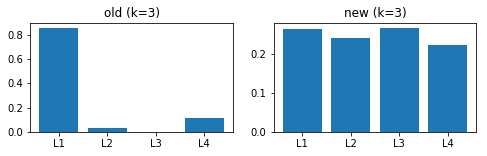

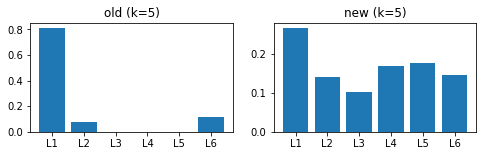

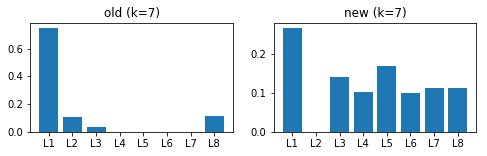

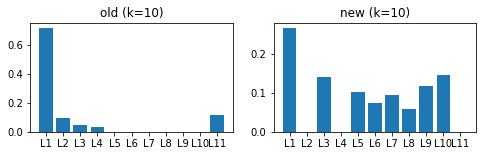

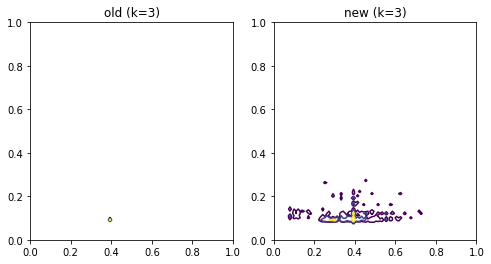

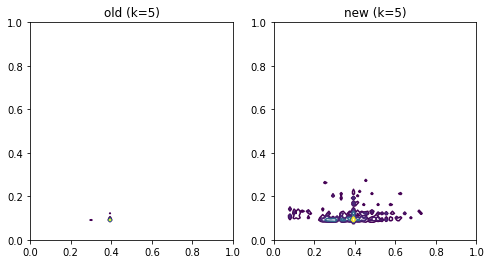

ValueError: Contour levels must be increasing

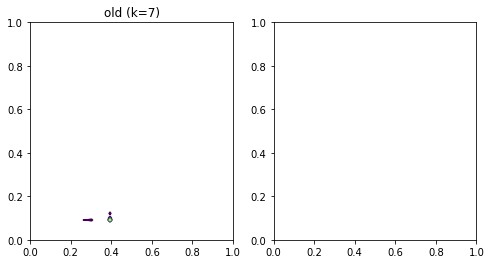

In [369]:
plot_combined(titanic_x, titanic_y, titanic_p, k=[3,5,7,10])

### new Idea: area represents equal increase over previous level

Xavi and me came up with another new idea, which I want to try out. It has a different semantic.

The first new idea aims to have the advantage of intuitive intepretation: areas correspond to probability. And this promise is kept, but maybe it is anyway not intuitive in the following sense:

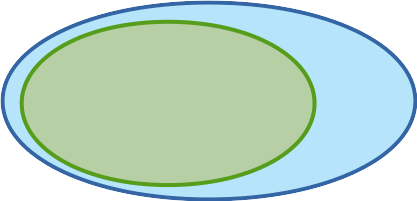

The blue circle is (I believe) interpreted as _containing_ the green one. Now, assigning probabilities to each of the areas, the blue area is _thought_ to be much larger than the green one. However, by construction with our technique both areas encode the same probability and the blue one does _not_ contain the green one. But the blue and green really look like this:

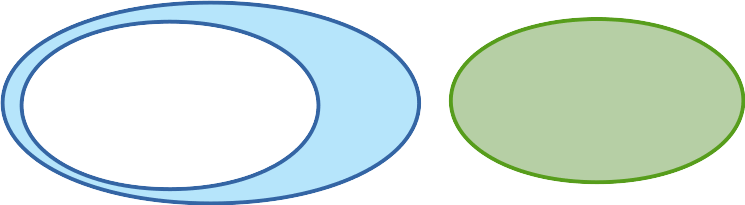

Here, we propose another way of constructing the levels: the levels correspond to actual horizontal cuts of the density funcion and the horizonal slices between all adjacant level should be equal.

In [147]:
k = 5

In [148]:
pdf = gm3p

In [168]:
def prob_horizontal_contour_levels(pdf, k=5):
    # this assumes a support on linear, equi-distant grid points in both directions !!!

    pdf = pdf.flatten()

    # 1. get level targets
    level_targets = np.linspace(0, 1, k+2)[1:-1]
#     print(level_targets)

    # 2. order by density
    pdf_sorted = np.sort(pdf)
#     print(pdf_sorted)

    # 3. get (unnormalized) weight for each slice (i.e. each increase in density)
    # this is: (increase in p compared to previous p)*(number of p values equal or larger than p)
    # get neighboring difference
    pdf_shift = np.roll(pdf_sorted, 1)
    pdf_shift[0] = 0
    assert(len(pdf_shift) == len(pdf_sorted))
    pdf_diff = pdf_sorted - pdf_shift
#     print(pdf_diff)

    # get weight as above product
    prob = pdf_diff * np.arange(len(pdf), 0, -1)
#     print(prob)
#     print(len(prob))

    # 4. normalize all weights
    prob_norm = prob / np.sum(prob)
#     print(prob_norm)

    # 5. get cumulative weights
    cum_prob = np.cumsum(prob_norm)
    if not np.isclose([1],cum_prob[-1:]):
        raise AssertionError('normalization failed')

    # 6. find sorted
    indices = np.searchsorted(cum_prob, level_targets, side='left')
#     print(indices)

    # 7. get density levels
    level_values = pdf_sorted[indices]    
    assert(np.all(np.diff(level_values)>=0))
    
    return level_values    

In [169]:
prob_horizontal_contour_levels(gm3p,5)

array([0.06150435, 0.16964529, 0.73773094, 1.68794948, 3.24093099])